##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2021-08-11 17:32:49.547085: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

    8192/84125825 [..............................] - ETA: 23:04

   24576/84125825 [..............................] - ETA: 15:30

   40960/84125825 [..............................] - ETA: 13:55

   73728/84125825 [..............................] - ETA: 10:18

   90112/84125825 [..............................] - ETA: 10:31

  139264/84125825 [..............................] - ETA: 8:10 

  188416/84125825 [..............................] - ETA: 7:02

  253952/84125825 [..............................] - ETA: 5:57

  319488/84125825 [..............................] - ETA: 5:19

  385024/84125825 [..............................] - ETA: 4:54

  466944/84125825 [..............................] - ETA: 4:26

  565248/84125825 [..............................] - ETA: 4:00

  696320/84125825 [..............................] - ETA: 3:30

  843776/84125825 [..............................] - ETA: 3:07

 1024000/84125825 [..............................] - ETA: 2:44

 1253376/84125825 [..............................] - ETA: 2:23

 1515520/84125825 [..............................] - ETA: 2:05

 1859584/84125825 [..............................] - ETA: 1:45

 1875968/84125825 [..............................] - ETA: 1:46

 2269184/84125825 [..............................] - ETA: 1:32

 2744320/84125825 [..............................] - ETA: 1:20

 3301376/84125825 [>.............................] - ETA: 1:08

 3317760/84125825 [>.............................] - ETA: 1:09

 3973120/84125825 [>.............................] - ETA: 59s 

 4005888/84125825 [>.............................] - ETA: 59s

 4775936/84125825 [>.............................] - ETA: 50s

 4808704/84125825 [>.............................] - ETA: 51s

 5742592/84125825 [=>............................] - ETA: 43s

 5775360/84125825 [=>............................] - ETA: 44s

 6905856/84125825 [=>............................] - ETA: 37s

 6955008/84125825 [=>............................] - ETA: 37s

 8347648/84125825 [=>............................] - ETA: 31s

 8388608/84125825 [=>............................] - ETA: 31s

10100736/84125825 [==>...........................] - ETA: 26s

10166272/84125825 [==>...........................] - ETA: 26s

12247040/84125825 [===>..........................] - ETA: 21s

12296192/84125825 [===>..........................] - ETA: 22s

14852096/84125825 [====>.........................] - ETA: 18s

14934016/84125825 [====>.........................] - ETA: 18s

17702912/84125825 [=====>........................] - ETA: 15s

17801216/84125825 [=====>........................] - ETA: 15s

20766720/84125825 [======>.......................] - ETA: 12s

20881408/84125825 [======>.......................] - ETA: 12s

23896064/84125825 [=======>......................] - ETA: 10s

24010752/84125825 [=======>......................] - ETA: 10s

27041792/84125825 [========>.....................] - ETA: 9s 

27172864/84125825 [========>.....................] - ETA: 9s

30171136/84125825 [=========>....................] - ETA: 8s

30285824/84125825 [=========>....................] - ETA: 8s

32202752/84125825 [==========>...................] - ETA: 7s

35348480/84125825 [===========>..................] - ETA: 6s

37511168/84125825 [============>.................] - ETA: 6s

39821312/84125825 [=============>................] - ETA: 5s

42164224/84125825 [==============>...............] - ETA: 5s

44539904/84125825 [==============>...............] - ETA: 4s

46931968/84125825 [===============>..............] - ETA: 4s

49373184/84125825 [================>.............] - ETA: 4s

51847168/84125825 [=================>............] - ETA: 3s

54337536/84125825 [==================>...........] - ETA: 3s

56860672/84125825 [===================>..........] - ETA: 2s

59416576/84125825 [====================>.........] - ETA: 2s

61988864/84125825 [=====================>........] - ETA: 2s

64593920/84125825 [======================>.......] - ETA: 1s

67215360/84125825 [======================>.......] - ETA: 1s

69869568/84125825 [=======================>......] - ETA: 1s

72507392/84125825 [========================>.....] - ETA: 1s

73048064/84125825 [=========================>....] - ETA: 1s

76177408/84125825 [==========================>...] - ETA: 0s

78045184/84125825 [==========================>...] - ETA: 0s

79945728/84125825 [===========================>..] - ETA: 0s

81862656/84125825 [============================>.] - ETA: 0s

83812352/84125825 [============================>.] - ETA: 0s

84131840/84125825 [==============================] - 8s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2021-08-11 17:33:13.555982: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-11 17:33:14.233166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-11 17:33:14.234115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-08-11 17:33:14.234156: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-11 17:33:14.237601: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-11 17:33:14.237695: I tensorflow/stream_executor/platfo

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

2021-08-11 17:33:16.844509: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-11 17:33:16.844974: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000165000 Hz
2021-08-11 17:33:16.864330: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

2021-08-11 17:33:30.988937: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.99280983 -0.1861186   0.36673835  0.15233682  0.65504444
  0.9681154  -0.9486272   0.00216158 -0.9877732   0.0684272  -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946388  0.3432126   0.33231565 ...  0.21300787  0.7102078
  -0.05771166]
 [-0.28742015  0.31981024 -0.2301858  ...  0.58455074 -0.21329722
   0.7269209 ]
 [-0.66157013  0.6887685  -0.87432927 ...  0.10877253 -0.26173282
   0.47855264]
 ...
 [-0.2256118  -0.28925604 -0.07064401 ...  0.4756601   0.8327715
   0.40025353]
 [-0.29824278 -0.27473143 -0.05450511 ...  0.48849759  1.0955356
   0.18163344]
 [-0.44378197  0.00930723  0.07223766 ...  0.1729009   1.1833246
   0.07897988]]


2021-08-11 17:33:31.396345: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.27431926]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

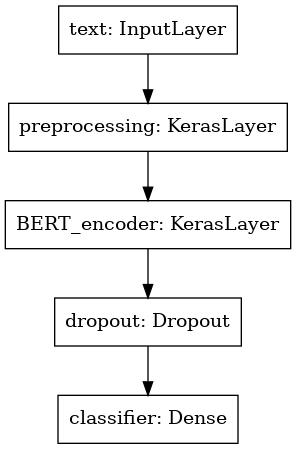

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


  1/625 [..............................] - ETA: 58:28 - loss: 0.6095 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 1:18 - loss: 0.7442 - binary_accuracy: 0.5938 

  3/625 [..............................] - ETA: 1:16 - loss: 0.7828 - binary_accuracy: 0.5521

  4/625 [..............................] - ETA: 1:14 - loss: 0.7569 - binary_accuracy: 0.5625

  5/625 [..............................] - ETA: 1:14 - loss: 0.7592 - binary_accuracy: 0.5625

  6/625 [..............................] - ETA: 1:14 - loss: 0.7611 - binary_accuracy: 0.5573

  7/625 [..............................] - ETA: 1:13 - loss: 0.7562 - binary_accuracy: 0.5670

  8/625 [..............................] - ETA: 1:13 - loss: 0.7499 - binary_accuracy: 0.5820

  9/625 [..............................] - ETA: 1:12 - loss: 0.7587 - binary_accuracy: 0.5764

 10/625 [..............................] - ETA: 1:12 - loss: 0.7762 - binary_accuracy: 0.5562

 11/625 [..............................] - ETA: 1:12 - loss: 0.7832 - binary_accuracy: 0.5426

 12/625 [..............................] - ETA: 1:12 - loss: 0.7912 - binary_accuracy: 0.5286

 13/625 [..............................] - ETA: 1:12 - loss: 0.7897 - binary_accuracy: 0.5240

 14/625 [..............................] - ETA: 1:11 - loss: 0.7904 - binary_accuracy: 0.5246

 15/625 [..............................] - ETA: 1:11 - loss: 0.7863 - binary_accuracy: 0.5250

 16/625 [..............................] - ETA: 1:11 - loss: 0.7764 - binary_accuracy: 0.5371

 17/625 [..............................] - ETA: 1:11 - loss: 0.7781 - binary_accuracy: 0.5294

 18/625 [..............................] - ETA: 1:11 - loss: 0.7762 - binary_accuracy: 0.5330

 19/625 [..............................] - ETA: 1:11 - loss: 0.7743 - binary_accuracy: 0.5312

 20/625 [..............................] - ETA: 1:11 - loss: 0.7720 - binary_accuracy: 0.5312

 21/625 [>.............................] - ETA: 1:10 - loss: 0.7731 - binary_accuracy: 0.5298

 22/625 [>.............................] - ETA: 1:10 - loss: 0.7737 - binary_accuracy: 0.5270

 23/625 [>.............................] - ETA: 1:10 - loss: 0.7724 - binary_accuracy: 0.5258

 24/625 [>.............................] - ETA: 1:10 - loss: 0.7698 - binary_accuracy: 0.5286

 25/625 [>.............................] - ETA: 1:10 - loss: 0.7728 - binary_accuracy: 0.5238

 26/625 [>.............................] - ETA: 1:10 - loss: 0.7679 - binary_accuracy: 0.5240

 27/625 [>.............................] - ETA: 1:10 - loss: 0.7663 - binary_accuracy: 0.5185

 28/625 [>.............................] - ETA: 1:09 - loss: 0.7636 - binary_accuracy: 0.5223

 29/625 [>.............................] - ETA: 1:09 - loss: 0.7648 - binary_accuracy: 0.5172

 30/625 [>.............................] - ETA: 1:09 - loss: 0.7632 - binary_accuracy: 0.5156

 31/625 [>.............................] - ETA: 1:09 - loss: 0.7615 - binary_accuracy: 0.5181

 32/625 [>.............................] - ETA: 1:09 - loss: 0.7611 - binary_accuracy: 0.5176

 33/625 [>.............................] - ETA: 1:09 - loss: 0.7599 - binary_accuracy: 0.5199

 34/625 [>.............................] - ETA: 1:09 - loss: 0.7584 - binary_accuracy: 0.5175

 35/625 [>.............................] - ETA: 1:09 - loss: 0.7578 - binary_accuracy: 0.5214

 36/625 [>.............................] - ETA: 1:09 - loss: 0.7569 - binary_accuracy: 0.5217

 37/625 [>.............................] - ETA: 1:08 - loss: 0.7547 - binary_accuracy: 0.5220

 38/625 [>.............................] - ETA: 1:08 - loss: 0.7524 - binary_accuracy: 0.5247

 39/625 [>.............................] - ETA: 1:08 - loss: 0.7531 - binary_accuracy: 0.5240

 40/625 [>.............................] - ETA: 1:08 - loss: 0.7517 - binary_accuracy: 0.5273

 41/625 [>.............................] - ETA: 1:08 - loss: 0.7517 - binary_accuracy: 0.5259

 42/625 [=>............................] - ETA: 1:08 - loss: 0.7524 - binary_accuracy: 0.5253

 43/625 [=>............................] - ETA: 1:08 - loss: 0.7488 - binary_accuracy: 0.5291

 44/625 [=>............................] - ETA: 1:08 - loss: 0.7461 - binary_accuracy: 0.5284

 45/625 [=>............................] - ETA: 1:08 - loss: 0.7477 - binary_accuracy: 0.5285

 46/625 [=>............................] - ETA: 1:07 - loss: 0.7452 - binary_accuracy: 0.5326

 47/625 [=>............................] - ETA: 1:07 - loss: 0.7442 - binary_accuracy: 0.5332

 48/625 [=>............................] - ETA: 1:07 - loss: 0.7444 - binary_accuracy: 0.5326

 49/625 [=>............................] - ETA: 1:07 - loss: 0.7421 - binary_accuracy: 0.5338

 50/625 [=>............................] - ETA: 1:07 - loss: 0.7416 - binary_accuracy: 0.5356

 51/625 [=>............................] - ETA: 1:07 - loss: 0.7392 - binary_accuracy: 0.5398

 52/625 [=>............................] - ETA: 1:07 - loss: 0.7383 - binary_accuracy: 0.5409

 53/625 [=>............................] - ETA: 1:07 - loss: 0.7396 - binary_accuracy: 0.5377

 54/625 [=>............................] - ETA: 1:06 - loss: 0.7383 - binary_accuracy: 0.5376

 55/625 [=>............................] - ETA: 1:06 - loss: 0.7383 - binary_accuracy: 0.5381

 56/625 [=>............................] - ETA: 1:06 - loss: 0.7386 - binary_accuracy: 0.5368

 57/625 [=>............................] - ETA: 1:06 - loss: 0.7367 - binary_accuracy: 0.5373

 58/625 [=>............................] - ETA: 1:06 - loss: 0.7363 - binary_accuracy: 0.5356

 59/625 [=>............................] - ETA: 1:06 - loss: 0.7344 - binary_accuracy: 0.5381

 60/625 [=>............................] - ETA: 1:06 - loss: 0.7330 - binary_accuracy: 0.5396

 61/625 [=>............................] - ETA: 1:06 - loss: 0.7296 - binary_accuracy: 0.5420

 62/625 [=>............................] - ETA: 1:06 - loss: 0.7289 - binary_accuracy: 0.5413

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.7283 - binary_accuracy: 0.5422

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.7273 - binary_accuracy: 0.5420

 65/625 [==>...........................] - ETA: 1:05 - loss: 0.7277 - binary_accuracy: 0.5413

 66/625 [==>...........................] - ETA: 1:05 - loss: 0.7270 - binary_accuracy: 0.5431

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.7253 - binary_accuracy: 0.5443

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.7250 - binary_accuracy: 0.5446

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.7238 - binary_accuracy: 0.5439

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.7231 - binary_accuracy: 0.5442

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.7212 - binary_accuracy: 0.5458

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.7203 - binary_accuracy: 0.5451

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.7203 - binary_accuracy: 0.5437

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.7200 - binary_accuracy: 0.5418

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.7197 - binary_accuracy: 0.5408

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.7206 - binary_accuracy: 0.5391

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.7196 - binary_accuracy: 0.5390

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.7185 - binary_accuracy: 0.5389

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.7169 - binary_accuracy: 0.5403

 80/625 [==>...........................] - ETA: 1:04 - loss: 0.7160 - binary_accuracy: 0.5402

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.7153 - binary_accuracy: 0.5409

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.7140 - binary_accuracy: 0.5419

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.7143 - binary_accuracy: 0.5429

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.7127 - binary_accuracy: 0.5432

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.7130 - binary_accuracy: 0.5445

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.7122 - binary_accuracy: 0.5461

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.7103 - binary_accuracy: 0.5474

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.7099 - binary_accuracy: 0.5472

 89/625 [===>..........................] - ETA: 1:03 - loss: 0.7109 - binary_accuracy: 0.5467

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.7099 - binary_accuracy: 0.5472

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.7091 - binary_accuracy: 0.5488

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.7080 - binary_accuracy: 0.5499

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.7061 - binary_accuracy: 0.5514

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.7058 - binary_accuracy: 0.5519

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.7057 - binary_accuracy: 0.5520

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.7047 - binary_accuracy: 0.5544

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.7035 - binary_accuracy: 0.5551

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.7026 - binary_accuracy: 0.5548

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.7020 - binary_accuracy: 0.5559

100/625 [===>..........................] - ETA: 1:01 - loss: 0.7013 - binary_accuracy: 0.5562

101/625 [===>..........................] - ETA: 1:01 - loss: 0.7010 - binary_accuracy: 0.5563

102/625 [===>..........................] - ETA: 1:01 - loss: 0.7000 - binary_accuracy: 0.5570

103/625 [===>..........................] - ETA: 1:01 - loss: 0.6986 - binary_accuracy: 0.5576

104/625 [===>..........................] - ETA: 1:01 - loss: 0.6976 - binary_accuracy: 0.5595

105/625 [====>.........................] - ETA: 1:01 - loss: 0.6967 - binary_accuracy: 0.5601

106/625 [====>.........................] - ETA: 1:01 - loss: 0.6957 - binary_accuracy: 0.5613

107/625 [====>.........................] - ETA: 1:00 - loss: 0.6950 - binary_accuracy: 0.5622

108/625 [====>.........................] - ETA: 1:00 - loss: 0.6936 - binary_accuracy: 0.5639

109/625 [====>.........................] - ETA: 1:00 - loss: 0.6930 - binary_accuracy: 0.5639

110/625 [====>.........................] - ETA: 1:00 - loss: 0.6931 - binary_accuracy: 0.5631

111/625 [====>.........................] - ETA: 1:00 - loss: 0.6921 - binary_accuracy: 0.5639

112/625 [====>.........................] - ETA: 1:00 - loss: 0.6911 - binary_accuracy: 0.5642

113/625 [====>.........................] - ETA: 1:00 - loss: 0.6905 - binary_accuracy: 0.5644

114/625 [====>.........................] - ETA: 1:00 - loss: 0.6907 - binary_accuracy: 0.5647

115/625 [====>.........................] - ETA: 1:00 - loss: 0.6902 - binary_accuracy: 0.5649

116/625 [====>.........................] - ETA: 59s - loss: 0.6907 - binary_accuracy: 0.5641 

117/625 [====>.........................] - ETA: 59s - loss: 0.6899 - binary_accuracy: 0.5644

118/625 [====>.........................] - ETA: 59s - loss: 0.6892 - binary_accuracy: 0.5644

119/625 [====>.........................] - ETA: 59s - loss: 0.6881 - binary_accuracy: 0.5659

120/625 [====>.........................] - ETA: 59s - loss: 0.6874 - binary_accuracy: 0.5672

121/625 [====>.........................] - ETA: 59s - loss: 0.6872 - binary_accuracy: 0.5664

122/625 [====>.........................] - ETA: 59s - loss: 0.6861 - binary_accuracy: 0.5674

123/625 [====>.........................] - ETA: 59s - loss: 0.6860 - binary_accuracy: 0.5673

124/625 [====>.........................] - ETA: 59s - loss: 0.6856 - binary_accuracy: 0.5673

125/625 [=====>........................] - ETA: 58s - loss: 0.6846 - binary_accuracy: 0.5688

126/625 [=====>........................] - ETA: 58s - loss: 0.6838 - binary_accuracy: 0.5687

127/625 [=====>........................] - ETA: 58s - loss: 0.6833 - binary_accuracy: 0.5694

128/625 [=====>........................] - ETA: 58s - loss: 0.6814 - binary_accuracy: 0.5713

129/625 [=====>........................] - ETA: 58s - loss: 0.6813 - binary_accuracy: 0.5724

130/625 [=====>........................] - ETA: 58s - loss: 0.6814 - binary_accuracy: 0.5721

131/625 [=====>........................] - ETA: 58s - loss: 0.6807 - binary_accuracy: 0.5725

132/625 [=====>........................] - ETA: 58s - loss: 0.6799 - binary_accuracy: 0.5739

133/625 [=====>........................] - ETA: 57s - loss: 0.6793 - binary_accuracy: 0.5745

134/625 [=====>........................] - ETA: 57s - loss: 0.6788 - binary_accuracy: 0.5749

135/625 [=====>........................] - ETA: 57s - loss: 0.6781 - binary_accuracy: 0.5757

136/625 [=====>........................] - ETA: 57s - loss: 0.6764 - binary_accuracy: 0.5777

137/625 [=====>........................] - ETA: 57s - loss: 0.6752 - binary_accuracy: 0.5787

138/625 [=====>........................] - ETA: 57s - loss: 0.6744 - binary_accuracy: 0.5788

139/625 [=====>........................] - ETA: 57s - loss: 0.6735 - binary_accuracy: 0.5791

140/625 [=====>........................] - ETA: 57s - loss: 0.6730 - binary_accuracy: 0.5801

141/625 [=====>........................] - ETA: 56s - loss: 0.6724 - binary_accuracy: 0.5811

142/625 [=====>........................] - ETA: 56s - loss: 0.6711 - binary_accuracy: 0.5821

143/625 [=====>........................] - ETA: 56s - loss: 0.6711 - binary_accuracy: 0.5822

144/625 [=====>........................] - ETA: 56s - loss: 0.6699 - binary_accuracy: 0.5836

145/625 [=====>........................] - ETA: 56s - loss: 0.6695 - binary_accuracy: 0.5836

146/625 [======>.......................] - ETA: 56s - loss: 0.6694 - binary_accuracy: 0.5833

147/625 [======>.......................] - ETA: 56s - loss: 0.6682 - binary_accuracy: 0.5842

148/625 [======>.......................] - ETA: 56s - loss: 0.6682 - binary_accuracy: 0.5842

149/625 [======>.......................] - ETA: 56s - loss: 0.6674 - binary_accuracy: 0.5852

150/625 [======>.......................] - ETA: 55s - loss: 0.6669 - binary_accuracy: 0.5850

151/625 [======>.......................] - ETA: 55s - loss: 0.6665 - binary_accuracy: 0.5859

152/625 [======>.......................] - ETA: 55s - loss: 0.6655 - binary_accuracy: 0.5868

153/625 [======>.......................] - ETA: 55s - loss: 0.6645 - binary_accuracy: 0.5872

154/625 [======>.......................] - ETA: 55s - loss: 0.6635 - binary_accuracy: 0.5879

155/625 [======>.......................] - ETA: 55s - loss: 0.6628 - binary_accuracy: 0.5883

156/625 [======>.......................] - ETA: 55s - loss: 0.6617 - binary_accuracy: 0.5889

157/625 [======>.......................] - ETA: 55s - loss: 0.6614 - binary_accuracy: 0.5892

158/625 [======>.......................] - ETA: 54s - loss: 0.6611 - binary_accuracy: 0.5900

159/625 [======>.......................] - ETA: 54s - loss: 0.6601 - binary_accuracy: 0.5910

160/625 [======>.......................] - ETA: 54s - loss: 0.6595 - binary_accuracy: 0.5910

161/625 [======>.......................] - ETA: 54s - loss: 0.6579 - binary_accuracy: 0.5928

162/625 [======>.......................] - ETA: 54s - loss: 0.6570 - binary_accuracy: 0.5938

163/625 [======>.......................] - ETA: 54s - loss: 0.6557 - binary_accuracy: 0.5949

164/625 [======>.......................] - ETA: 54s - loss: 0.6557 - binary_accuracy: 0.5947

165/625 [======>.......................] - ETA: 54s - loss: 0.6544 - binary_accuracy: 0.5962

166/625 [======>.......................] - ETA: 54s - loss: 0.6542 - binary_accuracy: 0.5964

167/625 [=======>......................] - ETA: 53s - loss: 0.6531 - binary_accuracy: 0.5971

168/625 [=======>......................] - ETA: 53s - loss: 0.6527 - binary_accuracy: 0.5971

169/625 [=======>......................] - ETA: 53s - loss: 0.6515 - binary_accuracy: 0.5984

170/625 [=======>......................] - ETA: 53s - loss: 0.6507 - binary_accuracy: 0.5994

171/625 [=======>......................] - ETA: 53s - loss: 0.6503 - binary_accuracy: 0.6001

172/625 [=======>......................] - ETA: 53s - loss: 0.6490 - binary_accuracy: 0.6010

173/625 [=======>......................] - ETA: 53s - loss: 0.6484 - binary_accuracy: 0.6015

174/625 [=======>......................] - ETA: 53s - loss: 0.6469 - binary_accuracy: 0.6026

175/625 [=======>......................] - ETA: 53s - loss: 0.6455 - binary_accuracy: 0.6039

176/625 [=======>......................] - ETA: 52s - loss: 0.6455 - binary_accuracy: 0.6040

177/625 [=======>......................] - ETA: 52s - loss: 0.6445 - binary_accuracy: 0.6049

178/625 [=======>......................] - ETA: 52s - loss: 0.6436 - binary_accuracy: 0.6057

179/625 [=======>......................] - ETA: 52s - loss: 0.6423 - binary_accuracy: 0.6065

180/625 [=======>......................] - ETA: 52s - loss: 0.6414 - binary_accuracy: 0.6073

181/625 [=======>......................] - ETA: 52s - loss: 0.6402 - binary_accuracy: 0.6077

182/625 [=======>......................] - ETA: 52s - loss: 0.6400 - binary_accuracy: 0.6083

183/625 [=======>......................] - ETA: 52s - loss: 0.6399 - binary_accuracy: 0.6089

184/625 [=======>......................] - ETA: 51s - loss: 0.6394 - binary_accuracy: 0.6101

185/625 [=======>......................] - ETA: 51s - loss: 0.6379 - binary_accuracy: 0.6110

186/625 [=======>......................] - ETA: 51s - loss: 0.6371 - binary_accuracy: 0.6121

187/625 [=======>......................] - ETA: 51s - loss: 0.6362 - binary_accuracy: 0.6125

188/625 [========>.....................] - ETA: 51s - loss: 0.6346 - binary_accuracy: 0.6142

189/625 [========>.....................] - ETA: 51s - loss: 0.6333 - binary_accuracy: 0.6152

190/625 [========>.....................] - ETA: 51s - loss: 0.6332 - binary_accuracy: 0.6158

191/625 [========>.....................] - ETA: 51s - loss: 0.6320 - binary_accuracy: 0.6168

192/625 [========>.....................] - ETA: 50s - loss: 0.6309 - binary_accuracy: 0.6177

193/625 [========>.....................] - ETA: 50s - loss: 0.6308 - binary_accuracy: 0.6180

194/625 [========>.....................] - ETA: 50s - loss: 0.6303 - binary_accuracy: 0.6187

195/625 [========>.....................] - ETA: 50s - loss: 0.6293 - binary_accuracy: 0.6196

196/625 [========>.....................] - ETA: 50s - loss: 0.6297 - binary_accuracy: 0.6194

197/625 [========>.....................] - ETA: 50s - loss: 0.6291 - binary_accuracy: 0.6199

198/625 [========>.....................] - ETA: 50s - loss: 0.6285 - binary_accuracy: 0.6203

199/625 [========>.....................] - ETA: 50s - loss: 0.6284 - binary_accuracy: 0.6204

200/625 [========>.....................] - ETA: 50s - loss: 0.6273 - binary_accuracy: 0.6214

201/625 [========>.....................] - ETA: 49s - loss: 0.6272 - binary_accuracy: 0.6216

202/625 [========>.....................] - ETA: 49s - loss: 0.6259 - binary_accuracy: 0.6224

203/625 [========>.....................] - ETA: 49s - loss: 0.6252 - binary_accuracy: 0.6232

204/625 [========>.....................] - ETA: 49s - loss: 0.6246 - binary_accuracy: 0.6241

205/625 [========>.....................] - ETA: 49s - loss: 0.6242 - binary_accuracy: 0.6248

206/625 [========>.....................] - ETA: 49s - loss: 0.6230 - binary_accuracy: 0.6256

207/625 [========>.....................] - ETA: 49s - loss: 0.6232 - binary_accuracy: 0.6258

208/625 [========>.....................] - ETA: 49s - loss: 0.6228 - binary_accuracy: 0.6262

209/625 [=========>....................] - ETA: 48s - loss: 0.6217 - binary_accuracy: 0.6274

210/625 [=========>....................] - ETA: 48s - loss: 0.6208 - binary_accuracy: 0.6281

211/625 [=========>....................] - ETA: 48s - loss: 0.6199 - binary_accuracy: 0.6284

212/625 [=========>....................] - ETA: 48s - loss: 0.6191 - binary_accuracy: 0.6293

213/625 [=========>....................] - ETA: 48s - loss: 0.6184 - binary_accuracy: 0.6298

214/625 [=========>....................] - ETA: 48s - loss: 0.6175 - binary_accuracy: 0.6305

215/625 [=========>....................] - ETA: 48s - loss: 0.6171 - binary_accuracy: 0.6311

216/625 [=========>....................] - ETA: 48s - loss: 0.6169 - binary_accuracy: 0.6315

217/625 [=========>....................] - ETA: 48s - loss: 0.6160 - binary_accuracy: 0.6323

218/625 [=========>....................] - ETA: 47s - loss: 0.6146 - binary_accuracy: 0.6332

219/625 [=========>....................] - ETA: 47s - loss: 0.6144 - binary_accuracy: 0.6334

220/625 [=========>....................] - ETA: 47s - loss: 0.6138 - binary_accuracy: 0.6341

221/625 [=========>....................] - ETA: 47s - loss: 0.6129 - binary_accuracy: 0.6348

222/625 [=========>....................] - ETA: 47s - loss: 0.6119 - binary_accuracy: 0.6353

223/625 [=========>....................] - ETA: 47s - loss: 0.6111 - binary_accuracy: 0.6361

224/625 [=========>....................] - ETA: 47s - loss: 0.6113 - binary_accuracy: 0.6362

225/625 [=========>....................] - ETA: 47s - loss: 0.6109 - binary_accuracy: 0.6369

226/625 [=========>....................] - ETA: 46s - loss: 0.6097 - binary_accuracy: 0.6379

227/625 [=========>....................] - ETA: 46s - loss: 0.6084 - binary_accuracy: 0.6389

228/625 [=========>....................] - ETA: 46s - loss: 0.6075 - binary_accuracy: 0.6398

229/625 [=========>....................] - ETA: 46s - loss: 0.6074 - binary_accuracy: 0.6401

230/625 [==========>...................] - ETA: 46s - loss: 0.6065 - binary_accuracy: 0.6408

231/625 [==========>...................] - ETA: 46s - loss: 0.6055 - binary_accuracy: 0.6415

232/625 [==========>...................] - ETA: 46s - loss: 0.6045 - binary_accuracy: 0.6424

233/625 [==========>...................] - ETA: 46s - loss: 0.6032 - binary_accuracy: 0.6432

234/625 [==========>...................] - ETA: 45s - loss: 0.6028 - binary_accuracy: 0.6433

235/625 [==========>...................] - ETA: 45s - loss: 0.6018 - binary_accuracy: 0.6439

236/625 [==========>...................] - ETA: 45s - loss: 0.6020 - binary_accuracy: 0.6441

237/625 [==========>...................] - ETA: 45s - loss: 0.6014 - binary_accuracy: 0.6445

238/625 [==========>...................] - ETA: 45s - loss: 0.6000 - binary_accuracy: 0.6459

239/625 [==========>...................] - ETA: 45s - loss: 0.6000 - binary_accuracy: 0.6458

240/625 [==========>...................] - ETA: 45s - loss: 0.5991 - binary_accuracy: 0.6467

241/625 [==========>...................] - ETA: 45s - loss: 0.5990 - binary_accuracy: 0.6470

242/625 [==========>...................] - ETA: 45s - loss: 0.5978 - binary_accuracy: 0.6481

243/625 [==========>...................] - ETA: 44s - loss: 0.5974 - binary_accuracy: 0.6488

244/625 [==========>...................] - ETA: 44s - loss: 0.5971 - binary_accuracy: 0.6489

245/625 [==========>...................] - ETA: 44s - loss: 0.5965 - binary_accuracy: 0.6497

246/625 [==========>...................] - ETA: 44s - loss: 0.5960 - binary_accuracy: 0.6504

247/625 [==========>...................] - ETA: 44s - loss: 0.5953 - binary_accuracy: 0.6511

248/625 [==========>...................] - ETA: 44s - loss: 0.5954 - binary_accuracy: 0.6512

249/625 [==========>...................] - ETA: 44s - loss: 0.5944 - binary_accuracy: 0.6516

250/625 [===========>..................] - ETA: 44s - loss: 0.5939 - binary_accuracy: 0.6518

251/625 [===========>..................] - ETA: 43s - loss: 0.5939 - binary_accuracy: 0.6521

252/625 [===========>..................] - ETA: 43s - loss: 0.5930 - binary_accuracy: 0.6527

253/625 [===========>..................] - ETA: 43s - loss: 0.5919 - binary_accuracy: 0.6535

254/625 [===========>..................] - ETA: 43s - loss: 0.5913 - binary_accuracy: 0.6540

255/625 [===========>..................] - ETA: 43s - loss: 0.5905 - binary_accuracy: 0.6547

256/625 [===========>..................] - ETA: 43s - loss: 0.5907 - binary_accuracy: 0.6547

257/625 [===========>..................] - ETA: 43s - loss: 0.5906 - binary_accuracy: 0.6552

258/625 [===========>..................] - ETA: 43s - loss: 0.5901 - binary_accuracy: 0.6556

259/625 [===========>..................] - ETA: 42s - loss: 0.5898 - binary_accuracy: 0.6559

260/625 [===========>..................] - ETA: 42s - loss: 0.5895 - binary_accuracy: 0.6562

261/625 [===========>..................] - ETA: 42s - loss: 0.5887 - binary_accuracy: 0.6567

262/625 [===========>..................] - ETA: 42s - loss: 0.5879 - binary_accuracy: 0.6573

263/625 [===========>..................] - ETA: 42s - loss: 0.5882 - binary_accuracy: 0.6572

264/625 [===========>..................] - ETA: 42s - loss: 0.5879 - binary_accuracy: 0.6576

265/625 [===========>..................] - ETA: 42s - loss: 0.5867 - binary_accuracy: 0.6584

266/625 [===========>..................] - ETA: 42s - loss: 0.5858 - binary_accuracy: 0.6590

267/625 [===========>..................] - ETA: 42s - loss: 0.5853 - binary_accuracy: 0.6595

268/625 [===========>..................] - ETA: 41s - loss: 0.5846 - binary_accuracy: 0.6603

269/625 [===========>..................] - ETA: 41s - loss: 0.5842 - binary_accuracy: 0.6612

270/625 [===========>..................] - ETA: 41s - loss: 0.5841 - binary_accuracy: 0.6612

271/625 [============>.................] - ETA: 41s - loss: 0.5838 - binary_accuracy: 0.6616

272/625 [============>.................] - ETA: 41s - loss: 0.5834 - binary_accuracy: 0.6619

273/625 [============>.................] - ETA: 41s - loss: 0.5838 - binary_accuracy: 0.6616

274/625 [============>.................] - ETA: 41s - loss: 0.5837 - binary_accuracy: 0.6616

275/625 [============>.................] - ETA: 41s - loss: 0.5829 - binary_accuracy: 0.6624

276/625 [============>.................] - ETA: 41s - loss: 0.5821 - binary_accuracy: 0.6632

277/625 [============>.................] - ETA: 40s - loss: 0.5813 - binary_accuracy: 0.6636

278/625 [============>.................] - ETA: 40s - loss: 0.5809 - binary_accuracy: 0.6640

279/625 [============>.................] - ETA: 40s - loss: 0.5806 - binary_accuracy: 0.6641

280/625 [============>.................] - ETA: 40s - loss: 0.5800 - binary_accuracy: 0.6647

281/625 [============>.................] - ETA: 40s - loss: 0.5798 - binary_accuracy: 0.6651

282/625 [============>.................] - ETA: 40s - loss: 0.5796 - binary_accuracy: 0.6652

283/625 [============>.................] - ETA: 40s - loss: 0.5793 - binary_accuracy: 0.6655

284/625 [============>.................] - ETA: 40s - loss: 0.5783 - binary_accuracy: 0.6663

285/625 [============>.................] - ETA: 39s - loss: 0.5783 - binary_accuracy: 0.6664

286/625 [============>.................] - ETA: 39s - loss: 0.5784 - binary_accuracy: 0.6667

287/625 [============>.................] - ETA: 39s - loss: 0.5783 - binary_accuracy: 0.6669

288/625 [============>.................] - ETA: 39s - loss: 0.5785 - binary_accuracy: 0.6672

289/625 [============>.................] - ETA: 39s - loss: 0.5780 - binary_accuracy: 0.6677

290/625 [============>.................] - ETA: 39s - loss: 0.5775 - binary_accuracy: 0.6681

291/625 [============>.................] - ETA: 39s - loss: 0.5774 - binary_accuracy: 0.6680

292/625 [=============>................] - ETA: 39s - loss: 0.5772 - binary_accuracy: 0.6682

293/625 [=============>................] - ETA: 39s - loss: 0.5769 - binary_accuracy: 0.6684

294/625 [=============>................] - ETA: 38s - loss: 0.5769 - binary_accuracy: 0.6687

295/625 [=============>................] - ETA: 38s - loss: 0.5767 - binary_accuracy: 0.6689

296/625 [=============>................] - ETA: 38s - loss: 0.5763 - binary_accuracy: 0.6696

297/625 [=============>................] - ETA: 38s - loss: 0.5757 - binary_accuracy: 0.6698

298/625 [=============>................] - ETA: 38s - loss: 0.5748 - binary_accuracy: 0.6705

299/625 [=============>................] - ETA: 38s - loss: 0.5745 - binary_accuracy: 0.6707

300/625 [=============>................] - ETA: 38s - loss: 0.5738 - binary_accuracy: 0.6708

301/625 [=============>................] - ETA: 38s - loss: 0.5733 - binary_accuracy: 0.6714

302/625 [=============>................] - ETA: 37s - loss: 0.5731 - binary_accuracy: 0.6716

303/625 [=============>................] - ETA: 37s - loss: 0.5729 - binary_accuracy: 0.6719

304/625 [=============>................] - ETA: 37s - loss: 0.5722 - binary_accuracy: 0.6723

305/625 [=============>................] - ETA: 37s - loss: 0.5719 - binary_accuracy: 0.6725

306/625 [=============>................] - ETA: 37s - loss: 0.5722 - binary_accuracy: 0.6725

307/625 [=============>................] - ETA: 37s - loss: 0.5715 - binary_accuracy: 0.6730

308/625 [=============>................] - ETA: 37s - loss: 0.5717 - binary_accuracy: 0.6728

309/625 [=============>................] - ETA: 37s - loss: 0.5715 - binary_accuracy: 0.6729

310/625 [=============>................] - ETA: 37s - loss: 0.5706 - binary_accuracy: 0.6735

311/625 [=============>................] - ETA: 36s - loss: 0.5705 - binary_accuracy: 0.6737

312/625 [=============>................] - ETA: 36s - loss: 0.5701 - binary_accuracy: 0.6741

313/625 [==============>...............] - ETA: 36s - loss: 0.5696 - binary_accuracy: 0.6747

314/625 [==============>...............] - ETA: 36s - loss: 0.5688 - binary_accuracy: 0.6755

315/625 [==============>...............] - ETA: 36s - loss: 0.5680 - binary_accuracy: 0.6761

316/625 [==============>...............] - ETA: 36s - loss: 0.5674 - binary_accuracy: 0.6767

317/625 [==============>...............] - ETA: 36s - loss: 0.5667 - binary_accuracy: 0.6771

318/625 [==============>...............] - ETA: 36s - loss: 0.5663 - binary_accuracy: 0.6774

319/625 [==============>...............] - ETA: 35s - loss: 0.5658 - binary_accuracy: 0.6778

320/625 [==============>...............] - ETA: 35s - loss: 0.5658 - binary_accuracy: 0.6779

321/625 [==============>...............] - ETA: 35s - loss: 0.5657 - binary_accuracy: 0.6782

322/625 [==============>...............] - ETA: 35s - loss: 0.5656 - binary_accuracy: 0.6783

323/625 [==============>...............] - ETA: 35s - loss: 0.5647 - binary_accuracy: 0.6788

324/625 [==============>...............] - ETA: 35s - loss: 0.5642 - binary_accuracy: 0.6793

325/625 [==============>...............] - ETA: 35s - loss: 0.5644 - binary_accuracy: 0.6795

326/625 [==============>...............] - ETA: 35s - loss: 0.5641 - binary_accuracy: 0.6797

327/625 [==============>...............] - ETA: 35s - loss: 0.5635 - binary_accuracy: 0.6801

328/625 [==============>...............] - ETA: 34s - loss: 0.5633 - binary_accuracy: 0.6804

329/625 [==============>...............] - ETA: 34s - loss: 0.5631 - binary_accuracy: 0.6807

330/625 [==============>...............] - ETA: 34s - loss: 0.5625 - binary_accuracy: 0.6810

331/625 [==============>...............] - ETA: 34s - loss: 0.5624 - binary_accuracy: 0.6810

332/625 [==============>...............] - ETA: 34s - loss: 0.5621 - binary_accuracy: 0.6811

333/625 [==============>...............] - ETA: 34s - loss: 0.5628 - binary_accuracy: 0.6809

334/625 [===============>..............] - ETA: 34s - loss: 0.5630 - binary_accuracy: 0.6809

335/625 [===============>..............] - ETA: 34s - loss: 0.5631 - binary_accuracy: 0.6809

336/625 [===============>..............] - ETA: 33s - loss: 0.5629 - binary_accuracy: 0.6810

337/625 [===============>..............] - ETA: 33s - loss: 0.5628 - binary_accuracy: 0.6810

338/625 [===============>..............] - ETA: 33s - loss: 0.5628 - binary_accuracy: 0.6813

339/625 [===============>..............] - ETA: 33s - loss: 0.5623 - binary_accuracy: 0.6813

340/625 [===============>..............] - ETA: 33s - loss: 0.5617 - binary_accuracy: 0.6820

341/625 [===============>..............] - ETA: 33s - loss: 0.5614 - binary_accuracy: 0.6823

342/625 [===============>..............] - ETA: 33s - loss: 0.5611 - binary_accuracy: 0.6827

343/625 [===============>..............] - ETA: 33s - loss: 0.5608 - binary_accuracy: 0.6831

344/625 [===============>..............] - ETA: 33s - loss: 0.5601 - binary_accuracy: 0.6835

345/625 [===============>..............] - ETA: 32s - loss: 0.5600 - binary_accuracy: 0.6837

346/625 [===============>..............] - ETA: 32s - loss: 0.5600 - binary_accuracy: 0.6837

347/625 [===============>..............] - ETA: 32s - loss: 0.5593 - binary_accuracy: 0.6842

348/625 [===============>..............] - ETA: 32s - loss: 0.5592 - binary_accuracy: 0.6844

349/625 [===============>..............] - ETA: 32s - loss: 0.5591 - binary_accuracy: 0.6847

350/625 [===============>..............] - ETA: 32s - loss: 0.5585 - binary_accuracy: 0.6852

351/625 [===============>..............] - ETA: 32s - loss: 0.5580 - binary_accuracy: 0.6855

352/625 [===============>..............] - ETA: 32s - loss: 0.5577 - binary_accuracy: 0.6857

353/625 [===============>..............] - ETA: 32s - loss: 0.5577 - binary_accuracy: 0.6857

354/625 [===============>..............] - ETA: 31s - loss: 0.5568 - binary_accuracy: 0.6863

355/625 [================>.............] - ETA: 31s - loss: 0.5566 - binary_accuracy: 0.6865

356/625 [================>.............] - ETA: 31s - loss: 0.5561 - binary_accuracy: 0.6869

357/625 [================>.............] - ETA: 31s - loss: 0.5554 - binary_accuracy: 0.6872

358/625 [================>.............] - ETA: 31s - loss: 0.5547 - binary_accuracy: 0.6876

359/625 [================>.............] - ETA: 31s - loss: 0.5543 - binary_accuracy: 0.6880

360/625 [================>.............] - ETA: 31s - loss: 0.5537 - binary_accuracy: 0.6885

361/625 [================>.............] - ETA: 31s - loss: 0.5532 - binary_accuracy: 0.6889

362/625 [================>.............] - ETA: 30s - loss: 0.5526 - binary_accuracy: 0.6892

363/625 [================>.............] - ETA: 30s - loss: 0.5522 - binary_accuracy: 0.6894

364/625 [================>.............] - ETA: 30s - loss: 0.5520 - binary_accuracy: 0.6898

365/625 [================>.............] - ETA: 30s - loss: 0.5513 - binary_accuracy: 0.6904

366/625 [================>.............] - ETA: 30s - loss: 0.5506 - binary_accuracy: 0.6907

367/625 [================>.............] - ETA: 30s - loss: 0.5497 - binary_accuracy: 0.6912

368/625 [================>.............] - ETA: 30s - loss: 0.5494 - binary_accuracy: 0.6914

369/625 [================>.............] - ETA: 30s - loss: 0.5489 - binary_accuracy: 0.6918

370/625 [================>.............] - ETA: 30s - loss: 0.5488 - binary_accuracy: 0.6920

371/625 [================>.............] - ETA: 29s - loss: 0.5484 - binary_accuracy: 0.6924

372/625 [================>.............] - ETA: 29s - loss: 0.5481 - binary_accuracy: 0.6928

373/625 [================>.............] - ETA: 29s - loss: 0.5475 - binary_accuracy: 0.6934

374/625 [================>.............] - ETA: 29s - loss: 0.5474 - binary_accuracy: 0.6939

375/625 [=================>............] - ETA: 29s - loss: 0.5468 - binary_accuracy: 0.6942

376/625 [=================>............] - ETA: 29s - loss: 0.5464 - binary_accuracy: 0.6946

377/625 [=================>............] - ETA: 29s - loss: 0.5462 - binary_accuracy: 0.6948

378/625 [=================>............] - ETA: 29s - loss: 0.5456 - binary_accuracy: 0.6952

379/625 [=================>............] - ETA: 28s - loss: 0.5452 - binary_accuracy: 0.6957

380/625 [=================>............] - ETA: 28s - loss: 0.5449 - binary_accuracy: 0.6959

381/625 [=================>............] - ETA: 28s - loss: 0.5442 - binary_accuracy: 0.6964

382/625 [=================>............] - ETA: 28s - loss: 0.5436 - binary_accuracy: 0.6967

383/625 [=================>............] - ETA: 28s - loss: 0.5428 - binary_accuracy: 0.6971

384/625 [=================>............] - ETA: 28s - loss: 0.5429 - binary_accuracy: 0.6973

385/625 [=================>............] - ETA: 28s - loss: 0.5432 - binary_accuracy: 0.6974

386/625 [=================>............] - ETA: 28s - loss: 0.5427 - binary_accuracy: 0.6979

387/625 [=================>............] - ETA: 28s - loss: 0.5422 - binary_accuracy: 0.6983

388/625 [=================>............] - ETA: 27s - loss: 0.5417 - binary_accuracy: 0.6985

389/625 [=================>............] - ETA: 27s - loss: 0.5407 - binary_accuracy: 0.6991

390/625 [=================>............] - ETA: 27s - loss: 0.5405 - binary_accuracy: 0.6994

391/625 [=================>............] - ETA: 27s - loss: 0.5397 - binary_accuracy: 0.6999

392/625 [=================>............] - ETA: 27s - loss: 0.5395 - binary_accuracy: 0.7002

393/625 [=================>............] - ETA: 27s - loss: 0.5393 - binary_accuracy: 0.7004

394/625 [=================>............] - ETA: 27s - loss: 0.5386 - binary_accuracy: 0.7008

395/625 [=================>............] - ETA: 27s - loss: 0.5381 - binary_accuracy: 0.7012

396/625 [==================>...........] - ETA: 26s - loss: 0.5383 - binary_accuracy: 0.7013

397/625 [==================>...........] - ETA: 26s - loss: 0.5382 - binary_accuracy: 0.7016

398/625 [==================>...........] - ETA: 26s - loss: 0.5377 - binary_accuracy: 0.7020

399/625 [==================>...........] - ETA: 26s - loss: 0.5371 - binary_accuracy: 0.7025

400/625 [==================>...........] - ETA: 26s - loss: 0.5369 - binary_accuracy: 0.7028

401/625 [==================>...........] - ETA: 26s - loss: 0.5362 - binary_accuracy: 0.7033

402/625 [==================>...........] - ETA: 26s - loss: 0.5362 - binary_accuracy: 0.7037

403/625 [==================>...........] - ETA: 26s - loss: 0.5357 - binary_accuracy: 0.7040

404/625 [==================>...........] - ETA: 26s - loss: 0.5360 - binary_accuracy: 0.7040

405/625 [==================>...........] - ETA: 25s - loss: 0.5357 - binary_accuracy: 0.7042

406/625 [==================>...........] - ETA: 25s - loss: 0.5354 - binary_accuracy: 0.7045

407/625 [==================>...........] - ETA: 25s - loss: 0.5353 - binary_accuracy: 0.7046

408/625 [==================>...........] - ETA: 25s - loss: 0.5352 - binary_accuracy: 0.7047

409/625 [==================>...........] - ETA: 25s - loss: 0.5347 - binary_accuracy: 0.7050

410/625 [==================>...........] - ETA: 25s - loss: 0.5347 - binary_accuracy: 0.7050

411/625 [==================>...........] - ETA: 25s - loss: 0.5342 - binary_accuracy: 0.7053

412/625 [==================>...........] - ETA: 25s - loss: 0.5338 - binary_accuracy: 0.7055

413/625 [==================>...........] - ETA: 24s - loss: 0.5334 - binary_accuracy: 0.7057

414/625 [==================>...........] - ETA: 24s - loss: 0.5338 - binary_accuracy: 0.7057

415/625 [==================>...........] - ETA: 24s - loss: 0.5336 - binary_accuracy: 0.7059

416/625 [==================>...........] - ETA: 24s - loss: 0.5332 - binary_accuracy: 0.7062

417/625 [===================>..........] - ETA: 24s - loss: 0.5329 - binary_accuracy: 0.7065

418/625 [===================>..........] - ETA: 24s - loss: 0.5325 - binary_accuracy: 0.7069

419/625 [===================>..........] - ETA: 24s - loss: 0.5324 - binary_accuracy: 0.7070

420/625 [===================>..........] - ETA: 24s - loss: 0.5320 - binary_accuracy: 0.7074

421/625 [===================>..........] - ETA: 24s - loss: 0.5318 - binary_accuracy: 0.7075

422/625 [===================>..........] - ETA: 23s - loss: 0.5314 - binary_accuracy: 0.7076

423/625 [===================>..........] - ETA: 23s - loss: 0.5315 - binary_accuracy: 0.7076

424/625 [===================>..........] - ETA: 23s - loss: 0.5312 - binary_accuracy: 0.7078

425/625 [===================>..........] - ETA: 23s - loss: 0.5309 - binary_accuracy: 0.7079

426/625 [===================>..........] - ETA: 23s - loss: 0.5314 - binary_accuracy: 0.7077

427/625 [===================>..........] - ETA: 23s - loss: 0.5312 - binary_accuracy: 0.7078

428/625 [===================>..........] - ETA: 23s - loss: 0.5306 - binary_accuracy: 0.7082

429/625 [===================>..........] - ETA: 23s - loss: 0.5302 - binary_accuracy: 0.7084

430/625 [===================>..........] - ETA: 22s - loss: 0.5295 - binary_accuracy: 0.7089

431/625 [===================>..........] - ETA: 22s - loss: 0.5290 - binary_accuracy: 0.7092

432/625 [===================>..........] - ETA: 22s - loss: 0.5291 - binary_accuracy: 0.7093

433/625 [===================>..........] - ETA: 22s - loss: 0.5289 - binary_accuracy: 0.7096

434/625 [===================>..........] - ETA: 22s - loss: 0.5291 - binary_accuracy: 0.7098

435/625 [===================>..........] - ETA: 22s - loss: 0.5287 - binary_accuracy: 0.7101

436/625 [===================>..........] - ETA: 22s - loss: 0.5282 - binary_accuracy: 0.7104

437/625 [===================>..........] - ETA: 22s - loss: 0.5279 - binary_accuracy: 0.7107

438/625 [====================>.........] - ETA: 22s - loss: 0.5277 - binary_accuracy: 0.7109

439/625 [====================>.........] - ETA: 21s - loss: 0.5273 - binary_accuracy: 0.7113

440/625 [====================>.........] - ETA: 21s - loss: 0.5271 - binary_accuracy: 0.7114

441/625 [====================>.........] - ETA: 21s - loss: 0.5266 - binary_accuracy: 0.7117

442/625 [====================>.........] - ETA: 21s - loss: 0.5267 - binary_accuracy: 0.7118

443/625 [====================>.........] - ETA: 21s - loss: 0.5263 - binary_accuracy: 0.7120

444/625 [====================>.........] - ETA: 21s - loss: 0.5262 - binary_accuracy: 0.7123

445/625 [====================>.........] - ETA: 21s - loss: 0.5256 - binary_accuracy: 0.7126

446/625 [====================>.........] - ETA: 21s - loss: 0.5254 - binary_accuracy: 0.7128

447/625 [====================>.........] - ETA: 20s - loss: 0.5251 - binary_accuracy: 0.7130

448/625 [====================>.........] - ETA: 20s - loss: 0.5245 - binary_accuracy: 0.7134

449/625 [====================>.........] - ETA: 20s - loss: 0.5241 - binary_accuracy: 0.7137

450/625 [====================>.........] - ETA: 20s - loss: 0.5242 - binary_accuracy: 0.7140

451/625 [====================>.........] - ETA: 20s - loss: 0.5239 - binary_accuracy: 0.7143

452/625 [====================>.........] - ETA: 20s - loss: 0.5235 - binary_accuracy: 0.7145

453/625 [====================>.........] - ETA: 20s - loss: 0.5229 - binary_accuracy: 0.7149

454/625 [====================>.........] - ETA: 20s - loss: 0.5224 - binary_accuracy: 0.7152

455/625 [====================>.........] - ETA: 20s - loss: 0.5223 - binary_accuracy: 0.7151

456/625 [====================>.........] - ETA: 19s - loss: 0.5222 - binary_accuracy: 0.7154

457/625 [====================>.........] - ETA: 19s - loss: 0.5221 - binary_accuracy: 0.7155

458/625 [====================>.........] - ETA: 19s - loss: 0.5215 - binary_accuracy: 0.7160

459/625 [=====================>........] - ETA: 19s - loss: 0.5215 - binary_accuracy: 0.7160

460/625 [=====================>........] - ETA: 19s - loss: 0.5210 - binary_accuracy: 0.7163

461/625 [=====================>........] - ETA: 19s - loss: 0.5209 - binary_accuracy: 0.7166

462/625 [=====================>........] - ETA: 19s - loss: 0.5207 - binary_accuracy: 0.7171

463/625 [=====================>........] - ETA: 19s - loss: 0.5204 - binary_accuracy: 0.7173

464/625 [=====================>........] - ETA: 18s - loss: 0.5204 - binary_accuracy: 0.7175

465/625 [=====================>........] - ETA: 18s - loss: 0.5199 - binary_accuracy: 0.7179

466/625 [=====================>........] - ETA: 18s - loss: 0.5199 - binary_accuracy: 0.7177

467/625 [=====================>........] - ETA: 18s - loss: 0.5197 - binary_accuracy: 0.7180

468/625 [=====================>........] - ETA: 18s - loss: 0.5194 - binary_accuracy: 0.7182

469/625 [=====================>........] - ETA: 18s - loss: 0.5192 - binary_accuracy: 0.7185

470/625 [=====================>........] - ETA: 18s - loss: 0.5188 - binary_accuracy: 0.7188

471/625 [=====================>........] - ETA: 18s - loss: 0.5184 - binary_accuracy: 0.7191

472/625 [=====================>........] - ETA: 18s - loss: 0.5184 - binary_accuracy: 0.7191

473/625 [=====================>........] - ETA: 17s - loss: 0.5182 - binary_accuracy: 0.7195

474/625 [=====================>........] - ETA: 17s - loss: 0.5179 - binary_accuracy: 0.7195

475/625 [=====================>........] - ETA: 17s - loss: 0.5178 - binary_accuracy: 0.7195

476/625 [=====================>........] - ETA: 17s - loss: 0.5172 - binary_accuracy: 0.7199

477/625 [=====================>........] - ETA: 17s - loss: 0.5170 - binary_accuracy: 0.7199

478/625 [=====================>........] - ETA: 17s - loss: 0.5169 - binary_accuracy: 0.7200

479/625 [=====================>........] - ETA: 17s - loss: 0.5170 - binary_accuracy: 0.7202

480/625 [======================>.......] - ETA: 17s - loss: 0.5165 - binary_accuracy: 0.7206

481/625 [======================>.......] - ETA: 16s - loss: 0.5166 - binary_accuracy: 0.7207

482/625 [======================>.......] - ETA: 16s - loss: 0.5164 - binary_accuracy: 0.7208

483/625 [======================>.......] - ETA: 16s - loss: 0.5161 - binary_accuracy: 0.7209

484/625 [======================>.......] - ETA: 16s - loss: 0.5156 - binary_accuracy: 0.7212

485/625 [======================>.......] - ETA: 16s - loss: 0.5154 - binary_accuracy: 0.7213

486/625 [======================>.......] - ETA: 16s - loss: 0.5148 - binary_accuracy: 0.7217

487/625 [======================>.......] - ETA: 16s - loss: 0.5145 - binary_accuracy: 0.7220

488/625 [======================>.......] - ETA: 16s - loss: 0.5139 - binary_accuracy: 0.7223

489/625 [======================>.......] - ETA: 16s - loss: 0.5134 - binary_accuracy: 0.7228

490/625 [======================>.......] - ETA: 15s - loss: 0.5132 - binary_accuracy: 0.7230

491/625 [======================>.......] - ETA: 15s - loss: 0.5127 - binary_accuracy: 0.7235

492/625 [======================>.......] - ETA: 15s - loss: 0.5120 - binary_accuracy: 0.7240

493/625 [======================>.......] - ETA: 15s - loss: 0.5115 - binary_accuracy: 0.7244

494/625 [======================>.......] - ETA: 15s - loss: 0.5111 - binary_accuracy: 0.7246

495/625 [======================>.......] - ETA: 15s - loss: 0.5106 - binary_accuracy: 0.7250

496/625 [======================>.......] - ETA: 15s - loss: 0.5101 - binary_accuracy: 0.7254

497/625 [======================>.......] - ETA: 15s - loss: 0.5101 - binary_accuracy: 0.7255

498/625 [======================>.......] - ETA: 14s - loss: 0.5100 - binary_accuracy: 0.7254

499/625 [======================>.......] - ETA: 14s - loss: 0.5096 - binary_accuracy: 0.7256

500/625 [=======================>......] - ETA: 14s - loss: 0.5093 - binary_accuracy: 0.7258

501/625 [=======================>......] - ETA: 14s - loss: 0.5092 - binary_accuracy: 0.7259

502/625 [=======================>......] - ETA: 14s - loss: 0.5088 - binary_accuracy: 0.7261

503/625 [=======================>......] - ETA: 14s - loss: 0.5089 - binary_accuracy: 0.7261

504/625 [=======================>......] - ETA: 14s - loss: 0.5087 - binary_accuracy: 0.7264

505/625 [=======================>......] - ETA: 14s - loss: 0.5082 - binary_accuracy: 0.7268

506/625 [=======================>......] - ETA: 14s - loss: 0.5089 - binary_accuracy: 0.7266

507/625 [=======================>......] - ETA: 13s - loss: 0.5088 - binary_accuracy: 0.7268

508/625 [=======================>......] - ETA: 13s - loss: 0.5086 - binary_accuracy: 0.7271

509/625 [=======================>......] - ETA: 13s - loss: 0.5086 - binary_accuracy: 0.7272

510/625 [=======================>......] - ETA: 13s - loss: 0.5083 - binary_accuracy: 0.7275

511/625 [=======================>......] - ETA: 13s - loss: 0.5080 - binary_accuracy: 0.7277

512/625 [=======================>......] - ETA: 13s - loss: 0.5078 - binary_accuracy: 0.7280

513/625 [=======================>......] - ETA: 13s - loss: 0.5074 - binary_accuracy: 0.7283

514/625 [=======================>......] - ETA: 13s - loss: 0.5076 - binary_accuracy: 0.7280

515/625 [=======================>......] - ETA: 12s - loss: 0.5075 - binary_accuracy: 0.7279

516/625 [=======================>......] - ETA: 12s - loss: 0.5070 - binary_accuracy: 0.7280

517/625 [=======================>......] - ETA: 12s - loss: 0.5073 - binary_accuracy: 0.7281

518/625 [=======================>......] - ETA: 12s - loss: 0.5074 - binary_accuracy: 0.7280

519/625 [=======================>......] - ETA: 12s - loss: 0.5072 - binary_accuracy: 0.7281

520/625 [=======================>......] - ETA: 12s - loss: 0.5071 - binary_accuracy: 0.7281

521/625 [========================>.....] - ETA: 12s - loss: 0.5069 - binary_accuracy: 0.7282

522/625 [========================>.....] - ETA: 12s - loss: 0.5065 - binary_accuracy: 0.7286

523/625 [========================>.....] - ETA: 12s - loss: 0.5063 - binary_accuracy: 0.7286

524/625 [========================>.....] - ETA: 11s - loss: 0.5061 - binary_accuracy: 0.7288

525/625 [========================>.....] - ETA: 11s - loss: 0.5062 - binary_accuracy: 0.7290

526/625 [========================>.....] - ETA: 11s - loss: 0.5060 - binary_accuracy: 0.7292

527/625 [========================>.....] - ETA: 11s - loss: 0.5061 - binary_accuracy: 0.7294

528/625 [========================>.....] - ETA: 11s - loss: 0.5064 - binary_accuracy: 0.7293

529/625 [========================>.....] - ETA: 11s - loss: 0.5061 - binary_accuracy: 0.7297

530/625 [========================>.....] - ETA: 11s - loss: 0.5058 - binary_accuracy: 0.7298

531/625 [========================>.....] - ETA: 11s - loss: 0.5057 - binary_accuracy: 0.7299

532/625 [========================>.....] - ETA: 10s - loss: 0.5058 - binary_accuracy: 0.7299

533/625 [========================>.....] - ETA: 10s - loss: 0.5057 - binary_accuracy: 0.7299

534/625 [========================>.....] - ETA: 10s - loss: 0.5055 - binary_accuracy: 0.7300

535/625 [========================>.....] - ETA: 10s - loss: 0.5051 - binary_accuracy: 0.7304

536/625 [========================>.....] - ETA: 10s - loss: 0.5050 - binary_accuracy: 0.7306

537/625 [========================>.....] - ETA: 10s - loss: 0.5048 - binary_accuracy: 0.7307

538/625 [========================>.....] - ETA: 10s - loss: 0.5047 - binary_accuracy: 0.7308

539/625 [========================>.....] - ETA: 10s - loss: 0.5045 - binary_accuracy: 0.7309

540/625 [========================>.....] - ETA: 10s - loss: 0.5044 - binary_accuracy: 0.7312

541/625 [========================>.....] - ETA: 9s - loss: 0.5042 - binary_accuracy: 0.7313 

542/625 [=========================>....] - ETA: 9s - loss: 0.5039 - binary_accuracy: 0.7315

543/625 [=========================>....] - ETA: 9s - loss: 0.5039 - binary_accuracy: 0.7316

544/625 [=========================>....] - ETA: 9s - loss: 0.5040 - binary_accuracy: 0.7316

545/625 [=========================>....] - ETA: 9s - loss: 0.5036 - binary_accuracy: 0.7318

546/625 [=========================>....] - ETA: 9s - loss: 0.5034 - binary_accuracy: 0.7320

547/625 [=========================>....] - ETA: 9s - loss: 0.5033 - binary_accuracy: 0.7319

548/625 [=========================>....] - ETA: 9s - loss: 0.5032 - binary_accuracy: 0.7319

549/625 [=========================>....] - ETA: 8s - loss: 0.5028 - binary_accuracy: 0.7321

550/625 [=========================>....] - ETA: 8s - loss: 0.5028 - binary_accuracy: 0.7323

551/625 [=========================>....] - ETA: 8s - loss: 0.5025 - binary_accuracy: 0.7325

552/625 [=========================>....] - ETA: 8s - loss: 0.5026 - binary_accuracy: 0.7325

553/625 [=========================>....] - ETA: 8s - loss: 0.5024 - binary_accuracy: 0.7328

554/625 [=========================>....] - ETA: 8s - loss: 0.5020 - binary_accuracy: 0.7329

555/625 [=========================>....] - ETA: 8s - loss: 0.5018 - binary_accuracy: 0.7331

556/625 [=========================>....] - ETA: 8s - loss: 0.5018 - binary_accuracy: 0.7330

557/625 [=========================>....] - ETA: 8s - loss: 0.5015 - binary_accuracy: 0.7331

558/625 [=========================>....] - ETA: 7s - loss: 0.5015 - binary_accuracy: 0.7329

559/625 [=========================>....] - ETA: 7s - loss: 0.5011 - binary_accuracy: 0.7330

560/625 [=========================>....] - ETA: 7s - loss: 0.5008 - binary_accuracy: 0.7333

561/625 [=========================>....] - ETA: 7s - loss: 0.5008 - binary_accuracy: 0.7331

562/625 [=========================>....] - ETA: 7s - loss: 0.5007 - binary_accuracy: 0.7334

563/625 [==========================>...] - ETA: 7s - loss: 0.5004 - binary_accuracy: 0.7337

564/625 [==========================>...] - ETA: 7s - loss: 0.5003 - binary_accuracy: 0.7339

565/625 [==========================>...] - ETA: 7s - loss: 0.5002 - binary_accuracy: 0.7340

566/625 [==========================>...] - ETA: 6s - loss: 0.4999 - binary_accuracy: 0.7343

567/625 [==========================>...] - ETA: 6s - loss: 0.5001 - binary_accuracy: 0.7343

568/625 [==========================>...] - ETA: 6s - loss: 0.4998 - binary_accuracy: 0.7344

569/625 [==========================>...] - ETA: 6s - loss: 0.4994 - binary_accuracy: 0.7347

570/625 [==========================>...] - ETA: 6s - loss: 0.4995 - binary_accuracy: 0.7346

571/625 [==========================>...] - ETA: 6s - loss: 0.4995 - binary_accuracy: 0.7346

572/625 [==========================>...] - ETA: 6s - loss: 0.4993 - binary_accuracy: 0.7348

573/625 [==========================>...] - ETA: 6s - loss: 0.4990 - binary_accuracy: 0.7349

574/625 [==========================>...] - ETA: 6s - loss: 0.4988 - binary_accuracy: 0.7352

575/625 [==========================>...] - ETA: 5s - loss: 0.4988 - binary_accuracy: 0.7353

576/625 [==========================>...] - ETA: 5s - loss: 0.4990 - binary_accuracy: 0.7352

577/625 [==========================>...] - ETA: 5s - loss: 0.4990 - binary_accuracy: 0.7352

578/625 [==========================>...] - ETA: 5s - loss: 0.4988 - binary_accuracy: 0.7353

579/625 [==========================>...] - ETA: 5s - loss: 0.4989 - binary_accuracy: 0.7354

580/625 [==========================>...] - ETA: 5s - loss: 0.4988 - binary_accuracy: 0.7354

581/625 [==========================>...] - ETA: 5s - loss: 0.4987 - binary_accuracy: 0.7356

582/625 [==========================>...] - ETA: 5s - loss: 0.4988 - binary_accuracy: 0.7356

583/625 [==========================>...] - ETA: 4s - loss: 0.4987 - binary_accuracy: 0.7356

584/625 [===========================>..] - ETA: 4s - loss: 0.4985 - binary_accuracy: 0.7357

585/625 [===========================>..] - ETA: 4s - loss: 0.4983 - binary_accuracy: 0.7358

586/625 [===========================>..] - ETA: 4s - loss: 0.4983 - binary_accuracy: 0.7356

587/625 [===========================>..] - ETA: 4s - loss: 0.4984 - binary_accuracy: 0.7354

588/625 [===========================>..] - ETA: 4s - loss: 0.4980 - binary_accuracy: 0.7357

589/625 [===========================>..] - ETA: 4s - loss: 0.4977 - binary_accuracy: 0.7358

590/625 [===========================>..] - ETA: 4s - loss: 0.4975 - binary_accuracy: 0.7359

591/625 [===========================>..] - ETA: 4s - loss: 0.4974 - binary_accuracy: 0.7361

592/625 [===========================>..] - ETA: 3s - loss: 0.4971 - binary_accuracy: 0.7364

593/625 [===========================>..] - ETA: 3s - loss: 0.4969 - binary_accuracy: 0.7366

594/625 [===========================>..] - ETA: 3s - loss: 0.4967 - binary_accuracy: 0.7368

595/625 [===========================>..] - ETA: 3s - loss: 0.4966 - binary_accuracy: 0.7369

596/625 [===========================>..] - ETA: 3s - loss: 0.4964 - binary_accuracy: 0.7369

597/625 [===========================>..] - ETA: 3s - loss: 0.4963 - binary_accuracy: 0.7370

598/625 [===========================>..] - ETA: 3s - loss: 0.4961 - binary_accuracy: 0.7371

599/625 [===========================>..] - ETA: 3s - loss: 0.4963 - binary_accuracy: 0.7370

600/625 [===========================>..] - ETA: 2s - loss: 0.4962 - binary_accuracy: 0.7370

601/625 [===========================>..] - ETA: 2s - loss: 0.4958 - binary_accuracy: 0.7372

602/625 [===========================>..] - ETA: 2s - loss: 0.4957 - binary_accuracy: 0.7372

603/625 [===========================>..] - ETA: 2s - loss: 0.4954 - binary_accuracy: 0.7374

604/625 [===========================>..] - ETA: 2s - loss: 0.4953 - binary_accuracy: 0.7375

605/625 [============================>.] - ETA: 2s - loss: 0.4953 - binary_accuracy: 0.7375

606/625 [============================>.] - ETA: 2s - loss: 0.4953 - binary_accuracy: 0.7374

607/625 [============================>.] - ETA: 2s - loss: 0.4948 - binary_accuracy: 0.7377

608/625 [============================>.] - ETA: 2s - loss: 0.4947 - binary_accuracy: 0.7379

609/625 [============================>.] - ETA: 1s - loss: 0.4944 - binary_accuracy: 0.7381

610/625 [============================>.] - ETA: 1s - loss: 0.4941 - binary_accuracy: 0.7382

611/625 [============================>.] - ETA: 1s - loss: 0.4938 - binary_accuracy: 0.7383

612/625 [============================>.] - ETA: 1s - loss: 0.4935 - binary_accuracy: 0.7386

613/625 [============================>.] - ETA: 1s - loss: 0.4939 - binary_accuracy: 0.7385

614/625 [============================>.] - ETA: 1s - loss: 0.4935 - binary_accuracy: 0.7387

615/625 [============================>.] - ETA: 1s - loss: 0.4934 - binary_accuracy: 0.7388

616/625 [============================>.] - ETA: 1s - loss: 0.4931 - binary_accuracy: 0.7391

617/625 [============================>.] - ETA: 0s - loss: 0.4932 - binary_accuracy: 0.7392

618/625 [============================>.] - ETA: 0s - loss: 0.4929 - binary_accuracy: 0.7394

619/625 [============================>.] - ETA: 0s - loss: 0.4925 - binary_accuracy: 0.7396

620/625 [============================>.] - ETA: 0s - loss: 0.4924 - binary_accuracy: 0.7396

621/625 [============================>.] - ETA: 0s - loss: 0.4925 - binary_accuracy: 0.7396

622/625 [============================>.] - ETA: 0s - loss: 0.4922 - binary_accuracy: 0.7398

623/625 [============================>.] - ETA: 0s - loss: 0.4921 - binary_accuracy: 0.7399

624/625 [============================>.] - ETA: 0s - loss: 0.4920 - binary_accuracy: 0.7401

625/625 [==============================] - ETA: 0s - loss: 0.4918 - binary_accuracy: 0.7402

625/625 [==============================] - 92s 138ms/step - loss: 0.4918 - binary_accuracy: 0.7402 - val_loss: 0.3843 - val_binary_accuracy: 0.8350


Epoch 2/5
  1/625 [..............................] - ETA: 1:17 - loss: 0.5782 - binary_accuracy: 0.7188

  2/625 [..............................] - ETA: 1:19 - loss: 0.4980 - binary_accuracy: 0.8125

  3/625 [..............................] - ETA: 1:18 - loss: 0.4676 - binary_accuracy: 0.8333

  4/625 [..............................] - ETA: 1:16 - loss: 0.4147 - binary_accuracy: 0.8516

  5/625 [..............................] - ETA: 1:16 - loss: 0.3839 - binary_accuracy: 0.8687

  6/625 [..............................] - ETA: 1:15 - loss: 0.3826 - binary_accuracy: 0.8750

  7/625 [..............................] - ETA: 1:15 - loss: 0.3768 - binary_accuracy: 0.8750

  8/625 [..............................] - ETA: 1:14 - loss: 0.3902 - binary_accuracy: 0.8633

  9/625 [..............................] - ETA: 1:14 - loss: 0.4033 - binary_accuracy: 0.8472

 10/625 [..............................] - ETA: 1:14 - loss: 0.4053 - binary_accuracy: 0.8375

 11/625 [..............................] - ETA: 1:13 - loss: 0.4122 - binary_accuracy: 0.8295

 12/625 [..............................] - ETA: 1:13 - loss: 0.4036 - binary_accuracy: 0.8359

 13/625 [..............................] - ETA: 1:13 - loss: 0.3990 - binary_accuracy: 0.8365

 14/625 [..............................] - ETA: 1:13 - loss: 0.3963 - binary_accuracy: 0.8326

 15/625 [..............................] - ETA: 1:13 - loss: 0.3873 - binary_accuracy: 0.8375

 16/625 [..............................] - ETA: 1:12 - loss: 0.3936 - binary_accuracy: 0.8340

 17/625 [..............................] - ETA: 1:12 - loss: 0.3898 - binary_accuracy: 0.8309

 18/625 [..............................] - ETA: 1:12 - loss: 0.3945 - binary_accuracy: 0.8281

 19/625 [..............................] - ETA: 1:12 - loss: 0.4080 - binary_accuracy: 0.8240

 20/625 [..............................] - ETA: 1:12 - loss: 0.4039 - binary_accuracy: 0.8266

 21/625 [>.............................] - ETA: 1:11 - loss: 0.4014 - binary_accuracy: 0.8259

 22/625 [>.............................] - ETA: 1:11 - loss: 0.4062 - binary_accuracy: 0.8210

 23/625 [>.............................] - ETA: 1:11 - loss: 0.4025 - binary_accuracy: 0.8207

 24/625 [>.............................] - ETA: 1:11 - loss: 0.3917 - binary_accuracy: 0.8255

 25/625 [>.............................] - ETA: 1:11 - loss: 0.3879 - binary_accuracy: 0.8250

 26/625 [>.............................] - ETA: 1:10 - loss: 0.4015 - binary_accuracy: 0.8197

 27/625 [>.............................] - ETA: 1:10 - loss: 0.3961 - binary_accuracy: 0.8218

 28/625 [>.............................] - ETA: 1:10 - loss: 0.3983 - binary_accuracy: 0.8214

 29/625 [>.............................] - ETA: 1:10 - loss: 0.3958 - binary_accuracy: 0.8222

 30/625 [>.............................] - ETA: 1:10 - loss: 0.3962 - binary_accuracy: 0.8208

 31/625 [>.............................] - ETA: 1:10 - loss: 0.3980 - binary_accuracy: 0.8196

 32/625 [>.............................] - ETA: 1:10 - loss: 0.3924 - binary_accuracy: 0.8232

 33/625 [>.............................] - ETA: 1:10 - loss: 0.3893 - binary_accuracy: 0.8258

 34/625 [>.............................] - ETA: 1:10 - loss: 0.3910 - binary_accuracy: 0.8254

 35/625 [>.............................] - ETA: 1:10 - loss: 0.3945 - binary_accuracy: 0.8250

 36/625 [>.............................] - ETA: 1:09 - loss: 0.3923 - binary_accuracy: 0.8255

 37/625 [>.............................] - ETA: 1:09 - loss: 0.3919 - binary_accuracy: 0.8226

 38/625 [>.............................] - ETA: 1:09 - loss: 0.3913 - binary_accuracy: 0.8207

 39/625 [>.............................] - ETA: 1:09 - loss: 0.3918 - binary_accuracy: 0.8197

 40/625 [>.............................] - ETA: 1:09 - loss: 0.3878 - binary_accuracy: 0.8219

 41/625 [>.............................] - ETA: 1:09 - loss: 0.3877 - binary_accuracy: 0.8216

 42/625 [=>............................] - ETA: 1:09 - loss: 0.3874 - binary_accuracy: 0.8222

 43/625 [=>............................] - ETA: 1:09 - loss: 0.3909 - binary_accuracy: 0.8205

 44/625 [=>............................] - ETA: 1:09 - loss: 0.3938 - binary_accuracy: 0.8182

 45/625 [=>............................] - ETA: 1:08 - loss: 0.3914 - binary_accuracy: 0.8194

 46/625 [=>............................] - ETA: 1:08 - loss: 0.3905 - binary_accuracy: 0.8207

 47/625 [=>............................] - ETA: 1:08 - loss: 0.3920 - binary_accuracy: 0.8185

 48/625 [=>............................] - ETA: 1:08 - loss: 0.3927 - binary_accuracy: 0.8184

 49/625 [=>............................] - ETA: 1:08 - loss: 0.3907 - binary_accuracy: 0.8189

 50/625 [=>............................] - ETA: 1:08 - loss: 0.3897 - binary_accuracy: 0.8194

 51/625 [=>............................] - ETA: 1:08 - loss: 0.3900 - binary_accuracy: 0.8192

 52/625 [=>............................] - ETA: 1:07 - loss: 0.3890 - binary_accuracy: 0.8203

 53/625 [=>............................] - ETA: 1:07 - loss: 0.3918 - binary_accuracy: 0.8190

 54/625 [=>............................] - ETA: 1:07 - loss: 0.3897 - binary_accuracy: 0.8189

 55/625 [=>............................] - ETA: 1:07 - loss: 0.3892 - binary_accuracy: 0.8188

 56/625 [=>............................] - ETA: 1:07 - loss: 0.3908 - binary_accuracy: 0.8175

 57/625 [=>............................] - ETA: 1:07 - loss: 0.3903 - binary_accuracy: 0.8180

 58/625 [=>............................] - ETA: 1:07 - loss: 0.3873 - binary_accuracy: 0.8200

 59/625 [=>............................] - ETA: 1:07 - loss: 0.3872 - binary_accuracy: 0.8194

 60/625 [=>............................] - ETA: 1:06 - loss: 0.3885 - binary_accuracy: 0.8172

 61/625 [=>............................] - ETA: 1:06 - loss: 0.3863 - binary_accuracy: 0.8197

 62/625 [=>............................] - ETA: 1:06 - loss: 0.3862 - binary_accuracy: 0.8196

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.3847 - binary_accuracy: 0.8209

 64/625 [==>...........................] - ETA: 1:06 - loss: 0.3853 - binary_accuracy: 0.8208

 65/625 [==>...........................] - ETA: 1:06 - loss: 0.3836 - binary_accuracy: 0.8212

 66/625 [==>...........................] - ETA: 1:06 - loss: 0.3856 - binary_accuracy: 0.8210

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.3863 - binary_accuracy: 0.8195

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.3846 - binary_accuracy: 0.8199

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.3846 - binary_accuracy: 0.8193

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.3828 - binary_accuracy: 0.8201

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.3817 - binary_accuracy: 0.8200

 72/625 [==>...........................] - ETA: 1:05 - loss: 0.3810 - binary_accuracy: 0.8212

 73/625 [==>...........................] - ETA: 1:05 - loss: 0.3811 - binary_accuracy: 0.8206

 74/625 [==>...........................] - ETA: 1:05 - loss: 0.3798 - binary_accuracy: 0.8214

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.3803 - binary_accuracy: 0.8217

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.3786 - binary_accuracy: 0.8232

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.3807 - binary_accuracy: 0.8226

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.3808 - binary_accuracy: 0.8237

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.3791 - binary_accuracy: 0.8248

 80/625 [==>...........................] - ETA: 1:04 - loss: 0.3771 - binary_accuracy: 0.8254

 81/625 [==>...........................] - ETA: 1:04 - loss: 0.3746 - binary_accuracy: 0.8268

 82/625 [==>...........................] - ETA: 1:04 - loss: 0.3740 - binary_accuracy: 0.8270

 83/625 [==>...........................] - ETA: 1:04 - loss: 0.3735 - binary_accuracy: 0.8268

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.3747 - binary_accuracy: 0.8259

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.3734 - binary_accuracy: 0.8265

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.3719 - binary_accuracy: 0.8270

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.3724 - binary_accuracy: 0.8269

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.3748 - binary_accuracy: 0.8260

 89/625 [===>..........................] - ETA: 1:03 - loss: 0.3751 - binary_accuracy: 0.8258

 90/625 [===>..........................] - ETA: 1:03 - loss: 0.3764 - binary_accuracy: 0.8253

 91/625 [===>..........................] - ETA: 1:03 - loss: 0.3770 - binary_accuracy: 0.8252

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.3754 - binary_accuracy: 0.8264

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.3745 - binary_accuracy: 0.8266

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.3755 - binary_accuracy: 0.8265

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.3782 - binary_accuracy: 0.8257

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.3780 - binary_accuracy: 0.8265

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.3779 - binary_accuracy: 0.8267

 98/625 [===>..........................] - ETA: 1:02 - loss: 0.3762 - binary_accuracy: 0.8275

 99/625 [===>..........................] - ETA: 1:02 - loss: 0.3762 - binary_accuracy: 0.8270

100/625 [===>..........................] - ETA: 1:01 - loss: 0.3753 - binary_accuracy: 0.8278

101/625 [===>..........................] - ETA: 1:01 - loss: 0.3769 - binary_accuracy: 0.8270

102/625 [===>..........................] - ETA: 1:01 - loss: 0.3767 - binary_accuracy: 0.8275

103/625 [===>..........................] - ETA: 1:01 - loss: 0.3758 - binary_accuracy: 0.8274

104/625 [===>..........................] - ETA: 1:01 - loss: 0.3761 - binary_accuracy: 0.8275

105/625 [====>.........................] - ETA: 1:01 - loss: 0.3772 - binary_accuracy: 0.8271

106/625 [====>.........................] - ETA: 1:01 - loss: 0.3764 - binary_accuracy: 0.8278

107/625 [====>.........................] - ETA: 1:01 - loss: 0.3762 - binary_accuracy: 0.8280

108/625 [====>.........................] - ETA: 1:01 - loss: 0.3743 - binary_accuracy: 0.8293

109/625 [====>.........................] - ETA: 1:00 - loss: 0.3749 - binary_accuracy: 0.8280

110/625 [====>.........................] - ETA: 1:00 - loss: 0.3766 - binary_accuracy: 0.8270

111/625 [====>.........................] - ETA: 1:00 - loss: 0.3748 - binary_accuracy: 0.8280

112/625 [====>.........................] - ETA: 1:00 - loss: 0.3753 - binary_accuracy: 0.8281

113/625 [====>.........................] - ETA: 1:00 - loss: 0.3755 - binary_accuracy: 0.8283

114/625 [====>.........................] - ETA: 1:00 - loss: 0.3750 - binary_accuracy: 0.8289

115/625 [====>.........................] - ETA: 1:00 - loss: 0.3746 - binary_accuracy: 0.8293

116/625 [====>.........................] - ETA: 1:00 - loss: 0.3747 - binary_accuracy: 0.8300

117/625 [====>.........................] - ETA: 59s - loss: 0.3751 - binary_accuracy: 0.8296 

118/625 [====>.........................] - ETA: 59s - loss: 0.3744 - binary_accuracy: 0.8294

119/625 [====>.........................] - ETA: 59s - loss: 0.3741 - binary_accuracy: 0.8296

120/625 [====>.........................] - ETA: 59s - loss: 0.3738 - binary_accuracy: 0.8299

121/625 [====>.........................] - ETA: 59s - loss: 0.3744 - binary_accuracy: 0.8293

122/625 [====>.........................] - ETA: 59s - loss: 0.3752 - binary_accuracy: 0.8289

123/625 [====>.........................] - ETA: 59s - loss: 0.3751 - binary_accuracy: 0.8285

124/625 [====>.........................] - ETA: 59s - loss: 0.3744 - binary_accuracy: 0.8284

125/625 [=====>........................] - ETA: 59s - loss: 0.3735 - binary_accuracy: 0.8288

126/625 [=====>........................] - ETA: 58s - loss: 0.3737 - binary_accuracy: 0.8284

127/625 [=====>........................] - ETA: 58s - loss: 0.3721 - binary_accuracy: 0.8295

128/625 [=====>........................] - ETA: 58s - loss: 0.3715 - binary_accuracy: 0.8298

129/625 [=====>........................] - ETA: 58s - loss: 0.3717 - binary_accuracy: 0.8295

130/625 [=====>........................] - ETA: 58s - loss: 0.3734 - binary_accuracy: 0.8291

131/625 [=====>........................] - ETA: 58s - loss: 0.3727 - binary_accuracy: 0.8297

132/625 [=====>........................] - ETA: 58s - loss: 0.3734 - binary_accuracy: 0.8291

133/625 [=====>........................] - ETA: 58s - loss: 0.3721 - binary_accuracy: 0.8297

134/625 [=====>........................] - ETA: 57s - loss: 0.3737 - binary_accuracy: 0.8295

135/625 [=====>........................] - ETA: 57s - loss: 0.3727 - binary_accuracy: 0.8301

136/625 [=====>........................] - ETA: 57s - loss: 0.3711 - binary_accuracy: 0.8311

137/625 [=====>........................] - ETA: 57s - loss: 0.3698 - binary_accuracy: 0.8319

138/625 [=====>........................] - ETA: 57s - loss: 0.3700 - binary_accuracy: 0.8313

139/625 [=====>........................] - ETA: 57s - loss: 0.3694 - binary_accuracy: 0.8312

140/625 [=====>........................] - ETA: 57s - loss: 0.3702 - binary_accuracy: 0.8310

141/625 [=====>........................] - ETA: 57s - loss: 0.3695 - binary_accuracy: 0.8316

142/625 [=====>........................] - ETA: 57s - loss: 0.3696 - binary_accuracy: 0.8312

143/625 [=====>........................] - ETA: 56s - loss: 0.3702 - binary_accuracy: 0.8311

144/625 [=====>........................] - ETA: 56s - loss: 0.3721 - binary_accuracy: 0.8305

145/625 [=====>........................] - ETA: 56s - loss: 0.3725 - binary_accuracy: 0.8304

146/625 [======>.......................] - ETA: 56s - loss: 0.3720 - binary_accuracy: 0.8307

147/625 [======>.......................] - ETA: 56s - loss: 0.3723 - binary_accuracy: 0.8306

148/625 [======>.......................] - ETA: 56s - loss: 0.3721 - binary_accuracy: 0.8307

149/625 [======>.......................] - ETA: 56s - loss: 0.3714 - binary_accuracy: 0.8310

150/625 [======>.......................] - ETA: 56s - loss: 0.3723 - binary_accuracy: 0.8306

151/625 [======>.......................] - ETA: 55s - loss: 0.3714 - binary_accuracy: 0.8313

152/625 [======>.......................] - ETA: 55s - loss: 0.3723 - binary_accuracy: 0.8312

153/625 [======>.......................] - ETA: 55s - loss: 0.3713 - binary_accuracy: 0.8317

154/625 [======>.......................] - ETA: 55s - loss: 0.3712 - binary_accuracy: 0.8318

155/625 [======>.......................] - ETA: 55s - loss: 0.3714 - binary_accuracy: 0.8315

156/625 [======>.......................] - ETA: 55s - loss: 0.3703 - binary_accuracy: 0.8319

157/625 [======>.......................] - ETA: 55s - loss: 0.3718 - binary_accuracy: 0.8314

158/625 [======>.......................] - ETA: 55s - loss: 0.3715 - binary_accuracy: 0.8317

159/625 [======>.......................] - ETA: 55s - loss: 0.3707 - binary_accuracy: 0.8324

160/625 [======>.......................] - ETA: 54s - loss: 0.3702 - binary_accuracy: 0.8326

161/625 [======>.......................] - ETA: 54s - loss: 0.3694 - binary_accuracy: 0.8327

162/625 [======>.......................] - ETA: 54s - loss: 0.3686 - binary_accuracy: 0.8329

163/625 [======>.......................] - ETA: 54s - loss: 0.3680 - binary_accuracy: 0.8330

164/625 [======>.......................] - ETA: 54s - loss: 0.3677 - binary_accuracy: 0.8329

165/625 [======>.......................] - ETA: 54s - loss: 0.3673 - binary_accuracy: 0.8331

166/625 [======>.......................] - ETA: 54s - loss: 0.3668 - binary_accuracy: 0.8330

167/625 [=======>......................] - ETA: 54s - loss: 0.3669 - binary_accuracy: 0.8329

168/625 [=======>......................] - ETA: 53s - loss: 0.3667 - binary_accuracy: 0.8330

169/625 [=======>......................] - ETA: 53s - loss: 0.3659 - binary_accuracy: 0.8334

170/625 [=======>......................] - ETA: 53s - loss: 0.3659 - binary_accuracy: 0.8338

171/625 [=======>......................] - ETA: 53s - loss: 0.3661 - binary_accuracy: 0.8339

172/625 [=======>......................] - ETA: 53s - loss: 0.3652 - binary_accuracy: 0.8345

173/625 [=======>......................] - ETA: 53s - loss: 0.3653 - binary_accuracy: 0.8347

174/625 [=======>......................] - ETA: 53s - loss: 0.3650 - binary_accuracy: 0.8348

175/625 [=======>......................] - ETA: 53s - loss: 0.3645 - binary_accuracy: 0.8352

176/625 [=======>......................] - ETA: 53s - loss: 0.3650 - binary_accuracy: 0.8356

177/625 [=======>......................] - ETA: 53s - loss: 0.3649 - binary_accuracy: 0.8356

178/625 [=======>......................] - ETA: 52s - loss: 0.3654 - binary_accuracy: 0.8350

179/625 [=======>......................] - ETA: 52s - loss: 0.3656 - binary_accuracy: 0.8348

180/625 [=======>......................] - ETA: 52s - loss: 0.3657 - binary_accuracy: 0.8345

181/625 [=======>......................] - ETA: 52s - loss: 0.3652 - binary_accuracy: 0.8344

182/625 [=======>......................] - ETA: 52s - loss: 0.3648 - binary_accuracy: 0.8341

183/625 [=======>......................] - ETA: 52s - loss: 0.3644 - binary_accuracy: 0.8342

184/625 [=======>......................] - ETA: 52s - loss: 0.3648 - binary_accuracy: 0.8341

185/625 [=======>......................] - ETA: 52s - loss: 0.3637 - binary_accuracy: 0.8348

186/625 [=======>......................] - ETA: 51s - loss: 0.3635 - binary_accuracy: 0.8348

187/625 [=======>......................] - ETA: 51s - loss: 0.3622 - binary_accuracy: 0.8356

188/625 [========>.....................] - ETA: 51s - loss: 0.3616 - binary_accuracy: 0.8361

189/625 [========>.....................] - ETA: 51s - loss: 0.3614 - binary_accuracy: 0.8363

190/625 [========>.....................] - ETA: 51s - loss: 0.3618 - binary_accuracy: 0.8363

191/625 [========>.....................] - ETA: 51s - loss: 0.3616 - binary_accuracy: 0.8367

192/625 [========>.....................] - ETA: 51s - loss: 0.3611 - binary_accuracy: 0.8369

193/625 [========>.....................] - ETA: 51s - loss: 0.3623 - binary_accuracy: 0.8365

194/625 [========>.....................] - ETA: 51s - loss: 0.3628 - binary_accuracy: 0.8360

195/625 [========>.....................] - ETA: 50s - loss: 0.3625 - binary_accuracy: 0.8361

196/625 [========>.....................] - ETA: 50s - loss: 0.3638 - binary_accuracy: 0.8355

197/625 [========>.....................] - ETA: 50s - loss: 0.3640 - binary_accuracy: 0.8357

198/625 [========>.....................] - ETA: 50s - loss: 0.3637 - binary_accuracy: 0.8357

199/625 [========>.....................] - ETA: 50s - loss: 0.3639 - binary_accuracy: 0.8351

200/625 [========>.....................] - ETA: 50s - loss: 0.3631 - binary_accuracy: 0.8355

201/625 [========>.....................] - ETA: 50s - loss: 0.3640 - binary_accuracy: 0.8349

202/625 [========>.....................] - ETA: 50s - loss: 0.3634 - binary_accuracy: 0.8354

203/625 [========>.....................] - ETA: 50s - loss: 0.3630 - binary_accuracy: 0.8353

204/625 [========>.....................] - ETA: 49s - loss: 0.3625 - binary_accuracy: 0.8355

205/625 [========>.....................] - ETA: 49s - loss: 0.3624 - binary_accuracy: 0.8355

206/625 [========>.....................] - ETA: 49s - loss: 0.3631 - binary_accuracy: 0.8357

207/625 [========>.....................] - ETA: 49s - loss: 0.3642 - binary_accuracy: 0.8354

208/625 [========>.....................] - ETA: 49s - loss: 0.3648 - binary_accuracy: 0.8349

209/625 [=========>....................] - ETA: 49s - loss: 0.3644 - binary_accuracy: 0.8355

210/625 [=========>....................] - ETA: 49s - loss: 0.3645 - binary_accuracy: 0.8356

211/625 [=========>....................] - ETA: 49s - loss: 0.3641 - binary_accuracy: 0.8359

212/625 [=========>....................] - ETA: 48s - loss: 0.3641 - binary_accuracy: 0.8359

213/625 [=========>....................] - ETA: 48s - loss: 0.3635 - binary_accuracy: 0.8361

214/625 [=========>....................] - ETA: 48s - loss: 0.3629 - binary_accuracy: 0.8363

215/625 [=========>....................] - ETA: 48s - loss: 0.3630 - binary_accuracy: 0.8362

216/625 [=========>....................] - ETA: 48s - loss: 0.3627 - binary_accuracy: 0.8364

217/625 [=========>....................] - ETA: 48s - loss: 0.3624 - binary_accuracy: 0.8365

218/625 [=========>....................] - ETA: 48s - loss: 0.3620 - binary_accuracy: 0.8363

219/625 [=========>....................] - ETA: 48s - loss: 0.3619 - binary_accuracy: 0.8365

220/625 [=========>....................] - ETA: 48s - loss: 0.3624 - binary_accuracy: 0.8365

221/625 [=========>....................] - ETA: 47s - loss: 0.3618 - binary_accuracy: 0.8365

222/625 [=========>....................] - ETA: 47s - loss: 0.3612 - binary_accuracy: 0.8371

223/625 [=========>....................] - ETA: 47s - loss: 0.3616 - binary_accuracy: 0.8370

224/625 [=========>....................] - ETA: 47s - loss: 0.3629 - binary_accuracy: 0.8362

225/625 [=========>....................] - ETA: 47s - loss: 0.3634 - binary_accuracy: 0.8360

226/625 [=========>....................] - ETA: 47s - loss: 0.3628 - binary_accuracy: 0.8364

227/625 [=========>....................] - ETA: 47s - loss: 0.3620 - binary_accuracy: 0.8366

228/625 [=========>....................] - ETA: 47s - loss: 0.3613 - binary_accuracy: 0.8369

229/625 [=========>....................] - ETA: 46s - loss: 0.3613 - binary_accuracy: 0.8371

230/625 [==========>...................] - ETA: 46s - loss: 0.3609 - binary_accuracy: 0.8372

231/625 [==========>...................] - ETA: 46s - loss: 0.3610 - binary_accuracy: 0.8373

232/625 [==========>...................] - ETA: 46s - loss: 0.3604 - binary_accuracy: 0.8377

233/625 [==========>...................] - ETA: 46s - loss: 0.3600 - binary_accuracy: 0.8378

234/625 [==========>...................] - ETA: 46s - loss: 0.3596 - binary_accuracy: 0.8381

235/625 [==========>...................] - ETA: 46s - loss: 0.3592 - binary_accuracy: 0.8382

236/625 [==========>...................] - ETA: 46s - loss: 0.3599 - binary_accuracy: 0.8378

237/625 [==========>...................] - ETA: 45s - loss: 0.3593 - binary_accuracy: 0.8379

238/625 [==========>...................] - ETA: 45s - loss: 0.3582 - binary_accuracy: 0.8386

239/625 [==========>...................] - ETA: 45s - loss: 0.3593 - binary_accuracy: 0.8380

240/625 [==========>...................] - ETA: 45s - loss: 0.3586 - binary_accuracy: 0.8383

241/625 [==========>...................] - ETA: 45s - loss: 0.3584 - binary_accuracy: 0.8380

242/625 [==========>...................] - ETA: 45s - loss: 0.3577 - binary_accuracy: 0.8383

243/625 [==========>...................] - ETA: 45s - loss: 0.3576 - binary_accuracy: 0.8383

244/625 [==========>...................] - ETA: 45s - loss: 0.3579 - binary_accuracy: 0.8379

245/625 [==========>...................] - ETA: 45s - loss: 0.3579 - binary_accuracy: 0.8379

246/625 [==========>...................] - ETA: 44s - loss: 0.3573 - binary_accuracy: 0.8382

247/625 [==========>...................] - ETA: 44s - loss: 0.3570 - binary_accuracy: 0.8382

248/625 [==========>...................] - ETA: 44s - loss: 0.3570 - binary_accuracy: 0.8382

249/625 [==========>...................] - ETA: 44s - loss: 0.3571 - binary_accuracy: 0.8381

250/625 [===========>..................] - ETA: 44s - loss: 0.3570 - binary_accuracy: 0.8380

251/625 [===========>..................] - ETA: 44s - loss: 0.3579 - binary_accuracy: 0.8376

252/625 [===========>..................] - ETA: 44s - loss: 0.3571 - binary_accuracy: 0.8380

253/625 [===========>..................] - ETA: 44s - loss: 0.3569 - binary_accuracy: 0.8382

254/625 [===========>..................] - ETA: 43s - loss: 0.3568 - binary_accuracy: 0.8383

255/625 [===========>..................] - ETA: 43s - loss: 0.3568 - binary_accuracy: 0.8385

256/625 [===========>..................] - ETA: 43s - loss: 0.3582 - binary_accuracy: 0.8381

257/625 [===========>..................] - ETA: 43s - loss: 0.3583 - binary_accuracy: 0.8383

258/625 [===========>..................] - ETA: 43s - loss: 0.3579 - binary_accuracy: 0.8385

259/625 [===========>..................] - ETA: 43s - loss: 0.3574 - binary_accuracy: 0.8388

260/625 [===========>..................] - ETA: 43s - loss: 0.3581 - binary_accuracy: 0.8387

261/625 [===========>..................] - ETA: 43s - loss: 0.3574 - binary_accuracy: 0.8392

262/625 [===========>..................] - ETA: 43s - loss: 0.3570 - binary_accuracy: 0.8393

263/625 [===========>..................] - ETA: 42s - loss: 0.3572 - binary_accuracy: 0.8392

264/625 [===========>..................] - ETA: 42s - loss: 0.3572 - binary_accuracy: 0.8393

265/625 [===========>..................] - ETA: 42s - loss: 0.3566 - binary_accuracy: 0.8395

266/625 [===========>..................] - ETA: 42s - loss: 0.3564 - binary_accuracy: 0.8396

267/625 [===========>..................] - ETA: 42s - loss: 0.3559 - binary_accuracy: 0.8401

268/625 [===========>..................] - ETA: 42s - loss: 0.3554 - binary_accuracy: 0.8406

269/625 [===========>..................] - ETA: 42s - loss: 0.3553 - binary_accuracy: 0.8410

270/625 [===========>..................] - ETA: 42s - loss: 0.3555 - binary_accuracy: 0.8409

271/625 [============>.................] - ETA: 41s - loss: 0.3553 - binary_accuracy: 0.8410

272/625 [============>.................] - ETA: 41s - loss: 0.3550 - binary_accuracy: 0.8413

273/625 [============>.................] - ETA: 41s - loss: 0.3557 - binary_accuracy: 0.8411

274/625 [============>.................] - ETA: 41s - loss: 0.3563 - binary_accuracy: 0.8408

275/625 [============>.................] - ETA: 41s - loss: 0.3561 - binary_accuracy: 0.8409

276/625 [============>.................] - ETA: 41s - loss: 0.3556 - binary_accuracy: 0.8413

277/625 [============>.................] - ETA: 41s - loss: 0.3550 - binary_accuracy: 0.8415

278/625 [============>.................] - ETA: 41s - loss: 0.3547 - binary_accuracy: 0.8414

279/625 [============>.................] - ETA: 41s - loss: 0.3547 - binary_accuracy: 0.8412

280/625 [============>.................] - ETA: 40s - loss: 0.3547 - binary_accuracy: 0.8413

281/625 [============>.................] - ETA: 40s - loss: 0.3549 - binary_accuracy: 0.8413

282/625 [============>.................] - ETA: 40s - loss: 0.3556 - binary_accuracy: 0.8412

283/625 [============>.................] - ETA: 40s - loss: 0.3553 - binary_accuracy: 0.8412

284/625 [============>.................] - ETA: 40s - loss: 0.3544 - binary_accuracy: 0.8415

285/625 [============>.................] - ETA: 40s - loss: 0.3545 - binary_accuracy: 0.8414

286/625 [============>.................] - ETA: 40s - loss: 0.3548 - binary_accuracy: 0.8412

287/625 [============>.................] - ETA: 40s - loss: 0.3548 - binary_accuracy: 0.8411

288/625 [============>.................] - ETA: 39s - loss: 0.3553 - binary_accuracy: 0.8409

289/625 [============>.................] - ETA: 39s - loss: 0.3550 - binary_accuracy: 0.8412

290/625 [============>.................] - ETA: 39s - loss: 0.3547 - binary_accuracy: 0.8413

291/625 [============>.................] - ETA: 39s - loss: 0.3546 - binary_accuracy: 0.8413

292/625 [=============>................] - ETA: 39s - loss: 0.3546 - binary_accuracy: 0.8415

293/625 [=============>................] - ETA: 39s - loss: 0.3542 - binary_accuracy: 0.8418

294/625 [=============>................] - ETA: 39s - loss: 0.3544 - binary_accuracy: 0.8419

295/625 [=============>................] - ETA: 39s - loss: 0.3545 - binary_accuracy: 0.8418

296/625 [=============>................] - ETA: 38s - loss: 0.3546 - binary_accuracy: 0.8421

297/625 [=============>................] - ETA: 38s - loss: 0.3540 - binary_accuracy: 0.8423

298/625 [=============>................] - ETA: 38s - loss: 0.3537 - binary_accuracy: 0.8424

299/625 [=============>................] - ETA: 38s - loss: 0.3537 - binary_accuracy: 0.8423

300/625 [=============>................] - ETA: 38s - loss: 0.3534 - binary_accuracy: 0.8425

301/625 [=============>................] - ETA: 38s - loss: 0.3529 - binary_accuracy: 0.8428

302/625 [=============>................] - ETA: 38s - loss: 0.3531 - binary_accuracy: 0.8427

303/625 [=============>................] - ETA: 38s - loss: 0.3537 - binary_accuracy: 0.8425

304/625 [=============>................] - ETA: 38s - loss: 0.3530 - binary_accuracy: 0.8430

305/625 [=============>................] - ETA: 37s - loss: 0.3533 - binary_accuracy: 0.8428

306/625 [=============>................] - ETA: 37s - loss: 0.3538 - binary_accuracy: 0.8427

307/625 [=============>................] - ETA: 37s - loss: 0.3535 - binary_accuracy: 0.8427

308/625 [=============>................] - ETA: 37s - loss: 0.3535 - binary_accuracy: 0.8425

309/625 [=============>................] - ETA: 37s - loss: 0.3534 - binary_accuracy: 0.8426

310/625 [=============>................] - ETA: 37s - loss: 0.3527 - binary_accuracy: 0.8429

311/625 [=============>................] - ETA: 37s - loss: 0.3527 - binary_accuracy: 0.8428

312/625 [=============>................] - ETA: 37s - loss: 0.3524 - binary_accuracy: 0.8428

313/625 [==============>...............] - ETA: 36s - loss: 0.3522 - binary_accuracy: 0.8431

314/625 [==============>...............] - ETA: 36s - loss: 0.3520 - binary_accuracy: 0.8432

315/625 [==============>...............] - ETA: 36s - loss: 0.3516 - binary_accuracy: 0.8435

316/625 [==============>...............] - ETA: 36s - loss: 0.3514 - binary_accuracy: 0.8435

317/625 [==============>...............] - ETA: 36s - loss: 0.3508 - binary_accuracy: 0.8438

318/625 [==============>...............] - ETA: 36s - loss: 0.3506 - binary_accuracy: 0.8438

319/625 [==============>...............] - ETA: 36s - loss: 0.3504 - binary_accuracy: 0.8439

320/625 [==============>...............] - ETA: 36s - loss: 0.3505 - binary_accuracy: 0.8438

321/625 [==============>...............] - ETA: 35s - loss: 0.3508 - binary_accuracy: 0.8438

322/625 [==============>...............] - ETA: 35s - loss: 0.3508 - binary_accuracy: 0.8439

323/625 [==============>...............] - ETA: 35s - loss: 0.3502 - binary_accuracy: 0.8442

324/625 [==============>...............] - ETA: 35s - loss: 0.3498 - binary_accuracy: 0.8444

325/625 [==============>...............] - ETA: 35s - loss: 0.3505 - binary_accuracy: 0.8441

326/625 [==============>...............] - ETA: 35s - loss: 0.3502 - binary_accuracy: 0.8442

327/625 [==============>...............] - ETA: 35s - loss: 0.3499 - binary_accuracy: 0.8442

328/625 [==============>...............] - ETA: 35s - loss: 0.3503 - binary_accuracy: 0.8440

329/625 [==============>...............] - ETA: 35s - loss: 0.3506 - binary_accuracy: 0.8439

330/625 [==============>...............] - ETA: 34s - loss: 0.3502 - binary_accuracy: 0.8443

331/625 [==============>...............] - ETA: 34s - loss: 0.3504 - binary_accuracy: 0.8443

332/625 [==============>...............] - ETA: 34s - loss: 0.3502 - binary_accuracy: 0.8446

333/625 [==============>...............] - ETA: 34s - loss: 0.3511 - binary_accuracy: 0.8442

334/625 [===============>..............] - ETA: 34s - loss: 0.3513 - binary_accuracy: 0.8438

335/625 [===============>..............] - ETA: 34s - loss: 0.3517 - binary_accuracy: 0.8436

336/625 [===============>..............] - ETA: 34s - loss: 0.3515 - binary_accuracy: 0.8438

337/625 [===============>..............] - ETA: 34s - loss: 0.3518 - binary_accuracy: 0.8437

338/625 [===============>..............] - ETA: 33s - loss: 0.3523 - binary_accuracy: 0.8435

339/625 [===============>..............] - ETA: 33s - loss: 0.3523 - binary_accuracy: 0.8436

340/625 [===============>..............] - ETA: 33s - loss: 0.3524 - binary_accuracy: 0.8435

341/625 [===============>..............] - ETA: 33s - loss: 0.3523 - binary_accuracy: 0.8436

342/625 [===============>..............] - ETA: 33s - loss: 0.3521 - binary_accuracy: 0.8437

343/625 [===============>..............] - ETA: 33s - loss: 0.3519 - binary_accuracy: 0.8438

344/625 [===============>..............] - ETA: 33s - loss: 0.3514 - binary_accuracy: 0.8441

345/625 [===============>..............] - ETA: 33s - loss: 0.3519 - binary_accuracy: 0.8438

346/625 [===============>..............] - ETA: 33s - loss: 0.3522 - binary_accuracy: 0.8437

347/625 [===============>..............] - ETA: 32s - loss: 0.3518 - binary_accuracy: 0.8439

348/625 [===============>..............] - ETA: 32s - loss: 0.3520 - binary_accuracy: 0.8440

349/625 [===============>..............] - ETA: 32s - loss: 0.3517 - binary_accuracy: 0.8442

350/625 [===============>..............] - ETA: 32s - loss: 0.3512 - binary_accuracy: 0.8446

351/625 [===============>..............] - ETA: 32s - loss: 0.3507 - binary_accuracy: 0.8448

352/625 [===============>..............] - ETA: 32s - loss: 0.3508 - binary_accuracy: 0.8448

353/625 [===============>..............] - ETA: 32s - loss: 0.3514 - binary_accuracy: 0.8446

354/625 [===============>..............] - ETA: 32s - loss: 0.3508 - binary_accuracy: 0.8449

355/625 [================>.............] - ETA: 31s - loss: 0.3506 - binary_accuracy: 0.8448

356/625 [================>.............] - ETA: 31s - loss: 0.3505 - binary_accuracy: 0.8450

357/625 [================>.............] - ETA: 31s - loss: 0.3504 - binary_accuracy: 0.8448

358/625 [================>.............] - ETA: 31s - loss: 0.3500 - binary_accuracy: 0.8448

359/625 [================>.............] - ETA: 31s - loss: 0.3497 - binary_accuracy: 0.8450

360/625 [================>.............] - ETA: 31s - loss: 0.3497 - binary_accuracy: 0.8451

361/625 [================>.............] - ETA: 31s - loss: 0.3496 - binary_accuracy: 0.8451

362/625 [================>.............] - ETA: 31s - loss: 0.3494 - binary_accuracy: 0.8452

363/625 [================>.............] - ETA: 30s - loss: 0.3490 - binary_accuracy: 0.8453

364/625 [================>.............] - ETA: 30s - loss: 0.3489 - binary_accuracy: 0.8454

365/625 [================>.............] - ETA: 30s - loss: 0.3485 - binary_accuracy: 0.8456

366/625 [================>.............] - ETA: 30s - loss: 0.3480 - binary_accuracy: 0.8459

367/625 [================>.............] - ETA: 30s - loss: 0.3476 - binary_accuracy: 0.8460

368/625 [================>.............] - ETA: 30s - loss: 0.3476 - binary_accuracy: 0.8461

369/625 [================>.............] - ETA: 30s - loss: 0.3475 - binary_accuracy: 0.8461

370/625 [================>.............] - ETA: 30s - loss: 0.3473 - binary_accuracy: 0.8462

371/625 [================>.............] - ETA: 30s - loss: 0.3469 - binary_accuracy: 0.8463

372/625 [================>.............] - ETA: 29s - loss: 0.3468 - binary_accuracy: 0.8463

373/625 [================>.............] - ETA: 29s - loss: 0.3464 - binary_accuracy: 0.8464

374/625 [================>.............] - ETA: 29s - loss: 0.3464 - binary_accuracy: 0.8465

375/625 [=================>............] - ETA: 29s - loss: 0.3460 - binary_accuracy: 0.8467

376/625 [=================>............] - ETA: 29s - loss: 0.3460 - binary_accuracy: 0.8467

377/625 [=================>............] - ETA: 29s - loss: 0.3460 - binary_accuracy: 0.8467

378/625 [=================>............] - ETA: 29s - loss: 0.3457 - binary_accuracy: 0.8466

379/625 [=================>............] - ETA: 29s - loss: 0.3454 - binary_accuracy: 0.8466

380/625 [=================>............] - ETA: 28s - loss: 0.3453 - binary_accuracy: 0.8466

381/625 [=================>............] - ETA: 28s - loss: 0.3446 - binary_accuracy: 0.8470

382/625 [=================>............] - ETA: 28s - loss: 0.3441 - binary_accuracy: 0.8472

383/625 [=================>............] - ETA: 28s - loss: 0.3436 - binary_accuracy: 0.8473

384/625 [=================>............] - ETA: 28s - loss: 0.3438 - binary_accuracy: 0.8472

385/625 [=================>............] - ETA: 28s - loss: 0.3441 - binary_accuracy: 0.8469

386/625 [=================>............] - ETA: 28s - loss: 0.3442 - binary_accuracy: 0.8470

387/625 [=================>............] - ETA: 28s - loss: 0.3443 - binary_accuracy: 0.8470

388/625 [=================>............] - ETA: 28s - loss: 0.3442 - binary_accuracy: 0.8471

389/625 [=================>............] - ETA: 27s - loss: 0.3436 - binary_accuracy: 0.8474

390/625 [=================>............] - ETA: 27s - loss: 0.3434 - binary_accuracy: 0.8474

391/625 [=================>............] - ETA: 27s - loss: 0.3432 - binary_accuracy: 0.8475

392/625 [=================>............] - ETA: 27s - loss: 0.3433 - binary_accuracy: 0.8475

393/625 [=================>............] - ETA: 27s - loss: 0.3439 - binary_accuracy: 0.8473

394/625 [=================>............] - ETA: 27s - loss: 0.3432 - binary_accuracy: 0.8476

395/625 [=================>............] - ETA: 27s - loss: 0.3430 - binary_accuracy: 0.8477

396/625 [==================>...........] - ETA: 27s - loss: 0.3434 - binary_accuracy: 0.8475

397/625 [==================>...........] - ETA: 26s - loss: 0.3437 - binary_accuracy: 0.8474

398/625 [==================>...........] - ETA: 26s - loss: 0.3438 - binary_accuracy: 0.8475

399/625 [==================>...........] - ETA: 26s - loss: 0.3437 - binary_accuracy: 0.8474

400/625 [==================>...........] - ETA: 26s - loss: 0.3434 - binary_accuracy: 0.8473

401/625 [==================>...........] - ETA: 26s - loss: 0.3432 - binary_accuracy: 0.8474

402/625 [==================>...........] - ETA: 26s - loss: 0.3435 - binary_accuracy: 0.8472

403/625 [==================>...........] - ETA: 26s - loss: 0.3434 - binary_accuracy: 0.8472

404/625 [==================>...........] - ETA: 26s - loss: 0.3435 - binary_accuracy: 0.8472

405/625 [==================>...........] - ETA: 26s - loss: 0.3432 - binary_accuracy: 0.8472

406/625 [==================>...........] - ETA: 25s - loss: 0.3436 - binary_accuracy: 0.8471

407/625 [==================>...........] - ETA: 25s - loss: 0.3438 - binary_accuracy: 0.8471

408/625 [==================>...........] - ETA: 25s - loss: 0.3436 - binary_accuracy: 0.8472

409/625 [==================>...........] - ETA: 25s - loss: 0.3434 - binary_accuracy: 0.8473

410/625 [==================>...........] - ETA: 25s - loss: 0.3434 - binary_accuracy: 0.8475

411/625 [==================>...........] - ETA: 25s - loss: 0.3431 - binary_accuracy: 0.8476

412/625 [==================>...........] - ETA: 25s - loss: 0.3430 - binary_accuracy: 0.8476

413/625 [==================>...........] - ETA: 25s - loss: 0.3427 - binary_accuracy: 0.8478

414/625 [==================>...........] - ETA: 24s - loss: 0.3433 - binary_accuracy: 0.8473

415/625 [==================>...........] - ETA: 24s - loss: 0.3431 - binary_accuracy: 0.8474

416/625 [==================>...........] - ETA: 24s - loss: 0.3428 - binary_accuracy: 0.8475

417/625 [===================>..........] - ETA: 24s - loss: 0.3427 - binary_accuracy: 0.8475

418/625 [===================>..........] - ETA: 24s - loss: 0.3426 - binary_accuracy: 0.8475

419/625 [===================>..........] - ETA: 24s - loss: 0.3425 - binary_accuracy: 0.8476

420/625 [===================>..........] - ETA: 24s - loss: 0.3425 - binary_accuracy: 0.8477

421/625 [===================>..........] - ETA: 24s - loss: 0.3424 - binary_accuracy: 0.8477

422/625 [===================>..........] - ETA: 23s - loss: 0.3423 - binary_accuracy: 0.8477

423/625 [===================>..........] - ETA: 23s - loss: 0.3422 - binary_accuracy: 0.8478

424/625 [===================>..........] - ETA: 23s - loss: 0.3421 - binary_accuracy: 0.8478

425/625 [===================>..........] - ETA: 23s - loss: 0.3418 - binary_accuracy: 0.8479

426/625 [===================>..........] - ETA: 23s - loss: 0.3424 - binary_accuracy: 0.8476

427/625 [===================>..........] - ETA: 23s - loss: 0.3424 - binary_accuracy: 0.8476

428/625 [===================>..........] - ETA: 23s - loss: 0.3423 - binary_accuracy: 0.8476

429/625 [===================>..........] - ETA: 23s - loss: 0.3418 - binary_accuracy: 0.8480

430/625 [===================>..........] - ETA: 23s - loss: 0.3413 - binary_accuracy: 0.8483

431/625 [===================>..........] - ETA: 22s - loss: 0.3412 - binary_accuracy: 0.8482

432/625 [===================>..........] - ETA: 22s - loss: 0.3414 - binary_accuracy: 0.8482

433/625 [===================>..........] - ETA: 22s - loss: 0.3413 - binary_accuracy: 0.8482

434/625 [===================>..........] - ETA: 22s - loss: 0.3414 - binary_accuracy: 0.8481

435/625 [===================>..........] - ETA: 22s - loss: 0.3412 - binary_accuracy: 0.8482

436/625 [===================>..........] - ETA: 22s - loss: 0.3407 - binary_accuracy: 0.8485

437/625 [===================>..........] - ETA: 22s - loss: 0.3406 - binary_accuracy: 0.8485

438/625 [====================>.........] - ETA: 22s - loss: 0.3406 - binary_accuracy: 0.8485

439/625 [====================>.........] - ETA: 21s - loss: 0.3405 - binary_accuracy: 0.8486

440/625 [====================>.........] - ETA: 21s - loss: 0.3404 - binary_accuracy: 0.8484

441/625 [====================>.........] - ETA: 21s - loss: 0.3401 - binary_accuracy: 0.8486

442/625 [====================>.........] - ETA: 21s - loss: 0.3402 - binary_accuracy: 0.8484

443/625 [====================>.........] - ETA: 21s - loss: 0.3400 - binary_accuracy: 0.8484

444/625 [====================>.........] - ETA: 21s - loss: 0.3399 - binary_accuracy: 0.8485

445/625 [====================>.........] - ETA: 21s - loss: 0.3395 - binary_accuracy: 0.8485

446/625 [====================>.........] - ETA: 21s - loss: 0.3394 - binary_accuracy: 0.8484

447/625 [====================>.........] - ETA: 21s - loss: 0.3390 - binary_accuracy: 0.8487

448/625 [====================>.........] - ETA: 20s - loss: 0.3387 - binary_accuracy: 0.8488

449/625 [====================>.........] - ETA: 20s - loss: 0.3385 - binary_accuracy: 0.8490

450/625 [====================>.........] - ETA: 20s - loss: 0.3389 - binary_accuracy: 0.8489

451/625 [====================>.........] - ETA: 20s - loss: 0.3388 - binary_accuracy: 0.8490

452/625 [====================>.........] - ETA: 20s - loss: 0.3388 - binary_accuracy: 0.8491

453/625 [====================>.........] - ETA: 20s - loss: 0.3384 - binary_accuracy: 0.8494

454/625 [====================>.........] - ETA: 20s - loss: 0.3381 - binary_accuracy: 0.8496

455/625 [====================>.........] - ETA: 20s - loss: 0.3379 - binary_accuracy: 0.8497

456/625 [====================>.........] - ETA: 19s - loss: 0.3381 - binary_accuracy: 0.8497

457/625 [====================>.........] - ETA: 19s - loss: 0.3382 - binary_accuracy: 0.8496

458/625 [====================>.........] - ETA: 19s - loss: 0.3377 - binary_accuracy: 0.8498

459/625 [=====================>........] - ETA: 19s - loss: 0.3380 - binary_accuracy: 0.8496

460/625 [=====================>........] - ETA: 19s - loss: 0.3375 - binary_accuracy: 0.8499

461/625 [=====================>........] - ETA: 19s - loss: 0.3379 - binary_accuracy: 0.8496

462/625 [=====================>........] - ETA: 19s - loss: 0.3378 - binary_accuracy: 0.8496

463/625 [=====================>........] - ETA: 19s - loss: 0.3377 - binary_accuracy: 0.8498

464/625 [=====================>........] - ETA: 19s - loss: 0.3378 - binary_accuracy: 0.8498

465/625 [=====================>........] - ETA: 18s - loss: 0.3374 - binary_accuracy: 0.8500

466/625 [=====================>........] - ETA: 18s - loss: 0.3372 - binary_accuracy: 0.8500

467/625 [=====================>........] - ETA: 18s - loss: 0.3370 - binary_accuracy: 0.8501

468/625 [=====================>........] - ETA: 18s - loss: 0.3368 - binary_accuracy: 0.8502

469/625 [=====================>........] - ETA: 18s - loss: 0.3364 - binary_accuracy: 0.8505

470/625 [=====================>........] - ETA: 18s - loss: 0.3361 - binary_accuracy: 0.8507

471/625 [=====================>........] - ETA: 18s - loss: 0.3359 - binary_accuracy: 0.8507

472/625 [=====================>........] - ETA: 18s - loss: 0.3360 - binary_accuracy: 0.8506

473/625 [=====================>........] - ETA: 17s - loss: 0.3358 - binary_accuracy: 0.8508

474/625 [=====================>........] - ETA: 17s - loss: 0.3356 - binary_accuracy: 0.8507

475/625 [=====================>........] - ETA: 17s - loss: 0.3360 - binary_accuracy: 0.8506

476/625 [=====================>........] - ETA: 17s - loss: 0.3355 - binary_accuracy: 0.8508

477/625 [=====================>........] - ETA: 17s - loss: 0.3353 - binary_accuracy: 0.8508

478/625 [=====================>........] - ETA: 17s - loss: 0.3355 - binary_accuracy: 0.8507

479/625 [=====================>........] - ETA: 17s - loss: 0.3355 - binary_accuracy: 0.8508

480/625 [======================>.......] - ETA: 17s - loss: 0.3352 - binary_accuracy: 0.8510

481/625 [======================>.......] - ETA: 17s - loss: 0.3353 - binary_accuracy: 0.8510

482/625 [======================>.......] - ETA: 16s - loss: 0.3353 - binary_accuracy: 0.8510

483/625 [======================>.......] - ETA: 16s - loss: 0.3356 - binary_accuracy: 0.8510

484/625 [======================>.......] - ETA: 16s - loss: 0.3353 - binary_accuracy: 0.8511

485/625 [======================>.......] - ETA: 16s - loss: 0.3351 - binary_accuracy: 0.8512

486/625 [======================>.......] - ETA: 16s - loss: 0.3348 - binary_accuracy: 0.8513

487/625 [======================>.......] - ETA: 16s - loss: 0.3347 - binary_accuracy: 0.8515

488/625 [======================>.......] - ETA: 16s - loss: 0.3344 - binary_accuracy: 0.8516

489/625 [======================>.......] - ETA: 16s - loss: 0.3340 - binary_accuracy: 0.8517

490/625 [======================>.......] - ETA: 15s - loss: 0.3340 - binary_accuracy: 0.8517

491/625 [======================>.......] - ETA: 15s - loss: 0.3337 - binary_accuracy: 0.8519

492/625 [======================>.......] - ETA: 15s - loss: 0.3332 - binary_accuracy: 0.8521

493/625 [======================>.......] - ETA: 15s - loss: 0.3331 - binary_accuracy: 0.8522

494/625 [======================>.......] - ETA: 15s - loss: 0.3331 - binary_accuracy: 0.8524

495/625 [======================>.......] - ETA: 15s - loss: 0.3329 - binary_accuracy: 0.8525

496/625 [======================>.......] - ETA: 15s - loss: 0.3326 - binary_accuracy: 0.8526

497/625 [======================>.......] - ETA: 15s - loss: 0.3328 - binary_accuracy: 0.8525

498/625 [======================>.......] - ETA: 15s - loss: 0.3329 - binary_accuracy: 0.8525

499/625 [======================>.......] - ETA: 14s - loss: 0.3329 - binary_accuracy: 0.8525

500/625 [=======================>......] - ETA: 14s - loss: 0.3327 - binary_accuracy: 0.8526

501/625 [=======================>......] - ETA: 14s - loss: 0.3326 - binary_accuracy: 0.8525

502/625 [=======================>......] - ETA: 14s - loss: 0.3325 - binary_accuracy: 0.8525

503/625 [=======================>......] - ETA: 14s - loss: 0.3325 - binary_accuracy: 0.8524

504/625 [=======================>......] - ETA: 14s - loss: 0.3321 - binary_accuracy: 0.8527

505/625 [=======================>......] - ETA: 14s - loss: 0.3319 - binary_accuracy: 0.8528

506/625 [=======================>......] - ETA: 14s - loss: 0.3322 - binary_accuracy: 0.8526

507/625 [=======================>......] - ETA: 13s - loss: 0.3321 - binary_accuracy: 0.8527

508/625 [=======================>......] - ETA: 13s - loss: 0.3322 - binary_accuracy: 0.8527

509/625 [=======================>......] - ETA: 13s - loss: 0.3322 - binary_accuracy: 0.8529

510/625 [=======================>......] - ETA: 13s - loss: 0.3321 - binary_accuracy: 0.8529

511/625 [=======================>......] - ETA: 13s - loss: 0.3319 - binary_accuracy: 0.8530

512/625 [=======================>......] - ETA: 13s - loss: 0.3319 - binary_accuracy: 0.8531

513/625 [=======================>......] - ETA: 13s - loss: 0.3316 - binary_accuracy: 0.8532

514/625 [=======================>......] - ETA: 13s - loss: 0.3320 - binary_accuracy: 0.8529

515/625 [=======================>......] - ETA: 12s - loss: 0.3318 - binary_accuracy: 0.8529

516/625 [=======================>......] - ETA: 12s - loss: 0.3316 - binary_accuracy: 0.8530

517/625 [=======================>......] - ETA: 12s - loss: 0.3317 - binary_accuracy: 0.8529

518/625 [=======================>......] - ETA: 12s - loss: 0.3318 - binary_accuracy: 0.8529

519/625 [=======================>......] - ETA: 12s - loss: 0.3316 - binary_accuracy: 0.8530

520/625 [=======================>......] - ETA: 12s - loss: 0.3318 - binary_accuracy: 0.8528

521/625 [========================>.....] - ETA: 12s - loss: 0.3318 - binary_accuracy: 0.8527

522/625 [========================>.....] - ETA: 12s - loss: 0.3316 - binary_accuracy: 0.8528

523/625 [========================>.....] - ETA: 12s - loss: 0.3314 - binary_accuracy: 0.8529

524/625 [========================>.....] - ETA: 11s - loss: 0.3313 - binary_accuracy: 0.8529

525/625 [========================>.....] - ETA: 11s - loss: 0.3316 - binary_accuracy: 0.8530

526/625 [========================>.....] - ETA: 11s - loss: 0.3314 - binary_accuracy: 0.8532

527/625 [========================>.....] - ETA: 11s - loss: 0.3317 - binary_accuracy: 0.8532

528/625 [========================>.....] - ETA: 11s - loss: 0.3326 - binary_accuracy: 0.8530

529/625 [========================>.....] - ETA: 11s - loss: 0.3325 - binary_accuracy: 0.8530

530/625 [========================>.....] - ETA: 11s - loss: 0.3324 - binary_accuracy: 0.8530

531/625 [========================>.....] - ETA: 11s - loss: 0.3323 - binary_accuracy: 0.8530

532/625 [========================>.....] - ETA: 10s - loss: 0.3323 - binary_accuracy: 0.8529

533/625 [========================>.....] - ETA: 10s - loss: 0.3322 - binary_accuracy: 0.8529

534/625 [========================>.....] - ETA: 10s - loss: 0.3322 - binary_accuracy: 0.8529

535/625 [========================>.....] - ETA: 10s - loss: 0.3321 - binary_accuracy: 0.8530

536/625 [========================>.....] - ETA: 10s - loss: 0.3323 - binary_accuracy: 0.8530

537/625 [========================>.....] - ETA: 10s - loss: 0.3322 - binary_accuracy: 0.8531

538/625 [========================>.....] - ETA: 10s - loss: 0.3322 - binary_accuracy: 0.8532

539/625 [========================>.....] - ETA: 10s - loss: 0.3322 - binary_accuracy: 0.8531

540/625 [========================>.....] - ETA: 10s - loss: 0.3321 - binary_accuracy: 0.8532

541/625 [========================>.....] - ETA: 9s - loss: 0.3320 - binary_accuracy: 0.8533 

542/625 [=========================>....] - ETA: 9s - loss: 0.3319 - binary_accuracy: 0.8533

543/625 [=========================>....] - ETA: 9s - loss: 0.3320 - binary_accuracy: 0.8533

544/625 [=========================>....] - ETA: 9s - loss: 0.3322 - binary_accuracy: 0.8532

545/625 [=========================>....] - ETA: 9s - loss: 0.3319 - binary_accuracy: 0.8533

546/625 [=========================>....] - ETA: 9s - loss: 0.3317 - binary_accuracy: 0.8534

547/625 [=========================>....] - ETA: 9s - loss: 0.3318 - binary_accuracy: 0.8531

548/625 [=========================>....] - ETA: 9s - loss: 0.3316 - binary_accuracy: 0.8531

549/625 [=========================>....] - ETA: 8s - loss: 0.3313 - binary_accuracy: 0.8533

550/625 [=========================>....] - ETA: 8s - loss: 0.3315 - binary_accuracy: 0.8532

551/625 [=========================>....] - ETA: 8s - loss: 0.3313 - binary_accuracy: 0.8533

552/625 [=========================>....] - ETA: 8s - loss: 0.3315 - binary_accuracy: 0.8533

553/625 [=========================>....] - ETA: 8s - loss: 0.3314 - binary_accuracy: 0.8534

554/625 [=========================>....] - ETA: 8s - loss: 0.3313 - binary_accuracy: 0.8535

555/625 [=========================>....] - ETA: 8s - loss: 0.3311 - binary_accuracy: 0.8535

556/625 [=========================>....] - ETA: 8s - loss: 0.3314 - binary_accuracy: 0.8533

557/625 [=========================>....] - ETA: 8s - loss: 0.3315 - binary_accuracy: 0.8531

558/625 [=========================>....] - ETA: 7s - loss: 0.3315 - binary_accuracy: 0.8530

559/625 [=========================>....] - ETA: 7s - loss: 0.3314 - binary_accuracy: 0.8530

560/625 [=========================>....] - ETA: 7s - loss: 0.3313 - binary_accuracy: 0.8530

561/625 [=========================>....] - ETA: 7s - loss: 0.3316 - binary_accuracy: 0.8529

562/625 [=========================>....] - ETA: 7s - loss: 0.3316 - binary_accuracy: 0.8529

563/625 [==========================>...] - ETA: 7s - loss: 0.3314 - binary_accuracy: 0.8530

564/625 [==========================>...] - ETA: 7s - loss: 0.3315 - binary_accuracy: 0.8531

565/625 [==========================>...] - ETA: 7s - loss: 0.3314 - binary_accuracy: 0.8531

566/625 [==========================>...] - ETA: 6s - loss: 0.3312 - binary_accuracy: 0.8532

567/625 [==========================>...] - ETA: 6s - loss: 0.3315 - binary_accuracy: 0.8532

568/625 [==========================>...] - ETA: 6s - loss: 0.3314 - binary_accuracy: 0.8532

569/625 [==========================>...] - ETA: 6s - loss: 0.3311 - binary_accuracy: 0.8534

570/625 [==========================>...] - ETA: 6s - loss: 0.3312 - binary_accuracy: 0.8533

571/625 [==========================>...] - ETA: 6s - loss: 0.3314 - binary_accuracy: 0.8531

572/625 [==========================>...] - ETA: 6s - loss: 0.3312 - binary_accuracy: 0.8532

573/625 [==========================>...] - ETA: 6s - loss: 0.3309 - binary_accuracy: 0.8533

574/625 [==========================>...] - ETA: 6s - loss: 0.3309 - binary_accuracy: 0.8532

575/625 [==========================>...] - ETA: 5s - loss: 0.3312 - binary_accuracy: 0.8530

576/625 [==========================>...] - ETA: 5s - loss: 0.3316 - binary_accuracy: 0.8528

577/625 [==========================>...] - ETA: 5s - loss: 0.3318 - binary_accuracy: 0.8527

578/625 [==========================>...] - ETA: 5s - loss: 0.3316 - binary_accuracy: 0.8529

579/625 [==========================>...] - ETA: 5s - loss: 0.3319 - binary_accuracy: 0.8528

580/625 [==========================>...] - ETA: 5s - loss: 0.3320 - binary_accuracy: 0.8527

581/625 [==========================>...] - ETA: 5s - loss: 0.3319 - binary_accuracy: 0.8527

582/625 [==========================>...] - ETA: 5s - loss: 0.3320 - binary_accuracy: 0.8526

583/625 [==========================>...] - ETA: 4s - loss: 0.3319 - binary_accuracy: 0.8525

584/625 [===========================>..] - ETA: 4s - loss: 0.3316 - binary_accuracy: 0.8526

585/625 [===========================>..] - ETA: 4s - loss: 0.3314 - binary_accuracy: 0.8528

586/625 [===========================>..] - ETA: 4s - loss: 0.3316 - binary_accuracy: 0.8526

587/625 [===========================>..] - ETA: 4s - loss: 0.3318 - binary_accuracy: 0.8525

588/625 [===========================>..] - ETA: 4s - loss: 0.3316 - binary_accuracy: 0.8526

589/625 [===========================>..] - ETA: 4s - loss: 0.3317 - binary_accuracy: 0.8527

590/625 [===========================>..] - ETA: 4s - loss: 0.3314 - binary_accuracy: 0.8528

591/625 [===========================>..] - ETA: 4s - loss: 0.3312 - binary_accuracy: 0.8530

592/625 [===========================>..] - ETA: 3s - loss: 0.3310 - binary_accuracy: 0.8531

593/625 [===========================>..] - ETA: 3s - loss: 0.3309 - binary_accuracy: 0.8531

594/625 [===========================>..] - ETA: 3s - loss: 0.3309 - binary_accuracy: 0.8532

595/625 [===========================>..] - ETA: 3s - loss: 0.3307 - binary_accuracy: 0.8534

596/625 [===========================>..] - ETA: 3s - loss: 0.3306 - binary_accuracy: 0.8533

597/625 [===========================>..] - ETA: 3s - loss: 0.3305 - binary_accuracy: 0.8533

598/625 [===========================>..] - ETA: 3s - loss: 0.3305 - binary_accuracy: 0.8533

599/625 [===========================>..] - ETA: 3s - loss: 0.3309 - binary_accuracy: 0.8531

600/625 [===========================>..] - ETA: 2s - loss: 0.3309 - binary_accuracy: 0.8530

601/625 [===========================>..] - ETA: 2s - loss: 0.3308 - binary_accuracy: 0.8529

602/625 [===========================>..] - ETA: 2s - loss: 0.3309 - binary_accuracy: 0.8527

603/625 [===========================>..] - ETA: 2s - loss: 0.3308 - binary_accuracy: 0.8528

604/625 [===========================>..] - ETA: 2s - loss: 0.3310 - binary_accuracy: 0.8527

605/625 [============================>.] - ETA: 2s - loss: 0.3312 - binary_accuracy: 0.8525

606/625 [============================>.] - ETA: 2s - loss: 0.3311 - binary_accuracy: 0.8527

607/625 [============================>.] - ETA: 2s - loss: 0.3309 - binary_accuracy: 0.8528

608/625 [============================>.] - ETA: 2s - loss: 0.3312 - binary_accuracy: 0.8528

609/625 [============================>.] - ETA: 1s - loss: 0.3309 - binary_accuracy: 0.8529

610/625 [============================>.] - ETA: 1s - loss: 0.3307 - binary_accuracy: 0.8531

611/625 [============================>.] - ETA: 1s - loss: 0.3304 - binary_accuracy: 0.8533

612/625 [============================>.] - ETA: 1s - loss: 0.3301 - binary_accuracy: 0.8535

613/625 [============================>.] - ETA: 1s - loss: 0.3306 - binary_accuracy: 0.8534

614/625 [============================>.] - ETA: 1s - loss: 0.3304 - binary_accuracy: 0.8535

615/625 [============================>.] - ETA: 1s - loss: 0.3305 - binary_accuracy: 0.8536

616/625 [============================>.] - ETA: 1s - loss: 0.3303 - binary_accuracy: 0.8537

617/625 [============================>.] - ETA: 0s - loss: 0.3305 - binary_accuracy: 0.8537

618/625 [============================>.] - ETA: 0s - loss: 0.3305 - binary_accuracy: 0.8538

619/625 [============================>.] - ETA: 0s - loss: 0.3302 - binary_accuracy: 0.8539

620/625 [============================>.] - ETA: 0s - loss: 0.3303 - binary_accuracy: 0.8538

621/625 [============================>.] - ETA: 0s - loss: 0.3304 - binary_accuracy: 0.8537

622/625 [============================>.] - ETA: 0s - loss: 0.3304 - binary_accuracy: 0.8536

623/625 [============================>.] - ETA: 0s - loss: 0.3302 - binary_accuracy: 0.8537

624/625 [============================>.] - ETA: 0s - loss: 0.3300 - binary_accuracy: 0.8539

625/625 [==============================] - ETA: 0s - loss: 0.3299 - binary_accuracy: 0.8540

625/625 [==============================] - 86s 137ms/step - loss: 0.3299 - binary_accuracy: 0.8540 - val_loss: 0.3778 - val_binary_accuracy: 0.8442


Epoch 3/5
  1/625 [..............................] - ETA: 1:18 - loss: 0.5374 - binary_accuracy: 0.7500

  2/625 [..............................] - ETA: 1:18 - loss: 0.4471 - binary_accuracy: 0.8281

  3/625 [..............................] - ETA: 1:16 - loss: 0.3961 - binary_accuracy: 0.8438

  4/625 [..............................] - ETA: 1:15 - loss: 0.3543 - binary_accuracy: 0.8672

  5/625 [..............................] - ETA: 1:15 - loss: 0.3209 - binary_accuracy: 0.8875

  6/625 [..............................] - ETA: 1:15 - loss: 0.3169 - binary_accuracy: 0.8854

  7/625 [..............................] - ETA: 1:15 - loss: 0.3038 - binary_accuracy: 0.8929

  8/625 [..............................] - ETA: 1:15 - loss: 0.3049 - binary_accuracy: 0.8867

  9/625 [..............................] - ETA: 1:14 - loss: 0.3225 - binary_accuracy: 0.8750

 10/625 [..............................] - ETA: 1:14 - loss: 0.3373 - binary_accuracy: 0.8625

 11/625 [..............................] - ETA: 1:14 - loss: 0.3472 - binary_accuracy: 0.8523

 12/625 [..............................] - ETA: 1:14 - loss: 0.3301 - binary_accuracy: 0.8594

 13/625 [..............................] - ETA: 1:13 - loss: 0.3271 - binary_accuracy: 0.8606

 14/625 [..............................] - ETA: 1:13 - loss: 0.3220 - binary_accuracy: 0.8638

 15/625 [..............................] - ETA: 1:13 - loss: 0.3141 - binary_accuracy: 0.8625

 16/625 [..............................] - ETA: 1:12 - loss: 0.3218 - binary_accuracy: 0.8594

 17/625 [..............................] - ETA: 1:12 - loss: 0.3133 - binary_accuracy: 0.8621

 18/625 [..............................] - ETA: 1:12 - loss: 0.3185 - binary_accuracy: 0.8611

 19/625 [..............................] - ETA: 1:12 - loss: 0.3313 - binary_accuracy: 0.8586

 20/625 [..............................] - ETA: 1:11 - loss: 0.3294 - binary_accuracy: 0.8594

 21/625 [>.............................] - ETA: 1:11 - loss: 0.3273 - binary_accuracy: 0.8586

 22/625 [>.............................] - ETA: 1:11 - loss: 0.3275 - binary_accuracy: 0.8580

 23/625 [>.............................] - ETA: 1:11 - loss: 0.3242 - binary_accuracy: 0.8601

 24/625 [>.............................] - ETA: 1:11 - loss: 0.3139 - binary_accuracy: 0.8646

 25/625 [>.............................] - ETA: 1:11 - loss: 0.3122 - binary_accuracy: 0.8625

 26/625 [>.............................] - ETA: 1:11 - loss: 0.3215 - binary_accuracy: 0.8570

 27/625 [>.............................] - ETA: 1:10 - loss: 0.3184 - binary_accuracy: 0.8600

 28/625 [>.............................] - ETA: 1:10 - loss: 0.3165 - binary_accuracy: 0.8605

 29/625 [>.............................] - ETA: 1:10 - loss: 0.3141 - binary_accuracy: 0.8610

 30/625 [>.............................] - ETA: 1:10 - loss: 0.3145 - binary_accuracy: 0.8594

 31/625 [>.............................] - ETA: 1:10 - loss: 0.3132 - binary_accuracy: 0.8609

 32/625 [>.............................] - ETA: 1:10 - loss: 0.3121 - binary_accuracy: 0.8623

 33/625 [>.............................] - ETA: 1:10 - loss: 0.3076 - binary_accuracy: 0.8646

 34/625 [>.............................] - ETA: 1:09 - loss: 0.3058 - binary_accuracy: 0.8658

 35/625 [>.............................] - ETA: 1:09 - loss: 0.3100 - binary_accuracy: 0.8652

 36/625 [>.............................] - ETA: 1:09 - loss: 0.3072 - binary_accuracy: 0.8672

 37/625 [>.............................] - ETA: 1:09 - loss: 0.3034 - binary_accuracy: 0.8699

 38/625 [>.............................] - ETA: 1:09 - loss: 0.3032 - binary_accuracy: 0.8701

 39/625 [>.............................] - ETA: 1:09 - loss: 0.3027 - binary_accuracy: 0.8702

 40/625 [>.............................] - ETA: 1:09 - loss: 0.2973 - binary_accuracy: 0.8734

 41/625 [>.............................] - ETA: 1:09 - loss: 0.2973 - binary_accuracy: 0.8742

 42/625 [=>............................] - ETA: 1:09 - loss: 0.2948 - binary_accuracy: 0.8765

 43/625 [=>............................] - ETA: 1:08 - loss: 0.2983 - binary_accuracy: 0.8743

 44/625 [=>............................] - ETA: 1:08 - loss: 0.3019 - binary_accuracy: 0.8729

 45/625 [=>............................] - ETA: 1:08 - loss: 0.2989 - binary_accuracy: 0.8736

 46/625 [=>............................] - ETA: 1:08 - loss: 0.2973 - binary_accuracy: 0.8743

 47/625 [=>............................] - ETA: 1:08 - loss: 0.2964 - binary_accuracy: 0.8737

 48/625 [=>............................] - ETA: 1:08 - loss: 0.2981 - binary_accuracy: 0.8724

 49/625 [=>............................] - ETA: 1:08 - loss: 0.2977 - binary_accuracy: 0.8718

 50/625 [=>............................] - ETA: 1:08 - loss: 0.2973 - binary_accuracy: 0.8725

 51/625 [=>............................] - ETA: 1:08 - loss: 0.2981 - binary_accuracy: 0.8738

 52/625 [=>............................] - ETA: 1:07 - loss: 0.2966 - binary_accuracy: 0.8732

 53/625 [=>............................] - ETA: 1:07 - loss: 0.2977 - binary_accuracy: 0.8721

 54/625 [=>............................] - ETA: 1:07 - loss: 0.2946 - binary_accuracy: 0.8733

 55/625 [=>............................] - ETA: 1:07 - loss: 0.2943 - binary_accuracy: 0.8739

 56/625 [=>............................] - ETA: 1:07 - loss: 0.2980 - binary_accuracy: 0.8717

 57/625 [=>............................] - ETA: 1:07 - loss: 0.2973 - binary_accuracy: 0.8717

 58/625 [=>............................] - ETA: 1:07 - loss: 0.2958 - binary_accuracy: 0.8718

 59/625 [=>............................] - ETA: 1:06 - loss: 0.2952 - binary_accuracy: 0.8718

 60/625 [=>............................] - ETA: 1:06 - loss: 0.2969 - binary_accuracy: 0.8703

 61/625 [=>............................] - ETA: 1:06 - loss: 0.2953 - binary_accuracy: 0.8714

 62/625 [=>............................] - ETA: 1:06 - loss: 0.2969 - binary_accuracy: 0.8700

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.2949 - binary_accuracy: 0.8710

 64/625 [==>...........................] - ETA: 1:06 - loss: 0.2958 - binary_accuracy: 0.8706

 65/625 [==>...........................] - ETA: 1:06 - loss: 0.2945 - binary_accuracy: 0.8716

 66/625 [==>...........................] - ETA: 1:06 - loss: 0.2965 - binary_accuracy: 0.8707

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.2970 - binary_accuracy: 0.8694

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.2961 - binary_accuracy: 0.8690

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.2961 - binary_accuracy: 0.8696

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.2955 - binary_accuracy: 0.8687

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.2957 - binary_accuracy: 0.8680

 72/625 [==>...........................] - ETA: 1:05 - loss: 0.2941 - binary_accuracy: 0.8689

 73/625 [==>...........................] - ETA: 1:05 - loss: 0.2942 - binary_accuracy: 0.8686

 74/625 [==>...........................] - ETA: 1:05 - loss: 0.2934 - binary_accuracy: 0.8687

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.2958 - binary_accuracy: 0.8679

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.2945 - binary_accuracy: 0.8688

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.2952 - binary_accuracy: 0.8689

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.2947 - binary_accuracy: 0.8698

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.2937 - binary_accuracy: 0.8706

 80/625 [==>...........................] - ETA: 1:04 - loss: 0.2914 - binary_accuracy: 0.8719

 81/625 [==>...........................] - ETA: 1:04 - loss: 0.2893 - binary_accuracy: 0.8731

 82/625 [==>...........................] - ETA: 1:04 - loss: 0.2886 - binary_accuracy: 0.8731

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.2873 - binary_accuracy: 0.8742

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.2877 - binary_accuracy: 0.8739

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.2864 - binary_accuracy: 0.8750

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.2845 - binary_accuracy: 0.8765

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.2836 - binary_accuracy: 0.8772

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.2842 - binary_accuracy: 0.8764

 89/625 [===>..........................] - ETA: 1:03 - loss: 0.2834 - binary_accuracy: 0.8764

 90/625 [===>..........................] - ETA: 1:03 - loss: 0.2838 - binary_accuracy: 0.8757

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.2849 - binary_accuracy: 0.8757

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.2837 - binary_accuracy: 0.8757

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.2824 - binary_accuracy: 0.8753

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.2824 - binary_accuracy: 0.8753

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.2841 - binary_accuracy: 0.8743

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.2835 - binary_accuracy: 0.8747

 97/625 [===>..........................] - ETA: 1:02 - loss: 0.2839 - binary_accuracy: 0.8750

 98/625 [===>..........................] - ETA: 1:02 - loss: 0.2829 - binary_accuracy: 0.8756

 99/625 [===>..........................] - ETA: 1:02 - loss: 0.2824 - binary_accuracy: 0.8753

100/625 [===>..........................] - ETA: 1:01 - loss: 0.2820 - binary_accuracy: 0.8753

101/625 [===>..........................] - ETA: 1:01 - loss: 0.2827 - binary_accuracy: 0.8753

102/625 [===>..........................] - ETA: 1:01 - loss: 0.2828 - binary_accuracy: 0.8756

103/625 [===>..........................] - ETA: 1:01 - loss: 0.2813 - binary_accuracy: 0.8762

104/625 [===>..........................] - ETA: 1:01 - loss: 0.2816 - binary_accuracy: 0.8762

105/625 [====>.........................] - ETA: 1:01 - loss: 0.2817 - binary_accuracy: 0.8759

106/625 [====>.........................] - ETA: 1:01 - loss: 0.2805 - binary_accuracy: 0.8765

107/625 [====>.........................] - ETA: 1:01 - loss: 0.2809 - binary_accuracy: 0.8762

108/625 [====>.........................] - ETA: 1:00 - loss: 0.2790 - binary_accuracy: 0.8773

109/625 [====>.........................] - ETA: 1:00 - loss: 0.2794 - binary_accuracy: 0.8767

110/625 [====>.........................] - ETA: 1:00 - loss: 0.2815 - binary_accuracy: 0.8761

111/625 [====>.........................] - ETA: 1:00 - loss: 0.2799 - binary_accuracy: 0.8770

112/625 [====>.........................] - ETA: 1:00 - loss: 0.2812 - binary_accuracy: 0.8767

113/625 [====>.........................] - ETA: 1:00 - loss: 0.2814 - binary_accuracy: 0.8767

114/625 [====>.........................] - ETA: 1:00 - loss: 0.2807 - binary_accuracy: 0.8769

115/625 [====>.........................] - ETA: 1:00 - loss: 0.2811 - binary_accuracy: 0.8769

116/625 [====>.........................] - ETA: 1:00 - loss: 0.2819 - binary_accuracy: 0.8766

117/625 [====>.........................] - ETA: 59s - loss: 0.2825 - binary_accuracy: 0.8753 

118/625 [====>.........................] - ETA: 59s - loss: 0.2814 - binary_accuracy: 0.8755

119/625 [====>.........................] - ETA: 59s - loss: 0.2804 - binary_accuracy: 0.8761

120/625 [====>.........................] - ETA: 59s - loss: 0.2804 - binary_accuracy: 0.8760

121/625 [====>.........................] - ETA: 59s - loss: 0.2815 - binary_accuracy: 0.8753

122/625 [====>.........................] - ETA: 59s - loss: 0.2831 - binary_accuracy: 0.8747

123/625 [====>.........................] - ETA: 59s - loss: 0.2823 - binary_accuracy: 0.8753

124/625 [====>.........................] - ETA: 59s - loss: 0.2821 - binary_accuracy: 0.8753

125/625 [=====>........................] - ETA: 58s - loss: 0.2815 - binary_accuracy: 0.8755

126/625 [=====>........................] - ETA: 58s - loss: 0.2814 - binary_accuracy: 0.8752

127/625 [=====>........................] - ETA: 58s - loss: 0.2798 - binary_accuracy: 0.8762

128/625 [=====>........................] - ETA: 58s - loss: 0.2792 - binary_accuracy: 0.8767

129/625 [=====>........................] - ETA: 58s - loss: 0.2796 - binary_accuracy: 0.8765

130/625 [=====>........................] - ETA: 58s - loss: 0.2816 - binary_accuracy: 0.8760

131/625 [=====>........................] - ETA: 58s - loss: 0.2810 - binary_accuracy: 0.8764

132/625 [=====>........................] - ETA: 58s - loss: 0.2816 - binary_accuracy: 0.8762

133/625 [=====>........................] - ETA: 57s - loss: 0.2805 - binary_accuracy: 0.8766

134/625 [=====>........................] - ETA: 57s - loss: 0.2825 - binary_accuracy: 0.8764

135/625 [=====>........................] - ETA: 57s - loss: 0.2815 - binary_accuracy: 0.8771

136/625 [=====>........................] - ETA: 57s - loss: 0.2800 - binary_accuracy: 0.8780

137/625 [=====>........................] - ETA: 57s - loss: 0.2789 - binary_accuracy: 0.8786

138/625 [=====>........................] - ETA: 57s - loss: 0.2794 - binary_accuracy: 0.8779

139/625 [=====>........................] - ETA: 57s - loss: 0.2787 - binary_accuracy: 0.8784

140/625 [=====>........................] - ETA: 57s - loss: 0.2784 - binary_accuracy: 0.8786

141/625 [=====>........................] - ETA: 56s - loss: 0.2780 - binary_accuracy: 0.8788

142/625 [=====>........................] - ETA: 56s - loss: 0.2783 - binary_accuracy: 0.8783

143/625 [=====>........................] - ETA: 56s - loss: 0.2793 - binary_accuracy: 0.8778

144/625 [=====>........................] - ETA: 56s - loss: 0.2812 - binary_accuracy: 0.8772

145/625 [=====>........................] - ETA: 56s - loss: 0.2818 - binary_accuracy: 0.8763

146/625 [======>.......................] - ETA: 56s - loss: 0.2815 - binary_accuracy: 0.8765

147/625 [======>.......................] - ETA: 56s - loss: 0.2819 - binary_accuracy: 0.8767

148/625 [======>.......................] - ETA: 56s - loss: 0.2814 - binary_accuracy: 0.8767

149/625 [======>.......................] - ETA: 56s - loss: 0.2808 - binary_accuracy: 0.8769

150/625 [======>.......................] - ETA: 55s - loss: 0.2817 - binary_accuracy: 0.8765

151/625 [======>.......................] - ETA: 55s - loss: 0.2810 - binary_accuracy: 0.8771

152/625 [======>.......................] - ETA: 55s - loss: 0.2825 - binary_accuracy: 0.8766

153/625 [======>.......................] - ETA: 55s - loss: 0.2820 - binary_accuracy: 0.8766

154/625 [======>.......................] - ETA: 55s - loss: 0.2818 - binary_accuracy: 0.8764

155/625 [======>.......................] - ETA: 55s - loss: 0.2814 - binary_accuracy: 0.8766

156/625 [======>.......................] - ETA: 55s - loss: 0.2805 - binary_accuracy: 0.8772

157/625 [======>.......................] - ETA: 55s - loss: 0.2814 - binary_accuracy: 0.8766

158/625 [======>.......................] - ETA: 54s - loss: 0.2823 - binary_accuracy: 0.8764

159/625 [======>.......................] - ETA: 54s - loss: 0.2818 - binary_accuracy: 0.8766

160/625 [======>.......................] - ETA: 54s - loss: 0.2819 - binary_accuracy: 0.8766

161/625 [======>.......................] - ETA: 54s - loss: 0.2816 - binary_accuracy: 0.8767

162/625 [======>.......................] - ETA: 54s - loss: 0.2809 - binary_accuracy: 0.8771

163/625 [======>.......................] - ETA: 54s - loss: 0.2807 - binary_accuracy: 0.8771

164/625 [======>.......................] - ETA: 54s - loss: 0.2808 - binary_accuracy: 0.8769

165/625 [======>.......................] - ETA: 54s - loss: 0.2806 - binary_accuracy: 0.8769

166/625 [======>.......................] - ETA: 53s - loss: 0.2804 - binary_accuracy: 0.8767

167/625 [=======>......................] - ETA: 53s - loss: 0.2809 - binary_accuracy: 0.8761

168/625 [=======>......................] - ETA: 53s - loss: 0.2805 - binary_accuracy: 0.8763

169/625 [=======>......................] - ETA: 53s - loss: 0.2795 - binary_accuracy: 0.8767

170/625 [=======>......................] - ETA: 53s - loss: 0.2795 - binary_accuracy: 0.8765

171/625 [=======>......................] - ETA: 53s - loss: 0.2792 - binary_accuracy: 0.8766

172/625 [=======>......................] - ETA: 53s - loss: 0.2784 - binary_accuracy: 0.8770

173/625 [=======>......................] - ETA: 53s - loss: 0.2784 - binary_accuracy: 0.8773

174/625 [=======>......................] - ETA: 53s - loss: 0.2783 - binary_accuracy: 0.8777

175/625 [=======>......................] - ETA: 52s - loss: 0.2781 - binary_accuracy: 0.8780

176/625 [=======>......................] - ETA: 52s - loss: 0.2782 - binary_accuracy: 0.8782

177/625 [=======>......................] - ETA: 52s - loss: 0.2778 - binary_accuracy: 0.8785

178/625 [=======>......................] - ETA: 52s - loss: 0.2779 - binary_accuracy: 0.8785

179/625 [=======>......................] - ETA: 52s - loss: 0.2775 - binary_accuracy: 0.8788

180/625 [=======>......................] - ETA: 52s - loss: 0.2774 - binary_accuracy: 0.8790

181/625 [=======>......................] - ETA: 52s - loss: 0.2769 - binary_accuracy: 0.8793

182/625 [=======>......................] - ETA: 52s - loss: 0.2762 - binary_accuracy: 0.8796

183/625 [=======>......................] - ETA: 51s - loss: 0.2756 - binary_accuracy: 0.8796

184/625 [=======>......................] - ETA: 51s - loss: 0.2761 - binary_accuracy: 0.8792

185/625 [=======>......................] - ETA: 51s - loss: 0.2755 - binary_accuracy: 0.8796

186/625 [=======>......................] - ETA: 51s - loss: 0.2754 - binary_accuracy: 0.8794

187/625 [=======>......................] - ETA: 51s - loss: 0.2748 - binary_accuracy: 0.8798

188/625 [========>.....................] - ETA: 51s - loss: 0.2740 - binary_accuracy: 0.8805

189/625 [========>.....................] - ETA: 51s - loss: 0.2735 - binary_accuracy: 0.8808

190/625 [========>.....................] - ETA: 51s - loss: 0.2738 - binary_accuracy: 0.8806

191/625 [========>.....................] - ETA: 50s - loss: 0.2733 - binary_accuracy: 0.8809

192/625 [========>.....................] - ETA: 50s - loss: 0.2734 - binary_accuracy: 0.8810

193/625 [========>.....................] - ETA: 50s - loss: 0.2745 - binary_accuracy: 0.8807

194/625 [========>.....................] - ETA: 50s - loss: 0.2750 - binary_accuracy: 0.8803

195/625 [========>.....................] - ETA: 50s - loss: 0.2755 - binary_accuracy: 0.8801

196/625 [========>.....................] - ETA: 50s - loss: 0.2772 - binary_accuracy: 0.8798

197/625 [========>.....................] - ETA: 50s - loss: 0.2772 - binary_accuracy: 0.8799

198/625 [========>.....................] - ETA: 50s - loss: 0.2773 - binary_accuracy: 0.8801

199/625 [========>.....................] - ETA: 50s - loss: 0.2770 - binary_accuracy: 0.8800

200/625 [========>.....................] - ETA: 50s - loss: 0.2765 - binary_accuracy: 0.8803

201/625 [========>.....................] - ETA: 49s - loss: 0.2777 - binary_accuracy: 0.8800

202/625 [========>.....................] - ETA: 49s - loss: 0.2772 - binary_accuracy: 0.8804

203/625 [========>.....................] - ETA: 49s - loss: 0.2767 - binary_accuracy: 0.8805

204/625 [========>.....................] - ETA: 49s - loss: 0.2761 - binary_accuracy: 0.8807

205/625 [========>.....................] - ETA: 49s - loss: 0.2763 - binary_accuracy: 0.8805

206/625 [========>.....................] - ETA: 49s - loss: 0.2767 - binary_accuracy: 0.8803

207/625 [========>.....................] - ETA: 49s - loss: 0.2784 - binary_accuracy: 0.8801

208/625 [========>.....................] - ETA: 49s - loss: 0.2789 - binary_accuracy: 0.8801

209/625 [=========>....................] - ETA: 48s - loss: 0.2784 - binary_accuracy: 0.8804

210/625 [=========>....................] - ETA: 48s - loss: 0.2786 - binary_accuracy: 0.8805

211/625 [=========>....................] - ETA: 48s - loss: 0.2780 - binary_accuracy: 0.8809

212/625 [=========>....................] - ETA: 48s - loss: 0.2786 - binary_accuracy: 0.8806

213/625 [=========>....................] - ETA: 48s - loss: 0.2777 - binary_accuracy: 0.8810

214/625 [=========>....................] - ETA: 48s - loss: 0.2772 - binary_accuracy: 0.8810

215/625 [=========>....................] - ETA: 48s - loss: 0.2773 - binary_accuracy: 0.8808

216/625 [=========>....................] - ETA: 48s - loss: 0.2770 - binary_accuracy: 0.8811

217/625 [=========>....................] - ETA: 47s - loss: 0.2768 - binary_accuracy: 0.8812

218/625 [=========>....................] - ETA: 47s - loss: 0.2765 - binary_accuracy: 0.8813

219/625 [=========>....................] - ETA: 47s - loss: 0.2765 - binary_accuracy: 0.8816

220/625 [=========>....................] - ETA: 47s - loss: 0.2773 - binary_accuracy: 0.8814

221/625 [=========>....................] - ETA: 47s - loss: 0.2774 - binary_accuracy: 0.8815

222/625 [=========>....................] - ETA: 47s - loss: 0.2767 - binary_accuracy: 0.8819

223/625 [=========>....................] - ETA: 47s - loss: 0.2768 - binary_accuracy: 0.8819

224/625 [=========>....................] - ETA: 47s - loss: 0.2785 - binary_accuracy: 0.8810

225/625 [=========>....................] - ETA: 47s - loss: 0.2790 - binary_accuracy: 0.8808

226/625 [=========>....................] - ETA: 46s - loss: 0.2784 - binary_accuracy: 0.8809

227/625 [=========>....................] - ETA: 46s - loss: 0.2777 - binary_accuracy: 0.8813

228/625 [=========>....................] - ETA: 46s - loss: 0.2773 - binary_accuracy: 0.8816

229/625 [=========>....................] - ETA: 46s - loss: 0.2774 - binary_accuracy: 0.8811

230/625 [==========>...................] - ETA: 46s - loss: 0.2769 - binary_accuracy: 0.8814

231/625 [==========>...................] - ETA: 46s - loss: 0.2767 - binary_accuracy: 0.8816

232/625 [==========>...................] - ETA: 46s - loss: 0.2763 - binary_accuracy: 0.8819

233/625 [==========>...................] - ETA: 46s - loss: 0.2757 - binary_accuracy: 0.8821

234/625 [==========>...................] - ETA: 45s - loss: 0.2752 - binary_accuracy: 0.8822

235/625 [==========>...................] - ETA: 45s - loss: 0.2749 - binary_accuracy: 0.8824

236/625 [==========>...................] - ETA: 45s - loss: 0.2754 - binary_accuracy: 0.8822

237/625 [==========>...................] - ETA: 45s - loss: 0.2750 - binary_accuracy: 0.8825

238/625 [==========>...................] - ETA: 45s - loss: 0.2740 - binary_accuracy: 0.8830

239/625 [==========>...................] - ETA: 45s - loss: 0.2751 - binary_accuracy: 0.8826

240/625 [==========>...................] - ETA: 45s - loss: 0.2744 - binary_accuracy: 0.8829

241/625 [==========>...................] - ETA: 45s - loss: 0.2742 - binary_accuracy: 0.8827

242/625 [==========>...................] - ETA: 45s - loss: 0.2736 - binary_accuracy: 0.8830

243/625 [==========>...................] - ETA: 44s - loss: 0.2737 - binary_accuracy: 0.8827

244/625 [==========>...................] - ETA: 44s - loss: 0.2740 - binary_accuracy: 0.8823

245/625 [==========>...................] - ETA: 44s - loss: 0.2740 - binary_accuracy: 0.8823

246/625 [==========>...................] - ETA: 44s - loss: 0.2733 - binary_accuracy: 0.8826

247/625 [==========>...................] - ETA: 44s - loss: 0.2732 - binary_accuracy: 0.8825

248/625 [==========>...................] - ETA: 44s - loss: 0.2731 - binary_accuracy: 0.8826

249/625 [==========>...................] - ETA: 44s - loss: 0.2729 - binary_accuracy: 0.8825

250/625 [===========>..................] - ETA: 44s - loss: 0.2727 - binary_accuracy: 0.8827

251/625 [===========>..................] - ETA: 43s - loss: 0.2735 - binary_accuracy: 0.8823

252/625 [===========>..................] - ETA: 43s - loss: 0.2726 - binary_accuracy: 0.8828

253/625 [===========>..................] - ETA: 43s - loss: 0.2725 - binary_accuracy: 0.8830

254/625 [===========>..................] - ETA: 43s - loss: 0.2729 - binary_accuracy: 0.8828

255/625 [===========>..................] - ETA: 43s - loss: 0.2731 - binary_accuracy: 0.8827

256/625 [===========>..................] - ETA: 43s - loss: 0.2752 - binary_accuracy: 0.8821

257/625 [===========>..................] - ETA: 43s - loss: 0.2750 - binary_accuracy: 0.8822

258/625 [===========>..................] - ETA: 43s - loss: 0.2744 - binary_accuracy: 0.8824

259/625 [===========>..................] - ETA: 43s - loss: 0.2736 - binary_accuracy: 0.8828

260/625 [===========>..................] - ETA: 42s - loss: 0.2748 - binary_accuracy: 0.8826

261/625 [===========>..................] - ETA: 42s - loss: 0.2744 - binary_accuracy: 0.8829

262/625 [===========>..................] - ETA: 42s - loss: 0.2745 - binary_accuracy: 0.8829

263/625 [===========>..................] - ETA: 42s - loss: 0.2746 - binary_accuracy: 0.8827

264/625 [===========>..................] - ETA: 42s - loss: 0.2747 - binary_accuracy: 0.8822

265/625 [===========>..................] - ETA: 42s - loss: 0.2744 - binary_accuracy: 0.8823

266/625 [===========>..................] - ETA: 42s - loss: 0.2737 - binary_accuracy: 0.8825

267/625 [===========>..................] - ETA: 42s - loss: 0.2731 - binary_accuracy: 0.8828

268/625 [===========>..................] - ETA: 41s - loss: 0.2726 - binary_accuracy: 0.8830

269/625 [===========>..................] - ETA: 41s - loss: 0.2723 - binary_accuracy: 0.8832

270/625 [===========>..................] - ETA: 41s - loss: 0.2727 - binary_accuracy: 0.8831

271/625 [============>.................] - ETA: 41s - loss: 0.2725 - binary_accuracy: 0.8832

272/625 [============>.................] - ETA: 41s - loss: 0.2718 - binary_accuracy: 0.8834

273/625 [============>.................] - ETA: 41s - loss: 0.2725 - binary_accuracy: 0.8831

274/625 [============>.................] - ETA: 41s - loss: 0.2736 - binary_accuracy: 0.8829

275/625 [============>.................] - ETA: 41s - loss: 0.2740 - binary_accuracy: 0.8826

276/625 [============>.................] - ETA: 41s - loss: 0.2738 - binary_accuracy: 0.8826

277/625 [============>.................] - ETA: 40s - loss: 0.2733 - binary_accuracy: 0.8827

278/625 [============>.................] - ETA: 40s - loss: 0.2728 - binary_accuracy: 0.8829

279/625 [============>.................] - ETA: 40s - loss: 0.2725 - binary_accuracy: 0.8831

280/625 [============>.................] - ETA: 40s - loss: 0.2723 - binary_accuracy: 0.8831

281/625 [============>.................] - ETA: 40s - loss: 0.2728 - binary_accuracy: 0.8829

282/625 [============>.................] - ETA: 40s - loss: 0.2737 - binary_accuracy: 0.8826

283/625 [============>.................] - ETA: 40s - loss: 0.2732 - binary_accuracy: 0.8830

284/625 [============>.................] - ETA: 40s - loss: 0.2723 - binary_accuracy: 0.8834

285/625 [============>.................] - ETA: 39s - loss: 0.2724 - binary_accuracy: 0.8832

286/625 [============>.................] - ETA: 39s - loss: 0.2722 - binary_accuracy: 0.8832

287/625 [============>.................] - ETA: 39s - loss: 0.2723 - binary_accuracy: 0.8828

288/625 [============>.................] - ETA: 39s - loss: 0.2729 - binary_accuracy: 0.8827

289/625 [============>.................] - ETA: 39s - loss: 0.2725 - binary_accuracy: 0.8829

290/625 [============>.................] - ETA: 39s - loss: 0.2725 - binary_accuracy: 0.8828

291/625 [============>.................] - ETA: 39s - loss: 0.2724 - binary_accuracy: 0.8826

292/625 [=============>................] - ETA: 39s - loss: 0.2719 - binary_accuracy: 0.8828

293/625 [=============>................] - ETA: 39s - loss: 0.2716 - binary_accuracy: 0.8829

294/625 [=============>................] - ETA: 38s - loss: 0.2719 - binary_accuracy: 0.8828

295/625 [=============>................] - ETA: 38s - loss: 0.2720 - binary_accuracy: 0.8828

296/625 [=============>................] - ETA: 38s - loss: 0.2721 - binary_accuracy: 0.8830

297/625 [=============>................] - ETA: 38s - loss: 0.2716 - binary_accuracy: 0.8832

298/625 [=============>................] - ETA: 38s - loss: 0.2709 - binary_accuracy: 0.8836

299/625 [=============>................] - ETA: 38s - loss: 0.2710 - binary_accuracy: 0.8837

300/625 [=============>................] - ETA: 38s - loss: 0.2707 - binary_accuracy: 0.8839

301/625 [=============>................] - ETA: 38s - loss: 0.2701 - binary_accuracy: 0.8842

302/625 [=============>................] - ETA: 38s - loss: 0.2705 - binary_accuracy: 0.8841

303/625 [=============>................] - ETA: 37s - loss: 0.2709 - binary_accuracy: 0.8839

304/625 [=============>................] - ETA: 37s - loss: 0.2702 - binary_accuracy: 0.8843

305/625 [=============>................] - ETA: 37s - loss: 0.2702 - binary_accuracy: 0.8841

306/625 [=============>................] - ETA: 37s - loss: 0.2711 - binary_accuracy: 0.8840

307/625 [=============>................] - ETA: 37s - loss: 0.2708 - binary_accuracy: 0.8841

308/625 [=============>................] - ETA: 37s - loss: 0.2710 - binary_accuracy: 0.8839

309/625 [=============>................] - ETA: 37s - loss: 0.2706 - binary_accuracy: 0.8840

310/625 [=============>................] - ETA: 37s - loss: 0.2702 - binary_accuracy: 0.8842

311/625 [=============>................] - ETA: 36s - loss: 0.2701 - binary_accuracy: 0.8842

312/625 [=============>................] - ETA: 36s - loss: 0.2698 - binary_accuracy: 0.8841

313/625 [==============>...............] - ETA: 36s - loss: 0.2701 - binary_accuracy: 0.8842

314/625 [==============>...............] - ETA: 36s - loss: 0.2698 - binary_accuracy: 0.8843

315/625 [==============>...............] - ETA: 36s - loss: 0.2696 - binary_accuracy: 0.8845

316/625 [==============>...............] - ETA: 36s - loss: 0.2693 - binary_accuracy: 0.8847

317/625 [==============>...............] - ETA: 36s - loss: 0.2688 - binary_accuracy: 0.8850

318/625 [==============>...............] - ETA: 36s - loss: 0.2684 - binary_accuracy: 0.8851

319/625 [==============>...............] - ETA: 36s - loss: 0.2683 - binary_accuracy: 0.8853

320/625 [==============>...............] - ETA: 35s - loss: 0.2685 - binary_accuracy: 0.8854

321/625 [==============>...............] - ETA: 35s - loss: 0.2692 - binary_accuracy: 0.8853

322/625 [==============>...............] - ETA: 35s - loss: 0.2690 - binary_accuracy: 0.8854

323/625 [==============>...............] - ETA: 35s - loss: 0.2683 - binary_accuracy: 0.8856

324/625 [==============>...............] - ETA: 35s - loss: 0.2680 - binary_accuracy: 0.8858

325/625 [==============>...............] - ETA: 35s - loss: 0.2681 - binary_accuracy: 0.8859

326/625 [==============>...............] - ETA: 35s - loss: 0.2679 - binary_accuracy: 0.8860

327/625 [==============>...............] - ETA: 35s - loss: 0.2676 - binary_accuracy: 0.8860

328/625 [==============>...............] - ETA: 34s - loss: 0.2674 - binary_accuracy: 0.8861

329/625 [==============>...............] - ETA: 34s - loss: 0.2682 - binary_accuracy: 0.8859

330/625 [==============>...............] - ETA: 34s - loss: 0.2677 - binary_accuracy: 0.8862

331/625 [==============>...............] - ETA: 34s - loss: 0.2680 - binary_accuracy: 0.8860

332/625 [==============>...............] - ETA: 34s - loss: 0.2681 - binary_accuracy: 0.8861

333/625 [==============>...............] - ETA: 34s - loss: 0.2689 - binary_accuracy: 0.8859

334/625 [===============>..............] - ETA: 34s - loss: 0.2692 - binary_accuracy: 0.8855

335/625 [===============>..............] - ETA: 34s - loss: 0.2689 - binary_accuracy: 0.8857

336/625 [===============>..............] - ETA: 34s - loss: 0.2686 - binary_accuracy: 0.8858

337/625 [===============>..............] - ETA: 33s - loss: 0.2686 - binary_accuracy: 0.8856

338/625 [===============>..............] - ETA: 33s - loss: 0.2690 - binary_accuracy: 0.8854

339/625 [===============>..............] - ETA: 33s - loss: 0.2688 - binary_accuracy: 0.8854

340/625 [===============>..............] - ETA: 33s - loss: 0.2690 - binary_accuracy: 0.8854

341/625 [===============>..............] - ETA: 33s - loss: 0.2688 - binary_accuracy: 0.8855

342/625 [===============>..............] - ETA: 33s - loss: 0.2683 - binary_accuracy: 0.8857

343/625 [===============>..............] - ETA: 33s - loss: 0.2678 - binary_accuracy: 0.8859

344/625 [===============>..............] - ETA: 33s - loss: 0.2674 - binary_accuracy: 0.8861

345/625 [===============>..............] - ETA: 33s - loss: 0.2680 - binary_accuracy: 0.8856

346/625 [===============>..............] - ETA: 32s - loss: 0.2685 - binary_accuracy: 0.8855

347/625 [===============>..............] - ETA: 32s - loss: 0.2681 - binary_accuracy: 0.8857

348/625 [===============>..............] - ETA: 32s - loss: 0.2681 - binary_accuracy: 0.8857

349/625 [===============>..............] - ETA: 32s - loss: 0.2680 - binary_accuracy: 0.8859

350/625 [===============>..............] - ETA: 32s - loss: 0.2674 - binary_accuracy: 0.8863

351/625 [===============>..............] - ETA: 32s - loss: 0.2668 - binary_accuracy: 0.8866

352/625 [===============>..............] - ETA: 32s - loss: 0.2670 - binary_accuracy: 0.8865

353/625 [===============>..............] - ETA: 32s - loss: 0.2677 - binary_accuracy: 0.8862

354/625 [===============>..............] - ETA: 31s - loss: 0.2672 - binary_accuracy: 0.8866

355/625 [================>.............] - ETA: 31s - loss: 0.2671 - binary_accuracy: 0.8866

356/625 [================>.............] - ETA: 31s - loss: 0.2670 - binary_accuracy: 0.8867

357/625 [================>.............] - ETA: 31s - loss: 0.2667 - binary_accuracy: 0.8866

358/625 [================>.............] - ETA: 31s - loss: 0.2664 - binary_accuracy: 0.8869

359/625 [================>.............] - ETA: 31s - loss: 0.2662 - binary_accuracy: 0.8869

360/625 [================>.............] - ETA: 31s - loss: 0.2662 - binary_accuracy: 0.8868

361/625 [================>.............] - ETA: 31s - loss: 0.2659 - binary_accuracy: 0.8869

362/625 [================>.............] - ETA: 31s - loss: 0.2659 - binary_accuracy: 0.8869

363/625 [================>.............] - ETA: 30s - loss: 0.2656 - binary_accuracy: 0.8870

364/625 [================>.............] - ETA: 30s - loss: 0.2657 - binary_accuracy: 0.8869

365/625 [================>.............] - ETA: 30s - loss: 0.2655 - binary_accuracy: 0.8870

366/625 [================>.............] - ETA: 30s - loss: 0.2650 - binary_accuracy: 0.8872

367/625 [================>.............] - ETA: 30s - loss: 0.2646 - binary_accuracy: 0.8873

368/625 [================>.............] - ETA: 30s - loss: 0.2645 - binary_accuracy: 0.8874

369/625 [================>.............] - ETA: 30s - loss: 0.2646 - binary_accuracy: 0.8874

370/625 [================>.............] - ETA: 30s - loss: 0.2644 - binary_accuracy: 0.8875

371/625 [================>.............] - ETA: 29s - loss: 0.2640 - binary_accuracy: 0.8876

372/625 [================>.............] - ETA: 29s - loss: 0.2638 - binary_accuracy: 0.8877

373/625 [================>.............] - ETA: 29s - loss: 0.2632 - binary_accuracy: 0.8880

374/625 [================>.............] - ETA: 29s - loss: 0.2635 - binary_accuracy: 0.8880

375/625 [=================>............] - ETA: 29s - loss: 0.2634 - binary_accuracy: 0.8881

376/625 [=================>............] - ETA: 29s - loss: 0.2633 - binary_accuracy: 0.8881

377/625 [=================>............] - ETA: 29s - loss: 0.2633 - binary_accuracy: 0.8880

378/625 [=================>............] - ETA: 29s - loss: 0.2630 - binary_accuracy: 0.8880

379/625 [=================>............] - ETA: 28s - loss: 0.2626 - binary_accuracy: 0.8881

380/625 [=================>............] - ETA: 28s - loss: 0.2628 - binary_accuracy: 0.8881

381/625 [=================>............] - ETA: 28s - loss: 0.2622 - binary_accuracy: 0.8884

382/625 [=================>............] - ETA: 28s - loss: 0.2618 - binary_accuracy: 0.8885

383/625 [=================>............] - ETA: 28s - loss: 0.2616 - binary_accuracy: 0.8884

384/625 [=================>............] - ETA: 28s - loss: 0.2615 - binary_accuracy: 0.8884

385/625 [=================>............] - ETA: 28s - loss: 0.2615 - binary_accuracy: 0.8884

386/625 [=================>............] - ETA: 28s - loss: 0.2614 - binary_accuracy: 0.8885

387/625 [=================>............] - ETA: 28s - loss: 0.2612 - binary_accuracy: 0.8886

388/625 [=================>............] - ETA: 27s - loss: 0.2610 - binary_accuracy: 0.8888

389/625 [=================>............] - ETA: 27s - loss: 0.2604 - binary_accuracy: 0.8891

390/625 [=================>............] - ETA: 27s - loss: 0.2602 - binary_accuracy: 0.8890

391/625 [=================>............] - ETA: 27s - loss: 0.2599 - binary_accuracy: 0.8892

392/625 [=================>............] - ETA: 27s - loss: 0.2600 - binary_accuracy: 0.8892

393/625 [=================>............] - ETA: 27s - loss: 0.2607 - binary_accuracy: 0.8891

394/625 [=================>............] - ETA: 27s - loss: 0.2602 - binary_accuracy: 0.8894

395/625 [=================>............] - ETA: 27s - loss: 0.2600 - binary_accuracy: 0.8896

396/625 [==================>...........] - ETA: 27s - loss: 0.2602 - binary_accuracy: 0.8894

397/625 [==================>...........] - ETA: 26s - loss: 0.2604 - binary_accuracy: 0.8894

398/625 [==================>...........] - ETA: 26s - loss: 0.2608 - binary_accuracy: 0.8894

399/625 [==================>...........] - ETA: 26s - loss: 0.2605 - binary_accuracy: 0.8894

400/625 [==================>...........] - ETA: 26s - loss: 0.2605 - binary_accuracy: 0.8894

401/625 [==================>...........] - ETA: 26s - loss: 0.2603 - binary_accuracy: 0.8894

402/625 [==================>...........] - ETA: 26s - loss: 0.2608 - binary_accuracy: 0.8892

403/625 [==================>...........] - ETA: 26s - loss: 0.2606 - binary_accuracy: 0.8893

404/625 [==================>...........] - ETA: 26s - loss: 0.2605 - binary_accuracy: 0.8892

405/625 [==================>...........] - ETA: 25s - loss: 0.2603 - binary_accuracy: 0.8893

406/625 [==================>...........] - ETA: 25s - loss: 0.2611 - binary_accuracy: 0.8892

407/625 [==================>...........] - ETA: 25s - loss: 0.2614 - binary_accuracy: 0.8891

408/625 [==================>...........] - ETA: 25s - loss: 0.2609 - binary_accuracy: 0.8892

409/625 [==================>...........] - ETA: 25s - loss: 0.2606 - binary_accuracy: 0.8893

410/625 [==================>...........] - ETA: 25s - loss: 0.2604 - binary_accuracy: 0.8894

411/625 [==================>...........] - ETA: 25s - loss: 0.2601 - binary_accuracy: 0.8895

412/625 [==================>...........] - ETA: 25s - loss: 0.2599 - binary_accuracy: 0.8896

413/625 [==================>...........] - ETA: 25s - loss: 0.2596 - binary_accuracy: 0.8898

414/625 [==================>...........] - ETA: 24s - loss: 0.2605 - binary_accuracy: 0.8893

415/625 [==================>...........] - ETA: 24s - loss: 0.2601 - binary_accuracy: 0.8895

416/625 [==================>...........] - ETA: 24s - loss: 0.2596 - binary_accuracy: 0.8897

417/625 [===================>..........] - ETA: 24s - loss: 0.2594 - binary_accuracy: 0.8898

418/625 [===================>..........] - ETA: 24s - loss: 0.2593 - binary_accuracy: 0.8899

419/625 [===================>..........] - ETA: 24s - loss: 0.2597 - binary_accuracy: 0.8898

420/625 [===================>..........] - ETA: 24s - loss: 0.2595 - binary_accuracy: 0.8898

421/625 [===================>..........] - ETA: 24s - loss: 0.2597 - binary_accuracy: 0.8897

422/625 [===================>..........] - ETA: 23s - loss: 0.2596 - binary_accuracy: 0.8898

423/625 [===================>..........] - ETA: 23s - loss: 0.2594 - binary_accuracy: 0.8899

424/625 [===================>..........] - ETA: 23s - loss: 0.2594 - binary_accuracy: 0.8900

425/625 [===================>..........] - ETA: 23s - loss: 0.2591 - binary_accuracy: 0.8901

426/625 [===================>..........] - ETA: 23s - loss: 0.2599 - binary_accuracy: 0.8897

427/625 [===================>..........] - ETA: 23s - loss: 0.2600 - binary_accuracy: 0.8896

428/625 [===================>..........] - ETA: 23s - loss: 0.2599 - binary_accuracy: 0.8895

429/625 [===================>..........] - ETA: 23s - loss: 0.2594 - binary_accuracy: 0.8896

430/625 [===================>..........] - ETA: 22s - loss: 0.2590 - binary_accuracy: 0.8899

431/625 [===================>..........] - ETA: 22s - loss: 0.2589 - binary_accuracy: 0.8899

432/625 [===================>..........] - ETA: 22s - loss: 0.2591 - binary_accuracy: 0.8898

433/625 [===================>..........] - ETA: 22s - loss: 0.2588 - binary_accuracy: 0.8901

434/625 [===================>..........] - ETA: 22s - loss: 0.2594 - binary_accuracy: 0.8899

435/625 [===================>..........] - ETA: 22s - loss: 0.2592 - binary_accuracy: 0.8899

436/625 [===================>..........] - ETA: 22s - loss: 0.2589 - binary_accuracy: 0.8901

437/625 [===================>..........] - ETA: 22s - loss: 0.2586 - binary_accuracy: 0.8902

438/625 [====================>.........] - ETA: 22s - loss: 0.2584 - binary_accuracy: 0.8903

439/625 [====================>.........] - ETA: 21s - loss: 0.2583 - binary_accuracy: 0.8904

440/625 [====================>.........] - ETA: 21s - loss: 0.2582 - binary_accuracy: 0.8903

441/625 [====================>.........] - ETA: 21s - loss: 0.2579 - binary_accuracy: 0.8906

442/625 [====================>.........] - ETA: 21s - loss: 0.2579 - binary_accuracy: 0.8903

443/625 [====================>.........] - ETA: 21s - loss: 0.2576 - binary_accuracy: 0.8904

444/625 [====================>.........] - ETA: 21s - loss: 0.2575 - binary_accuracy: 0.8903

445/625 [====================>.........] - ETA: 21s - loss: 0.2571 - binary_accuracy: 0.8904

446/625 [====================>.........] - ETA: 21s - loss: 0.2569 - binary_accuracy: 0.8906

447/625 [====================>.........] - ETA: 20s - loss: 0.2565 - binary_accuracy: 0.8907

448/625 [====================>.........] - ETA: 20s - loss: 0.2562 - binary_accuracy: 0.8909

449/625 [====================>.........] - ETA: 20s - loss: 0.2559 - binary_accuracy: 0.8910

450/625 [====================>.........] - ETA: 20s - loss: 0.2565 - binary_accuracy: 0.8908

451/625 [====================>.........] - ETA: 20s - loss: 0.2568 - binary_accuracy: 0.8909

452/625 [====================>.........] - ETA: 20s - loss: 0.2571 - binary_accuracy: 0.8908

453/625 [====================>.........] - ETA: 20s - loss: 0.2570 - binary_accuracy: 0.8909

454/625 [====================>.........] - ETA: 20s - loss: 0.2570 - binary_accuracy: 0.8910

455/625 [====================>.........] - ETA: 20s - loss: 0.2570 - binary_accuracy: 0.8911

456/625 [====================>.........] - ETA: 19s - loss: 0.2568 - binary_accuracy: 0.8911

457/625 [====================>.........] - ETA: 19s - loss: 0.2570 - binary_accuracy: 0.8911

458/625 [====================>.........] - ETA: 19s - loss: 0.2565 - binary_accuracy: 0.8913

459/625 [=====================>........] - ETA: 19s - loss: 0.2569 - binary_accuracy: 0.8911

460/625 [=====================>........] - ETA: 19s - loss: 0.2566 - binary_accuracy: 0.8913

461/625 [=====================>........] - ETA: 19s - loss: 0.2566 - binary_accuracy: 0.8913

462/625 [=====================>........] - ETA: 19s - loss: 0.2570 - binary_accuracy: 0.8912

463/625 [=====================>........] - ETA: 19s - loss: 0.2569 - binary_accuracy: 0.8912

464/625 [=====================>........] - ETA: 18s - loss: 0.2569 - binary_accuracy: 0.8912

465/625 [=====================>........] - ETA: 18s - loss: 0.2566 - binary_accuracy: 0.8913

466/625 [=====================>........] - ETA: 18s - loss: 0.2567 - binary_accuracy: 0.8911

467/625 [=====================>........] - ETA: 18s - loss: 0.2566 - binary_accuracy: 0.8911

468/625 [=====================>........] - ETA: 18s - loss: 0.2566 - binary_accuracy: 0.8911

469/625 [=====================>........] - ETA: 18s - loss: 0.2563 - binary_accuracy: 0.8911

470/625 [=====================>........] - ETA: 18s - loss: 0.2561 - binary_accuracy: 0.8912

471/625 [=====================>........] - ETA: 18s - loss: 0.2559 - binary_accuracy: 0.8913

472/625 [=====================>........] - ETA: 18s - loss: 0.2562 - binary_accuracy: 0.8912

473/625 [=====================>........] - ETA: 17s - loss: 0.2560 - binary_accuracy: 0.8913

474/625 [=====================>........] - ETA: 17s - loss: 0.2557 - binary_accuracy: 0.8914

475/625 [=====================>........] - ETA: 17s - loss: 0.2559 - binary_accuracy: 0.8913

476/625 [=====================>........] - ETA: 17s - loss: 0.2555 - binary_accuracy: 0.8915

477/625 [=====================>........] - ETA: 17s - loss: 0.2553 - binary_accuracy: 0.8916

478/625 [=====================>........] - ETA: 17s - loss: 0.2550 - binary_accuracy: 0.8917

479/625 [=====================>........] - ETA: 17s - loss: 0.2558 - binary_accuracy: 0.8915

480/625 [======================>.......] - ETA: 17s - loss: 0.2558 - binary_accuracy: 0.8915

481/625 [======================>.......] - ETA: 16s - loss: 0.2565 - binary_accuracy: 0.8914

482/625 [======================>.......] - ETA: 16s - loss: 0.2567 - binary_accuracy: 0.8913

483/625 [======================>.......] - ETA: 16s - loss: 0.2569 - binary_accuracy: 0.8912

484/625 [======================>.......] - ETA: 16s - loss: 0.2567 - binary_accuracy: 0.8914

485/625 [======================>.......] - ETA: 16s - loss: 0.2567 - binary_accuracy: 0.8914

486/625 [======================>.......] - ETA: 16s - loss: 0.2565 - binary_accuracy: 0.8915

487/625 [======================>.......] - ETA: 16s - loss: 0.2563 - binary_accuracy: 0.8916

488/625 [======================>.......] - ETA: 16s - loss: 0.2560 - binary_accuracy: 0.8918

489/625 [======================>.......] - ETA: 16s - loss: 0.2558 - binary_accuracy: 0.8917

490/625 [======================>.......] - ETA: 15s - loss: 0.2559 - binary_accuracy: 0.8917

491/625 [======================>.......] - ETA: 15s - loss: 0.2557 - binary_accuracy: 0.8917

492/625 [======================>.......] - ETA: 15s - loss: 0.2553 - binary_accuracy: 0.8918

493/625 [======================>.......] - ETA: 15s - loss: 0.2554 - binary_accuracy: 0.8917

494/625 [======================>.......] - ETA: 15s - loss: 0.2553 - binary_accuracy: 0.8918

495/625 [======================>.......] - ETA: 15s - loss: 0.2550 - binary_accuracy: 0.8919

496/625 [======================>.......] - ETA: 15s - loss: 0.2547 - binary_accuracy: 0.8921

497/625 [======================>.......] - ETA: 15s - loss: 0.2547 - binary_accuracy: 0.8920

498/625 [======================>.......] - ETA: 14s - loss: 0.2547 - binary_accuracy: 0.8921

499/625 [======================>.......] - ETA: 14s - loss: 0.2544 - binary_accuracy: 0.8922

500/625 [=======================>......] - ETA: 14s - loss: 0.2541 - binary_accuracy: 0.8924

501/625 [=======================>......] - ETA: 14s - loss: 0.2541 - binary_accuracy: 0.8925

502/625 [=======================>......] - ETA: 14s - loss: 0.2538 - binary_accuracy: 0.8927

503/625 [=======================>......] - ETA: 14s - loss: 0.2536 - binary_accuracy: 0.8928

504/625 [=======================>......] - ETA: 14s - loss: 0.2533 - binary_accuracy: 0.8930

505/625 [=======================>......] - ETA: 14s - loss: 0.2530 - binary_accuracy: 0.8931

506/625 [=======================>......] - ETA: 14s - loss: 0.2533 - binary_accuracy: 0.8930

507/625 [=======================>......] - ETA: 13s - loss: 0.2530 - binary_accuracy: 0.8931

508/625 [=======================>......] - ETA: 13s - loss: 0.2532 - binary_accuracy: 0.8931

509/625 [=======================>......] - ETA: 13s - loss: 0.2532 - binary_accuracy: 0.8931

510/625 [=======================>......] - ETA: 13s - loss: 0.2530 - binary_accuracy: 0.8932

511/625 [=======================>......] - ETA: 13s - loss: 0.2527 - binary_accuracy: 0.8933

512/625 [=======================>......] - ETA: 13s - loss: 0.2527 - binary_accuracy: 0.8934

513/625 [=======================>......] - ETA: 13s - loss: 0.2523 - binary_accuracy: 0.8936

514/625 [=======================>......] - ETA: 13s - loss: 0.2527 - binary_accuracy: 0.8933

515/625 [=======================>......] - ETA: 12s - loss: 0.2524 - binary_accuracy: 0.8934

516/625 [=======================>......] - ETA: 12s - loss: 0.2523 - binary_accuracy: 0.8934

517/625 [=======================>......] - ETA: 12s - loss: 0.2523 - binary_accuracy: 0.8934

518/625 [=======================>......] - ETA: 12s - loss: 0.2523 - binary_accuracy: 0.8933

519/625 [=======================>......] - ETA: 12s - loss: 0.2521 - binary_accuracy: 0.8934

520/625 [=======================>......] - ETA: 12s - loss: 0.2522 - binary_accuracy: 0.8934

521/625 [========================>.....] - ETA: 12s - loss: 0.2524 - binary_accuracy: 0.8932

522/625 [========================>.....] - ETA: 12s - loss: 0.2523 - binary_accuracy: 0.8932

523/625 [========================>.....] - ETA: 12s - loss: 0.2521 - binary_accuracy: 0.8932

524/625 [========================>.....] - ETA: 11s - loss: 0.2519 - binary_accuracy: 0.8931

525/625 [========================>.....] - ETA: 11s - loss: 0.2522 - binary_accuracy: 0.8932

526/625 [========================>.....] - ETA: 11s - loss: 0.2520 - binary_accuracy: 0.8932

527/625 [========================>.....] - ETA: 11s - loss: 0.2521 - binary_accuracy: 0.8933

528/625 [========================>.....] - ETA: 11s - loss: 0.2529 - binary_accuracy: 0.8931

529/625 [========================>.....] - ETA: 11s - loss: 0.2526 - binary_accuracy: 0.8932

530/625 [========================>.....] - ETA: 11s - loss: 0.2523 - binary_accuracy: 0.8933

531/625 [========================>.....] - ETA: 11s - loss: 0.2525 - binary_accuracy: 0.8932

532/625 [========================>.....] - ETA: 10s - loss: 0.2525 - binary_accuracy: 0.8932

533/625 [========================>.....] - ETA: 10s - loss: 0.2525 - binary_accuracy: 0.8932

534/625 [========================>.....] - ETA: 10s - loss: 0.2526 - binary_accuracy: 0.8931

535/625 [========================>.....] - ETA: 10s - loss: 0.2525 - binary_accuracy: 0.8932

536/625 [========================>.....] - ETA: 10s - loss: 0.2529 - binary_accuracy: 0.8932

537/625 [========================>.....] - ETA: 10s - loss: 0.2532 - binary_accuracy: 0.8932

538/625 [========================>.....] - ETA: 10s - loss: 0.2532 - binary_accuracy: 0.8932

539/625 [========================>.....] - ETA: 10s - loss: 0.2531 - binary_accuracy: 0.8931

540/625 [========================>.....] - ETA: 10s - loss: 0.2531 - binary_accuracy: 0.8932

541/625 [========================>.....] - ETA: 9s - loss: 0.2530 - binary_accuracy: 0.8933 

542/625 [=========================>....] - ETA: 9s - loss: 0.2529 - binary_accuracy: 0.8933

543/625 [=========================>....] - ETA: 9s - loss: 0.2530 - binary_accuracy: 0.8932

544/625 [=========================>....] - ETA: 9s - loss: 0.2534 - binary_accuracy: 0.8931

545/625 [=========================>....] - ETA: 9s - loss: 0.2531 - binary_accuracy: 0.8932

546/625 [=========================>....] - ETA: 9s - loss: 0.2529 - binary_accuracy: 0.8931

547/625 [=========================>....] - ETA: 9s - loss: 0.2531 - binary_accuracy: 0.8931

548/625 [=========================>....] - ETA: 9s - loss: 0.2531 - binary_accuracy: 0.8930

549/625 [=========================>....] - ETA: 8s - loss: 0.2528 - binary_accuracy: 0.8931

550/625 [=========================>....] - ETA: 8s - loss: 0.2530 - binary_accuracy: 0.8930

551/625 [=========================>....] - ETA: 8s - loss: 0.2528 - binary_accuracy: 0.8930

552/625 [=========================>....] - ETA: 8s - loss: 0.2531 - binary_accuracy: 0.8928

553/625 [=========================>....] - ETA: 8s - loss: 0.2531 - binary_accuracy: 0.8929

554/625 [=========================>....] - ETA: 8s - loss: 0.2528 - binary_accuracy: 0.8930

555/625 [=========================>....] - ETA: 8s - loss: 0.2526 - binary_accuracy: 0.8930

556/625 [=========================>....] - ETA: 8s - loss: 0.2529 - binary_accuracy: 0.8928

557/625 [=========================>....] - ETA: 8s - loss: 0.2530 - binary_accuracy: 0.8926

558/625 [=========================>....] - ETA: 7s - loss: 0.2528 - binary_accuracy: 0.8926

559/625 [=========================>....] - ETA: 7s - loss: 0.2526 - binary_accuracy: 0.8927

560/625 [=========================>....] - ETA: 7s - loss: 0.2524 - binary_accuracy: 0.8929

561/625 [=========================>....] - ETA: 7s - loss: 0.2528 - binary_accuracy: 0.8927

562/625 [=========================>....] - ETA: 7s - loss: 0.2530 - binary_accuracy: 0.8926

563/625 [==========================>...] - ETA: 7s - loss: 0.2529 - binary_accuracy: 0.8927

564/625 [==========================>...] - ETA: 7s - loss: 0.2531 - binary_accuracy: 0.8927

565/625 [==========================>...] - ETA: 7s - loss: 0.2532 - binary_accuracy: 0.8926

566/625 [==========================>...] - ETA: 6s - loss: 0.2530 - binary_accuracy: 0.8928

567/625 [==========================>...] - ETA: 6s - loss: 0.2531 - binary_accuracy: 0.8927

568/625 [==========================>...] - ETA: 6s - loss: 0.2530 - binary_accuracy: 0.8927

569/625 [==========================>...] - ETA: 6s - loss: 0.2526 - binary_accuracy: 0.8928

570/625 [==========================>...] - ETA: 6s - loss: 0.2525 - binary_accuracy: 0.8928

571/625 [==========================>...] - ETA: 6s - loss: 0.2527 - binary_accuracy: 0.8927

572/625 [==========================>...] - ETA: 6s - loss: 0.2524 - binary_accuracy: 0.8929

573/625 [==========================>...] - ETA: 6s - loss: 0.2522 - binary_accuracy: 0.8930

574/625 [==========================>...] - ETA: 6s - loss: 0.2521 - binary_accuracy: 0.8930

575/625 [==========================>...] - ETA: 5s - loss: 0.2523 - binary_accuracy: 0.8929

576/625 [==========================>...] - ETA: 5s - loss: 0.2530 - binary_accuracy: 0.8925

577/625 [==========================>...] - ETA: 5s - loss: 0.2533 - binary_accuracy: 0.8923

578/625 [==========================>...] - ETA: 5s - loss: 0.2532 - binary_accuracy: 0.8924

579/625 [==========================>...] - ETA: 5s - loss: 0.2535 - binary_accuracy: 0.8923

580/625 [==========================>...] - ETA: 5s - loss: 0.2533 - binary_accuracy: 0.8924

581/625 [==========================>...] - ETA: 5s - loss: 0.2532 - binary_accuracy: 0.8925

582/625 [==========================>...] - ETA: 5s - loss: 0.2533 - binary_accuracy: 0.8924

583/625 [==========================>...] - ETA: 4s - loss: 0.2534 - binary_accuracy: 0.8923

584/625 [===========================>..] - ETA: 4s - loss: 0.2532 - binary_accuracy: 0.8924

585/625 [===========================>..] - ETA: 4s - loss: 0.2531 - binary_accuracy: 0.8925

586/625 [===========================>..] - ETA: 4s - loss: 0.2533 - binary_accuracy: 0.8923

587/625 [===========================>..] - ETA: 4s - loss: 0.2534 - binary_accuracy: 0.8924

588/625 [===========================>..] - ETA: 4s - loss: 0.2532 - binary_accuracy: 0.8925

589/625 [===========================>..] - ETA: 4s - loss: 0.2533 - binary_accuracy: 0.8926

590/625 [===========================>..] - ETA: 4s - loss: 0.2531 - binary_accuracy: 0.8927

591/625 [===========================>..] - ETA: 4s - loss: 0.2531 - binary_accuracy: 0.8927

592/625 [===========================>..] - ETA: 3s - loss: 0.2528 - binary_accuracy: 0.8928

593/625 [===========================>..] - ETA: 3s - loss: 0.2529 - binary_accuracy: 0.8928

594/625 [===========================>..] - ETA: 3s - loss: 0.2529 - binary_accuracy: 0.8928

595/625 [===========================>..] - ETA: 3s - loss: 0.2529 - binary_accuracy: 0.8929

596/625 [===========================>..] - ETA: 3s - loss: 0.2529 - binary_accuracy: 0.8929

597/625 [===========================>..] - ETA: 3s - loss: 0.2527 - binary_accuracy: 0.8930

598/625 [===========================>..] - ETA: 3s - loss: 0.2526 - binary_accuracy: 0.8930

599/625 [===========================>..] - ETA: 3s - loss: 0.2529 - binary_accuracy: 0.8929

600/625 [===========================>..] - ETA: 2s - loss: 0.2528 - binary_accuracy: 0.8928

601/625 [===========================>..] - ETA: 2s - loss: 0.2528 - binary_accuracy: 0.8927

602/625 [===========================>..] - ETA: 2s - loss: 0.2528 - binary_accuracy: 0.8926

603/625 [===========================>..] - ETA: 2s - loss: 0.2528 - binary_accuracy: 0.8926

604/625 [===========================>..] - ETA: 2s - loss: 0.2530 - binary_accuracy: 0.8924

605/625 [============================>.] - ETA: 2s - loss: 0.2531 - binary_accuracy: 0.8922

606/625 [============================>.] - ETA: 2s - loss: 0.2530 - binary_accuracy: 0.8922

607/625 [============================>.] - ETA: 2s - loss: 0.2528 - binary_accuracy: 0.8923

608/625 [============================>.] - ETA: 2s - loss: 0.2530 - binary_accuracy: 0.8923

609/625 [============================>.] - ETA: 1s - loss: 0.2527 - binary_accuracy: 0.8924

610/625 [============================>.] - ETA: 1s - loss: 0.2525 - binary_accuracy: 0.8924

611/625 [============================>.] - ETA: 1s - loss: 0.2523 - binary_accuracy: 0.8924

612/625 [============================>.] - ETA: 1s - loss: 0.2521 - binary_accuracy: 0.8926

613/625 [============================>.] - ETA: 1s - loss: 0.2525 - binary_accuracy: 0.8925

614/625 [============================>.] - ETA: 1s - loss: 0.2523 - binary_accuracy: 0.8927

615/625 [============================>.] - ETA: 1s - loss: 0.2524 - binary_accuracy: 0.8926

616/625 [============================>.] - ETA: 1s - loss: 0.2523 - binary_accuracy: 0.8928

617/625 [============================>.] - ETA: 0s - loss: 0.2527 - binary_accuracy: 0.8926

618/625 [============================>.] - ETA: 0s - loss: 0.2525 - binary_accuracy: 0.8927

619/625 [============================>.] - ETA: 0s - loss: 0.2522 - binary_accuracy: 0.8929

620/625 [============================>.] - ETA: 0s - loss: 0.2521 - binary_accuracy: 0.8928

621/625 [============================>.] - ETA: 0s - loss: 0.2522 - binary_accuracy: 0.8928

622/625 [============================>.] - ETA: 0s - loss: 0.2521 - binary_accuracy: 0.8928

623/625 [============================>.] - ETA: 0s - loss: 0.2518 - binary_accuracy: 0.8929

624/625 [============================>.] - ETA: 0s - loss: 0.2518 - binary_accuracy: 0.8930

625/625 [==============================] - ETA: 0s - loss: 0.2517 - binary_accuracy: 0.8931

625/625 [==============================] - 86s 137ms/step - loss: 0.2517 - binary_accuracy: 0.8931 - val_loss: 0.4091 - val_binary_accuracy: 0.8452


Epoch 4/5
  1/625 [..............................] - ETA: 1:17 - loss: 0.2829 - binary_accuracy: 0.9062

  2/625 [..............................] - ETA: 1:20 - loss: 0.2420 - binary_accuracy: 0.9062

  3/625 [..............................] - ETA: 1:17 - loss: 0.2200 - binary_accuracy: 0.9167

  4/625 [..............................] - ETA: 1:15 - loss: 0.1775 - binary_accuracy: 0.9375

  5/625 [..............................] - ETA: 1:14 - loss: 0.1581 - binary_accuracy: 0.9375

  6/625 [..............................] - ETA: 1:14 - loss: 0.1660 - binary_accuracy: 0.9375

  7/625 [..............................] - ETA: 1:13 - loss: 0.1726 - binary_accuracy: 0.9330

  8/625 [..............................] - ETA: 1:13 - loss: 0.1782 - binary_accuracy: 0.9258

  9/625 [..............................] - ETA: 1:13 - loss: 0.1976 - binary_accuracy: 0.9236

 10/625 [..............................] - ETA: 1:13 - loss: 0.2020 - binary_accuracy: 0.9156

 11/625 [..............................] - ETA: 1:12 - loss: 0.2119 - binary_accuracy: 0.9119

 12/625 [..............................] - ETA: 1:12 - loss: 0.2039 - binary_accuracy: 0.9141

 13/625 [..............................] - ETA: 1:12 - loss: 0.2056 - binary_accuracy: 0.9159

 14/625 [..............................] - ETA: 1:12 - loss: 0.2111 - binary_accuracy: 0.9129

 15/625 [..............................] - ETA: 1:12 - loss: 0.2097 - binary_accuracy: 0.9125

 16/625 [..............................] - ETA: 1:12 - loss: 0.2137 - binary_accuracy: 0.9141

 17/625 [..............................] - ETA: 1:11 - loss: 0.2081 - binary_accuracy: 0.9154

 18/625 [..............................] - ETA: 1:11 - loss: 0.2167 - binary_accuracy: 0.9115

 19/625 [..............................] - ETA: 1:11 - loss: 0.2365 - binary_accuracy: 0.9062

 20/625 [..............................] - ETA: 1:11 - loss: 0.2364 - binary_accuracy: 0.9047

 21/625 [>.............................] - ETA: 1:11 - loss: 0.2331 - binary_accuracy: 0.9048

 22/625 [>.............................] - ETA: 1:11 - loss: 0.2334 - binary_accuracy: 0.9034

 23/625 [>.............................] - ETA: 1:11 - loss: 0.2297 - binary_accuracy: 0.9062

 24/625 [>.............................] - ETA: 1:11 - loss: 0.2218 - binary_accuracy: 0.9089

 25/625 [>.............................] - ETA: 1:10 - loss: 0.2183 - binary_accuracy: 0.9100

 26/625 [>.............................] - ETA: 1:10 - loss: 0.2267 - binary_accuracy: 0.9075

 27/625 [>.............................] - ETA: 1:10 - loss: 0.2252 - binary_accuracy: 0.9074

 28/625 [>.............................] - ETA: 1:10 - loss: 0.2275 - binary_accuracy: 0.9074

 29/625 [>.............................] - ETA: 1:10 - loss: 0.2263 - binary_accuracy: 0.9073

 30/625 [>.............................] - ETA: 1:10 - loss: 0.2305 - binary_accuracy: 0.9052

 31/625 [>.............................] - ETA: 1:10 - loss: 0.2336 - binary_accuracy: 0.9032

 32/625 [>.............................] - ETA: 1:10 - loss: 0.2323 - binary_accuracy: 0.9033

 33/625 [>.............................] - ETA: 1:10 - loss: 0.2274 - binary_accuracy: 0.9062

 34/625 [>.............................] - ETA: 1:09 - loss: 0.2234 - binary_accuracy: 0.9090

 35/625 [>.............................] - ETA: 1:09 - loss: 0.2294 - binary_accuracy: 0.9080

 36/625 [>.............................] - ETA: 1:09 - loss: 0.2291 - binary_accuracy: 0.9054

 37/625 [>.............................] - ETA: 1:09 - loss: 0.2274 - binary_accuracy: 0.9062

 38/625 [>.............................] - ETA: 1:09 - loss: 0.2272 - binary_accuracy: 0.9062

 39/625 [>.............................] - ETA: 1:09 - loss: 0.2263 - binary_accuracy: 0.9071

 40/625 [>.............................] - ETA: 1:09 - loss: 0.2214 - binary_accuracy: 0.9094

 41/625 [>.............................] - ETA: 1:08 - loss: 0.2196 - binary_accuracy: 0.9108

 42/625 [=>............................] - ETA: 1:08 - loss: 0.2173 - binary_accuracy: 0.9122

 43/625 [=>............................] - ETA: 1:08 - loss: 0.2237 - binary_accuracy: 0.9106

 44/625 [=>............................] - ETA: 1:08 - loss: 0.2255 - binary_accuracy: 0.9091

 45/625 [=>............................] - ETA: 1:08 - loss: 0.2237 - binary_accuracy: 0.9104

 46/625 [=>............................] - ETA: 1:08 - loss: 0.2207 - binary_accuracy: 0.9117

 47/625 [=>............................] - ETA: 1:08 - loss: 0.2187 - binary_accuracy: 0.9122

 48/625 [=>............................] - ETA: 1:08 - loss: 0.2202 - binary_accuracy: 0.9121

 49/625 [=>............................] - ETA: 1:08 - loss: 0.2198 - binary_accuracy: 0.9120

 50/625 [=>............................] - ETA: 1:07 - loss: 0.2183 - binary_accuracy: 0.9125

 51/625 [=>............................] - ETA: 1:07 - loss: 0.2203 - binary_accuracy: 0.9124

 52/625 [=>............................] - ETA: 1:07 - loss: 0.2181 - binary_accuracy: 0.9129

 53/625 [=>............................] - ETA: 1:07 - loss: 0.2189 - binary_accuracy: 0.9133

 54/625 [=>............................] - ETA: 1:07 - loss: 0.2173 - binary_accuracy: 0.9138

 55/625 [=>............................] - ETA: 1:07 - loss: 0.2154 - binary_accuracy: 0.9142

 56/625 [=>............................] - ETA: 1:07 - loss: 0.2162 - binary_accuracy: 0.9135

 57/625 [=>............................] - ETA: 1:06 - loss: 0.2146 - binary_accuracy: 0.9139

 58/625 [=>............................] - ETA: 1:06 - loss: 0.2123 - binary_accuracy: 0.9149

 59/625 [=>............................] - ETA: 1:06 - loss: 0.2113 - binary_accuracy: 0.9142

 60/625 [=>............................] - ETA: 1:06 - loss: 0.2140 - binary_accuracy: 0.9130

 61/625 [=>............................] - ETA: 1:06 - loss: 0.2136 - binary_accuracy: 0.9129

 62/625 [=>............................] - ETA: 1:06 - loss: 0.2127 - binary_accuracy: 0.9133

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.2104 - binary_accuracy: 0.9147

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.2111 - binary_accuracy: 0.9141

 65/625 [==>...........................] - ETA: 1:05 - loss: 0.2109 - binary_accuracy: 0.9144

 66/625 [==>...........................] - ETA: 1:05 - loss: 0.2126 - binary_accuracy: 0.9143

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.2129 - binary_accuracy: 0.9142

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.2117 - binary_accuracy: 0.9145

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.2126 - binary_accuracy: 0.9130

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.2116 - binary_accuracy: 0.9134

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.2107 - binary_accuracy: 0.9137

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.2092 - binary_accuracy: 0.9145

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.2095 - binary_accuracy: 0.9144

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.2099 - binary_accuracy: 0.9126

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.2122 - binary_accuracy: 0.9121

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.2123 - binary_accuracy: 0.9112

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.2157 - binary_accuracy: 0.9103

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.2159 - binary_accuracy: 0.9099

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.2162 - binary_accuracy: 0.9094

 80/625 [==>...........................] - ETA: 1:03 - loss: 0.2151 - binary_accuracy: 0.9098

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.2131 - binary_accuracy: 0.9105

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.2123 - binary_accuracy: 0.9104

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.2109 - binary_accuracy: 0.9108

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.2123 - binary_accuracy: 0.9100

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.2114 - binary_accuracy: 0.9103

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.2102 - binary_accuracy: 0.9110

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.2093 - binary_accuracy: 0.9113

 88/625 [===>..........................] - ETA: 1:02 - loss: 0.2099 - binary_accuracy: 0.9112

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.2092 - binary_accuracy: 0.9115

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.2085 - binary_accuracy: 0.9118

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.2098 - binary_accuracy: 0.9114

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.2083 - binary_accuracy: 0.9124

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.2066 - binary_accuracy: 0.9133

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.2067 - binary_accuracy: 0.9132

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.2067 - binary_accuracy: 0.9132

 96/625 [===>..........................] - ETA: 1:01 - loss: 0.2088 - binary_accuracy: 0.9131

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.2087 - binary_accuracy: 0.9133

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.2091 - binary_accuracy: 0.9126

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.2086 - binary_accuracy: 0.9126

100/625 [===>..........................] - ETA: 1:01 - loss: 0.2082 - binary_accuracy: 0.9125

101/625 [===>..........................] - ETA: 1:01 - loss: 0.2100 - binary_accuracy: 0.9118

102/625 [===>..........................] - ETA: 1:01 - loss: 0.2109 - binary_accuracy: 0.9115

103/625 [===>..........................] - ETA: 1:01 - loss: 0.2095 - binary_accuracy: 0.9120

104/625 [===>..........................] - ETA: 1:00 - loss: 0.2111 - binary_accuracy: 0.9123

105/625 [====>.........................] - ETA: 1:00 - loss: 0.2116 - binary_accuracy: 0.9125

106/625 [====>.........................] - ETA: 1:00 - loss: 0.2103 - binary_accuracy: 0.9130

107/625 [====>.........................] - ETA: 1:00 - loss: 0.2116 - binary_accuracy: 0.9124

108/625 [====>.........................] - ETA: 1:00 - loss: 0.2100 - binary_accuracy: 0.9132

109/625 [====>.........................] - ETA: 1:00 - loss: 0.2113 - binary_accuracy: 0.9123

110/625 [====>.........................] - ETA: 1:00 - loss: 0.2126 - binary_accuracy: 0.9119

111/625 [====>.........................] - ETA: 1:00 - loss: 0.2110 - binary_accuracy: 0.9127

112/625 [====>.........................] - ETA: 1:00 - loss: 0.2127 - binary_accuracy: 0.9121

113/625 [====>.........................] - ETA: 59s - loss: 0.2127 - binary_accuracy: 0.9123 

114/625 [====>.........................] - ETA: 59s - loss: 0.2118 - binary_accuracy: 0.9131

115/625 [====>.........................] - ETA: 59s - loss: 0.2119 - binary_accuracy: 0.9133

116/625 [====>.........................] - ETA: 59s - loss: 0.2121 - binary_accuracy: 0.9133

117/625 [====>.........................] - ETA: 59s - loss: 0.2129 - binary_accuracy: 0.9124

118/625 [====>.........................] - ETA: 59s - loss: 0.2123 - binary_accuracy: 0.9123

119/625 [====>.........................] - ETA: 59s - loss: 0.2108 - binary_accuracy: 0.9131

120/625 [====>.........................] - ETA: 59s - loss: 0.2100 - binary_accuracy: 0.9130

121/625 [====>.........................] - ETA: 59s - loss: 0.2111 - binary_accuracy: 0.9124

122/625 [====>.........................] - ETA: 58s - loss: 0.2131 - binary_accuracy: 0.9116

123/625 [====>.........................] - ETA: 58s - loss: 0.2121 - binary_accuracy: 0.9123

124/625 [====>.........................] - ETA: 58s - loss: 0.2116 - binary_accuracy: 0.9128

125/625 [=====>........................] - ETA: 58s - loss: 0.2105 - binary_accuracy: 0.9133

126/625 [=====>........................] - ETA: 58s - loss: 0.2108 - binary_accuracy: 0.9129

127/625 [=====>........................] - ETA: 58s - loss: 0.2094 - binary_accuracy: 0.9136

128/625 [=====>........................] - ETA: 58s - loss: 0.2091 - binary_accuracy: 0.9138

129/625 [=====>........................] - ETA: 58s - loss: 0.2099 - binary_accuracy: 0.9138

130/625 [=====>........................] - ETA: 58s - loss: 0.2125 - binary_accuracy: 0.9130

131/625 [=====>........................] - ETA: 57s - loss: 0.2114 - binary_accuracy: 0.9136

132/625 [=====>........................] - ETA: 57s - loss: 0.2115 - binary_accuracy: 0.9138

133/625 [=====>........................] - ETA: 57s - loss: 0.2106 - binary_accuracy: 0.9142

134/625 [=====>........................] - ETA: 57s - loss: 0.2126 - binary_accuracy: 0.9137

135/625 [=====>........................] - ETA: 57s - loss: 0.2116 - binary_accuracy: 0.9141

136/625 [=====>........................] - ETA: 57s - loss: 0.2105 - binary_accuracy: 0.9145

137/625 [=====>........................] - ETA: 57s - loss: 0.2094 - binary_accuracy: 0.9149

138/625 [=====>........................] - ETA: 57s - loss: 0.2097 - binary_accuracy: 0.9144

139/625 [=====>........................] - ETA: 56s - loss: 0.2097 - binary_accuracy: 0.9143

140/625 [=====>........................] - ETA: 56s - loss: 0.2094 - binary_accuracy: 0.9143

141/625 [=====>........................] - ETA: 56s - loss: 0.2089 - binary_accuracy: 0.9147

142/625 [=====>........................] - ETA: 56s - loss: 0.2096 - binary_accuracy: 0.9142

143/625 [=====>........................] - ETA: 56s - loss: 0.2110 - binary_accuracy: 0.9139

144/625 [=====>........................] - ETA: 56s - loss: 0.2133 - binary_accuracy: 0.9132

145/625 [=====>........................] - ETA: 56s - loss: 0.2147 - binary_accuracy: 0.9127

146/625 [======>.......................] - ETA: 56s - loss: 0.2143 - binary_accuracy: 0.9129

147/625 [======>.......................] - ETA: 56s - loss: 0.2148 - binary_accuracy: 0.9131

148/625 [======>.......................] - ETA: 55s - loss: 0.2148 - binary_accuracy: 0.9130

149/625 [======>.......................] - ETA: 55s - loss: 0.2141 - binary_accuracy: 0.9132

150/625 [======>.......................] - ETA: 55s - loss: 0.2148 - binary_accuracy: 0.9129

151/625 [======>.......................] - ETA: 55s - loss: 0.2140 - binary_accuracy: 0.9131

152/625 [======>.......................] - ETA: 55s - loss: 0.2153 - binary_accuracy: 0.9128

153/625 [======>.......................] - ETA: 55s - loss: 0.2142 - binary_accuracy: 0.9132

154/625 [======>.......................] - ETA: 55s - loss: 0.2141 - binary_accuracy: 0.9131

155/625 [======>.......................] - ETA: 55s - loss: 0.2142 - binary_accuracy: 0.9133

156/625 [======>.......................] - ETA: 55s - loss: 0.2139 - binary_accuracy: 0.9137

157/625 [======>.......................] - ETA: 54s - loss: 0.2159 - binary_accuracy: 0.9126

158/625 [======>.......................] - ETA: 54s - loss: 0.2179 - binary_accuracy: 0.9124

159/625 [======>.......................] - ETA: 54s - loss: 0.2179 - binary_accuracy: 0.9125

160/625 [======>.......................] - ETA: 54s - loss: 0.2180 - binary_accuracy: 0.9125

161/625 [======>.......................] - ETA: 54s - loss: 0.2176 - binary_accuracy: 0.9127

162/625 [======>.......................] - ETA: 54s - loss: 0.2174 - binary_accuracy: 0.9126

163/625 [======>.......................] - ETA: 54s - loss: 0.2164 - binary_accuracy: 0.9132

164/625 [======>.......................] - ETA: 54s - loss: 0.2161 - binary_accuracy: 0.9133

165/625 [======>.......................] - ETA: 54s - loss: 0.2158 - binary_accuracy: 0.9136

166/625 [======>.......................] - ETA: 53s - loss: 0.2157 - binary_accuracy: 0.9132

167/625 [=======>......................] - ETA: 53s - loss: 0.2160 - binary_accuracy: 0.9132

168/625 [=======>......................] - ETA: 53s - loss: 0.2154 - binary_accuracy: 0.9135

169/625 [=======>......................] - ETA: 53s - loss: 0.2146 - binary_accuracy: 0.9138

170/625 [=======>......................] - ETA: 53s - loss: 0.2147 - binary_accuracy: 0.9136

171/625 [=======>......................] - ETA: 53s - loss: 0.2142 - binary_accuracy: 0.9137

172/625 [=======>......................] - ETA: 53s - loss: 0.2133 - binary_accuracy: 0.9141

173/625 [=======>......................] - ETA: 53s - loss: 0.2127 - binary_accuracy: 0.9144

174/625 [=======>......................] - ETA: 52s - loss: 0.2123 - binary_accuracy: 0.9145

175/625 [=======>......................] - ETA: 52s - loss: 0.2115 - binary_accuracy: 0.9148

176/625 [=======>......................] - ETA: 52s - loss: 0.2121 - binary_accuracy: 0.9144

177/625 [=======>......................] - ETA: 52s - loss: 0.2116 - binary_accuracy: 0.9147

178/625 [=======>......................] - ETA: 52s - loss: 0.2113 - binary_accuracy: 0.9147

179/625 [=======>......................] - ETA: 52s - loss: 0.2115 - binary_accuracy: 0.9146

180/625 [=======>......................] - ETA: 52s - loss: 0.2110 - binary_accuracy: 0.9149

181/625 [=======>......................] - ETA: 52s - loss: 0.2107 - binary_accuracy: 0.9151

182/625 [=======>......................] - ETA: 52s - loss: 0.2099 - binary_accuracy: 0.9155

183/625 [=======>......................] - ETA: 51s - loss: 0.2093 - binary_accuracy: 0.9158

184/625 [=======>......................] - ETA: 51s - loss: 0.2098 - binary_accuracy: 0.9154

185/625 [=======>......................] - ETA: 51s - loss: 0.2102 - binary_accuracy: 0.9155

186/625 [=======>......................] - ETA: 51s - loss: 0.2097 - binary_accuracy: 0.9160

187/625 [=======>......................] - ETA: 51s - loss: 0.2094 - binary_accuracy: 0.9159

188/625 [========>.....................] - ETA: 51s - loss: 0.2088 - binary_accuracy: 0.9161

189/625 [========>.....................] - ETA: 51s - loss: 0.2081 - binary_accuracy: 0.9163

190/625 [========>.....................] - ETA: 51s - loss: 0.2083 - binary_accuracy: 0.9161

191/625 [========>.....................] - ETA: 51s - loss: 0.2078 - binary_accuracy: 0.9162

192/625 [========>.....................] - ETA: 50s - loss: 0.2083 - binary_accuracy: 0.9162

193/625 [========>.....................] - ETA: 50s - loss: 0.2096 - binary_accuracy: 0.9158

194/625 [========>.....................] - ETA: 50s - loss: 0.2104 - binary_accuracy: 0.9153

195/625 [========>.....................] - ETA: 50s - loss: 0.2105 - binary_accuracy: 0.9151

196/625 [========>.....................] - ETA: 50s - loss: 0.2119 - binary_accuracy: 0.9144

197/625 [========>.....................] - ETA: 50s - loss: 0.2113 - binary_accuracy: 0.9147

198/625 [========>.....................] - ETA: 50s - loss: 0.2114 - binary_accuracy: 0.9146

199/625 [========>.....................] - ETA: 50s - loss: 0.2111 - binary_accuracy: 0.9144

200/625 [========>.....................] - ETA: 50s - loss: 0.2111 - binary_accuracy: 0.9144

201/625 [========>.....................] - ETA: 49s - loss: 0.2120 - binary_accuracy: 0.9140

202/625 [========>.....................] - ETA: 49s - loss: 0.2116 - binary_accuracy: 0.9143

203/625 [========>.....................] - ETA: 49s - loss: 0.2109 - binary_accuracy: 0.9146

204/625 [========>.....................] - ETA: 49s - loss: 0.2105 - binary_accuracy: 0.9147

205/625 [========>.....................] - ETA: 49s - loss: 0.2107 - binary_accuracy: 0.9146

206/625 [========>.....................] - ETA: 49s - loss: 0.2112 - binary_accuracy: 0.9146

207/625 [========>.....................] - ETA: 49s - loss: 0.2129 - binary_accuracy: 0.9144

208/625 [========>.....................] - ETA: 49s - loss: 0.2136 - binary_accuracy: 0.9142

209/625 [=========>....................] - ETA: 48s - loss: 0.2132 - binary_accuracy: 0.9143

210/625 [=========>....................] - ETA: 48s - loss: 0.2138 - binary_accuracy: 0.9140

211/625 [=========>....................] - ETA: 48s - loss: 0.2133 - binary_accuracy: 0.9142

212/625 [=========>....................] - ETA: 48s - loss: 0.2131 - binary_accuracy: 0.9145

213/625 [=========>....................] - ETA: 48s - loss: 0.2127 - binary_accuracy: 0.9145

214/625 [=========>....................] - ETA: 48s - loss: 0.2122 - binary_accuracy: 0.9147

215/625 [=========>....................] - ETA: 48s - loss: 0.2121 - binary_accuracy: 0.9148

216/625 [=========>....................] - ETA: 48s - loss: 0.2115 - binary_accuracy: 0.9151

217/625 [=========>....................] - ETA: 48s - loss: 0.2110 - binary_accuracy: 0.9153

218/625 [=========>....................] - ETA: 47s - loss: 0.2108 - binary_accuracy: 0.9151

219/625 [=========>....................] - ETA: 47s - loss: 0.2110 - binary_accuracy: 0.9151

220/625 [=========>....................] - ETA: 47s - loss: 0.2120 - binary_accuracy: 0.9149

221/625 [=========>....................] - ETA: 47s - loss: 0.2117 - binary_accuracy: 0.9150

222/625 [=========>....................] - ETA: 47s - loss: 0.2112 - binary_accuracy: 0.9153

223/625 [=========>....................] - ETA: 47s - loss: 0.2114 - binary_accuracy: 0.9154

224/625 [=========>....................] - ETA: 47s - loss: 0.2123 - binary_accuracy: 0.9148

225/625 [=========>....................] - ETA: 47s - loss: 0.2125 - binary_accuracy: 0.9146

226/625 [=========>....................] - ETA: 46s - loss: 0.2120 - binary_accuracy: 0.9148

227/625 [=========>....................] - ETA: 46s - loss: 0.2113 - binary_accuracy: 0.9151

228/625 [=========>....................] - ETA: 46s - loss: 0.2109 - binary_accuracy: 0.9153

229/625 [=========>....................] - ETA: 46s - loss: 0.2107 - binary_accuracy: 0.9154

230/625 [==========>...................] - ETA: 46s - loss: 0.2103 - binary_accuracy: 0.9155

231/625 [==========>...................] - ETA: 46s - loss: 0.2098 - binary_accuracy: 0.9159

232/625 [==========>...................] - ETA: 46s - loss: 0.2097 - binary_accuracy: 0.9158

233/625 [==========>...................] - ETA: 46s - loss: 0.2092 - binary_accuracy: 0.9160

234/625 [==========>...................] - ETA: 46s - loss: 0.2089 - binary_accuracy: 0.9161

235/625 [==========>...................] - ETA: 45s - loss: 0.2084 - binary_accuracy: 0.9164

236/625 [==========>...................] - ETA: 45s - loss: 0.2088 - binary_accuracy: 0.9162

237/625 [==========>...................] - ETA: 45s - loss: 0.2085 - binary_accuracy: 0.9161

238/625 [==========>...................] - ETA: 45s - loss: 0.2077 - binary_accuracy: 0.9165

239/625 [==========>...................] - ETA: 45s - loss: 0.2089 - binary_accuracy: 0.9158

240/625 [==========>...................] - ETA: 45s - loss: 0.2083 - binary_accuracy: 0.9161

241/625 [==========>...................] - ETA: 45s - loss: 0.2083 - binary_accuracy: 0.9158

242/625 [==========>...................] - ETA: 45s - loss: 0.2080 - binary_accuracy: 0.9159

243/625 [==========>...................] - ETA: 44s - loss: 0.2083 - binary_accuracy: 0.9155

244/625 [==========>...................] - ETA: 44s - loss: 0.2090 - binary_accuracy: 0.9151

245/625 [==========>...................] - ETA: 44s - loss: 0.2088 - binary_accuracy: 0.9152

246/625 [==========>...................] - ETA: 44s - loss: 0.2082 - binary_accuracy: 0.9155

247/625 [==========>...................] - ETA: 44s - loss: 0.2083 - binary_accuracy: 0.9156

248/625 [==========>...................] - ETA: 44s - loss: 0.2082 - binary_accuracy: 0.9156

249/625 [==========>...................] - ETA: 44s - loss: 0.2081 - binary_accuracy: 0.9154

250/625 [===========>..................] - ETA: 44s - loss: 0.2078 - binary_accuracy: 0.9155

251/625 [===========>..................] - ETA: 44s - loss: 0.2085 - binary_accuracy: 0.9153

252/625 [===========>..................] - ETA: 43s - loss: 0.2077 - binary_accuracy: 0.9157

253/625 [===========>..................] - ETA: 43s - loss: 0.2075 - binary_accuracy: 0.9156

254/625 [===========>..................] - ETA: 43s - loss: 0.2076 - binary_accuracy: 0.9157

255/625 [===========>..................] - ETA: 43s - loss: 0.2078 - binary_accuracy: 0.9154

256/625 [===========>..................] - ETA: 43s - loss: 0.2095 - binary_accuracy: 0.9150

257/625 [===========>..................] - ETA: 43s - loss: 0.2095 - binary_accuracy: 0.9150

258/625 [===========>..................] - ETA: 43s - loss: 0.2091 - binary_accuracy: 0.9151

259/625 [===========>..................] - ETA: 43s - loss: 0.2087 - binary_accuracy: 0.9154

260/625 [===========>..................] - ETA: 42s - loss: 0.2099 - binary_accuracy: 0.9153

261/625 [===========>..................] - ETA: 42s - loss: 0.2095 - binary_accuracy: 0.9155

262/625 [===========>..................] - ETA: 42s - loss: 0.2090 - binary_accuracy: 0.9157

263/625 [===========>..................] - ETA: 42s - loss: 0.2092 - binary_accuracy: 0.9158

264/625 [===========>..................] - ETA: 42s - loss: 0.2093 - binary_accuracy: 0.9157

265/625 [===========>..................] - ETA: 42s - loss: 0.2089 - binary_accuracy: 0.9158

266/625 [===========>..................] - ETA: 42s - loss: 0.2087 - binary_accuracy: 0.9160

267/625 [===========>..................] - ETA: 42s - loss: 0.2081 - binary_accuracy: 0.9162

268/625 [===========>..................] - ETA: 42s - loss: 0.2077 - binary_accuracy: 0.9164

269/625 [===========>..................] - ETA: 41s - loss: 0.2073 - binary_accuracy: 0.9166

270/625 [===========>..................] - ETA: 41s - loss: 0.2070 - binary_accuracy: 0.9167

271/625 [============>.................] - ETA: 41s - loss: 0.2068 - binary_accuracy: 0.9169

272/625 [============>.................] - ETA: 41s - loss: 0.2062 - binary_accuracy: 0.9172

273/625 [============>.................] - ETA: 41s - loss: 0.2071 - binary_accuracy: 0.9168

274/625 [============>.................] - ETA: 41s - loss: 0.2075 - binary_accuracy: 0.9164

275/625 [============>.................] - ETA: 41s - loss: 0.2077 - binary_accuracy: 0.9165

276/625 [============>.................] - ETA: 41s - loss: 0.2075 - binary_accuracy: 0.9167

277/625 [============>.................] - ETA: 40s - loss: 0.2071 - binary_accuracy: 0.9169

278/625 [============>.................] - ETA: 40s - loss: 0.2065 - binary_accuracy: 0.9172

279/625 [============>.................] - ETA: 40s - loss: 0.2062 - binary_accuracy: 0.9173

280/625 [============>.................] - ETA: 40s - loss: 0.2059 - binary_accuracy: 0.9174

281/625 [============>.................] - ETA: 40s - loss: 0.2067 - binary_accuracy: 0.9171

282/625 [============>.................] - ETA: 40s - loss: 0.2074 - binary_accuracy: 0.9169

283/625 [============>.................] - ETA: 40s - loss: 0.2071 - binary_accuracy: 0.9170

284/625 [============>.................] - ETA: 40s - loss: 0.2064 - binary_accuracy: 0.9173

285/625 [============>.................] - ETA: 40s - loss: 0.2068 - binary_accuracy: 0.9170

286/625 [============>.................] - ETA: 39s - loss: 0.2068 - binary_accuracy: 0.9171

287/625 [============>.................] - ETA: 39s - loss: 0.2065 - binary_accuracy: 0.9171

288/625 [============>.................] - ETA: 39s - loss: 0.2071 - binary_accuracy: 0.9170

289/625 [============>.................] - ETA: 39s - loss: 0.2065 - binary_accuracy: 0.9173

290/625 [============>.................] - ETA: 39s - loss: 0.2065 - binary_accuracy: 0.9172

291/625 [============>.................] - ETA: 39s - loss: 0.2064 - binary_accuracy: 0.9173

292/625 [=============>................] - ETA: 39s - loss: 0.2062 - binary_accuracy: 0.9173

293/625 [=============>................] - ETA: 39s - loss: 0.2061 - binary_accuracy: 0.9174

294/625 [=============>................] - ETA: 38s - loss: 0.2066 - binary_accuracy: 0.9172

295/625 [=============>................] - ETA: 38s - loss: 0.2063 - binary_accuracy: 0.9174

296/625 [=============>................] - ETA: 38s - loss: 0.2064 - binary_accuracy: 0.9175

297/625 [=============>................] - ETA: 38s - loss: 0.2059 - binary_accuracy: 0.9177

298/625 [=============>................] - ETA: 38s - loss: 0.2053 - binary_accuracy: 0.9180

299/625 [=============>................] - ETA: 38s - loss: 0.2049 - binary_accuracy: 0.9182

300/625 [=============>................] - ETA: 38s - loss: 0.2045 - binary_accuracy: 0.9184

301/625 [=============>................] - ETA: 38s - loss: 0.2040 - binary_accuracy: 0.9186

302/625 [=============>................] - ETA: 38s - loss: 0.2044 - binary_accuracy: 0.9187

303/625 [=============>................] - ETA: 37s - loss: 0.2050 - binary_accuracy: 0.9185

304/625 [=============>................] - ETA: 37s - loss: 0.2044 - binary_accuracy: 0.9188

305/625 [=============>................] - ETA: 37s - loss: 0.2043 - binary_accuracy: 0.9187

306/625 [=============>................] - ETA: 37s - loss: 0.2051 - binary_accuracy: 0.9184

307/625 [=============>................] - ETA: 37s - loss: 0.2048 - binary_accuracy: 0.9186

308/625 [=============>................] - ETA: 37s - loss: 0.2047 - binary_accuracy: 0.9185

309/625 [=============>................] - ETA: 37s - loss: 0.2046 - binary_accuracy: 0.9186

310/625 [=============>................] - ETA: 37s - loss: 0.2044 - binary_accuracy: 0.9185

311/625 [=============>................] - ETA: 36s - loss: 0.2042 - binary_accuracy: 0.9186

312/625 [=============>................] - ETA: 36s - loss: 0.2043 - binary_accuracy: 0.9183

313/625 [==============>...............] - ETA: 36s - loss: 0.2044 - binary_accuracy: 0.9182

314/625 [==============>...............] - ETA: 36s - loss: 0.2044 - binary_accuracy: 0.9183

315/625 [==============>...............] - ETA: 36s - loss: 0.2044 - binary_accuracy: 0.9184

316/625 [==============>...............] - ETA: 36s - loss: 0.2041 - binary_accuracy: 0.9185

317/625 [==============>...............] - ETA: 36s - loss: 0.2035 - binary_accuracy: 0.9188

318/625 [==============>...............] - ETA: 36s - loss: 0.2032 - binary_accuracy: 0.9188

319/625 [==============>...............] - ETA: 36s - loss: 0.2030 - binary_accuracy: 0.9190

320/625 [==============>...............] - ETA: 35s - loss: 0.2025 - binary_accuracy: 0.9191

321/625 [==============>...............] - ETA: 35s - loss: 0.2035 - binary_accuracy: 0.9190

322/625 [==============>...............] - ETA: 35s - loss: 0.2037 - binary_accuracy: 0.9189

323/625 [==============>...............] - ETA: 35s - loss: 0.2032 - binary_accuracy: 0.9190

324/625 [==============>...............] - ETA: 35s - loss: 0.2029 - binary_accuracy: 0.9191

325/625 [==============>...............] - ETA: 35s - loss: 0.2039 - binary_accuracy: 0.9187

326/625 [==============>...............] - ETA: 35s - loss: 0.2036 - binary_accuracy: 0.9188

327/625 [==============>...............] - ETA: 35s - loss: 0.2033 - binary_accuracy: 0.9189

328/625 [==============>...............] - ETA: 34s - loss: 0.2039 - binary_accuracy: 0.9187

329/625 [==============>...............] - ETA: 34s - loss: 0.2047 - binary_accuracy: 0.9184

330/625 [==============>...............] - ETA: 34s - loss: 0.2044 - binary_accuracy: 0.9185

331/625 [==============>...............] - ETA: 34s - loss: 0.2048 - binary_accuracy: 0.9183

332/625 [==============>...............] - ETA: 34s - loss: 0.2048 - binary_accuracy: 0.9184

333/625 [==============>...............] - ETA: 34s - loss: 0.2058 - binary_accuracy: 0.9183

334/625 [===============>..............] - ETA: 34s - loss: 0.2060 - binary_accuracy: 0.9180

335/625 [===============>..............] - ETA: 34s - loss: 0.2059 - binary_accuracy: 0.9180

336/625 [===============>..............] - ETA: 34s - loss: 0.2059 - binary_accuracy: 0.9180

337/625 [===============>..............] - ETA: 33s - loss: 0.2059 - binary_accuracy: 0.9179

338/625 [===============>..............] - ETA: 33s - loss: 0.2064 - binary_accuracy: 0.9178

339/625 [===============>..............] - ETA: 33s - loss: 0.2066 - binary_accuracy: 0.9176

340/625 [===============>..............] - ETA: 33s - loss: 0.2070 - binary_accuracy: 0.9176

341/625 [===============>..............] - ETA: 33s - loss: 0.2067 - binary_accuracy: 0.9177

342/625 [===============>..............] - ETA: 33s - loss: 0.2063 - binary_accuracy: 0.9179

343/625 [===============>..............] - ETA: 33s - loss: 0.2061 - binary_accuracy: 0.9180

344/625 [===============>..............] - ETA: 33s - loss: 0.2056 - binary_accuracy: 0.9182

345/625 [===============>..............] - ETA: 32s - loss: 0.2062 - binary_accuracy: 0.9179

346/625 [===============>..............] - ETA: 32s - loss: 0.2069 - binary_accuracy: 0.9177

347/625 [===============>..............] - ETA: 32s - loss: 0.2065 - binary_accuracy: 0.9178

348/625 [===============>..............] - ETA: 32s - loss: 0.2065 - binary_accuracy: 0.9177

349/625 [===============>..............] - ETA: 32s - loss: 0.2063 - binary_accuracy: 0.9177

350/625 [===============>..............] - ETA: 32s - loss: 0.2058 - binary_accuracy: 0.9179

351/625 [===============>..............] - ETA: 32s - loss: 0.2053 - binary_accuracy: 0.9182

352/625 [===============>..............] - ETA: 32s - loss: 0.2056 - binary_accuracy: 0.9180

353/625 [===============>..............] - ETA: 32s - loss: 0.2069 - binary_accuracy: 0.9177

354/625 [===============>..............] - ETA: 31s - loss: 0.2064 - binary_accuracy: 0.9179

355/625 [================>.............] - ETA: 31s - loss: 0.2064 - binary_accuracy: 0.9179

356/625 [================>.............] - ETA: 31s - loss: 0.2062 - binary_accuracy: 0.9180

357/625 [================>.............] - ETA: 31s - loss: 0.2058 - binary_accuracy: 0.9182

358/625 [================>.............] - ETA: 31s - loss: 0.2055 - binary_accuracy: 0.9183

359/625 [================>.............] - ETA: 31s - loss: 0.2053 - binary_accuracy: 0.9184

360/625 [================>.............] - ETA: 31s - loss: 0.2054 - binary_accuracy: 0.9184

361/625 [================>.............] - ETA: 31s - loss: 0.2051 - binary_accuracy: 0.9185

362/625 [================>.............] - ETA: 30s - loss: 0.2049 - binary_accuracy: 0.9186

363/625 [================>.............] - ETA: 30s - loss: 0.2046 - binary_accuracy: 0.9187

364/625 [================>.............] - ETA: 30s - loss: 0.2048 - binary_accuracy: 0.9188

365/625 [================>.............] - ETA: 30s - loss: 0.2045 - binary_accuracy: 0.9189

366/625 [================>.............] - ETA: 30s - loss: 0.2040 - binary_accuracy: 0.9191

367/625 [================>.............] - ETA: 30s - loss: 0.2037 - binary_accuracy: 0.9193

368/625 [================>.............] - ETA: 30s - loss: 0.2039 - binary_accuracy: 0.9192

369/625 [================>.............] - ETA: 30s - loss: 0.2038 - binary_accuracy: 0.9193

370/625 [================>.............] - ETA: 30s - loss: 0.2035 - binary_accuracy: 0.9193

371/625 [================>.............] - ETA: 29s - loss: 0.2033 - binary_accuracy: 0.9192

372/625 [================>.............] - ETA: 29s - loss: 0.2031 - binary_accuracy: 0.9193

373/625 [================>.............] - ETA: 29s - loss: 0.2027 - binary_accuracy: 0.9194

374/625 [================>.............] - ETA: 29s - loss: 0.2029 - binary_accuracy: 0.9195

375/625 [=================>............] - ETA: 29s - loss: 0.2025 - binary_accuracy: 0.9196

376/625 [=================>............] - ETA: 29s - loss: 0.2025 - binary_accuracy: 0.9197

377/625 [=================>............] - ETA: 29s - loss: 0.2031 - binary_accuracy: 0.9197

378/625 [=================>............] - ETA: 29s - loss: 0.2031 - binary_accuracy: 0.9196

379/625 [=================>............] - ETA: 28s - loss: 0.2027 - binary_accuracy: 0.9197

380/625 [=================>............] - ETA: 28s - loss: 0.2027 - binary_accuracy: 0.9197

381/625 [=================>............] - ETA: 28s - loss: 0.2022 - binary_accuracy: 0.9199

382/625 [=================>............] - ETA: 28s - loss: 0.2018 - binary_accuracy: 0.9201

383/625 [=================>............] - ETA: 28s - loss: 0.2017 - binary_accuracy: 0.9200

384/625 [=================>............] - ETA: 28s - loss: 0.2017 - binary_accuracy: 0.9198

385/625 [=================>............] - ETA: 28s - loss: 0.2015 - binary_accuracy: 0.9199

386/625 [=================>............] - ETA: 28s - loss: 0.2016 - binary_accuracy: 0.9199

387/625 [=================>............] - ETA: 28s - loss: 0.2014 - binary_accuracy: 0.9199

388/625 [=================>............] - ETA: 27s - loss: 0.2012 - binary_accuracy: 0.9199

389/625 [=================>............] - ETA: 27s - loss: 0.2008 - binary_accuracy: 0.9201

390/625 [=================>............] - ETA: 27s - loss: 0.2007 - binary_accuracy: 0.9201

391/625 [=================>............] - ETA: 27s - loss: 0.2004 - binary_accuracy: 0.9203

392/625 [=================>............] - ETA: 27s - loss: 0.2008 - binary_accuracy: 0.9202

393/625 [=================>............] - ETA: 27s - loss: 0.2013 - binary_accuracy: 0.9200

394/625 [=================>............] - ETA: 27s - loss: 0.2009 - binary_accuracy: 0.9202

395/625 [=================>............] - ETA: 27s - loss: 0.2010 - binary_accuracy: 0.9203

396/625 [==================>...........] - ETA: 26s - loss: 0.2012 - binary_accuracy: 0.9201

397/625 [==================>...........] - ETA: 26s - loss: 0.2013 - binary_accuracy: 0.9201

398/625 [==================>...........] - ETA: 26s - loss: 0.2017 - binary_accuracy: 0.9201

399/625 [==================>...........] - ETA: 26s - loss: 0.2017 - binary_accuracy: 0.9200

400/625 [==================>...........] - ETA: 26s - loss: 0.2015 - binary_accuracy: 0.9201

401/625 [==================>...........] - ETA: 26s - loss: 0.2016 - binary_accuracy: 0.9200

402/625 [==================>...........] - ETA: 26s - loss: 0.2020 - binary_accuracy: 0.9199

403/625 [==================>...........] - ETA: 26s - loss: 0.2019 - binary_accuracy: 0.9200

404/625 [==================>...........] - ETA: 26s - loss: 0.2016 - binary_accuracy: 0.9201

405/625 [==================>...........] - ETA: 25s - loss: 0.2013 - binary_accuracy: 0.9201

406/625 [==================>...........] - ETA: 25s - loss: 0.2020 - binary_accuracy: 0.9200

407/625 [==================>...........] - ETA: 25s - loss: 0.2020 - binary_accuracy: 0.9201

408/625 [==================>...........] - ETA: 25s - loss: 0.2017 - binary_accuracy: 0.9203

409/625 [==================>...........] - ETA: 25s - loss: 0.2013 - binary_accuracy: 0.9204

410/625 [==================>...........] - ETA: 25s - loss: 0.2013 - binary_accuracy: 0.9204

411/625 [==================>...........] - ETA: 25s - loss: 0.2013 - binary_accuracy: 0.9205

412/625 [==================>...........] - ETA: 25s - loss: 0.2010 - binary_accuracy: 0.9207

413/625 [==================>...........] - ETA: 24s - loss: 0.2007 - binary_accuracy: 0.9209

414/625 [==================>...........] - ETA: 24s - loss: 0.2015 - binary_accuracy: 0.9206

415/625 [==================>...........] - ETA: 24s - loss: 0.2012 - binary_accuracy: 0.9208

416/625 [==================>...........] - ETA: 24s - loss: 0.2008 - binary_accuracy: 0.9210

417/625 [===================>..........] - ETA: 24s - loss: 0.2005 - binary_accuracy: 0.9211

418/625 [===================>..........] - ETA: 24s - loss: 0.2005 - binary_accuracy: 0.9211

419/625 [===================>..........] - ETA: 24s - loss: 0.2006 - binary_accuracy: 0.9210

420/625 [===================>..........] - ETA: 24s - loss: 0.2005 - binary_accuracy: 0.9210

421/625 [===================>..........] - ETA: 24s - loss: 0.2006 - binary_accuracy: 0.9209

422/625 [===================>..........] - ETA: 23s - loss: 0.2003 - binary_accuracy: 0.9210

423/625 [===================>..........] - ETA: 23s - loss: 0.2003 - binary_accuracy: 0.9211

424/625 [===================>..........] - ETA: 23s - loss: 0.2000 - binary_accuracy: 0.9212

425/625 [===================>..........] - ETA: 23s - loss: 0.1998 - binary_accuracy: 0.9213

426/625 [===================>..........] - ETA: 23s - loss: 0.2005 - binary_accuracy: 0.9209

427/625 [===================>..........] - ETA: 23s - loss: 0.2008 - binary_accuracy: 0.9207

428/625 [===================>..........] - ETA: 23s - loss: 0.2006 - binary_accuracy: 0.9208

429/625 [===================>..........] - ETA: 23s - loss: 0.2002 - binary_accuracy: 0.9210

430/625 [===================>..........] - ETA: 22s - loss: 0.1998 - binary_accuracy: 0.9211

431/625 [===================>..........] - ETA: 22s - loss: 0.1995 - binary_accuracy: 0.9213

432/625 [===================>..........] - ETA: 22s - loss: 0.2000 - binary_accuracy: 0.9211

433/625 [===================>..........] - ETA: 22s - loss: 0.1997 - binary_accuracy: 0.9213

434/625 [===================>..........] - ETA: 22s - loss: 0.2000 - binary_accuracy: 0.9212

435/625 [===================>..........] - ETA: 22s - loss: 0.1997 - binary_accuracy: 0.9213

436/625 [===================>..........] - ETA: 22s - loss: 0.1993 - binary_accuracy: 0.9214

437/625 [===================>..........] - ETA: 22s - loss: 0.1991 - binary_accuracy: 0.9215

438/625 [====================>.........] - ETA: 22s - loss: 0.1991 - binary_accuracy: 0.9215

439/625 [====================>.........] - ETA: 21s - loss: 0.1989 - binary_accuracy: 0.9216

440/625 [====================>.........] - ETA: 21s - loss: 0.1988 - binary_accuracy: 0.9217

441/625 [====================>.........] - ETA: 21s - loss: 0.1985 - binary_accuracy: 0.9218

442/625 [====================>.........] - ETA: 21s - loss: 0.1988 - binary_accuracy: 0.9216

443/625 [====================>.........] - ETA: 21s - loss: 0.1985 - binary_accuracy: 0.9218

444/625 [====================>.........] - ETA: 21s - loss: 0.1982 - binary_accuracy: 0.9219

445/625 [====================>.........] - ETA: 21s - loss: 0.1979 - binary_accuracy: 0.9221

446/625 [====================>.........] - ETA: 21s - loss: 0.1976 - binary_accuracy: 0.9222

447/625 [====================>.........] - ETA: 20s - loss: 0.1973 - binary_accuracy: 0.9223

448/625 [====================>.........] - ETA: 20s - loss: 0.1970 - binary_accuracy: 0.9224

449/625 [====================>.........] - ETA: 20s - loss: 0.1968 - binary_accuracy: 0.9225

450/625 [====================>.........] - ETA: 20s - loss: 0.1972 - binary_accuracy: 0.9225

451/625 [====================>.........] - ETA: 20s - loss: 0.1972 - binary_accuracy: 0.9226

452/625 [====================>.........] - ETA: 20s - loss: 0.1974 - binary_accuracy: 0.9226

453/625 [====================>.........] - ETA: 20s - loss: 0.1972 - binary_accuracy: 0.9227

454/625 [====================>.........] - ETA: 20s - loss: 0.1972 - binary_accuracy: 0.9227

455/625 [====================>.........] - ETA: 20s - loss: 0.1973 - binary_accuracy: 0.9227

456/625 [====================>.........] - ETA: 19s - loss: 0.1973 - binary_accuracy: 0.9228

457/625 [====================>.........] - ETA: 19s - loss: 0.1970 - binary_accuracy: 0.9228

458/625 [====================>.........] - ETA: 19s - loss: 0.1967 - binary_accuracy: 0.9230

459/625 [=====================>........] - ETA: 19s - loss: 0.1971 - binary_accuracy: 0.9227

460/625 [=====================>........] - ETA: 19s - loss: 0.1969 - binary_accuracy: 0.9228

461/625 [=====================>........] - ETA: 19s - loss: 0.1972 - binary_accuracy: 0.9227

462/625 [=====================>........] - ETA: 19s - loss: 0.1972 - binary_accuracy: 0.9227

463/625 [=====================>........] - ETA: 19s - loss: 0.1973 - binary_accuracy: 0.9227

464/625 [=====================>........] - ETA: 18s - loss: 0.1972 - binary_accuracy: 0.9227

465/625 [=====================>........] - ETA: 18s - loss: 0.1970 - binary_accuracy: 0.9226

466/625 [=====================>........] - ETA: 18s - loss: 0.1974 - binary_accuracy: 0.9225

467/625 [=====================>........] - ETA: 18s - loss: 0.1976 - binary_accuracy: 0.9224

468/625 [=====================>........] - ETA: 18s - loss: 0.1974 - binary_accuracy: 0.9225

469/625 [=====================>........] - ETA: 18s - loss: 0.1971 - binary_accuracy: 0.9226

470/625 [=====================>........] - ETA: 18s - loss: 0.1971 - binary_accuracy: 0.9225

471/625 [=====================>........] - ETA: 18s - loss: 0.1969 - binary_accuracy: 0.9224

472/625 [=====================>........] - ETA: 18s - loss: 0.1973 - binary_accuracy: 0.9222

473/625 [=====================>........] - ETA: 17s - loss: 0.1971 - binary_accuracy: 0.9224

474/625 [=====================>........] - ETA: 17s - loss: 0.1969 - binary_accuracy: 0.9224

475/625 [=====================>........] - ETA: 17s - loss: 0.1970 - binary_accuracy: 0.9224

476/625 [=====================>........] - ETA: 17s - loss: 0.1968 - binary_accuracy: 0.9224

477/625 [=====================>........] - ETA: 17s - loss: 0.1966 - binary_accuracy: 0.9225

478/625 [=====================>........] - ETA: 17s - loss: 0.1965 - binary_accuracy: 0.9225

479/625 [=====================>........] - ETA: 17s - loss: 0.1968 - binary_accuracy: 0.9224

480/625 [======================>.......] - ETA: 17s - loss: 0.1968 - binary_accuracy: 0.9223

481/625 [======================>.......] - ETA: 16s - loss: 0.1972 - binary_accuracy: 0.9221

482/625 [======================>.......] - ETA: 16s - loss: 0.1975 - binary_accuracy: 0.9220

483/625 [======================>.......] - ETA: 16s - loss: 0.1976 - binary_accuracy: 0.9220

484/625 [======================>.......] - ETA: 16s - loss: 0.1977 - binary_accuracy: 0.9219

485/625 [======================>.......] - ETA: 16s - loss: 0.1976 - binary_accuracy: 0.9220

486/625 [======================>.......] - ETA: 16s - loss: 0.1975 - binary_accuracy: 0.9221

487/625 [======================>.......] - ETA: 16s - loss: 0.1974 - binary_accuracy: 0.9221

488/625 [======================>.......] - ETA: 16s - loss: 0.1971 - binary_accuracy: 0.9223

489/625 [======================>.......] - ETA: 16s - loss: 0.1969 - binary_accuracy: 0.9224

490/625 [======================>.......] - ETA: 15s - loss: 0.1970 - binary_accuracy: 0.9223

491/625 [======================>.......] - ETA: 15s - loss: 0.1968 - binary_accuracy: 0.9223

492/625 [======================>.......] - ETA: 15s - loss: 0.1965 - binary_accuracy: 0.9224

493/625 [======================>.......] - ETA: 15s - loss: 0.1963 - binary_accuracy: 0.9224

494/625 [======================>.......] - ETA: 15s - loss: 0.1966 - binary_accuracy: 0.9223

495/625 [======================>.......] - ETA: 15s - loss: 0.1962 - binary_accuracy: 0.9224

496/625 [======================>.......] - ETA: 15s - loss: 0.1960 - binary_accuracy: 0.9224

497/625 [======================>.......] - ETA: 15s - loss: 0.1960 - binary_accuracy: 0.9225

498/625 [======================>.......] - ETA: 14s - loss: 0.1962 - binary_accuracy: 0.9222

499/625 [======================>.......] - ETA: 14s - loss: 0.1963 - binary_accuracy: 0.9221

500/625 [=======================>......] - ETA: 14s - loss: 0.1961 - binary_accuracy: 0.9221

501/625 [=======================>......] - ETA: 14s - loss: 0.1963 - binary_accuracy: 0.9220

502/625 [=======================>......] - ETA: 14s - loss: 0.1962 - binary_accuracy: 0.9220

503/625 [=======================>......] - ETA: 14s - loss: 0.1960 - binary_accuracy: 0.9221

504/625 [=======================>......] - ETA: 14s - loss: 0.1956 - binary_accuracy: 0.9222

505/625 [=======================>......] - ETA: 14s - loss: 0.1954 - binary_accuracy: 0.9223

506/625 [=======================>......] - ETA: 14s - loss: 0.1956 - binary_accuracy: 0.9223

507/625 [=======================>......] - ETA: 13s - loss: 0.1954 - binary_accuracy: 0.9223

508/625 [=======================>......] - ETA: 13s - loss: 0.1952 - binary_accuracy: 0.9224

509/625 [=======================>......] - ETA: 13s - loss: 0.1952 - binary_accuracy: 0.9223

510/625 [=======================>......] - ETA: 13s - loss: 0.1950 - binary_accuracy: 0.9224

511/625 [=======================>......] - ETA: 13s - loss: 0.1947 - binary_accuracy: 0.9226

512/625 [=======================>......] - ETA: 13s - loss: 0.1946 - binary_accuracy: 0.9227

513/625 [=======================>......] - ETA: 13s - loss: 0.1943 - binary_accuracy: 0.9228

514/625 [=======================>......] - ETA: 13s - loss: 0.1946 - binary_accuracy: 0.9227

515/625 [=======================>......] - ETA: 12s - loss: 0.1944 - binary_accuracy: 0.9228

516/625 [=======================>......] - ETA: 12s - loss: 0.1942 - binary_accuracy: 0.9228

517/625 [=======================>......] - ETA: 12s - loss: 0.1942 - binary_accuracy: 0.9229

518/625 [=======================>......] - ETA: 12s - loss: 0.1946 - binary_accuracy: 0.9227

519/625 [=======================>......] - ETA: 12s - loss: 0.1944 - binary_accuracy: 0.9228

520/625 [=======================>......] - ETA: 12s - loss: 0.1943 - binary_accuracy: 0.9228

521/625 [========================>.....] - ETA: 12s - loss: 0.1942 - binary_accuracy: 0.9228

522/625 [========================>.....] - ETA: 12s - loss: 0.1941 - binary_accuracy: 0.9227

523/625 [========================>.....] - ETA: 12s - loss: 0.1940 - binary_accuracy: 0.9227

524/625 [========================>.....] - ETA: 11s - loss: 0.1941 - binary_accuracy: 0.9227

525/625 [========================>.....] - ETA: 11s - loss: 0.1940 - binary_accuracy: 0.9226

526/625 [========================>.....] - ETA: 11s - loss: 0.1939 - binary_accuracy: 0.9226

527/625 [========================>.....] - ETA: 11s - loss: 0.1939 - binary_accuracy: 0.9226

528/625 [========================>.....] - ETA: 11s - loss: 0.1946 - binary_accuracy: 0.9225

529/625 [========================>.....] - ETA: 11s - loss: 0.1945 - binary_accuracy: 0.9226

530/625 [========================>.....] - ETA: 11s - loss: 0.1943 - binary_accuracy: 0.9226

531/625 [========================>.....] - ETA: 11s - loss: 0.1945 - binary_accuracy: 0.9226

532/625 [========================>.....] - ETA: 10s - loss: 0.1944 - binary_accuracy: 0.9225

533/625 [========================>.....] - ETA: 10s - loss: 0.1946 - binary_accuracy: 0.9225

534/625 [========================>.....] - ETA: 10s - loss: 0.1948 - binary_accuracy: 0.9223

535/625 [========================>.....] - ETA: 10s - loss: 0.1948 - binary_accuracy: 0.9223

536/625 [========================>.....] - ETA: 10s - loss: 0.1951 - binary_accuracy: 0.9223

537/625 [========================>.....] - ETA: 10s - loss: 0.1951 - binary_accuracy: 0.9224

538/625 [========================>.....] - ETA: 10s - loss: 0.1951 - binary_accuracy: 0.9223

539/625 [========================>.....] - ETA: 10s - loss: 0.1952 - binary_accuracy: 0.9223

540/625 [========================>.....] - ETA: 10s - loss: 0.1953 - binary_accuracy: 0.9222

541/625 [========================>.....] - ETA: 9s - loss: 0.1951 - binary_accuracy: 0.9223 

542/625 [=========================>....] - ETA: 9s - loss: 0.1949 - binary_accuracy: 0.9224

543/625 [=========================>....] - ETA: 9s - loss: 0.1951 - binary_accuracy: 0.9222

544/625 [=========================>....] - ETA: 9s - loss: 0.1954 - binary_accuracy: 0.9222

545/625 [=========================>....] - ETA: 9s - loss: 0.1952 - binary_accuracy: 0.9224

546/625 [=========================>....] - ETA: 9s - loss: 0.1949 - binary_accuracy: 0.9225

547/625 [=========================>....] - ETA: 9s - loss: 0.1948 - binary_accuracy: 0.9225

548/625 [=========================>....] - ETA: 9s - loss: 0.1947 - binary_accuracy: 0.9225

549/625 [=========================>....] - ETA: 8s - loss: 0.1945 - binary_accuracy: 0.9226

550/625 [=========================>....] - ETA: 8s - loss: 0.1945 - binary_accuracy: 0.9227

551/625 [=========================>....] - ETA: 8s - loss: 0.1945 - binary_accuracy: 0.9227

552/625 [=========================>....] - ETA: 8s - loss: 0.1946 - binary_accuracy: 0.9227

553/625 [=========================>....] - ETA: 8s - loss: 0.1947 - binary_accuracy: 0.9228

554/625 [=========================>....] - ETA: 8s - loss: 0.1945 - binary_accuracy: 0.9229

555/625 [=========================>....] - ETA: 8s - loss: 0.1943 - binary_accuracy: 0.9229

556/625 [=========================>....] - ETA: 8s - loss: 0.1948 - binary_accuracy: 0.9228

557/625 [=========================>....] - ETA: 8s - loss: 0.1948 - binary_accuracy: 0.9227

558/625 [=========================>....] - ETA: 7s - loss: 0.1946 - binary_accuracy: 0.9228

559/625 [=========================>....] - ETA: 7s - loss: 0.1948 - binary_accuracy: 0.9225

560/625 [=========================>....] - ETA: 7s - loss: 0.1946 - binary_accuracy: 0.9225

561/625 [=========================>....] - ETA: 7s - loss: 0.1949 - binary_accuracy: 0.9225

562/625 [=========================>....] - ETA: 7s - loss: 0.1951 - binary_accuracy: 0.9224

563/625 [==========================>...] - ETA: 7s - loss: 0.1950 - binary_accuracy: 0.9225

564/625 [==========================>...] - ETA: 7s - loss: 0.1949 - binary_accuracy: 0.9224

565/625 [==========================>...] - ETA: 7s - loss: 0.1950 - binary_accuracy: 0.9225

566/625 [==========================>...] - ETA: 6s - loss: 0.1948 - binary_accuracy: 0.9225

567/625 [==========================>...] - ETA: 6s - loss: 0.1951 - binary_accuracy: 0.9225

568/625 [==========================>...] - ETA: 6s - loss: 0.1953 - binary_accuracy: 0.9224

569/625 [==========================>...] - ETA: 6s - loss: 0.1950 - binary_accuracy: 0.9225

570/625 [==========================>...] - ETA: 6s - loss: 0.1949 - binary_accuracy: 0.9225

571/625 [==========================>...] - ETA: 6s - loss: 0.1953 - binary_accuracy: 0.9224

572/625 [==========================>...] - ETA: 6s - loss: 0.1951 - binary_accuracy: 0.9225

573/625 [==========================>...] - ETA: 6s - loss: 0.1950 - binary_accuracy: 0.9226

574/625 [==========================>...] - ETA: 6s - loss: 0.1950 - binary_accuracy: 0.9226

575/625 [==========================>...] - ETA: 5s - loss: 0.1955 - binary_accuracy: 0.9224

576/625 [==========================>...] - ETA: 5s - loss: 0.1963 - binary_accuracy: 0.9221

577/625 [==========================>...] - ETA: 5s - loss: 0.1963 - binary_accuracy: 0.9221

578/625 [==========================>...] - ETA: 5s - loss: 0.1963 - binary_accuracy: 0.9221

579/625 [==========================>...] - ETA: 5s - loss: 0.1967 - binary_accuracy: 0.9221

580/625 [==========================>...] - ETA: 5s - loss: 0.1967 - binary_accuracy: 0.9221

581/625 [==========================>...] - ETA: 5s - loss: 0.1965 - binary_accuracy: 0.9222

582/625 [==========================>...] - ETA: 5s - loss: 0.1966 - binary_accuracy: 0.9221

583/625 [==========================>...] - ETA: 4s - loss: 0.1968 - binary_accuracy: 0.9218

584/625 [===========================>..] - ETA: 4s - loss: 0.1967 - binary_accuracy: 0.9219

585/625 [===========================>..] - ETA: 4s - loss: 0.1965 - binary_accuracy: 0.9218

586/625 [===========================>..] - ETA: 4s - loss: 0.1968 - binary_accuracy: 0.9217

587/625 [===========================>..] - ETA: 4s - loss: 0.1967 - binary_accuracy: 0.9216

588/625 [===========================>..] - ETA: 4s - loss: 0.1966 - binary_accuracy: 0.9216

589/625 [===========================>..] - ETA: 4s - loss: 0.1965 - binary_accuracy: 0.9216

590/625 [===========================>..] - ETA: 4s - loss: 0.1964 - binary_accuracy: 0.9216

591/625 [===========================>..] - ETA: 4s - loss: 0.1963 - binary_accuracy: 0.9217

592/625 [===========================>..] - ETA: 3s - loss: 0.1960 - binary_accuracy: 0.9218

593/625 [===========================>..] - ETA: 3s - loss: 0.1959 - binary_accuracy: 0.9219

594/625 [===========================>..] - ETA: 3s - loss: 0.1960 - binary_accuracy: 0.9219

595/625 [===========================>..] - ETA: 3s - loss: 0.1960 - binary_accuracy: 0.9219

596/625 [===========================>..] - ETA: 3s - loss: 0.1960 - binary_accuracy: 0.9219

597/625 [===========================>..] - ETA: 3s - loss: 0.1959 - binary_accuracy: 0.9220

598/625 [===========================>..] - ETA: 3s - loss: 0.1957 - binary_accuracy: 0.9221

599/625 [===========================>..] - ETA: 3s - loss: 0.1959 - binary_accuracy: 0.9220

600/625 [===========================>..] - ETA: 2s - loss: 0.1959 - binary_accuracy: 0.9220

601/625 [===========================>..] - ETA: 2s - loss: 0.1957 - binary_accuracy: 0.9221

602/625 [===========================>..] - ETA: 2s - loss: 0.1958 - binary_accuracy: 0.9221

603/625 [===========================>..] - ETA: 2s - loss: 0.1957 - binary_accuracy: 0.9221

604/625 [===========================>..] - ETA: 2s - loss: 0.1959 - binary_accuracy: 0.9220

605/625 [============================>.] - ETA: 2s - loss: 0.1958 - binary_accuracy: 0.9220

606/625 [============================>.] - ETA: 2s - loss: 0.1957 - binary_accuracy: 0.9220

607/625 [============================>.] - ETA: 2s - loss: 0.1955 - binary_accuracy: 0.9221

608/625 [============================>.] - ETA: 2s - loss: 0.1957 - binary_accuracy: 0.9220

609/625 [============================>.] - ETA: 1s - loss: 0.1955 - binary_accuracy: 0.9222

610/625 [============================>.] - ETA: 1s - loss: 0.1954 - binary_accuracy: 0.9222

611/625 [============================>.] - ETA: 1s - loss: 0.1954 - binary_accuracy: 0.9222

612/625 [============================>.] - ETA: 1s - loss: 0.1952 - binary_accuracy: 0.9223

613/625 [============================>.] - ETA: 1s - loss: 0.1955 - binary_accuracy: 0.9222

614/625 [============================>.] - ETA: 1s - loss: 0.1954 - binary_accuracy: 0.9222

615/625 [============================>.] - ETA: 1s - loss: 0.1953 - binary_accuracy: 0.9222

616/625 [============================>.] - ETA: 1s - loss: 0.1953 - binary_accuracy: 0.9223

617/625 [============================>.] - ETA: 0s - loss: 0.1956 - binary_accuracy: 0.9222

618/625 [============================>.] - ETA: 0s - loss: 0.1955 - binary_accuracy: 0.9223

619/625 [============================>.] - ETA: 0s - loss: 0.1952 - binary_accuracy: 0.9224

620/625 [============================>.] - ETA: 0s - loss: 0.1950 - binary_accuracy: 0.9225

621/625 [============================>.] - ETA: 0s - loss: 0.1954 - binary_accuracy: 0.9224

622/625 [============================>.] - ETA: 0s - loss: 0.1954 - binary_accuracy: 0.9224

623/625 [============================>.] - ETA: 0s - loss: 0.1952 - binary_accuracy: 0.9225

624/625 [============================>.] - ETA: 0s - loss: 0.1954 - binary_accuracy: 0.9225

625/625 [==============================] - ETA: 0s - loss: 0.1952 - binary_accuracy: 0.9226

625/625 [==============================] - 86s 137ms/step - loss: 0.1952 - binary_accuracy: 0.9226 - val_loss: 0.4352 - val_binary_accuracy: 0.8516


Epoch 5/5
  1/625 [..............................] - ETA: 1:18 - loss: 0.3978 - binary_accuracy: 0.8438

  2/625 [..............................] - ETA: 1:19 - loss: 0.2758 - binary_accuracy: 0.8906

  3/625 [..............................] - ETA: 1:17 - loss: 0.2872 - binary_accuracy: 0.8958

  4/625 [..............................] - ETA: 1:15 - loss: 0.2224 - binary_accuracy: 0.9219

  5/625 [..............................] - ETA: 1:14 - loss: 0.1877 - binary_accuracy: 0.9375

  6/625 [..............................] - ETA: 1:14 - loss: 0.1743 - binary_accuracy: 0.9375

  7/625 [..............................] - ETA: 1:14 - loss: 0.1610 - binary_accuracy: 0.9420

  8/625 [..............................] - ETA: 1:13 - loss: 0.1660 - binary_accuracy: 0.9414

  9/625 [..............................] - ETA: 1:13 - loss: 0.1803 - binary_accuracy: 0.9306

 10/625 [..............................] - ETA: 1:13 - loss: 0.1902 - binary_accuracy: 0.9187

 11/625 [..............................] - ETA: 1:13 - loss: 0.1944 - binary_accuracy: 0.9119

 12/625 [..............................] - ETA: 1:13 - loss: 0.1853 - binary_accuracy: 0.9167

 13/625 [..............................] - ETA: 1:12 - loss: 0.1864 - binary_accuracy: 0.9207

 14/625 [..............................] - ETA: 1:12 - loss: 0.1842 - binary_accuracy: 0.9219

 15/625 [..............................] - ETA: 1:12 - loss: 0.1774 - binary_accuracy: 0.9208

 16/625 [..............................] - ETA: 1:12 - loss: 0.1808 - binary_accuracy: 0.9199

 17/625 [..............................] - ETA: 1:12 - loss: 0.1733 - binary_accuracy: 0.9228

 18/625 [..............................] - ETA: 1:11 - loss: 0.1745 - binary_accuracy: 0.9201

 19/625 [..............................] - ETA: 1:11 - loss: 0.1965 - binary_accuracy: 0.9112

 20/625 [..............................] - ETA: 1:11 - loss: 0.1920 - binary_accuracy: 0.9141

 21/625 [>.............................] - ETA: 1:11 - loss: 0.1880 - binary_accuracy: 0.9167

 22/625 [>.............................] - ETA: 1:11 - loss: 0.1846 - binary_accuracy: 0.9190

 23/625 [>.............................] - ETA: 1:11 - loss: 0.1794 - binary_accuracy: 0.9226

 24/625 [>.............................] - ETA: 1:11 - loss: 0.1723 - binary_accuracy: 0.9258

 25/625 [>.............................] - ETA: 1:11 - loss: 0.1695 - binary_accuracy: 0.9262

 26/625 [>.............................] - ETA: 1:10 - loss: 0.1789 - binary_accuracy: 0.9243

 27/625 [>.............................] - ETA: 1:10 - loss: 0.1800 - binary_accuracy: 0.9248

 28/625 [>.............................] - ETA: 1:10 - loss: 0.1812 - binary_accuracy: 0.9252

 29/625 [>.............................] - ETA: 1:10 - loss: 0.1794 - binary_accuracy: 0.9267

 30/625 [>.............................] - ETA: 1:10 - loss: 0.1867 - binary_accuracy: 0.9229

 31/625 [>.............................] - ETA: 1:10 - loss: 0.1871 - binary_accuracy: 0.9234

 32/625 [>.............................] - ETA: 1:10 - loss: 0.1882 - binary_accuracy: 0.9219

 33/625 [>.............................] - ETA: 1:09 - loss: 0.1857 - binary_accuracy: 0.9233

 34/625 [>.............................] - ETA: 1:09 - loss: 0.1814 - binary_accuracy: 0.9256

 35/625 [>.............................] - ETA: 1:09 - loss: 0.1832 - binary_accuracy: 0.9259

 36/625 [>.............................] - ETA: 1:09 - loss: 0.1800 - binary_accuracy: 0.9271

 37/625 [>.............................] - ETA: 1:09 - loss: 0.1772 - binary_accuracy: 0.9291

 38/625 [>.............................] - ETA: 1:09 - loss: 0.1767 - binary_accuracy: 0.9285

 39/625 [>.............................] - ETA: 1:09 - loss: 0.1767 - binary_accuracy: 0.9271

 40/625 [>.............................] - ETA: 1:08 - loss: 0.1726 - binary_accuracy: 0.9289

 41/625 [>.............................] - ETA: 1:08 - loss: 0.1701 - binary_accuracy: 0.9306

 42/625 [=>............................] - ETA: 1:08 - loss: 0.1686 - binary_accuracy: 0.9308

 43/625 [=>............................] - ETA: 1:08 - loss: 0.1742 - binary_accuracy: 0.9281

 44/625 [=>............................] - ETA: 1:08 - loss: 0.1763 - binary_accuracy: 0.9261

 45/625 [=>............................] - ETA: 1:08 - loss: 0.1747 - binary_accuracy: 0.9271

 46/625 [=>............................] - ETA: 1:08 - loss: 0.1720 - binary_accuracy: 0.9287

 47/625 [=>............................] - ETA: 1:08 - loss: 0.1696 - binary_accuracy: 0.9295

 48/625 [=>............................] - ETA: 1:07 - loss: 0.1710 - binary_accuracy: 0.9290

 49/625 [=>............................] - ETA: 1:07 - loss: 0.1715 - binary_accuracy: 0.9273

 50/625 [=>............................] - ETA: 1:07 - loss: 0.1721 - binary_accuracy: 0.9262

 51/625 [=>............................] - ETA: 1:07 - loss: 0.1749 - binary_accuracy: 0.9252

 52/625 [=>............................] - ETA: 1:07 - loss: 0.1731 - binary_accuracy: 0.9267

 53/625 [=>............................] - ETA: 1:07 - loss: 0.1738 - binary_accuracy: 0.9275

 54/625 [=>............................] - ETA: 1:07 - loss: 0.1719 - binary_accuracy: 0.9282

 55/625 [=>............................] - ETA: 1:07 - loss: 0.1713 - binary_accuracy: 0.9284

 56/625 [=>............................] - ETA: 1:06 - loss: 0.1715 - binary_accuracy: 0.9275

 57/625 [=>............................] - ETA: 1:06 - loss: 0.1704 - binary_accuracy: 0.9271

 58/625 [=>............................] - ETA: 1:06 - loss: 0.1683 - binary_accuracy: 0.9278

 59/625 [=>............................] - ETA: 1:06 - loss: 0.1680 - binary_accuracy: 0.9280

 60/625 [=>............................] - ETA: 1:06 - loss: 0.1677 - binary_accuracy: 0.9281

 61/625 [=>............................] - ETA: 1:06 - loss: 0.1676 - binary_accuracy: 0.9283

 62/625 [=>............................] - ETA: 1:06 - loss: 0.1664 - binary_accuracy: 0.9289

 63/625 [==>...........................] - ETA: 1:06 - loss: 0.1650 - binary_accuracy: 0.9301

 64/625 [==>...........................] - ETA: 1:05 - loss: 0.1656 - binary_accuracy: 0.9297

 65/625 [==>...........................] - ETA: 1:05 - loss: 0.1643 - binary_accuracy: 0.9303

 66/625 [==>...........................] - ETA: 1:05 - loss: 0.1675 - binary_accuracy: 0.9299

 67/625 [==>...........................] - ETA: 1:05 - loss: 0.1684 - binary_accuracy: 0.9291

 68/625 [==>...........................] - ETA: 1:05 - loss: 0.1672 - binary_accuracy: 0.9301

 69/625 [==>...........................] - ETA: 1:05 - loss: 0.1671 - binary_accuracy: 0.9303

 70/625 [==>...........................] - ETA: 1:05 - loss: 0.1674 - binary_accuracy: 0.9299

 71/625 [==>...........................] - ETA: 1:05 - loss: 0.1667 - binary_accuracy: 0.9296

 72/625 [==>...........................] - ETA: 1:04 - loss: 0.1662 - binary_accuracy: 0.9301

 73/625 [==>...........................] - ETA: 1:04 - loss: 0.1658 - binary_accuracy: 0.9302

 74/625 [==>...........................] - ETA: 1:04 - loss: 0.1669 - binary_accuracy: 0.9295

 75/625 [==>...........................] - ETA: 1:04 - loss: 0.1670 - binary_accuracy: 0.9292

 76/625 [==>...........................] - ETA: 1:04 - loss: 0.1676 - binary_accuracy: 0.9293

 77/625 [==>...........................] - ETA: 1:04 - loss: 0.1705 - binary_accuracy: 0.9282

 78/625 [==>...........................] - ETA: 1:04 - loss: 0.1695 - binary_accuracy: 0.9287

 79/625 [==>...........................] - ETA: 1:04 - loss: 0.1689 - binary_accuracy: 0.9292

 80/625 [==>...........................] - ETA: 1:04 - loss: 0.1677 - binary_accuracy: 0.9297

 81/625 [==>...........................] - ETA: 1:03 - loss: 0.1661 - binary_accuracy: 0.9306

 82/625 [==>...........................] - ETA: 1:03 - loss: 0.1652 - binary_accuracy: 0.9310

 83/625 [==>...........................] - ETA: 1:03 - loss: 0.1661 - binary_accuracy: 0.9303

 84/625 [===>..........................] - ETA: 1:03 - loss: 0.1664 - binary_accuracy: 0.9304

 85/625 [===>..........................] - ETA: 1:03 - loss: 0.1650 - binary_accuracy: 0.9312

 86/625 [===>..........................] - ETA: 1:03 - loss: 0.1634 - binary_accuracy: 0.9320

 87/625 [===>..........................] - ETA: 1:03 - loss: 0.1627 - binary_accuracy: 0.9325

 88/625 [===>..........................] - ETA: 1:03 - loss: 0.1627 - binary_accuracy: 0.9318

 89/625 [===>..........................] - ETA: 1:02 - loss: 0.1621 - binary_accuracy: 0.9319

 90/625 [===>..........................] - ETA: 1:02 - loss: 0.1614 - binary_accuracy: 0.9319

 91/625 [===>..........................] - ETA: 1:02 - loss: 0.1621 - binary_accuracy: 0.9317

 92/625 [===>..........................] - ETA: 1:02 - loss: 0.1619 - binary_accuracy: 0.9321

 93/625 [===>..........................] - ETA: 1:02 - loss: 0.1604 - binary_accuracy: 0.9328

 94/625 [===>..........................] - ETA: 1:02 - loss: 0.1598 - binary_accuracy: 0.9332

 95/625 [===>..........................] - ETA: 1:02 - loss: 0.1607 - binary_accuracy: 0.9332

 96/625 [===>..........................] - ETA: 1:02 - loss: 0.1614 - binary_accuracy: 0.9333

 97/625 [===>..........................] - ETA: 1:01 - loss: 0.1619 - binary_accuracy: 0.9333

 98/625 [===>..........................] - ETA: 1:01 - loss: 0.1619 - binary_accuracy: 0.9334

 99/625 [===>..........................] - ETA: 1:01 - loss: 0.1615 - binary_accuracy: 0.9337

100/625 [===>..........................] - ETA: 1:01 - loss: 0.1605 - binary_accuracy: 0.9341

101/625 [===>..........................] - ETA: 1:01 - loss: 0.1602 - binary_accuracy: 0.9344

102/625 [===>..........................] - ETA: 1:01 - loss: 0.1617 - binary_accuracy: 0.9344

103/625 [===>..........................] - ETA: 1:01 - loss: 0.1605 - binary_accuracy: 0.9351

104/625 [===>..........................] - ETA: 1:01 - loss: 0.1607 - binary_accuracy: 0.9351

105/625 [====>.........................] - ETA: 1:01 - loss: 0.1604 - binary_accuracy: 0.9354

106/625 [====>.........................] - ETA: 1:00 - loss: 0.1591 - binary_accuracy: 0.9360

107/625 [====>.........................] - ETA: 1:00 - loss: 0.1593 - binary_accuracy: 0.9357

108/625 [====>.........................] - ETA: 1:00 - loss: 0.1580 - binary_accuracy: 0.9363

109/625 [====>.........................] - ETA: 1:00 - loss: 0.1579 - binary_accuracy: 0.9361

110/625 [====>.........................] - ETA: 1:00 - loss: 0.1592 - binary_accuracy: 0.9358

111/625 [====>.........................] - ETA: 1:00 - loss: 0.1583 - binary_accuracy: 0.9364

112/625 [====>.........................] - ETA: 1:00 - loss: 0.1593 - binary_accuracy: 0.9361

113/625 [====>.........................] - ETA: 1:00 - loss: 0.1598 - binary_accuracy: 0.9358

114/625 [====>.........................] - ETA: 1:00 - loss: 0.1590 - binary_accuracy: 0.9364

115/625 [====>.........................] - ETA: 59s - loss: 0.1594 - binary_accuracy: 0.9364 

116/625 [====>.........................] - ETA: 59s - loss: 0.1602 - binary_accuracy: 0.9364

117/625 [====>.........................] - ETA: 59s - loss: 0.1615 - binary_accuracy: 0.9356

118/625 [====>.........................] - ETA: 59s - loss: 0.1606 - binary_accuracy: 0.9362

119/625 [====>.........................] - ETA: 59s - loss: 0.1599 - binary_accuracy: 0.9362

120/625 [====>.........................] - ETA: 59s - loss: 0.1591 - binary_accuracy: 0.9365

121/625 [====>.........................] - ETA: 59s - loss: 0.1596 - binary_accuracy: 0.9365

122/625 [====>.........................] - ETA: 59s - loss: 0.1614 - binary_accuracy: 0.9362

123/625 [====>.........................] - ETA: 58s - loss: 0.1608 - binary_accuracy: 0.9362

124/625 [====>.........................] - ETA: 58s - loss: 0.1599 - binary_accuracy: 0.9367

125/625 [=====>........................] - ETA: 58s - loss: 0.1591 - binary_accuracy: 0.9370

126/625 [=====>........................] - ETA: 58s - loss: 0.1590 - binary_accuracy: 0.9368

127/625 [=====>........................] - ETA: 58s - loss: 0.1578 - binary_accuracy: 0.9373

128/625 [=====>........................] - ETA: 58s - loss: 0.1578 - binary_accuracy: 0.9370

129/625 [=====>........................] - ETA: 58s - loss: 0.1573 - binary_accuracy: 0.9373

130/625 [=====>........................] - ETA: 58s - loss: 0.1587 - binary_accuracy: 0.9368

131/625 [=====>........................] - ETA: 57s - loss: 0.1583 - binary_accuracy: 0.9365

132/625 [=====>........................] - ETA: 57s - loss: 0.1588 - binary_accuracy: 0.9363

133/625 [=====>........................] - ETA: 57s - loss: 0.1579 - binary_accuracy: 0.9366

134/625 [=====>........................] - ETA: 57s - loss: 0.1597 - binary_accuracy: 0.9363

135/625 [=====>........................] - ETA: 57s - loss: 0.1589 - binary_accuracy: 0.9368

136/625 [=====>........................] - ETA: 57s - loss: 0.1579 - binary_accuracy: 0.9373

137/625 [=====>........................] - ETA: 57s - loss: 0.1572 - binary_accuracy: 0.9375

138/625 [=====>........................] - ETA: 57s - loss: 0.1564 - binary_accuracy: 0.9380

139/625 [=====>........................] - ETA: 57s - loss: 0.1559 - binary_accuracy: 0.9382

140/625 [=====>........................] - ETA: 56s - loss: 0.1557 - binary_accuracy: 0.9382

141/625 [=====>........................] - ETA: 56s - loss: 0.1554 - binary_accuracy: 0.9384

142/625 [=====>........................] - ETA: 56s - loss: 0.1549 - binary_accuracy: 0.9382

143/625 [=====>........................] - ETA: 56s - loss: 0.1562 - binary_accuracy: 0.9382

144/625 [=====>........................] - ETA: 56s - loss: 0.1582 - binary_accuracy: 0.9379

145/625 [=====>........................] - ETA: 56s - loss: 0.1588 - binary_accuracy: 0.9375

146/625 [======>.......................] - ETA: 56s - loss: 0.1583 - binary_accuracy: 0.9375

147/625 [======>.......................] - ETA: 56s - loss: 0.1588 - binary_accuracy: 0.9373

148/625 [======>.......................] - ETA: 55s - loss: 0.1586 - binary_accuracy: 0.9375

149/625 [======>.......................] - ETA: 55s - loss: 0.1583 - binary_accuracy: 0.9371

150/625 [======>.......................] - ETA: 55s - loss: 0.1600 - binary_accuracy: 0.9365

151/625 [======>.......................] - ETA: 55s - loss: 0.1597 - binary_accuracy: 0.9365

152/625 [======>.......................] - ETA: 55s - loss: 0.1599 - binary_accuracy: 0.9365

153/625 [======>.......................] - ETA: 55s - loss: 0.1598 - binary_accuracy: 0.9365

154/625 [======>.......................] - ETA: 55s - loss: 0.1595 - binary_accuracy: 0.9365

155/625 [======>.......................] - ETA: 55s - loss: 0.1598 - binary_accuracy: 0.9363

156/625 [======>.......................] - ETA: 55s - loss: 0.1593 - binary_accuracy: 0.9365

157/625 [======>.......................] - ETA: 54s - loss: 0.1604 - binary_accuracy: 0.9361

158/625 [======>.......................] - ETA: 54s - loss: 0.1603 - binary_accuracy: 0.9361

159/625 [======>.......................] - ETA: 54s - loss: 0.1599 - binary_accuracy: 0.9363

160/625 [======>.......................] - ETA: 54s - loss: 0.1597 - binary_accuracy: 0.9365

161/625 [======>.......................] - ETA: 54s - loss: 0.1595 - binary_accuracy: 0.9367

162/625 [======>.......................] - ETA: 54s - loss: 0.1588 - binary_accuracy: 0.9371

163/625 [======>.......................] - ETA: 54s - loss: 0.1585 - binary_accuracy: 0.9371

164/625 [======>.......................] - ETA: 54s - loss: 0.1588 - binary_accuracy: 0.9371

165/625 [======>.......................] - ETA: 54s - loss: 0.1582 - binary_accuracy: 0.9375

166/625 [======>.......................] - ETA: 53s - loss: 0.1580 - binary_accuracy: 0.9377

167/625 [=======>......................] - ETA: 53s - loss: 0.1580 - binary_accuracy: 0.9373

168/625 [=======>......................] - ETA: 53s - loss: 0.1579 - binary_accuracy: 0.9375

169/625 [=======>......................] - ETA: 53s - loss: 0.1572 - binary_accuracy: 0.9379

170/625 [=======>......................] - ETA: 53s - loss: 0.1573 - binary_accuracy: 0.9381

171/625 [=======>......................] - ETA: 53s - loss: 0.1568 - binary_accuracy: 0.9384

172/625 [=======>......................] - ETA: 53s - loss: 0.1560 - binary_accuracy: 0.9388

173/625 [=======>......................] - ETA: 53s - loss: 0.1558 - binary_accuracy: 0.9388

174/625 [=======>......................] - ETA: 52s - loss: 0.1561 - binary_accuracy: 0.9386

175/625 [=======>......................] - ETA: 52s - loss: 0.1558 - binary_accuracy: 0.9388

176/625 [=======>......................] - ETA: 52s - loss: 0.1567 - binary_accuracy: 0.9386

177/625 [=======>......................] - ETA: 52s - loss: 0.1573 - binary_accuracy: 0.9386

178/625 [=======>......................] - ETA: 52s - loss: 0.1572 - binary_accuracy: 0.9386

179/625 [=======>......................] - ETA: 52s - loss: 0.1574 - binary_accuracy: 0.9382

180/625 [=======>......................] - ETA: 52s - loss: 0.1570 - binary_accuracy: 0.9385

181/625 [=======>......................] - ETA: 52s - loss: 0.1563 - binary_accuracy: 0.9389

182/625 [=======>......................] - ETA: 52s - loss: 0.1559 - binary_accuracy: 0.9390

183/625 [=======>......................] - ETA: 51s - loss: 0.1553 - binary_accuracy: 0.9394

184/625 [=======>......................] - ETA: 51s - loss: 0.1554 - binary_accuracy: 0.9392

185/625 [=======>......................] - ETA: 51s - loss: 0.1559 - binary_accuracy: 0.9392

186/625 [=======>......................] - ETA: 51s - loss: 0.1555 - binary_accuracy: 0.9392

187/625 [=======>......................] - ETA: 51s - loss: 0.1557 - binary_accuracy: 0.9388

188/625 [========>.....................] - ETA: 51s - loss: 0.1550 - binary_accuracy: 0.9392

189/625 [========>.....................] - ETA: 51s - loss: 0.1550 - binary_accuracy: 0.9393

190/625 [========>.....................] - ETA: 51s - loss: 0.1550 - binary_accuracy: 0.9393

191/625 [========>.....................] - ETA: 50s - loss: 0.1543 - binary_accuracy: 0.9396

192/625 [========>.....................] - ETA: 50s - loss: 0.1543 - binary_accuracy: 0.9396

193/625 [========>.....................] - ETA: 50s - loss: 0.1557 - binary_accuracy: 0.9393

194/625 [========>.....................] - ETA: 50s - loss: 0.1562 - binary_accuracy: 0.9389

195/625 [========>.....................] - ETA: 50s - loss: 0.1557 - binary_accuracy: 0.9393

196/625 [========>.....................] - ETA: 50s - loss: 0.1573 - binary_accuracy: 0.9389

197/625 [========>.....................] - ETA: 50s - loss: 0.1568 - binary_accuracy: 0.9392

198/625 [========>.....................] - ETA: 50s - loss: 0.1569 - binary_accuracy: 0.9394

199/625 [========>.....................] - ETA: 50s - loss: 0.1564 - binary_accuracy: 0.9395

200/625 [========>.....................] - ETA: 49s - loss: 0.1558 - binary_accuracy: 0.9398

201/625 [========>.....................] - ETA: 49s - loss: 0.1563 - binary_accuracy: 0.9398

202/625 [========>.....................] - ETA: 49s - loss: 0.1557 - binary_accuracy: 0.9400

203/625 [========>.....................] - ETA: 49s - loss: 0.1552 - binary_accuracy: 0.9403

204/625 [========>.....................] - ETA: 49s - loss: 0.1547 - binary_accuracy: 0.9404

205/625 [========>.....................] - ETA: 49s - loss: 0.1549 - binary_accuracy: 0.9404

206/625 [========>.....................] - ETA: 49s - loss: 0.1555 - binary_accuracy: 0.9404

207/625 [========>.....................] - ETA: 49s - loss: 0.1574 - binary_accuracy: 0.9401

208/625 [========>.....................] - ETA: 48s - loss: 0.1580 - binary_accuracy: 0.9399

209/625 [=========>....................] - ETA: 48s - loss: 0.1575 - binary_accuracy: 0.9400

210/625 [=========>....................] - ETA: 48s - loss: 0.1573 - binary_accuracy: 0.9400

211/625 [=========>....................] - ETA: 48s - loss: 0.1568 - binary_accuracy: 0.9403

212/625 [=========>....................] - ETA: 48s - loss: 0.1569 - binary_accuracy: 0.9403

213/625 [=========>....................] - ETA: 48s - loss: 0.1566 - binary_accuracy: 0.9404

214/625 [=========>....................] - ETA: 48s - loss: 0.1565 - binary_accuracy: 0.9404

215/625 [=========>....................] - ETA: 48s - loss: 0.1563 - binary_accuracy: 0.9406

216/625 [=========>....................] - ETA: 48s - loss: 0.1561 - binary_accuracy: 0.9405

217/625 [=========>....................] - ETA: 47s - loss: 0.1556 - binary_accuracy: 0.9408

218/625 [=========>....................] - ETA: 47s - loss: 0.1551 - binary_accuracy: 0.9411

219/625 [=========>....................] - ETA: 47s - loss: 0.1557 - binary_accuracy: 0.9408

220/625 [=========>....................] - ETA: 47s - loss: 0.1561 - binary_accuracy: 0.9408

221/625 [=========>....................] - ETA: 47s - loss: 0.1559 - binary_accuracy: 0.9408

222/625 [=========>....................] - ETA: 47s - loss: 0.1554 - binary_accuracy: 0.9410

223/625 [=========>....................] - ETA: 47s - loss: 0.1553 - binary_accuracy: 0.9411

224/625 [=========>....................] - ETA: 47s - loss: 0.1564 - binary_accuracy: 0.9407

225/625 [=========>....................] - ETA: 46s - loss: 0.1567 - binary_accuracy: 0.9406

226/625 [=========>....................] - ETA: 46s - loss: 0.1564 - binary_accuracy: 0.9407

227/625 [=========>....................] - ETA: 46s - loss: 0.1559 - binary_accuracy: 0.9409

228/625 [=========>....................] - ETA: 46s - loss: 0.1557 - binary_accuracy: 0.9409

229/625 [=========>....................] - ETA: 46s - loss: 0.1557 - binary_accuracy: 0.9409

230/625 [==========>...................] - ETA: 46s - loss: 0.1551 - binary_accuracy: 0.9412

231/625 [==========>...................] - ETA: 46s - loss: 0.1548 - binary_accuracy: 0.9413

232/625 [==========>...................] - ETA: 46s - loss: 0.1546 - binary_accuracy: 0.9414

233/625 [==========>...................] - ETA: 46s - loss: 0.1541 - binary_accuracy: 0.9417

234/625 [==========>...................] - ETA: 45s - loss: 0.1536 - binary_accuracy: 0.9419

235/625 [==========>...................] - ETA: 45s - loss: 0.1538 - binary_accuracy: 0.9420

236/625 [==========>...................] - ETA: 45s - loss: 0.1545 - binary_accuracy: 0.9419

237/625 [==========>...................] - ETA: 45s - loss: 0.1540 - binary_accuracy: 0.9420

238/625 [==========>...................] - ETA: 45s - loss: 0.1534 - binary_accuracy: 0.9422

239/625 [==========>...................] - ETA: 45s - loss: 0.1554 - binary_accuracy: 0.9416

240/625 [==========>...................] - ETA: 45s - loss: 0.1552 - binary_accuracy: 0.9417

241/625 [==========>...................] - ETA: 45s - loss: 0.1554 - binary_accuracy: 0.9414

242/625 [==========>...................] - ETA: 45s - loss: 0.1552 - binary_accuracy: 0.9415

243/625 [==========>...................] - ETA: 44s - loss: 0.1549 - binary_accuracy: 0.9415

244/625 [==========>...................] - ETA: 44s - loss: 0.1550 - binary_accuracy: 0.9415

245/625 [==========>...................] - ETA: 44s - loss: 0.1546 - binary_accuracy: 0.9416

246/625 [==========>...................] - ETA: 44s - loss: 0.1542 - binary_accuracy: 0.9417

247/625 [==========>...................] - ETA: 44s - loss: 0.1545 - binary_accuracy: 0.9414

248/625 [==========>...................] - ETA: 44s - loss: 0.1541 - binary_accuracy: 0.9415

249/625 [==========>...................] - ETA: 44s - loss: 0.1539 - binary_accuracy: 0.9414

250/625 [===========>..................] - ETA: 44s - loss: 0.1536 - binary_accuracy: 0.9415

251/625 [===========>..................] - ETA: 43s - loss: 0.1542 - binary_accuracy: 0.9412

252/625 [===========>..................] - ETA: 43s - loss: 0.1537 - binary_accuracy: 0.9415

253/625 [===========>..................] - ETA: 43s - loss: 0.1532 - binary_accuracy: 0.9417

254/625 [===========>..................] - ETA: 43s - loss: 0.1536 - binary_accuracy: 0.9417

255/625 [===========>..................] - ETA: 43s - loss: 0.1536 - binary_accuracy: 0.9417

256/625 [===========>..................] - ETA: 43s - loss: 0.1563 - binary_accuracy: 0.9408

257/625 [===========>..................] - ETA: 43s - loss: 0.1564 - binary_accuracy: 0.9408

258/625 [===========>..................] - ETA: 43s - loss: 0.1560 - binary_accuracy: 0.9410

259/625 [===========>..................] - ETA: 43s - loss: 0.1558 - binary_accuracy: 0.9412

260/625 [===========>..................] - ETA: 42s - loss: 0.1569 - binary_accuracy: 0.9410

261/625 [===========>..................] - ETA: 42s - loss: 0.1564 - binary_accuracy: 0.9411

262/625 [===========>..................] - ETA: 42s - loss: 0.1562 - binary_accuracy: 0.9412

263/625 [===========>..................] - ETA: 42s - loss: 0.1560 - binary_accuracy: 0.9414

264/625 [===========>..................] - ETA: 42s - loss: 0.1563 - binary_accuracy: 0.9412

265/625 [===========>..................] - ETA: 42s - loss: 0.1561 - binary_accuracy: 0.9412

266/625 [===========>..................] - ETA: 42s - loss: 0.1556 - binary_accuracy: 0.9414

267/625 [===========>..................] - ETA: 42s - loss: 0.1551 - binary_accuracy: 0.9416

268/625 [===========>..................] - ETA: 41s - loss: 0.1547 - binary_accuracy: 0.9418

269/625 [===========>..................] - ETA: 41s - loss: 0.1546 - binary_accuracy: 0.9417

270/625 [===========>..................] - ETA: 41s - loss: 0.1542 - binary_accuracy: 0.9419

271/625 [============>.................] - ETA: 41s - loss: 0.1543 - binary_accuracy: 0.9420

272/625 [============>.................] - ETA: 41s - loss: 0.1540 - binary_accuracy: 0.9421

273/625 [============>.................] - ETA: 41s - loss: 0.1549 - binary_accuracy: 0.9417

274/625 [============>.................] - ETA: 41s - loss: 0.1555 - binary_accuracy: 0.9415

275/625 [============>.................] - ETA: 41s - loss: 0.1558 - binary_accuracy: 0.9414

276/625 [============>.................] - ETA: 41s - loss: 0.1555 - binary_accuracy: 0.9415

277/625 [============>.................] - ETA: 40s - loss: 0.1550 - binary_accuracy: 0.9417

278/625 [============>.................] - ETA: 40s - loss: 0.1546 - binary_accuracy: 0.9419

279/625 [============>.................] - ETA: 40s - loss: 0.1543 - binary_accuracy: 0.9421

280/625 [============>.................] - ETA: 40s - loss: 0.1538 - binary_accuracy: 0.9423

281/625 [============>.................] - ETA: 40s - loss: 0.1548 - binary_accuracy: 0.9419

282/625 [============>.................] - ETA: 40s - loss: 0.1552 - binary_accuracy: 0.9418

283/625 [============>.................] - ETA: 40s - loss: 0.1548 - binary_accuracy: 0.9420

284/625 [============>.................] - ETA: 40s - loss: 0.1543 - binary_accuracy: 0.9422

285/625 [============>.................] - ETA: 39s - loss: 0.1542 - binary_accuracy: 0.9420

286/625 [============>.................] - ETA: 39s - loss: 0.1545 - binary_accuracy: 0.9421

287/625 [============>.................] - ETA: 39s - loss: 0.1543 - binary_accuracy: 0.9421

288/625 [============>.................] - ETA: 39s - loss: 0.1546 - binary_accuracy: 0.9419

289/625 [============>.................] - ETA: 39s - loss: 0.1545 - binary_accuracy: 0.9418

290/625 [============>.................] - ETA: 39s - loss: 0.1544 - binary_accuracy: 0.9418

291/625 [============>.................] - ETA: 39s - loss: 0.1541 - binary_accuracy: 0.9419

292/625 [=============>................] - ETA: 39s - loss: 0.1536 - binary_accuracy: 0.9421

293/625 [=============>................] - ETA: 39s - loss: 0.1534 - binary_accuracy: 0.9421

294/625 [=============>................] - ETA: 38s - loss: 0.1543 - binary_accuracy: 0.9420

295/625 [=============>................] - ETA: 38s - loss: 0.1541 - binary_accuracy: 0.9422

296/625 [=============>................] - ETA: 38s - loss: 0.1541 - binary_accuracy: 0.9423

297/625 [=============>................] - ETA: 38s - loss: 0.1537 - binary_accuracy: 0.9424

298/625 [=============>................] - ETA: 38s - loss: 0.1532 - binary_accuracy: 0.9426

299/625 [=============>................] - ETA: 38s - loss: 0.1532 - binary_accuracy: 0.9426

300/625 [=============>................] - ETA: 38s - loss: 0.1531 - binary_accuracy: 0.9427

301/625 [=============>................] - ETA: 38s - loss: 0.1528 - binary_accuracy: 0.9429

302/625 [=============>................] - ETA: 37s - loss: 0.1533 - binary_accuracy: 0.9429

303/625 [=============>................] - ETA: 37s - loss: 0.1543 - binary_accuracy: 0.9426

304/625 [=============>................] - ETA: 37s - loss: 0.1540 - binary_accuracy: 0.9426

305/625 [=============>................] - ETA: 37s - loss: 0.1539 - binary_accuracy: 0.9427

306/625 [=============>................] - ETA: 37s - loss: 0.1547 - binary_accuracy: 0.9426

307/625 [=============>................] - ETA: 37s - loss: 0.1548 - binary_accuracy: 0.9426

308/625 [=============>................] - ETA: 37s - loss: 0.1552 - binary_accuracy: 0.9425

309/625 [=============>................] - ETA: 37s - loss: 0.1550 - binary_accuracy: 0.9426

310/625 [=============>................] - ETA: 37s - loss: 0.1546 - binary_accuracy: 0.9427

311/625 [=============>................] - ETA: 36s - loss: 0.1546 - binary_accuracy: 0.9427

312/625 [=============>................] - ETA: 36s - loss: 0.1548 - binary_accuracy: 0.9424

313/625 [==============>...............] - ETA: 36s - loss: 0.1550 - binary_accuracy: 0.9424

314/625 [==============>...............] - ETA: 36s - loss: 0.1551 - binary_accuracy: 0.9424

315/625 [==============>...............] - ETA: 36s - loss: 0.1550 - binary_accuracy: 0.9425

316/625 [==============>...............] - ETA: 36s - loss: 0.1550 - binary_accuracy: 0.9423

317/625 [==============>...............] - ETA: 36s - loss: 0.1546 - binary_accuracy: 0.9425

318/625 [==============>...............] - ETA: 36s - loss: 0.1543 - binary_accuracy: 0.9427

319/625 [==============>...............] - ETA: 36s - loss: 0.1544 - binary_accuracy: 0.9427

320/625 [==============>...............] - ETA: 35s - loss: 0.1544 - binary_accuracy: 0.9426

321/625 [==============>...............] - ETA: 35s - loss: 0.1553 - binary_accuracy: 0.9424

322/625 [==============>...............] - ETA: 35s - loss: 0.1550 - binary_accuracy: 0.9424

323/625 [==============>...............] - ETA: 35s - loss: 0.1546 - binary_accuracy: 0.9426

324/625 [==============>...............] - ETA: 35s - loss: 0.1543 - binary_accuracy: 0.9427

325/625 [==============>...............] - ETA: 35s - loss: 0.1546 - binary_accuracy: 0.9427

326/625 [==============>...............] - ETA: 35s - loss: 0.1546 - binary_accuracy: 0.9425

327/625 [==============>...............] - ETA: 35s - loss: 0.1546 - binary_accuracy: 0.9424

328/625 [==============>...............] - ETA: 34s - loss: 0.1547 - binary_accuracy: 0.9423

329/625 [==============>...............] - ETA: 34s - loss: 0.1555 - binary_accuracy: 0.9420

330/625 [==============>...............] - ETA: 34s - loss: 0.1551 - binary_accuracy: 0.9421

331/625 [==============>...............] - ETA: 34s - loss: 0.1554 - binary_accuracy: 0.9421

332/625 [==============>...............] - ETA: 34s - loss: 0.1556 - binary_accuracy: 0.9422

333/625 [==============>...............] - ETA: 34s - loss: 0.1567 - binary_accuracy: 0.9421

334/625 [===============>..............] - ETA: 34s - loss: 0.1566 - binary_accuracy: 0.9421

335/625 [===============>..............] - ETA: 34s - loss: 0.1567 - binary_accuracy: 0.9421

336/625 [===============>..............] - ETA: 34s - loss: 0.1564 - binary_accuracy: 0.9422

337/625 [===============>..............] - ETA: 33s - loss: 0.1566 - binary_accuracy: 0.9420

338/625 [===============>..............] - ETA: 33s - loss: 0.1572 - binary_accuracy: 0.9418

339/625 [===============>..............] - ETA: 33s - loss: 0.1580 - binary_accuracy: 0.9415

340/625 [===============>..............] - ETA: 33s - loss: 0.1584 - binary_accuracy: 0.9414

341/625 [===============>..............] - ETA: 33s - loss: 0.1584 - binary_accuracy: 0.9413

342/625 [===============>..............] - ETA: 33s - loss: 0.1581 - binary_accuracy: 0.9414

343/625 [===============>..............] - ETA: 33s - loss: 0.1578 - binary_accuracy: 0.9416

344/625 [===============>..............] - ETA: 33s - loss: 0.1574 - binary_accuracy: 0.9418

345/625 [===============>..............] - ETA: 33s - loss: 0.1581 - binary_accuracy: 0.9414

346/625 [===============>..............] - ETA: 32s - loss: 0.1588 - binary_accuracy: 0.9413

347/625 [===============>..............] - ETA: 32s - loss: 0.1585 - binary_accuracy: 0.9414

348/625 [===============>..............] - ETA: 32s - loss: 0.1586 - binary_accuracy: 0.9413

349/625 [===============>..............] - ETA: 32s - loss: 0.1582 - binary_accuracy: 0.9414

350/625 [===============>..............] - ETA: 32s - loss: 0.1579 - binary_accuracy: 0.9416

351/625 [===============>..............] - ETA: 32s - loss: 0.1575 - binary_accuracy: 0.9417

352/625 [===============>..............] - ETA: 32s - loss: 0.1578 - binary_accuracy: 0.9416

353/625 [===============>..............] - ETA: 32s - loss: 0.1591 - binary_accuracy: 0.9411

354/625 [===============>..............] - ETA: 31s - loss: 0.1587 - binary_accuracy: 0.9413

355/625 [================>.............] - ETA: 31s - loss: 0.1587 - binary_accuracy: 0.9413

356/625 [================>.............] - ETA: 31s - loss: 0.1588 - binary_accuracy: 0.9414

357/625 [================>.............] - ETA: 31s - loss: 0.1586 - binary_accuracy: 0.9414

358/625 [================>.............] - ETA: 31s - loss: 0.1583 - binary_accuracy: 0.9414

359/625 [================>.............] - ETA: 31s - loss: 0.1581 - binary_accuracy: 0.9415

360/625 [================>.............] - ETA: 31s - loss: 0.1583 - binary_accuracy: 0.9415

361/625 [================>.............] - ETA: 31s - loss: 0.1580 - binary_accuracy: 0.9416

362/625 [================>.............] - ETA: 31s - loss: 0.1577 - binary_accuracy: 0.9416

363/625 [================>.............] - ETA: 30s - loss: 0.1575 - binary_accuracy: 0.9417

364/625 [================>.............] - ETA: 30s - loss: 0.1575 - binary_accuracy: 0.9417

365/625 [================>.............] - ETA: 30s - loss: 0.1574 - binary_accuracy: 0.9418

366/625 [================>.............] - ETA: 30s - loss: 0.1570 - binary_accuracy: 0.9419

367/625 [================>.............] - ETA: 30s - loss: 0.1567 - binary_accuracy: 0.9420

368/625 [================>.............] - ETA: 30s - loss: 0.1566 - binary_accuracy: 0.9421

369/625 [================>.............] - ETA: 30s - loss: 0.1567 - binary_accuracy: 0.9420

370/625 [================>.............] - ETA: 30s - loss: 0.1567 - binary_accuracy: 0.9421

371/625 [================>.............] - ETA: 29s - loss: 0.1563 - binary_accuracy: 0.9422

372/625 [================>.............] - ETA: 29s - loss: 0.1561 - binary_accuracy: 0.9423

373/625 [================>.............] - ETA: 29s - loss: 0.1557 - binary_accuracy: 0.9424

374/625 [================>.............] - ETA: 29s - loss: 0.1559 - binary_accuracy: 0.9424

375/625 [=================>............] - ETA: 29s - loss: 0.1557 - binary_accuracy: 0.9425

376/625 [=================>............] - ETA: 29s - loss: 0.1557 - binary_accuracy: 0.9426

377/625 [=================>............] - ETA: 29s - loss: 0.1559 - binary_accuracy: 0.9425

378/625 [=================>............] - ETA: 29s - loss: 0.1557 - binary_accuracy: 0.9425

379/625 [=================>............] - ETA: 28s - loss: 0.1553 - binary_accuracy: 0.9427

380/625 [=================>............] - ETA: 28s - loss: 0.1555 - binary_accuracy: 0.9426

381/625 [=================>............] - ETA: 28s - loss: 0.1551 - binary_accuracy: 0.9427

382/625 [=================>............] - ETA: 28s - loss: 0.1548 - binary_accuracy: 0.9429

383/625 [=================>............] - ETA: 28s - loss: 0.1547 - binary_accuracy: 0.9430

384/625 [=================>............] - ETA: 28s - loss: 0.1544 - binary_accuracy: 0.9430

385/625 [=================>............] - ETA: 28s - loss: 0.1542 - binary_accuracy: 0.9432

386/625 [=================>............] - ETA: 28s - loss: 0.1544 - binary_accuracy: 0.9432

387/625 [=================>............] - ETA: 28s - loss: 0.1542 - binary_accuracy: 0.9432

388/625 [=================>............] - ETA: 27s - loss: 0.1539 - binary_accuracy: 0.9434

389/625 [=================>............] - ETA: 27s - loss: 0.1535 - binary_accuracy: 0.9435

390/625 [=================>............] - ETA: 27s - loss: 0.1536 - binary_accuracy: 0.9434

391/625 [=================>............] - ETA: 27s - loss: 0.1534 - binary_accuracy: 0.9435

392/625 [=================>............] - ETA: 27s - loss: 0.1536 - binary_accuracy: 0.9435

393/625 [=================>............] - ETA: 27s - loss: 0.1541 - binary_accuracy: 0.9431

394/625 [=================>............] - ETA: 27s - loss: 0.1538 - binary_accuracy: 0.9433

395/625 [=================>............] - ETA: 27s - loss: 0.1539 - binary_accuracy: 0.9433

396/625 [==================>...........] - ETA: 26s - loss: 0.1543 - binary_accuracy: 0.9429

397/625 [==================>...........] - ETA: 26s - loss: 0.1546 - binary_accuracy: 0.9428

398/625 [==================>...........] - ETA: 26s - loss: 0.1549 - binary_accuracy: 0.9428

399/625 [==================>...........] - ETA: 26s - loss: 0.1551 - binary_accuracy: 0.9427

400/625 [==================>...........] - ETA: 26s - loss: 0.1550 - binary_accuracy: 0.9428

401/625 [==================>...........] - ETA: 26s - loss: 0.1553 - binary_accuracy: 0.9426

402/625 [==================>...........] - ETA: 26s - loss: 0.1554 - binary_accuracy: 0.9426

403/625 [==================>...........] - ETA: 26s - loss: 0.1554 - binary_accuracy: 0.9425

404/625 [==================>...........] - ETA: 26s - loss: 0.1552 - binary_accuracy: 0.9425

405/625 [==================>...........] - ETA: 25s - loss: 0.1549 - binary_accuracy: 0.9426

406/625 [==================>...........] - ETA: 25s - loss: 0.1555 - binary_accuracy: 0.9425

407/625 [==================>...........] - ETA: 25s - loss: 0.1558 - binary_accuracy: 0.9423

408/625 [==================>...........] - ETA: 25s - loss: 0.1555 - binary_accuracy: 0.9424

409/625 [==================>...........] - ETA: 25s - loss: 0.1552 - binary_accuracy: 0.9425

410/625 [==================>...........] - ETA: 25s - loss: 0.1551 - binary_accuracy: 0.9425

411/625 [==================>...........] - ETA: 25s - loss: 0.1549 - binary_accuracy: 0.9426

412/625 [==================>...........] - ETA: 25s - loss: 0.1546 - binary_accuracy: 0.9427

413/625 [==================>...........] - ETA: 24s - loss: 0.1544 - binary_accuracy: 0.9428

414/625 [==================>...........] - ETA: 24s - loss: 0.1552 - binary_accuracy: 0.9426

415/625 [==================>...........] - ETA: 24s - loss: 0.1551 - binary_accuracy: 0.9426

416/625 [==================>...........] - ETA: 24s - loss: 0.1548 - binary_accuracy: 0.9428

417/625 [===================>..........] - ETA: 24s - loss: 0.1548 - binary_accuracy: 0.9427

418/625 [===================>..........] - ETA: 24s - loss: 0.1547 - binary_accuracy: 0.9428

419/625 [===================>..........] - ETA: 24s - loss: 0.1553 - binary_accuracy: 0.9426

420/625 [===================>..........] - ETA: 24s - loss: 0.1552 - binary_accuracy: 0.9426

421/625 [===================>..........] - ETA: 24s - loss: 0.1556 - binary_accuracy: 0.9426

422/625 [===================>..........] - ETA: 23s - loss: 0.1554 - binary_accuracy: 0.9427

423/625 [===================>..........] - ETA: 23s - loss: 0.1553 - binary_accuracy: 0.9427

424/625 [===================>..........] - ETA: 23s - loss: 0.1552 - binary_accuracy: 0.9428

425/625 [===================>..........] - ETA: 23s - loss: 0.1549 - binary_accuracy: 0.9429

426/625 [===================>..........] - ETA: 23s - loss: 0.1554 - binary_accuracy: 0.9427

427/625 [===================>..........] - ETA: 23s - loss: 0.1552 - binary_accuracy: 0.9428

428/625 [===================>..........] - ETA: 23s - loss: 0.1553 - binary_accuracy: 0.9428

429/625 [===================>..........] - ETA: 23s - loss: 0.1551 - binary_accuracy: 0.9429

430/625 [===================>..........] - ETA: 22s - loss: 0.1547 - binary_accuracy: 0.9430

431/625 [===================>..........] - ETA: 22s - loss: 0.1546 - binary_accuracy: 0.9432

432/625 [===================>..........] - ETA: 22s - loss: 0.1551 - binary_accuracy: 0.9429

433/625 [===================>..........] - ETA: 22s - loss: 0.1549 - binary_accuracy: 0.9431

434/625 [===================>..........] - ETA: 22s - loss: 0.1553 - binary_accuracy: 0.9430

435/625 [===================>..........] - ETA: 22s - loss: 0.1550 - binary_accuracy: 0.9432

436/625 [===================>..........] - ETA: 22s - loss: 0.1547 - binary_accuracy: 0.9433

437/625 [===================>..........] - ETA: 22s - loss: 0.1547 - binary_accuracy: 0.9434

438/625 [====================>.........] - ETA: 22s - loss: 0.1549 - binary_accuracy: 0.9433

439/625 [====================>.........] - ETA: 21s - loss: 0.1548 - binary_accuracy: 0.9433

440/625 [====================>.........] - ETA: 21s - loss: 0.1547 - binary_accuracy: 0.9433

441/625 [====================>.........] - ETA: 21s - loss: 0.1544 - binary_accuracy: 0.9434

442/625 [====================>.........] - ETA: 21s - loss: 0.1550 - binary_accuracy: 0.9432

443/625 [====================>.........] - ETA: 21s - loss: 0.1547 - binary_accuracy: 0.9434

444/625 [====================>.........] - ETA: 21s - loss: 0.1545 - binary_accuracy: 0.9434

445/625 [====================>.........] - ETA: 21s - loss: 0.1543 - binary_accuracy: 0.9435

446/625 [====================>.........] - ETA: 21s - loss: 0.1542 - binary_accuracy: 0.9435

447/625 [====================>.........] - ETA: 20s - loss: 0.1539 - binary_accuracy: 0.9436

448/625 [====================>.........] - ETA: 20s - loss: 0.1538 - binary_accuracy: 0.9436

449/625 [====================>.........] - ETA: 20s - loss: 0.1536 - binary_accuracy: 0.9436

450/625 [====================>.........] - ETA: 20s - loss: 0.1541 - binary_accuracy: 0.9435

451/625 [====================>.........] - ETA: 20s - loss: 0.1542 - binary_accuracy: 0.9435

452/625 [====================>.........] - ETA: 20s - loss: 0.1544 - binary_accuracy: 0.9434

453/625 [====================>.........] - ETA: 20s - loss: 0.1543 - binary_accuracy: 0.9434

454/625 [====================>.........] - ETA: 20s - loss: 0.1543 - binary_accuracy: 0.9434

455/625 [====================>.........] - ETA: 20s - loss: 0.1541 - binary_accuracy: 0.9435

456/625 [====================>.........] - ETA: 19s - loss: 0.1541 - binary_accuracy: 0.9435

457/625 [====================>.........] - ETA: 19s - loss: 0.1541 - binary_accuracy: 0.9434

458/625 [====================>.........] - ETA: 19s - loss: 0.1538 - binary_accuracy: 0.9436

459/625 [=====================>........] - ETA: 19s - loss: 0.1539 - binary_accuracy: 0.9435

460/625 [=====================>........] - ETA: 19s - loss: 0.1538 - binary_accuracy: 0.9435

461/625 [=====================>........] - ETA: 19s - loss: 0.1538 - binary_accuracy: 0.9436

462/625 [=====================>........] - ETA: 19s - loss: 0.1541 - binary_accuracy: 0.9435

463/625 [=====================>........] - ETA: 19s - loss: 0.1543 - binary_accuracy: 0.9433

464/625 [=====================>........] - ETA: 18s - loss: 0.1541 - binary_accuracy: 0.9434

465/625 [=====================>........] - ETA: 18s - loss: 0.1540 - binary_accuracy: 0.9434

466/625 [=====================>........] - ETA: 18s - loss: 0.1540 - binary_accuracy: 0.9434

467/625 [=====================>........] - ETA: 18s - loss: 0.1540 - binary_accuracy: 0.9435

468/625 [=====================>........] - ETA: 18s - loss: 0.1539 - binary_accuracy: 0.9434

469/625 [=====================>........] - ETA: 18s - loss: 0.1537 - binary_accuracy: 0.9435

470/625 [=====================>........] - ETA: 18s - loss: 0.1537 - binary_accuracy: 0.9435

471/625 [=====================>........] - ETA: 18s - loss: 0.1536 - binary_accuracy: 0.9435

472/625 [=====================>........] - ETA: 18s - loss: 0.1540 - binary_accuracy: 0.9434

473/625 [=====================>........] - ETA: 17s - loss: 0.1537 - binary_accuracy: 0.9435

474/625 [=====================>........] - ETA: 17s - loss: 0.1535 - binary_accuracy: 0.9436

475/625 [=====================>........] - ETA: 17s - loss: 0.1536 - binary_accuracy: 0.9435

476/625 [=====================>........] - ETA: 17s - loss: 0.1533 - binary_accuracy: 0.9436

477/625 [=====================>........] - ETA: 17s - loss: 0.1532 - binary_accuracy: 0.9436

478/625 [=====================>........] - ETA: 17s - loss: 0.1534 - binary_accuracy: 0.9434

479/625 [=====================>........] - ETA: 17s - loss: 0.1537 - binary_accuracy: 0.9434

480/625 [======================>.......] - ETA: 17s - loss: 0.1536 - binary_accuracy: 0.9434

481/625 [======================>.......] - ETA: 16s - loss: 0.1541 - binary_accuracy: 0.9432

482/625 [======================>.......] - ETA: 16s - loss: 0.1541 - binary_accuracy: 0.9433

483/625 [======================>.......] - ETA: 16s - loss: 0.1543 - binary_accuracy: 0.9432

484/625 [======================>.......] - ETA: 16s - loss: 0.1542 - binary_accuracy: 0.9432

485/625 [======================>.......] - ETA: 16s - loss: 0.1540 - binary_accuracy: 0.9433

486/625 [======================>.......] - ETA: 16s - loss: 0.1539 - binary_accuracy: 0.9433

487/625 [======================>.......] - ETA: 16s - loss: 0.1539 - binary_accuracy: 0.9433

488/625 [======================>.......] - ETA: 16s - loss: 0.1536 - binary_accuracy: 0.9435

489/625 [======================>.......] - ETA: 16s - loss: 0.1535 - binary_accuracy: 0.9434

490/625 [======================>.......] - ETA: 15s - loss: 0.1534 - binary_accuracy: 0.9434

491/625 [======================>.......] - ETA: 15s - loss: 0.1533 - binary_accuracy: 0.9435

492/625 [======================>.......] - ETA: 15s - loss: 0.1530 - binary_accuracy: 0.9436

493/625 [======================>.......] - ETA: 15s - loss: 0.1528 - binary_accuracy: 0.9436

494/625 [======================>.......] - ETA: 15s - loss: 0.1528 - binary_accuracy: 0.9436

495/625 [======================>.......] - ETA: 15s - loss: 0.1526 - binary_accuracy: 0.9437

496/625 [======================>.......] - ETA: 15s - loss: 0.1525 - binary_accuracy: 0.9437

497/625 [======================>.......] - ETA: 15s - loss: 0.1523 - binary_accuracy: 0.9438

498/625 [======================>.......] - ETA: 14s - loss: 0.1524 - binary_accuracy: 0.9438

499/625 [======================>.......] - ETA: 14s - loss: 0.1523 - binary_accuracy: 0.9438

500/625 [=======================>......] - ETA: 14s - loss: 0.1522 - binary_accuracy: 0.9438

501/625 [=======================>......] - ETA: 14s - loss: 0.1525 - binary_accuracy: 0.9437

502/625 [=======================>......] - ETA: 14s - loss: 0.1525 - binary_accuracy: 0.9435

503/625 [=======================>......] - ETA: 14s - loss: 0.1523 - binary_accuracy: 0.9437

504/625 [=======================>......] - ETA: 14s - loss: 0.1521 - binary_accuracy: 0.9438

505/625 [=======================>......] - ETA: 14s - loss: 0.1521 - binary_accuracy: 0.9438

506/625 [=======================>......] - ETA: 14s - loss: 0.1524 - binary_accuracy: 0.9437

507/625 [=======================>......] - ETA: 13s - loss: 0.1524 - binary_accuracy: 0.9438

508/625 [=======================>......] - ETA: 13s - loss: 0.1525 - binary_accuracy: 0.9438

509/625 [=======================>......] - ETA: 13s - loss: 0.1524 - binary_accuracy: 0.9438

510/625 [=======================>......] - ETA: 13s - loss: 0.1523 - binary_accuracy: 0.9438

511/625 [=======================>......] - ETA: 13s - loss: 0.1521 - binary_accuracy: 0.9437

512/625 [=======================>......] - ETA: 13s - loss: 0.1522 - binary_accuracy: 0.9437

513/625 [=======================>......] - ETA: 13s - loss: 0.1520 - binary_accuracy: 0.9438

514/625 [=======================>......] - ETA: 13s - loss: 0.1523 - binary_accuracy: 0.9435

515/625 [=======================>......] - ETA: 12s - loss: 0.1521 - binary_accuracy: 0.9436

516/625 [=======================>......] - ETA: 12s - loss: 0.1519 - binary_accuracy: 0.9437

517/625 [=======================>......] - ETA: 12s - loss: 0.1518 - binary_accuracy: 0.9438

518/625 [=======================>......] - ETA: 12s - loss: 0.1521 - binary_accuracy: 0.9437

519/625 [=======================>......] - ETA: 12s - loss: 0.1519 - binary_accuracy: 0.9437

520/625 [=======================>......] - ETA: 12s - loss: 0.1520 - binary_accuracy: 0.9437

521/625 [========================>.....] - ETA: 12s - loss: 0.1518 - binary_accuracy: 0.9437

522/625 [========================>.....] - ETA: 12s - loss: 0.1516 - binary_accuracy: 0.9438

523/625 [========================>.....] - ETA: 12s - loss: 0.1515 - binary_accuracy: 0.9438

524/625 [========================>.....] - ETA: 11s - loss: 0.1514 - binary_accuracy: 0.9438

525/625 [========================>.....] - ETA: 11s - loss: 0.1515 - binary_accuracy: 0.9437

526/625 [========================>.....] - ETA: 11s - loss: 0.1513 - binary_accuracy: 0.9437

527/625 [========================>.....] - ETA: 11s - loss: 0.1514 - binary_accuracy: 0.9438

528/625 [========================>.....] - ETA: 11s - loss: 0.1521 - binary_accuracy: 0.9437

529/625 [========================>.....] - ETA: 11s - loss: 0.1519 - binary_accuracy: 0.9438

530/625 [========================>.....] - ETA: 11s - loss: 0.1518 - binary_accuracy: 0.9438

531/625 [========================>.....] - ETA: 11s - loss: 0.1522 - binary_accuracy: 0.9436

532/625 [========================>.....] - ETA: 10s - loss: 0.1522 - binary_accuracy: 0.9435

533/625 [========================>.....] - ETA: 10s - loss: 0.1523 - binary_accuracy: 0.9435

534/625 [========================>.....] - ETA: 10s - loss: 0.1523 - binary_accuracy: 0.9435

535/625 [========================>.....] - ETA: 10s - loss: 0.1522 - binary_accuracy: 0.9436

536/625 [========================>.....] - ETA: 10s - loss: 0.1526 - binary_accuracy: 0.9434

537/625 [========================>.....] - ETA: 10s - loss: 0.1529 - binary_accuracy: 0.9433

538/625 [========================>.....] - ETA: 10s - loss: 0.1528 - binary_accuracy: 0.9433

539/625 [========================>.....] - ETA: 10s - loss: 0.1528 - binary_accuracy: 0.9432

540/625 [========================>.....] - ETA: 10s - loss: 0.1527 - binary_accuracy: 0.9432

541/625 [========================>.....] - ETA: 9s - loss: 0.1527 - binary_accuracy: 0.9433 

542/625 [=========================>....] - ETA: 9s - loss: 0.1525 - binary_accuracy: 0.9433

543/625 [=========================>....] - ETA: 9s - loss: 0.1526 - binary_accuracy: 0.9434

544/625 [=========================>....] - ETA: 9s - loss: 0.1527 - binary_accuracy: 0.9434

545/625 [=========================>....] - ETA: 9s - loss: 0.1525 - binary_accuracy: 0.9434

546/625 [=========================>....] - ETA: 9s - loss: 0.1524 - binary_accuracy: 0.9435

547/625 [=========================>....] - ETA: 9s - loss: 0.1525 - binary_accuracy: 0.9434

548/625 [=========================>....] - ETA: 9s - loss: 0.1523 - binary_accuracy: 0.9435

549/625 [=========================>....] - ETA: 8s - loss: 0.1521 - binary_accuracy: 0.9436

550/625 [=========================>....] - ETA: 8s - loss: 0.1524 - binary_accuracy: 0.9435

551/625 [=========================>....] - ETA: 8s - loss: 0.1523 - binary_accuracy: 0.9435

552/625 [=========================>....] - ETA: 8s - loss: 0.1524 - binary_accuracy: 0.9434

553/625 [=========================>....] - ETA: 8s - loss: 0.1524 - binary_accuracy: 0.9434

554/625 [=========================>....] - ETA: 8s - loss: 0.1523 - binary_accuracy: 0.9434

555/625 [=========================>....] - ETA: 8s - loss: 0.1522 - binary_accuracy: 0.9434

556/625 [=========================>....] - ETA: 8s - loss: 0.1523 - binary_accuracy: 0.9433

557/625 [=========================>....] - ETA: 8s - loss: 0.1524 - binary_accuracy: 0.9432

558/625 [=========================>....] - ETA: 7s - loss: 0.1521 - binary_accuracy: 0.9433

559/625 [=========================>....] - ETA: 7s - loss: 0.1520 - binary_accuracy: 0.9434

560/625 [=========================>....] - ETA: 7s - loss: 0.1519 - binary_accuracy: 0.9434

561/625 [=========================>....] - ETA: 7s - loss: 0.1523 - binary_accuracy: 0.9432

562/625 [=========================>....] - ETA: 7s - loss: 0.1527 - binary_accuracy: 0.9431

563/625 [==========================>...] - ETA: 7s - loss: 0.1525 - binary_accuracy: 0.9432

564/625 [==========================>...] - ETA: 7s - loss: 0.1525 - binary_accuracy: 0.9431

565/625 [==========================>...] - ETA: 7s - loss: 0.1526 - binary_accuracy: 0.9431

566/625 [==========================>...] - ETA: 6s - loss: 0.1524 - binary_accuracy: 0.9431

567/625 [==========================>...] - ETA: 6s - loss: 0.1527 - binary_accuracy: 0.9431

568/625 [==========================>...] - ETA: 6s - loss: 0.1526 - binary_accuracy: 0.9431

569/625 [==========================>...] - ETA: 6s - loss: 0.1525 - binary_accuracy: 0.9431

570/625 [==========================>...] - ETA: 6s - loss: 0.1523 - binary_accuracy: 0.9432

571/625 [==========================>...] - ETA: 6s - loss: 0.1525 - binary_accuracy: 0.9432

572/625 [==========================>...] - ETA: 6s - loss: 0.1523 - binary_accuracy: 0.9432

573/625 [==========================>...] - ETA: 6s - loss: 0.1521 - binary_accuracy: 0.9433

574/625 [==========================>...] - ETA: 6s - loss: 0.1522 - binary_accuracy: 0.9433

575/625 [==========================>...] - ETA: 5s - loss: 0.1527 - binary_accuracy: 0.9432

576/625 [==========================>...] - ETA: 5s - loss: 0.1535 - binary_accuracy: 0.9428

577/625 [==========================>...] - ETA: 5s - loss: 0.1537 - binary_accuracy: 0.9426

578/625 [==========================>...] - ETA: 5s - loss: 0.1536 - binary_accuracy: 0.9427

579/625 [==========================>...] - ETA: 5s - loss: 0.1538 - binary_accuracy: 0.9426

580/625 [==========================>...] - ETA: 5s - loss: 0.1537 - binary_accuracy: 0.9427

581/625 [==========================>...] - ETA: 5s - loss: 0.1536 - binary_accuracy: 0.9428

582/625 [==========================>...] - ETA: 5s - loss: 0.1539 - binary_accuracy: 0.9427

583/625 [==========================>...] - ETA: 4s - loss: 0.1541 - binary_accuracy: 0.9426

584/625 [===========================>..] - ETA: 4s - loss: 0.1539 - binary_accuracy: 0.9426

585/625 [===========================>..] - ETA: 4s - loss: 0.1540 - binary_accuracy: 0.9426

586/625 [===========================>..] - ETA: 4s - loss: 0.1543 - binary_accuracy: 0.9424

587/625 [===========================>..] - ETA: 4s - loss: 0.1546 - binary_accuracy: 0.9423

588/625 [===========================>..] - ETA: 4s - loss: 0.1544 - binary_accuracy: 0.9423

589/625 [===========================>..] - ETA: 4s - loss: 0.1542 - binary_accuracy: 0.9424

590/625 [===========================>..] - ETA: 4s - loss: 0.1541 - binary_accuracy: 0.9425

591/625 [===========================>..] - ETA: 4s - loss: 0.1540 - binary_accuracy: 0.9424

592/625 [===========================>..] - ETA: 3s - loss: 0.1538 - binary_accuracy: 0.9425

593/625 [===========================>..] - ETA: 3s - loss: 0.1538 - binary_accuracy: 0.9425

594/625 [===========================>..] - ETA: 3s - loss: 0.1538 - binary_accuracy: 0.9423

595/625 [===========================>..] - ETA: 3s - loss: 0.1540 - binary_accuracy: 0.9423

596/625 [===========================>..] - ETA: 3s - loss: 0.1539 - binary_accuracy: 0.9423

597/625 [===========================>..] - ETA: 3s - loss: 0.1538 - binary_accuracy: 0.9423

598/625 [===========================>..] - ETA: 3s - loss: 0.1537 - binary_accuracy: 0.9424

599/625 [===========================>..] - ETA: 3s - loss: 0.1540 - binary_accuracy: 0.9422

600/625 [===========================>..] - ETA: 2s - loss: 0.1543 - binary_accuracy: 0.9421

601/625 [===========================>..] - ETA: 2s - loss: 0.1541 - binary_accuracy: 0.9421

602/625 [===========================>..] - ETA: 2s - loss: 0.1542 - binary_accuracy: 0.9421

603/625 [===========================>..] - ETA: 2s - loss: 0.1543 - binary_accuracy: 0.9421

604/625 [===========================>..] - ETA: 2s - loss: 0.1544 - binary_accuracy: 0.9421

605/625 [============================>.] - ETA: 2s - loss: 0.1544 - binary_accuracy: 0.9420

606/625 [============================>.] - ETA: 2s - loss: 0.1544 - binary_accuracy: 0.9420

607/625 [============================>.] - ETA: 2s - loss: 0.1542 - binary_accuracy: 0.9421

608/625 [============================>.] - ETA: 2s - loss: 0.1544 - binary_accuracy: 0.9421

609/625 [============================>.] - ETA: 1s - loss: 0.1542 - binary_accuracy: 0.9422

610/625 [============================>.] - ETA: 1s - loss: 0.1541 - binary_accuracy: 0.9422

611/625 [============================>.] - ETA: 1s - loss: 0.1542 - binary_accuracy: 0.9421

612/625 [============================>.] - ETA: 1s - loss: 0.1542 - binary_accuracy: 0.9420

613/625 [============================>.] - ETA: 1s - loss: 0.1546 - binary_accuracy: 0.9419

614/625 [============================>.] - ETA: 1s - loss: 0.1545 - binary_accuracy: 0.9419

615/625 [============================>.] - ETA: 1s - loss: 0.1545 - binary_accuracy: 0.9419

616/625 [============================>.] - ETA: 1s - loss: 0.1547 - binary_accuracy: 0.9419

617/625 [============================>.] - ETA: 0s - loss: 0.1549 - binary_accuracy: 0.9419

618/625 [============================>.] - ETA: 0s - loss: 0.1548 - binary_accuracy: 0.9419

619/625 [============================>.] - ETA: 0s - loss: 0.1546 - binary_accuracy: 0.9420

620/625 [============================>.] - ETA: 0s - loss: 0.1546 - binary_accuracy: 0.9419

621/625 [============================>.] - ETA: 0s - loss: 0.1551 - binary_accuracy: 0.9417

622/625 [============================>.] - ETA: 0s - loss: 0.1550 - binary_accuracy: 0.9418

623/625 [============================>.] - ETA: 0s - loss: 0.1551 - binary_accuracy: 0.9418

624/625 [============================>.] - ETA: 0s - loss: 0.1552 - binary_accuracy: 0.9419

625/625 [==============================] - ETA: 0s - loss: 0.1550 - binary_accuracy: 0.9419

625/625 [==============================] - 86s 137ms/step - loss: 0.1550 - binary_accuracy: 0.9419 - val_loss: 0.4811 - val_binary_accuracy: 0.8512


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 1:19 - loss: 0.3503 - binary_accuracy: 0.8750

  2/782 [..............................] - ETA: 1:03 - loss: 0.3848 - binary_accuracy: 0.8906

  3/782 [..............................] - ETA: 1:04 - loss: 0.4053 - binary_accuracy: 0.9062

  4/782 [..............................] - ETA: 1:02 - loss: 0.4112 - binary_accuracy: 0.8906

  5/782 [..............................] - ETA: 1:02 - loss: 0.4422 - binary_accuracy: 0.8813

  6/782 [..............................] - ETA: 1:02 - loss: 0.4425 - binary_accuracy: 0.8594

  7/782 [..............................] - ETA: 1:01 - loss: 0.4213 - binary_accuracy: 0.8616

  8/782 [..............................] - ETA: 1:01 - loss: 0.4196 - binary_accuracy: 0.8672

  9/782 [..............................] - ETA: 1:01 - loss: 0.4108 - binary_accuracy: 0.8715

 10/782 [..............................] - ETA: 1:00 - loss: 0.3884 - binary_accuracy: 0.8750

 11/782 [..............................] - ETA: 1:00 - loss: 0.3665 - binary_accuracy: 0.8778

 12/782 [..............................] - ETA: 59s - loss: 0.3782 - binary_accuracy: 0.8750 

 13/782 [..............................] - ETA: 59s - loss: 0.3864 - binary_accuracy: 0.8726

 14/782 [..............................] - ETA: 59s - loss: 0.3816 - binary_accuracy: 0.8705

 15/782 [..............................] - ETA: 59s - loss: 0.3759 - binary_accuracy: 0.8687

 16/782 [..............................] - ETA: 59s - loss: 0.3746 - binary_accuracy: 0.8672

 17/782 [..............................] - ETA: 59s - loss: 0.3759 - binary_accuracy: 0.8658

 18/782 [..............................] - ETA: 59s - loss: 0.3741 - binary_accuracy: 0.8663

 19/782 [..............................] - ETA: 59s - loss: 0.3594 - binary_accuracy: 0.8701

 20/782 [..............................] - ETA: 59s - loss: 0.3705 - binary_accuracy: 0.8687

 21/782 [..............................] - ETA: 59s - loss: 0.3680 - binary_accuracy: 0.8690

 22/782 [..............................] - ETA: 59s - loss: 0.3616 - binary_accuracy: 0.8722

 23/782 [..............................] - ETA: 59s - loss: 0.3558 - binary_accuracy: 0.8750

 24/782 [..............................] - ETA: 58s - loss: 0.3525 - binary_accuracy: 0.8750

 25/782 [..............................] - ETA: 58s - loss: 0.3551 - binary_accuracy: 0.8763

 26/782 [..............................] - ETA: 58s - loss: 0.3594 - binary_accuracy: 0.8750

 27/782 [>.............................] - ETA: 58s - loss: 0.3750 - binary_accuracy: 0.8715

 28/782 [>.............................] - ETA: 58s - loss: 0.3774 - binary_accuracy: 0.8717

 29/782 [>.............................] - ETA: 58s - loss: 0.3780 - binary_accuracy: 0.8728

 30/782 [>.............................] - ETA: 58s - loss: 0.3829 - binary_accuracy: 0.8719

 31/782 [>.............................] - ETA: 57s - loss: 0.3823 - binary_accuracy: 0.8710

 32/782 [>.............................] - ETA: 57s - loss: 0.3898 - binary_accuracy: 0.8701

 33/782 [>.............................] - ETA: 57s - loss: 0.3943 - binary_accuracy: 0.8703

 34/782 [>.............................] - ETA: 57s - loss: 0.3950 - binary_accuracy: 0.8704

 35/782 [>.............................] - ETA: 57s - loss: 0.3963 - binary_accuracy: 0.8723

 36/782 [>.............................] - ETA: 57s - loss: 0.3941 - binary_accuracy: 0.8741

 37/782 [>.............................] - ETA: 57s - loss: 0.4028 - binary_accuracy: 0.8716

 38/782 [>.............................] - ETA: 57s - loss: 0.4047 - binary_accuracy: 0.8701

 39/782 [>.............................] - ETA: 57s - loss: 0.4047 - binary_accuracy: 0.8694

 40/782 [>.............................] - ETA: 57s - loss: 0.3990 - binary_accuracy: 0.8703

 41/782 [>.............................] - ETA: 57s - loss: 0.4062 - binary_accuracy: 0.8689

 42/782 [>.............................] - ETA: 57s - loss: 0.4097 - binary_accuracy: 0.8661

 43/782 [>.............................] - ETA: 57s - loss: 0.4034 - binary_accuracy: 0.8677

 44/782 [>.............................] - ETA: 56s - loss: 0.4052 - binary_accuracy: 0.8679

 45/782 [>.............................] - ETA: 56s - loss: 0.4067 - binary_accuracy: 0.8674

 46/782 [>.............................] - ETA: 56s - loss: 0.4064 - binary_accuracy: 0.8675

 47/782 [>.............................] - ETA: 56s - loss: 0.4020 - binary_accuracy: 0.8690

 48/782 [>.............................] - ETA: 56s - loss: 0.4009 - binary_accuracy: 0.8691

 49/782 [>.............................] - ETA: 56s - loss: 0.4065 - binary_accuracy: 0.8661

 50/782 [>.............................] - ETA: 56s - loss: 0.4030 - binary_accuracy: 0.8650

 51/782 [>.............................] - ETA: 56s - loss: 0.4008 - binary_accuracy: 0.8652

 52/782 [>.............................] - ETA: 55s - loss: 0.4009 - binary_accuracy: 0.8666

 53/782 [=>............................] - ETA: 55s - loss: 0.4021 - binary_accuracy: 0.8662

 54/782 [=>............................] - ETA: 55s - loss: 0.4007 - binary_accuracy: 0.8675

 55/782 [=>............................] - ETA: 55s - loss: 0.3947 - binary_accuracy: 0.8699

 56/782 [=>............................] - ETA: 55s - loss: 0.3948 - binary_accuracy: 0.8705

 57/782 [=>............................] - ETA: 55s - loss: 0.3981 - binary_accuracy: 0.8701

 58/782 [=>............................] - ETA: 55s - loss: 0.4004 - binary_accuracy: 0.8696

 59/782 [=>............................] - ETA: 55s - loss: 0.4000 - binary_accuracy: 0.8692

 60/782 [=>............................] - ETA: 55s - loss: 0.4049 - binary_accuracy: 0.8682

 61/782 [=>............................] - ETA: 55s - loss: 0.4062 - binary_accuracy: 0.8689

 62/782 [=>............................] - ETA: 55s - loss: 0.4043 - binary_accuracy: 0.8695

 63/782 [=>............................] - ETA: 55s - loss: 0.4021 - binary_accuracy: 0.8690

 64/782 [=>............................] - ETA: 55s - loss: 0.4021 - binary_accuracy: 0.8691

 65/782 [=>............................] - ETA: 55s - loss: 0.4052 - binary_accuracy: 0.8692

 66/782 [=>............................] - ETA: 54s - loss: 0.4035 - binary_accuracy: 0.8703

 67/782 [=>............................] - ETA: 54s - loss: 0.4022 - binary_accuracy: 0.8699

 68/782 [=>............................] - ETA: 54s - loss: 0.3979 - binary_accuracy: 0.8709

 69/782 [=>............................] - ETA: 54s - loss: 0.3981 - binary_accuracy: 0.8714

 70/782 [=>............................] - ETA: 54s - loss: 0.4019 - binary_accuracy: 0.8705

 71/782 [=>............................] - ETA: 54s - loss: 0.4027 - binary_accuracy: 0.8710

 72/782 [=>............................] - ETA: 54s - loss: 0.4127 - binary_accuracy: 0.8689

 73/782 [=>............................] - ETA: 54s - loss: 0.4117 - binary_accuracy: 0.8690

 74/782 [=>............................] - ETA: 54s - loss: 0.4144 - binary_accuracy: 0.8687

 75/782 [=>............................] - ETA: 54s - loss: 0.4166 - binary_accuracy: 0.8679

 76/782 [=>............................] - ETA: 54s - loss: 0.4155 - binary_accuracy: 0.8684

 77/782 [=>............................] - ETA: 54s - loss: 0.4189 - binary_accuracy: 0.8673

 78/782 [=>............................] - ETA: 54s - loss: 0.4228 - binary_accuracy: 0.8662

 79/782 [==>...........................] - ETA: 54s - loss: 0.4225 - binary_accuracy: 0.8667

 80/782 [==>...........................] - ETA: 54s - loss: 0.4211 - binary_accuracy: 0.8676

 81/782 [==>...........................] - ETA: 54s - loss: 0.4187 - binary_accuracy: 0.8677

 82/782 [==>...........................] - ETA: 53s - loss: 0.4206 - binary_accuracy: 0.8674

 83/782 [==>...........................] - ETA: 53s - loss: 0.4203 - binary_accuracy: 0.8675

 84/782 [==>...........................] - ETA: 53s - loss: 0.4209 - binary_accuracy: 0.8679

 85/782 [==>...........................] - ETA: 53s - loss: 0.4181 - binary_accuracy: 0.8684

 86/782 [==>...........................] - ETA: 53s - loss: 0.4178 - binary_accuracy: 0.8681

 87/782 [==>...........................] - ETA: 53s - loss: 0.4225 - binary_accuracy: 0.8667

 88/782 [==>...........................] - ETA: 53s - loss: 0.4244 - binary_accuracy: 0.8668

 89/782 [==>...........................] - ETA: 53s - loss: 0.4212 - binary_accuracy: 0.8676

 90/782 [==>...........................] - ETA: 53s - loss: 0.4234 - binary_accuracy: 0.8670

 91/782 [==>...........................] - ETA: 53s - loss: 0.4260 - binary_accuracy: 0.8664

 92/782 [==>...........................] - ETA: 53s - loss: 0.4281 - binary_accuracy: 0.8655

 93/782 [==>...........................] - ETA: 53s - loss: 0.4288 - binary_accuracy: 0.8653

 94/782 [==>...........................] - ETA: 53s - loss: 0.4337 - binary_accuracy: 0.8647

 95/782 [==>...........................] - ETA: 53s - loss: 0.4341 - binary_accuracy: 0.8645

 96/782 [==>...........................] - ETA: 52s - loss: 0.4371 - binary_accuracy: 0.8643

 97/782 [==>...........................] - ETA: 52s - loss: 0.4398 - binary_accuracy: 0.8640

 98/782 [==>...........................] - ETA: 52s - loss: 0.4389 - binary_accuracy: 0.8638

 99/782 [==>...........................] - ETA: 52s - loss: 0.4407 - binary_accuracy: 0.8630

100/782 [==>...........................] - ETA: 52s - loss: 0.4391 - binary_accuracy: 0.8631

101/782 [==>...........................] - ETA: 52s - loss: 0.4373 - binary_accuracy: 0.8636

102/782 [==>...........................] - ETA: 52s - loss: 0.4335 - binary_accuracy: 0.8646

103/782 [==>...........................] - ETA: 52s - loss: 0.4344 - binary_accuracy: 0.8644

104/782 [==>...........................] - ETA: 52s - loss: 0.4325 - binary_accuracy: 0.8645

105/782 [===>..........................] - ETA: 52s - loss: 0.4318 - binary_accuracy: 0.8640

106/782 [===>..........................] - ETA: 52s - loss: 0.4311 - binary_accuracy: 0.8641

107/782 [===>..........................] - ETA: 52s - loss: 0.4306 - binary_accuracy: 0.8642

108/782 [===>..........................] - ETA: 52s - loss: 0.4300 - binary_accuracy: 0.8646

109/782 [===>..........................] - ETA: 52s - loss: 0.4304 - binary_accuracy: 0.8647

110/782 [===>..........................] - ETA: 52s - loss: 0.4318 - binary_accuracy: 0.8639

111/782 [===>..........................] - ETA: 52s - loss: 0.4312 - binary_accuracy: 0.8640

112/782 [===>..........................] - ETA: 52s - loss: 0.4346 - binary_accuracy: 0.8633

113/782 [===>..........................] - ETA: 51s - loss: 0.4375 - binary_accuracy: 0.8628

114/782 [===>..........................] - ETA: 51s - loss: 0.4384 - binary_accuracy: 0.8627

115/782 [===>..........................] - ETA: 51s - loss: 0.4368 - binary_accuracy: 0.8630

116/782 [===>..........................] - ETA: 51s - loss: 0.4350 - binary_accuracy: 0.8634

117/782 [===>..........................] - ETA: 51s - loss: 0.4354 - binary_accuracy: 0.8638

118/782 [===>..........................] - ETA: 51s - loss: 0.4378 - binary_accuracy: 0.8633

119/782 [===>..........................] - ETA: 51s - loss: 0.4383 - binary_accuracy: 0.8629

120/782 [===>..........................] - ETA: 51s - loss: 0.4376 - binary_accuracy: 0.8633

121/782 [===>..........................] - ETA: 51s - loss: 0.4379 - binary_accuracy: 0.8629

122/782 [===>..........................] - ETA: 51s - loss: 0.4373 - binary_accuracy: 0.8624

123/782 [===>..........................] - ETA: 51s - loss: 0.4363 - binary_accuracy: 0.8631

124/782 [===>..........................] - ETA: 51s - loss: 0.4375 - binary_accuracy: 0.8624

125/782 [===>..........................] - ETA: 51s - loss: 0.4350 - binary_accuracy: 0.8630

126/782 [===>..........................] - ETA: 51s - loss: 0.4349 - binary_accuracy: 0.8628

127/782 [===>..........................] - ETA: 50s - loss: 0.4364 - binary_accuracy: 0.8622

128/782 [===>..........................] - ETA: 50s - loss: 0.4386 - binary_accuracy: 0.8621

129/782 [===>..........................] - ETA: 50s - loss: 0.4400 - binary_accuracy: 0.8617

130/782 [===>..........................] - ETA: 50s - loss: 0.4386 - binary_accuracy: 0.8618

131/782 [====>.........................] - ETA: 50s - loss: 0.4364 - binary_accuracy: 0.8624

132/782 [====>.........................] - ETA: 50s - loss: 0.4357 - binary_accuracy: 0.8625

133/782 [====>.........................] - ETA: 50s - loss: 0.4343 - binary_accuracy: 0.8630

134/782 [====>.........................] - ETA: 50s - loss: 0.4351 - binary_accuracy: 0.8631

135/782 [====>.........................] - ETA: 50s - loss: 0.4343 - binary_accuracy: 0.8627

136/782 [====>.........................] - ETA: 50s - loss: 0.4340 - binary_accuracy: 0.8619

137/782 [====>.........................] - ETA: 50s - loss: 0.4336 - binary_accuracy: 0.8620

138/782 [====>.........................] - ETA: 50s - loss: 0.4349 - binary_accuracy: 0.8614

139/782 [====>.........................] - ETA: 50s - loss: 0.4332 - binary_accuracy: 0.8620

140/782 [====>.........................] - ETA: 50s - loss: 0.4318 - binary_accuracy: 0.8625

141/782 [====>.........................] - ETA: 49s - loss: 0.4289 - binary_accuracy: 0.8635

142/782 [====>.........................] - ETA: 49s - loss: 0.4289 - binary_accuracy: 0.8631

143/782 [====>.........................] - ETA: 49s - loss: 0.4277 - binary_accuracy: 0.8636

144/782 [====>.........................] - ETA: 49s - loss: 0.4261 - binary_accuracy: 0.8641

145/782 [====>.........................] - ETA: 49s - loss: 0.4290 - binary_accuracy: 0.8636

146/782 [====>.........................] - ETA: 49s - loss: 0.4270 - binary_accuracy: 0.8641

147/782 [====>.........................] - ETA: 49s - loss: 0.4255 - binary_accuracy: 0.8644

148/782 [====>.........................] - ETA: 49s - loss: 0.4241 - binary_accuracy: 0.8649

149/782 [====>.........................] - ETA: 49s - loss: 0.4220 - binary_accuracy: 0.8654

150/782 [====>.........................] - ETA: 49s - loss: 0.4231 - binary_accuracy: 0.8648

151/782 [====>.........................] - ETA: 49s - loss: 0.4240 - binary_accuracy: 0.8649

152/782 [====>.........................] - ETA: 49s - loss: 0.4240 - binary_accuracy: 0.8649

153/782 [====>.........................] - ETA: 49s - loss: 0.4232 - binary_accuracy: 0.8652

154/782 [====>.........................] - ETA: 48s - loss: 0.4245 - binary_accuracy: 0.8651

155/782 [====>.........................] - ETA: 48s - loss: 0.4232 - binary_accuracy: 0.8651

156/782 [====>.........................] - ETA: 48s - loss: 0.4223 - binary_accuracy: 0.8654

157/782 [=====>........................] - ETA: 48s - loss: 0.4208 - binary_accuracy: 0.8660

158/782 [=====>........................] - ETA: 48s - loss: 0.4228 - binary_accuracy: 0.8655

159/782 [=====>........................] - ETA: 48s - loss: 0.4215 - binary_accuracy: 0.8656

160/782 [=====>........................] - ETA: 48s - loss: 0.4207 - binary_accuracy: 0.8656

161/782 [=====>........................] - ETA: 48s - loss: 0.4230 - binary_accuracy: 0.8651

162/782 [=====>........................] - ETA: 48s - loss: 0.4244 - binary_accuracy: 0.8646

163/782 [=====>........................] - ETA: 48s - loss: 0.4240 - binary_accuracy: 0.8646

164/782 [=====>........................] - ETA: 48s - loss: 0.4244 - binary_accuracy: 0.8643

165/782 [=====>........................] - ETA: 48s - loss: 0.4259 - binary_accuracy: 0.8644

166/782 [=====>........................] - ETA: 48s - loss: 0.4242 - binary_accuracy: 0.8646

167/782 [=====>........................] - ETA: 48s - loss: 0.4260 - binary_accuracy: 0.8645

168/782 [=====>........................] - ETA: 47s - loss: 0.4262 - binary_accuracy: 0.8642

169/782 [=====>........................] - ETA: 47s - loss: 0.4272 - binary_accuracy: 0.8641

170/782 [=====>........................] - ETA: 47s - loss: 0.4287 - binary_accuracy: 0.8640

171/782 [=====>........................] - ETA: 47s - loss: 0.4287 - binary_accuracy: 0.8642

172/782 [=====>........................] - ETA: 47s - loss: 0.4275 - binary_accuracy: 0.8645

173/782 [=====>........................] - ETA: 47s - loss: 0.4273 - binary_accuracy: 0.8647

174/782 [=====>........................] - ETA: 47s - loss: 0.4275 - binary_accuracy: 0.8646

175/782 [=====>........................] - ETA: 47s - loss: 0.4263 - binary_accuracy: 0.8648

176/782 [=====>........................] - ETA: 47s - loss: 0.4240 - binary_accuracy: 0.8656

177/782 [=====>........................] - ETA: 47s - loss: 0.4262 - binary_accuracy: 0.8653

178/782 [=====>........................] - ETA: 47s - loss: 0.4263 - binary_accuracy: 0.8650

179/782 [=====>........................] - ETA: 47s - loss: 0.4283 - binary_accuracy: 0.8642

180/782 [=====>........................] - ETA: 47s - loss: 0.4288 - binary_accuracy: 0.8642

181/782 [=====>........................] - ETA: 47s - loss: 0.4300 - binary_accuracy: 0.8641

182/782 [=====>........................] - ETA: 46s - loss: 0.4318 - binary_accuracy: 0.8632

183/782 [======>.......................] - ETA: 46s - loss: 0.4313 - binary_accuracy: 0.8632

184/782 [======>.......................] - ETA: 46s - loss: 0.4314 - binary_accuracy: 0.8631

185/782 [======>.......................] - ETA: 46s - loss: 0.4329 - binary_accuracy: 0.8627

186/782 [======>.......................] - ETA: 46s - loss: 0.4321 - binary_accuracy: 0.8629

187/782 [======>.......................] - ETA: 46s - loss: 0.4310 - binary_accuracy: 0.8630

188/782 [======>.......................] - ETA: 46s - loss: 0.4296 - binary_accuracy: 0.8635

189/782 [======>.......................] - ETA: 46s - loss: 0.4289 - binary_accuracy: 0.8636

190/782 [======>.......................] - ETA: 46s - loss: 0.4283 - binary_accuracy: 0.8633

191/782 [======>.......................] - ETA: 46s - loss: 0.4266 - binary_accuracy: 0.8639

192/782 [======>.......................] - ETA: 46s - loss: 0.4283 - binary_accuracy: 0.8633

193/782 [======>.......................] - ETA: 46s - loss: 0.4283 - binary_accuracy: 0.8635

194/782 [======>.......................] - ETA: 46s - loss: 0.4279 - binary_accuracy: 0.8632

195/782 [======>.......................] - ETA: 45s - loss: 0.4274 - binary_accuracy: 0.8635

196/782 [======>.......................] - ETA: 45s - loss: 0.4268 - binary_accuracy: 0.8637

197/782 [======>.......................] - ETA: 45s - loss: 0.4264 - binary_accuracy: 0.8637

198/782 [======>.......................] - ETA: 45s - loss: 0.4257 - binary_accuracy: 0.8640

199/782 [======>.......................] - ETA: 45s - loss: 0.4271 - binary_accuracy: 0.8635

200/782 [======>.......................] - ETA: 45s - loss: 0.4260 - binary_accuracy: 0.8636

201/782 [======>.......................] - ETA: 45s - loss: 0.4263 - binary_accuracy: 0.8635

202/782 [======>.......................] - ETA: 45s - loss: 0.4256 - binary_accuracy: 0.8636

203/782 [======>.......................] - ETA: 45s - loss: 0.4252 - binary_accuracy: 0.8635

204/782 [======>.......................] - ETA: 45s - loss: 0.4245 - binary_accuracy: 0.8635

205/782 [======>.......................] - ETA: 45s - loss: 0.4242 - binary_accuracy: 0.8636

206/782 [======>.......................] - ETA: 45s - loss: 0.4250 - binary_accuracy: 0.8635

207/782 [======>.......................] - ETA: 45s - loss: 0.4240 - binary_accuracy: 0.8635

208/782 [======>.......................] - ETA: 44s - loss: 0.4240 - binary_accuracy: 0.8633

209/782 [=======>......................] - ETA: 44s - loss: 0.4238 - binary_accuracy: 0.8632

210/782 [=======>......................] - ETA: 44s - loss: 0.4234 - binary_accuracy: 0.8634

211/782 [=======>......................] - ETA: 44s - loss: 0.4229 - binary_accuracy: 0.8634

212/782 [=======>......................] - ETA: 44s - loss: 0.4217 - binary_accuracy: 0.8636

213/782 [=======>......................] - ETA: 44s - loss: 0.4224 - binary_accuracy: 0.8636

214/782 [=======>......................] - ETA: 44s - loss: 0.4257 - binary_accuracy: 0.8627

215/782 [=======>......................] - ETA: 44s - loss: 0.4266 - binary_accuracy: 0.8626

216/782 [=======>......................] - ETA: 44s - loss: 0.4260 - binary_accuracy: 0.8628

217/782 [=======>......................] - ETA: 44s - loss: 0.4249 - binary_accuracy: 0.8632

218/782 [=======>......................] - ETA: 44s - loss: 0.4258 - binary_accuracy: 0.8631

219/782 [=======>......................] - ETA: 44s - loss: 0.4253 - binary_accuracy: 0.8633

220/782 [=======>......................] - ETA: 43s - loss: 0.4261 - binary_accuracy: 0.8631

221/782 [=======>......................] - ETA: 43s - loss: 0.4267 - binary_accuracy: 0.8630

222/782 [=======>......................] - ETA: 43s - loss: 0.4262 - binary_accuracy: 0.8632

223/782 [=======>......................] - ETA: 43s - loss: 0.4255 - binary_accuracy: 0.8634

224/782 [=======>......................] - ETA: 43s - loss: 0.4282 - binary_accuracy: 0.8629

225/782 [=======>......................] - ETA: 43s - loss: 0.4277 - binary_accuracy: 0.8628

226/782 [=======>......................] - ETA: 43s - loss: 0.4274 - binary_accuracy: 0.8630

227/782 [=======>......................] - ETA: 43s - loss: 0.4280 - binary_accuracy: 0.8626

228/782 [=======>......................] - ETA: 43s - loss: 0.4273 - binary_accuracy: 0.8629

229/782 [=======>......................] - ETA: 43s - loss: 0.4270 - binary_accuracy: 0.8630

230/782 [=======>......................] - ETA: 43s - loss: 0.4256 - binary_accuracy: 0.8633

231/782 [=======>......................] - ETA: 43s - loss: 0.4253 - binary_accuracy: 0.8635

232/782 [=======>......................] - ETA: 43s - loss: 0.4269 - binary_accuracy: 0.8630

233/782 [=======>......................] - ETA: 42s - loss: 0.4262 - binary_accuracy: 0.8633

234/782 [=======>......................] - ETA: 42s - loss: 0.4261 - binary_accuracy: 0.8635

235/782 [========>.....................] - ETA: 42s - loss: 0.4261 - binary_accuracy: 0.8636

236/782 [========>.....................] - ETA: 42s - loss: 0.4273 - binary_accuracy: 0.8632

237/782 [========>.....................] - ETA: 42s - loss: 0.4268 - binary_accuracy: 0.8631

238/782 [========>.....................] - ETA: 42s - loss: 0.4262 - binary_accuracy: 0.8633

239/782 [========>.....................] - ETA: 42s - loss: 0.4272 - binary_accuracy: 0.8630

240/782 [========>.....................] - ETA: 42s - loss: 0.4264 - binary_accuracy: 0.8630

241/782 [========>.....................] - ETA: 42s - loss: 0.4266 - binary_accuracy: 0.8629

242/782 [========>.....................] - ETA: 42s - loss: 0.4257 - binary_accuracy: 0.8631

243/782 [========>.....................] - ETA: 42s - loss: 0.4261 - binary_accuracy: 0.8633

244/782 [========>.....................] - ETA: 42s - loss: 0.4259 - binary_accuracy: 0.8635

245/782 [========>.....................] - ETA: 41s - loss: 0.4252 - binary_accuracy: 0.8636

246/782 [========>.....................] - ETA: 41s - loss: 0.4254 - binary_accuracy: 0.8636

247/782 [========>.....................] - ETA: 41s - loss: 0.4250 - binary_accuracy: 0.8637

248/782 [========>.....................] - ETA: 41s - loss: 0.4250 - binary_accuracy: 0.8638

249/782 [========>.....................] - ETA: 41s - loss: 0.4256 - binary_accuracy: 0.8637

250/782 [========>.....................] - ETA: 41s - loss: 0.4262 - binary_accuracy: 0.8636

251/782 [========>.....................] - ETA: 41s - loss: 0.4254 - binary_accuracy: 0.8637

252/782 [========>.....................] - ETA: 41s - loss: 0.4256 - binary_accuracy: 0.8636

253/782 [========>.....................] - ETA: 41s - loss: 0.4296 - binary_accuracy: 0.8629

254/782 [========>.....................] - ETA: 41s - loss: 0.4288 - binary_accuracy: 0.8629

255/782 [========>.....................] - ETA: 41s - loss: 0.4283 - binary_accuracy: 0.8629

256/782 [========>.....................] - ETA: 41s - loss: 0.4293 - binary_accuracy: 0.8628

257/782 [========>.....................] - ETA: 41s - loss: 0.4295 - binary_accuracy: 0.8626

258/782 [========>.....................] - ETA: 40s - loss: 0.4285 - binary_accuracy: 0.8630

259/782 [========>.....................] - ETA: 40s - loss: 0.4277 - binary_accuracy: 0.8632

260/782 [========>.....................] - ETA: 40s - loss: 0.4278 - binary_accuracy: 0.8630

261/782 [=========>....................] - ETA: 40s - loss: 0.4275 - binary_accuracy: 0.8629

262/782 [=========>....................] - ETA: 40s - loss: 0.4265 - binary_accuracy: 0.8632

263/782 [=========>....................] - ETA: 40s - loss: 0.4268 - binary_accuracy: 0.8631

264/782 [=========>....................] - ETA: 40s - loss: 0.4267 - binary_accuracy: 0.8630

265/782 [=========>....................] - ETA: 40s - loss: 0.4268 - binary_accuracy: 0.8630

266/782 [=========>....................] - ETA: 40s - loss: 0.4274 - binary_accuracy: 0.8627

267/782 [=========>....................] - ETA: 40s - loss: 0.4273 - binary_accuracy: 0.8628

268/782 [=========>....................] - ETA: 40s - loss: 0.4274 - binary_accuracy: 0.8630

269/782 [=========>....................] - ETA: 40s - loss: 0.4270 - binary_accuracy: 0.8633

270/782 [=========>....................] - ETA: 40s - loss: 0.4279 - binary_accuracy: 0.8632

271/782 [=========>....................] - ETA: 39s - loss: 0.4281 - binary_accuracy: 0.8631

272/782 [=========>....................] - ETA: 39s - loss: 0.4283 - binary_accuracy: 0.8629

273/782 [=========>....................] - ETA: 39s - loss: 0.4281 - binary_accuracy: 0.8629

274/782 [=========>....................] - ETA: 39s - loss: 0.4289 - binary_accuracy: 0.8625

275/782 [=========>....................] - ETA: 39s - loss: 0.4307 - binary_accuracy: 0.8620

276/782 [=========>....................] - ETA: 39s - loss: 0.4303 - binary_accuracy: 0.8622

277/782 [=========>....................] - ETA: 39s - loss: 0.4306 - binary_accuracy: 0.8623

278/782 [=========>....................] - ETA: 39s - loss: 0.4296 - binary_accuracy: 0.8626

279/782 [=========>....................] - ETA: 39s - loss: 0.4309 - binary_accuracy: 0.8623

280/782 [=========>....................] - ETA: 39s - loss: 0.4313 - binary_accuracy: 0.8623

281/782 [=========>....................] - ETA: 39s - loss: 0.4315 - binary_accuracy: 0.8620

282/782 [=========>....................] - ETA: 39s - loss: 0.4321 - binary_accuracy: 0.8617

283/782 [=========>....................] - ETA: 39s - loss: 0.4326 - binary_accuracy: 0.8615

284/782 [=========>....................] - ETA: 38s - loss: 0.4316 - binary_accuracy: 0.8619

285/782 [=========>....................] - ETA: 38s - loss: 0.4327 - binary_accuracy: 0.8618

286/782 [=========>....................] - ETA: 38s - loss: 0.4337 - binary_accuracy: 0.8617

287/782 [==========>...................] - ETA: 38s - loss: 0.4337 - binary_accuracy: 0.8617

288/782 [==========>...................] - ETA: 38s - loss: 0.4337 - binary_accuracy: 0.8618

289/782 [==========>...................] - ETA: 38s - loss: 0.4343 - binary_accuracy: 0.8616

290/782 [==========>...................] - ETA: 38s - loss: 0.4354 - binary_accuracy: 0.8614

291/782 [==========>...................] - ETA: 38s - loss: 0.4352 - binary_accuracy: 0.8614

292/782 [==========>...................] - ETA: 38s - loss: 0.4347 - binary_accuracy: 0.8613

293/782 [==========>...................] - ETA: 38s - loss: 0.4356 - binary_accuracy: 0.8612

294/782 [==========>...................] - ETA: 38s - loss: 0.4352 - binary_accuracy: 0.8612

295/782 [==========>...................] - ETA: 38s - loss: 0.4352 - binary_accuracy: 0.8611

296/782 [==========>...................] - ETA: 38s - loss: 0.4344 - binary_accuracy: 0.8614

297/782 [==========>...................] - ETA: 37s - loss: 0.4359 - binary_accuracy: 0.8611

298/782 [==========>...................] - ETA: 37s - loss: 0.4364 - binary_accuracy: 0.8608

299/782 [==========>...................] - ETA: 37s - loss: 0.4362 - binary_accuracy: 0.8609

300/782 [==========>...................] - ETA: 37s - loss: 0.4374 - binary_accuracy: 0.8605

301/782 [==========>...................] - ETA: 37s - loss: 0.4365 - binary_accuracy: 0.8609

302/782 [==========>...................] - ETA: 37s - loss: 0.4361 - binary_accuracy: 0.8608

303/782 [==========>...................] - ETA: 37s - loss: 0.4354 - binary_accuracy: 0.8611

304/782 [==========>...................] - ETA: 37s - loss: 0.4358 - binary_accuracy: 0.8608

305/782 [==========>...................] - ETA: 37s - loss: 0.4354 - binary_accuracy: 0.8608

306/782 [==========>...................] - ETA: 37s - loss: 0.4351 - binary_accuracy: 0.8608

307/782 [==========>...................] - ETA: 37s - loss: 0.4360 - binary_accuracy: 0.8606

308/782 [==========>...................] - ETA: 37s - loss: 0.4388 - binary_accuracy: 0.8602

309/782 [==========>...................] - ETA: 36s - loss: 0.4390 - binary_accuracy: 0.8603

310/782 [==========>...................] - ETA: 36s - loss: 0.4391 - binary_accuracy: 0.8604

311/782 [==========>...................] - ETA: 36s - loss: 0.4404 - binary_accuracy: 0.8602

312/782 [==========>...................] - ETA: 36s - loss: 0.4401 - binary_accuracy: 0.8602

313/782 [===========>..................] - ETA: 36s - loss: 0.4408 - binary_accuracy: 0.8600

314/782 [===========>..................] - ETA: 36s - loss: 0.4409 - binary_accuracy: 0.8601

315/782 [===========>..................] - ETA: 36s - loss: 0.4404 - binary_accuracy: 0.8603

316/782 [===========>..................] - ETA: 36s - loss: 0.4409 - binary_accuracy: 0.8603

317/782 [===========>..................] - ETA: 36s - loss: 0.4405 - binary_accuracy: 0.8602

318/782 [===========>..................] - ETA: 36s - loss: 0.4407 - binary_accuracy: 0.8601

319/782 [===========>..................] - ETA: 36s - loss: 0.4402 - binary_accuracy: 0.8602

320/782 [===========>..................] - ETA: 36s - loss: 0.4400 - binary_accuracy: 0.8604

321/782 [===========>..................] - ETA: 36s - loss: 0.4402 - binary_accuracy: 0.8602

322/782 [===========>..................] - ETA: 35s - loss: 0.4407 - binary_accuracy: 0.8601

323/782 [===========>..................] - ETA: 35s - loss: 0.4410 - binary_accuracy: 0.8599

324/782 [===========>..................] - ETA: 35s - loss: 0.4402 - binary_accuracy: 0.8601

325/782 [===========>..................] - ETA: 35s - loss: 0.4397 - binary_accuracy: 0.8602

326/782 [===========>..................] - ETA: 35s - loss: 0.4392 - binary_accuracy: 0.8604

327/782 [===========>..................] - ETA: 35s - loss: 0.4393 - binary_accuracy: 0.8605

328/782 [===========>..................] - ETA: 35s - loss: 0.4388 - binary_accuracy: 0.8606

329/782 [===========>..................] - ETA: 35s - loss: 0.4382 - binary_accuracy: 0.8607

330/782 [===========>..................] - ETA: 35s - loss: 0.4377 - binary_accuracy: 0.8607

331/782 [===========>..................] - ETA: 35s - loss: 0.4379 - binary_accuracy: 0.8607

332/782 [===========>..................] - ETA: 35s - loss: 0.4385 - binary_accuracy: 0.8606

333/782 [===========>..................] - ETA: 35s - loss: 0.4394 - binary_accuracy: 0.8605

334/782 [===========>..................] - ETA: 35s - loss: 0.4393 - binary_accuracy: 0.8606

335/782 [===========>..................] - ETA: 34s - loss: 0.4389 - binary_accuracy: 0.8608

336/782 [===========>..................] - ETA: 34s - loss: 0.4396 - binary_accuracy: 0.8606

337/782 [===========>..................] - ETA: 34s - loss: 0.4388 - binary_accuracy: 0.8608

338/782 [===========>..................] - ETA: 34s - loss: 0.4380 - binary_accuracy: 0.8611

339/782 [============>.................] - ETA: 34s - loss: 0.4380 - binary_accuracy: 0.8611

340/782 [============>.................] - ETA: 34s - loss: 0.4390 - binary_accuracy: 0.8608

341/782 [============>.................] - ETA: 34s - loss: 0.4389 - binary_accuracy: 0.8609

342/782 [============>.................] - ETA: 34s - loss: 0.4391 - binary_accuracy: 0.8607

343/782 [============>.................] - ETA: 34s - loss: 0.4387 - binary_accuracy: 0.8608

344/782 [============>.................] - ETA: 34s - loss: 0.4381 - binary_accuracy: 0.8608

345/782 [============>.................] - ETA: 34s - loss: 0.4376 - binary_accuracy: 0.8609

346/782 [============>.................] - ETA: 34s - loss: 0.4373 - binary_accuracy: 0.8608

347/782 [============>.................] - ETA: 34s - loss: 0.4371 - binary_accuracy: 0.8609

348/782 [============>.................] - ETA: 33s - loss: 0.4365 - binary_accuracy: 0.8610

349/782 [============>.................] - ETA: 33s - loss: 0.4372 - binary_accuracy: 0.8607

350/782 [============>.................] - ETA: 33s - loss: 0.4381 - binary_accuracy: 0.8605

351/782 [============>.................] - ETA: 33s - loss: 0.4384 - binary_accuracy: 0.8607

352/782 [============>.................] - ETA: 33s - loss: 0.4384 - binary_accuracy: 0.8604

353/782 [============>.................] - ETA: 33s - loss: 0.4395 - binary_accuracy: 0.8600

354/782 [============>.................] - ETA: 33s - loss: 0.4389 - binary_accuracy: 0.8603

355/782 [============>.................] - ETA: 33s - loss: 0.4402 - binary_accuracy: 0.8598

356/782 [============>.................] - ETA: 33s - loss: 0.4393 - binary_accuracy: 0.8600

357/782 [============>.................] - ETA: 33s - loss: 0.4400 - binary_accuracy: 0.8598

358/782 [============>.................] - ETA: 33s - loss: 0.4404 - binary_accuracy: 0.8595

359/782 [============>.................] - ETA: 33s - loss: 0.4407 - binary_accuracy: 0.8593

360/782 [============>.................] - ETA: 32s - loss: 0.4403 - binary_accuracy: 0.8593

361/782 [============>.................] - ETA: 32s - loss: 0.4406 - binary_accuracy: 0.8592

362/782 [============>.................] - ETA: 32s - loss: 0.4407 - binary_accuracy: 0.8591

363/782 [============>.................] - ETA: 32s - loss: 0.4412 - binary_accuracy: 0.8590

364/782 [============>.................] - ETA: 32s - loss: 0.4424 - binary_accuracy: 0.8587

365/782 [=============>................] - ETA: 32s - loss: 0.4416 - binary_accuracy: 0.8588

366/782 [=============>................] - ETA: 32s - loss: 0.4424 - binary_accuracy: 0.8587

367/782 [=============>................] - ETA: 32s - loss: 0.4420 - binary_accuracy: 0.8587

368/782 [=============>................] - ETA: 32s - loss: 0.4412 - binary_accuracy: 0.8589

369/782 [=============>................] - ETA: 32s - loss: 0.4412 - binary_accuracy: 0.8589

370/782 [=============>................] - ETA: 32s - loss: 0.4403 - binary_accuracy: 0.8590

371/782 [=============>................] - ETA: 32s - loss: 0.4404 - binary_accuracy: 0.8589

372/782 [=============>................] - ETA: 32s - loss: 0.4399 - binary_accuracy: 0.8590

373/782 [=============>................] - ETA: 31s - loss: 0.4394 - binary_accuracy: 0.8591

374/782 [=============>................] - ETA: 31s - loss: 0.4387 - binary_accuracy: 0.8593

375/782 [=============>................] - ETA: 31s - loss: 0.4397 - binary_accuracy: 0.8590

376/782 [=============>................] - ETA: 31s - loss: 0.4402 - binary_accuracy: 0.8590

377/782 [=============>................] - ETA: 31s - loss: 0.4404 - binary_accuracy: 0.8591

378/782 [=============>................] - ETA: 31s - loss: 0.4408 - binary_accuracy: 0.8590

379/782 [=============>................] - ETA: 31s - loss: 0.4409 - binary_accuracy: 0.8590

380/782 [=============>................] - ETA: 31s - loss: 0.4416 - binary_accuracy: 0.8587

381/782 [=============>................] - ETA: 31s - loss: 0.4412 - binary_accuracy: 0.8588

382/782 [=============>................] - ETA: 31s - loss: 0.4407 - binary_accuracy: 0.8589

383/782 [=============>................] - ETA: 31s - loss: 0.4402 - binary_accuracy: 0.8590

384/782 [=============>................] - ETA: 31s - loss: 0.4393 - binary_accuracy: 0.8593

385/782 [=============>................] - ETA: 31s - loss: 0.4390 - binary_accuracy: 0.8595

386/782 [=============>................] - ETA: 30s - loss: 0.4413 - binary_accuracy: 0.8591

387/782 [=============>................] - ETA: 30s - loss: 0.4413 - binary_accuracy: 0.8592

388/782 [=============>................] - ETA: 30s - loss: 0.4405 - binary_accuracy: 0.8594

389/782 [=============>................] - ETA: 30s - loss: 0.4420 - binary_accuracy: 0.8590

390/782 [=============>................] - ETA: 30s - loss: 0.4436 - binary_accuracy: 0.8585

391/782 [==============>...............] - ETA: 30s - loss: 0.4435 - binary_accuracy: 0.8585

392/782 [==============>...............] - ETA: 30s - loss: 0.4437 - binary_accuracy: 0.8586

393/782 [==============>...............] - ETA: 30s - loss: 0.4442 - binary_accuracy: 0.8585

394/782 [==============>...............] - ETA: 30s - loss: 0.4446 - binary_accuracy: 0.8583

395/782 [==============>...............] - ETA: 30s - loss: 0.4446 - binary_accuracy: 0.8583

396/782 [==============>...............] - ETA: 30s - loss: 0.4455 - binary_accuracy: 0.8581

397/782 [==============>...............] - ETA: 30s - loss: 0.4464 - binary_accuracy: 0.8578

398/782 [==============>...............] - ETA: 30s - loss: 0.4468 - binary_accuracy: 0.8579

399/782 [==============>...............] - ETA: 29s - loss: 0.4466 - binary_accuracy: 0.8580

400/782 [==============>...............] - ETA: 29s - loss: 0.4460 - binary_accuracy: 0.8580

401/782 [==============>...............] - ETA: 29s - loss: 0.4463 - binary_accuracy: 0.8579

402/782 [==============>...............] - ETA: 29s - loss: 0.4465 - binary_accuracy: 0.8579

403/782 [==============>...............] - ETA: 29s - loss: 0.4465 - binary_accuracy: 0.8580

404/782 [==============>...............] - ETA: 29s - loss: 0.4464 - binary_accuracy: 0.8581

405/782 [==============>...............] - ETA: 29s - loss: 0.4468 - binary_accuracy: 0.8578

406/782 [==============>...............] - ETA: 29s - loss: 0.4473 - binary_accuracy: 0.8578

407/782 [==============>...............] - ETA: 29s - loss: 0.4480 - binary_accuracy: 0.8576

408/782 [==============>...............] - ETA: 29s - loss: 0.4481 - binary_accuracy: 0.8575

409/782 [==============>...............] - ETA: 29s - loss: 0.4492 - binary_accuracy: 0.8573

410/782 [==============>...............] - ETA: 29s - loss: 0.4495 - binary_accuracy: 0.8574

411/782 [==============>...............] - ETA: 29s - loss: 0.4502 - binary_accuracy: 0.8571

412/782 [==============>...............] - ETA: 28s - loss: 0.4503 - binary_accuracy: 0.8571

413/782 [==============>...............] - ETA: 28s - loss: 0.4498 - binary_accuracy: 0.8571

414/782 [==============>...............] - ETA: 28s - loss: 0.4492 - binary_accuracy: 0.8572

415/782 [==============>...............] - ETA: 28s - loss: 0.4492 - binary_accuracy: 0.8571

416/782 [==============>...............] - ETA: 28s - loss: 0.4489 - binary_accuracy: 0.8571

417/782 [==============>...............] - ETA: 28s - loss: 0.4486 - binary_accuracy: 0.8572

418/782 [===============>..............] - ETA: 28s - loss: 0.4485 - binary_accuracy: 0.8570

419/782 [===============>..............] - ETA: 28s - loss: 0.4481 - binary_accuracy: 0.8571

420/782 [===============>..............] - ETA: 28s - loss: 0.4483 - binary_accuracy: 0.8571

421/782 [===============>..............] - ETA: 28s - loss: 0.4491 - binary_accuracy: 0.8570

422/782 [===============>..............] - ETA: 28s - loss: 0.4486 - binary_accuracy: 0.8571

423/782 [===============>..............] - ETA: 28s - loss: 0.4484 - binary_accuracy: 0.8572

424/782 [===============>..............] - ETA: 28s - loss: 0.4484 - binary_accuracy: 0.8572

425/782 [===============>..............] - ETA: 27s - loss: 0.4482 - binary_accuracy: 0.8572

426/782 [===============>..............] - ETA: 27s - loss: 0.4482 - binary_accuracy: 0.8572

427/782 [===============>..............] - ETA: 27s - loss: 0.4482 - binary_accuracy: 0.8569

428/782 [===============>..............] - ETA: 27s - loss: 0.4485 - binary_accuracy: 0.8569

429/782 [===============>..............] - ETA: 27s - loss: 0.4484 - binary_accuracy: 0.8569

430/782 [===============>..............] - ETA: 27s - loss: 0.4488 - binary_accuracy: 0.8569

431/782 [===============>..............] - ETA: 27s - loss: 0.4486 - binary_accuracy: 0.8571

432/782 [===============>..............] - ETA: 27s - loss: 0.4483 - binary_accuracy: 0.8572

433/782 [===============>..............] - ETA: 27s - loss: 0.4480 - binary_accuracy: 0.8573

434/782 [===============>..............] - ETA: 27s - loss: 0.4487 - binary_accuracy: 0.8571

435/782 [===============>..............] - ETA: 27s - loss: 0.4486 - binary_accuracy: 0.8572

436/782 [===============>..............] - ETA: 27s - loss: 0.4482 - binary_accuracy: 0.8574

437/782 [===============>..............] - ETA: 26s - loss: 0.4475 - binary_accuracy: 0.8576

438/782 [===============>..............] - ETA: 26s - loss: 0.4478 - binary_accuracy: 0.8575

439/782 [===============>..............] - ETA: 26s - loss: 0.4475 - binary_accuracy: 0.8576

440/782 [===============>..............] - ETA: 26s - loss: 0.4480 - binary_accuracy: 0.8576

441/782 [===============>..............] - ETA: 26s - loss: 0.4493 - binary_accuracy: 0.8574

442/782 [===============>..............] - ETA: 26s - loss: 0.4493 - binary_accuracy: 0.8572

443/782 [===============>..............] - ETA: 26s - loss: 0.4488 - binary_accuracy: 0.8574

444/782 [================>.............] - ETA: 26s - loss: 0.4490 - binary_accuracy: 0.8573

445/782 [================>.............] - ETA: 26s - loss: 0.4491 - binary_accuracy: 0.8573

446/782 [================>.............] - ETA: 26s - loss: 0.4492 - binary_accuracy: 0.8573

447/782 [================>.............] - ETA: 26s - loss: 0.4498 - binary_accuracy: 0.8572

448/782 [================>.............] - ETA: 26s - loss: 0.4500 - binary_accuracy: 0.8573

449/782 [================>.............] - ETA: 26s - loss: 0.4509 - binary_accuracy: 0.8571

450/782 [================>.............] - ETA: 25s - loss: 0.4515 - binary_accuracy: 0.8570

451/782 [================>.............] - ETA: 25s - loss: 0.4519 - binary_accuracy: 0.8571

452/782 [================>.............] - ETA: 25s - loss: 0.4523 - binary_accuracy: 0.8570

453/782 [================>.............] - ETA: 25s - loss: 0.4521 - binary_accuracy: 0.8570

454/782 [================>.............] - ETA: 25s - loss: 0.4525 - binary_accuracy: 0.8569

455/782 [================>.............] - ETA: 25s - loss: 0.4527 - binary_accuracy: 0.8568

456/782 [================>.............] - ETA: 25s - loss: 0.4527 - binary_accuracy: 0.8568

457/782 [================>.............] - ETA: 25s - loss: 0.4530 - binary_accuracy: 0.8569

458/782 [================>.............] - ETA: 25s - loss: 0.4525 - binary_accuracy: 0.8569

459/782 [================>.............] - ETA: 25s - loss: 0.4517 - binary_accuracy: 0.8572

460/782 [================>.............] - ETA: 25s - loss: 0.4512 - binary_accuracy: 0.8574

461/782 [================>.............] - ETA: 25s - loss: 0.4521 - binary_accuracy: 0.8571

462/782 [================>.............] - ETA: 25s - loss: 0.4524 - binary_accuracy: 0.8569

463/782 [================>.............] - ETA: 24s - loss: 0.4523 - binary_accuracy: 0.8569

464/782 [================>.............] - ETA: 24s - loss: 0.4524 - binary_accuracy: 0.8570

465/782 [================>.............] - ETA: 24s - loss: 0.4522 - binary_accuracy: 0.8570

466/782 [================>.............] - ETA: 24s - loss: 0.4513 - binary_accuracy: 0.8573

467/782 [================>.............] - ETA: 24s - loss: 0.4508 - binary_accuracy: 0.8573

468/782 [================>.............] - ETA: 24s - loss: 0.4512 - binary_accuracy: 0.8572

469/782 [================>.............] - ETA: 24s - loss: 0.4510 - binary_accuracy: 0.8573

470/782 [=================>............] - ETA: 24s - loss: 0.4510 - binary_accuracy: 0.8573

471/782 [=================>............] - ETA: 24s - loss: 0.4513 - binary_accuracy: 0.8573

472/782 [=================>............] - ETA: 24s - loss: 0.4512 - binary_accuracy: 0.8573

473/782 [=================>............] - ETA: 24s - loss: 0.4508 - binary_accuracy: 0.8574

474/782 [=================>............] - ETA: 24s - loss: 0.4510 - binary_accuracy: 0.8573

475/782 [=================>............] - ETA: 24s - loss: 0.4505 - binary_accuracy: 0.8574

476/782 [=================>............] - ETA: 23s - loss: 0.4501 - binary_accuracy: 0.8576

477/782 [=================>............] - ETA: 23s - loss: 0.4498 - binary_accuracy: 0.8578

478/782 [=================>............] - ETA: 23s - loss: 0.4503 - binary_accuracy: 0.8577

479/782 [=================>............] - ETA: 23s - loss: 0.4498 - binary_accuracy: 0.8577

480/782 [=================>............] - ETA: 23s - loss: 0.4494 - binary_accuracy: 0.8577

481/782 [=================>............] - ETA: 23s - loss: 0.4488 - binary_accuracy: 0.8578

482/782 [=================>............] - ETA: 23s - loss: 0.4484 - binary_accuracy: 0.8579

483/782 [=================>............] - ETA: 23s - loss: 0.4487 - binary_accuracy: 0.8580

484/782 [=================>............] - ETA: 23s - loss: 0.4485 - binary_accuracy: 0.8581

485/782 [=================>............] - ETA: 23s - loss: 0.4486 - binary_accuracy: 0.8581

486/782 [=================>............] - ETA: 23s - loss: 0.4486 - binary_accuracy: 0.8580

487/782 [=================>............] - ETA: 23s - loss: 0.4497 - binary_accuracy: 0.8577

488/782 [=================>............] - ETA: 22s - loss: 0.4501 - binary_accuracy: 0.8576

489/782 [=================>............] - ETA: 22s - loss: 0.4498 - binary_accuracy: 0.8577

490/782 [=================>............] - ETA: 22s - loss: 0.4491 - binary_accuracy: 0.8579

491/782 [=================>............] - ETA: 22s - loss: 0.4500 - binary_accuracy: 0.8578

492/782 [=================>............] - ETA: 22s - loss: 0.4501 - binary_accuracy: 0.8577

493/782 [=================>............] - ETA: 22s - loss: 0.4499 - binary_accuracy: 0.8577

494/782 [=================>............] - ETA: 22s - loss: 0.4501 - binary_accuracy: 0.8575

495/782 [=================>............] - ETA: 22s - loss: 0.4499 - binary_accuracy: 0.8576

496/782 [==================>...........] - ETA: 22s - loss: 0.4496 - binary_accuracy: 0.8576

497/782 [==================>...........] - ETA: 22s - loss: 0.4498 - binary_accuracy: 0.8575

498/782 [==================>...........] - ETA: 22s - loss: 0.4492 - binary_accuracy: 0.8577

499/782 [==================>...........] - ETA: 22s - loss: 0.4492 - binary_accuracy: 0.8577

500/782 [==================>...........] - ETA: 22s - loss: 0.4494 - binary_accuracy: 0.8577

501/782 [==================>...........] - ETA: 21s - loss: 0.4490 - binary_accuracy: 0.8577

502/782 [==================>...........] - ETA: 21s - loss: 0.4494 - binary_accuracy: 0.8576

503/782 [==================>...........] - ETA: 21s - loss: 0.4492 - binary_accuracy: 0.8577

504/782 [==================>...........] - ETA: 21s - loss: 0.4490 - binary_accuracy: 0.8578

505/782 [==================>...........] - ETA: 21s - loss: 0.4501 - binary_accuracy: 0.8576

506/782 [==================>...........] - ETA: 21s - loss: 0.4500 - binary_accuracy: 0.8576

507/782 [==================>...........] - ETA: 21s - loss: 0.4495 - binary_accuracy: 0.8577

508/782 [==================>...........] - ETA: 21s - loss: 0.4497 - binary_accuracy: 0.8577

509/782 [==================>...........] - ETA: 21s - loss: 0.4493 - binary_accuracy: 0.8578

510/782 [==================>...........] - ETA: 21s - loss: 0.4488 - binary_accuracy: 0.8579

511/782 [==================>...........] - ETA: 21s - loss: 0.4489 - binary_accuracy: 0.8579

512/782 [==================>...........] - ETA: 21s - loss: 0.4487 - binary_accuracy: 0.8580

513/782 [==================>...........] - ETA: 21s - loss: 0.4484 - binary_accuracy: 0.8580

514/782 [==================>...........] - ETA: 20s - loss: 0.4488 - binary_accuracy: 0.8580

515/782 [==================>...........] - ETA: 20s - loss: 0.4490 - binary_accuracy: 0.8579

516/782 [==================>...........] - ETA: 20s - loss: 0.4491 - binary_accuracy: 0.8579

517/782 [==================>...........] - ETA: 20s - loss: 0.4497 - binary_accuracy: 0.8578

518/782 [==================>...........] - ETA: 20s - loss: 0.4498 - binary_accuracy: 0.8578

519/782 [==================>...........] - ETA: 20s - loss: 0.4495 - binary_accuracy: 0.8578

520/782 [==================>...........] - ETA: 20s - loss: 0.4490 - binary_accuracy: 0.8579

521/782 [==================>...........] - ETA: 20s - loss: 0.4484 - binary_accuracy: 0.8581

522/782 [===================>..........] - ETA: 20s - loss: 0.4484 - binary_accuracy: 0.8580

523/782 [===================>..........] - ETA: 20s - loss: 0.4488 - binary_accuracy: 0.8580

524/782 [===================>..........] - ETA: 20s - loss: 0.4485 - binary_accuracy: 0.8580

525/782 [===================>..........] - ETA: 20s - loss: 0.4491 - binary_accuracy: 0.8578

526/782 [===================>..........] - ETA: 20s - loss: 0.4493 - binary_accuracy: 0.8578

527/782 [===================>..........] - ETA: 19s - loss: 0.4487 - binary_accuracy: 0.8579

528/782 [===================>..........] - ETA: 19s - loss: 0.4484 - binary_accuracy: 0.8581

529/782 [===================>..........] - ETA: 19s - loss: 0.4487 - binary_accuracy: 0.8580

530/782 [===================>..........] - ETA: 19s - loss: 0.4479 - binary_accuracy: 0.8583

531/782 [===================>..........] - ETA: 19s - loss: 0.4475 - binary_accuracy: 0.8583

532/782 [===================>..........] - ETA: 19s - loss: 0.4481 - binary_accuracy: 0.8582

533/782 [===================>..........] - ETA: 19s - loss: 0.4481 - binary_accuracy: 0.8581

534/782 [===================>..........] - ETA: 19s - loss: 0.4480 - binary_accuracy: 0.8581

535/782 [===================>..........] - ETA: 19s - loss: 0.4477 - binary_accuracy: 0.8582

536/782 [===================>..........] - ETA: 19s - loss: 0.4484 - binary_accuracy: 0.8580

537/782 [===================>..........] - ETA: 19s - loss: 0.4488 - binary_accuracy: 0.8581

538/782 [===================>..........] - ETA: 19s - loss: 0.4489 - binary_accuracy: 0.8581

539/782 [===================>..........] - ETA: 19s - loss: 0.4484 - binary_accuracy: 0.8582

540/782 [===================>..........] - ETA: 18s - loss: 0.4489 - binary_accuracy: 0.8581

541/782 [===================>..........] - ETA: 18s - loss: 0.4494 - binary_accuracy: 0.8580

542/782 [===================>..........] - ETA: 18s - loss: 0.4491 - binary_accuracy: 0.8581

543/782 [===================>..........] - ETA: 18s - loss: 0.4494 - binary_accuracy: 0.8580

544/782 [===================>..........] - ETA: 18s - loss: 0.4497 - binary_accuracy: 0.8578

545/782 [===================>..........] - ETA: 18s - loss: 0.4499 - binary_accuracy: 0.8579

546/782 [===================>..........] - ETA: 18s - loss: 0.4497 - binary_accuracy: 0.8579

547/782 [===================>..........] - ETA: 18s - loss: 0.4492 - binary_accuracy: 0.8580

548/782 [====================>.........] - ETA: 18s - loss: 0.4494 - binary_accuracy: 0.8581

549/782 [====================>.........] - ETA: 18s - loss: 0.4494 - binary_accuracy: 0.8581

550/782 [====================>.........] - ETA: 18s - loss: 0.4492 - binary_accuracy: 0.8580

551/782 [====================>.........] - ETA: 18s - loss: 0.4496 - binary_accuracy: 0.8580

552/782 [====================>.........] - ETA: 18s - loss: 0.4498 - binary_accuracy: 0.8579

553/782 [====================>.........] - ETA: 17s - loss: 0.4492 - binary_accuracy: 0.8580

554/782 [====================>.........] - ETA: 17s - loss: 0.4493 - binary_accuracy: 0.8580

555/782 [====================>.........] - ETA: 17s - loss: 0.4491 - binary_accuracy: 0.8581

556/782 [====================>.........] - ETA: 17s - loss: 0.4492 - binary_accuracy: 0.8581

557/782 [====================>.........] - ETA: 17s - loss: 0.4502 - binary_accuracy: 0.8579

558/782 [====================>.........] - ETA: 17s - loss: 0.4500 - binary_accuracy: 0.8580

559/782 [====================>.........] - ETA: 17s - loss: 0.4499 - binary_accuracy: 0.8581

560/782 [====================>.........] - ETA: 17s - loss: 0.4496 - binary_accuracy: 0.8581

561/782 [====================>.........] - ETA: 17s - loss: 0.4497 - binary_accuracy: 0.8581

562/782 [====================>.........] - ETA: 17s - loss: 0.4496 - binary_accuracy: 0.8580

563/782 [====================>.........] - ETA: 17s - loss: 0.4492 - binary_accuracy: 0.8582

564/782 [====================>.........] - ETA: 17s - loss: 0.4491 - binary_accuracy: 0.8581

565/782 [====================>.........] - ETA: 16s - loss: 0.4485 - binary_accuracy: 0.8582

566/782 [====================>.........] - ETA: 16s - loss: 0.4486 - binary_accuracy: 0.8583

567/782 [====================>.........] - ETA: 16s - loss: 0.4480 - binary_accuracy: 0.8584

568/782 [====================>.........] - ETA: 16s - loss: 0.4479 - binary_accuracy: 0.8585

569/782 [====================>.........] - ETA: 16s - loss: 0.4477 - binary_accuracy: 0.8586

570/782 [====================>.........] - ETA: 16s - loss: 0.4474 - binary_accuracy: 0.8587

571/782 [====================>.........] - ETA: 16s - loss: 0.4471 - binary_accuracy: 0.8587

572/782 [====================>.........] - ETA: 16s - loss: 0.4466 - binary_accuracy: 0.8589

573/782 [====================>.........] - ETA: 16s - loss: 0.4462 - binary_accuracy: 0.8590

574/782 [=====================>........] - ETA: 16s - loss: 0.4465 - binary_accuracy: 0.8589

575/782 [=====================>........] - ETA: 16s - loss: 0.4468 - binary_accuracy: 0.8589

576/782 [=====================>........] - ETA: 16s - loss: 0.4469 - binary_accuracy: 0.8588

577/782 [=====================>........] - ETA: 16s - loss: 0.4465 - binary_accuracy: 0.8589

578/782 [=====================>........] - ETA: 15s - loss: 0.4461 - binary_accuracy: 0.8590

579/782 [=====================>........] - ETA: 15s - loss: 0.4462 - binary_accuracy: 0.8589

580/782 [=====================>........] - ETA: 15s - loss: 0.4458 - binary_accuracy: 0.8591

581/782 [=====================>........] - ETA: 15s - loss: 0.4461 - binary_accuracy: 0.8591

582/782 [=====================>........] - ETA: 15s - loss: 0.4460 - binary_accuracy: 0.8591

583/782 [=====================>........] - ETA: 15s - loss: 0.4463 - binary_accuracy: 0.8591

584/782 [=====================>........] - ETA: 15s - loss: 0.4461 - binary_accuracy: 0.8590

585/782 [=====================>........] - ETA: 15s - loss: 0.4462 - binary_accuracy: 0.8590

586/782 [=====================>........] - ETA: 15s - loss: 0.4464 - binary_accuracy: 0.8589

587/782 [=====================>........] - ETA: 15s - loss: 0.4466 - binary_accuracy: 0.8589

588/782 [=====================>........] - ETA: 15s - loss: 0.4467 - binary_accuracy: 0.8589

589/782 [=====================>........] - ETA: 15s - loss: 0.4464 - binary_accuracy: 0.8590

590/782 [=====================>........] - ETA: 15s - loss: 0.4461 - binary_accuracy: 0.8591

591/782 [=====================>........] - ETA: 14s - loss: 0.4461 - binary_accuracy: 0.8591

592/782 [=====================>........] - ETA: 14s - loss: 0.4462 - binary_accuracy: 0.8590

593/782 [=====================>........] - ETA: 14s - loss: 0.4463 - binary_accuracy: 0.8590

594/782 [=====================>........] - ETA: 14s - loss: 0.4461 - binary_accuracy: 0.8589

595/782 [=====================>........] - ETA: 14s - loss: 0.4465 - binary_accuracy: 0.8588

596/782 [=====================>........] - ETA: 14s - loss: 0.4469 - binary_accuracy: 0.8586

597/782 [=====================>........] - ETA: 14s - loss: 0.4470 - binary_accuracy: 0.8586

598/782 [=====================>........] - ETA: 14s - loss: 0.4468 - binary_accuracy: 0.8586

599/782 [=====================>........] - ETA: 14s - loss: 0.4462 - binary_accuracy: 0.8588

600/782 [======================>.......] - ETA: 14s - loss: 0.4460 - binary_accuracy: 0.8589

601/782 [======================>.......] - ETA: 14s - loss: 0.4453 - binary_accuracy: 0.8591

602/782 [======================>.......] - ETA: 14s - loss: 0.4448 - binary_accuracy: 0.8593

603/782 [======================>.......] - ETA: 14s - loss: 0.4450 - binary_accuracy: 0.8592

604/782 [======================>.......] - ETA: 13s - loss: 0.4451 - binary_accuracy: 0.8593

605/782 [======================>.......] - ETA: 13s - loss: 0.4456 - binary_accuracy: 0.8591

606/782 [======================>.......] - ETA: 13s - loss: 0.4459 - binary_accuracy: 0.8590

607/782 [======================>.......] - ETA: 13s - loss: 0.4460 - binary_accuracy: 0.8590

608/782 [======================>.......] - ETA: 13s - loss: 0.4462 - binary_accuracy: 0.8589

609/782 [======================>.......] - ETA: 13s - loss: 0.4468 - binary_accuracy: 0.8588

610/782 [======================>.......] - ETA: 13s - loss: 0.4465 - binary_accuracy: 0.8588

611/782 [======================>.......] - ETA: 13s - loss: 0.4466 - binary_accuracy: 0.8587

612/782 [======================>.......] - ETA: 13s - loss: 0.4468 - binary_accuracy: 0.8588

613/782 [======================>.......] - ETA: 13s - loss: 0.4475 - binary_accuracy: 0.8587

614/782 [======================>.......] - ETA: 13s - loss: 0.4479 - binary_accuracy: 0.8586

615/782 [======================>.......] - ETA: 13s - loss: 0.4483 - binary_accuracy: 0.8585

616/782 [======================>.......] - ETA: 13s - loss: 0.4486 - binary_accuracy: 0.8585

617/782 [======================>.......] - ETA: 12s - loss: 0.4488 - binary_accuracy: 0.8585

618/782 [======================>.......] - ETA: 12s - loss: 0.4487 - binary_accuracy: 0.8586

619/782 [======================>.......] - ETA: 12s - loss: 0.4488 - binary_accuracy: 0.8585

620/782 [======================>.......] - ETA: 12s - loss: 0.4486 - binary_accuracy: 0.8586

621/782 [======================>.......] - ETA: 12s - loss: 0.4496 - binary_accuracy: 0.8584

622/782 [======================>.......] - ETA: 12s - loss: 0.4491 - binary_accuracy: 0.8586

623/782 [======================>.......] - ETA: 12s - loss: 0.4490 - binary_accuracy: 0.8586

624/782 [======================>.......] - ETA: 12s - loss: 0.4491 - binary_accuracy: 0.8586

625/782 [======================>.......] - ETA: 12s - loss: 0.4496 - binary_accuracy: 0.8584

626/782 [=======================>......] - ETA: 12s - loss: 0.4504 - binary_accuracy: 0.8582

627/782 [=======================>......] - ETA: 12s - loss: 0.4505 - binary_accuracy: 0.8582

628/782 [=======================>......] - ETA: 12s - loss: 0.4501 - binary_accuracy: 0.8583

629/782 [=======================>......] - ETA: 11s - loss: 0.4500 - binary_accuracy: 0.8581

630/782 [=======================>......] - ETA: 11s - loss: 0.4501 - binary_accuracy: 0.8581

631/782 [=======================>......] - ETA: 11s - loss: 0.4495 - binary_accuracy: 0.8582

632/782 [=======================>......] - ETA: 11s - loss: 0.4494 - binary_accuracy: 0.8583

633/782 [=======================>......] - ETA: 11s - loss: 0.4492 - binary_accuracy: 0.8584

634/782 [=======================>......] - ETA: 11s - loss: 0.4489 - binary_accuracy: 0.8584

635/782 [=======================>......] - ETA: 11s - loss: 0.4488 - binary_accuracy: 0.8585

636/782 [=======================>......] - ETA: 11s - loss: 0.4488 - binary_accuracy: 0.8585

637/782 [=======================>......] - ETA: 11s - loss: 0.4490 - binary_accuracy: 0.8585

638/782 [=======================>......] - ETA: 11s - loss: 0.4491 - binary_accuracy: 0.8583

639/782 [=======================>......] - ETA: 11s - loss: 0.4487 - binary_accuracy: 0.8585

640/782 [=======================>......] - ETA: 11s - loss: 0.4489 - binary_accuracy: 0.8585

641/782 [=======================>......] - ETA: 11s - loss: 0.4488 - binary_accuracy: 0.8586

642/782 [=======================>......] - ETA: 10s - loss: 0.4489 - binary_accuracy: 0.8585

643/782 [=======================>......] - ETA: 10s - loss: 0.4487 - binary_accuracy: 0.8586

644/782 [=======================>......] - ETA: 10s - loss: 0.4488 - binary_accuracy: 0.8586

645/782 [=======================>......] - ETA: 10s - loss: 0.4496 - binary_accuracy: 0.8585

646/782 [=======================>......] - ETA: 10s - loss: 0.4498 - binary_accuracy: 0.8585

647/782 [=======================>......] - ETA: 10s - loss: 0.4494 - binary_accuracy: 0.8586

648/782 [=======================>......] - ETA: 10s - loss: 0.4499 - binary_accuracy: 0.8584

649/782 [=======================>......] - ETA: 10s - loss: 0.4494 - binary_accuracy: 0.8586

650/782 [=======================>......] - ETA: 10s - loss: 0.4490 - binary_accuracy: 0.8587

651/782 [=======================>......] - ETA: 10s - loss: 0.4490 - binary_accuracy: 0.8586

652/782 [========================>.....] - ETA: 10s - loss: 0.4492 - binary_accuracy: 0.8585

653/782 [========================>.....] - ETA: 10s - loss: 0.4492 - binary_accuracy: 0.8585

654/782 [========================>.....] - ETA: 10s - loss: 0.4493 - binary_accuracy: 0.8585

655/782 [========================>.....] - ETA: 9s - loss: 0.4489 - binary_accuracy: 0.8586 

656/782 [========================>.....] - ETA: 9s - loss: 0.4491 - binary_accuracy: 0.8585

657/782 [========================>.....] - ETA: 9s - loss: 0.4490 - binary_accuracy: 0.8584

658/782 [========================>.....] - ETA: 9s - loss: 0.4491 - binary_accuracy: 0.8584

659/782 [========================>.....] - ETA: 9s - loss: 0.4487 - binary_accuracy: 0.8585

660/782 [========================>.....] - ETA: 9s - loss: 0.4494 - binary_accuracy: 0.8584

661/782 [========================>.....] - ETA: 9s - loss: 0.4495 - binary_accuracy: 0.8584

662/782 [========================>.....] - ETA: 9s - loss: 0.4494 - binary_accuracy: 0.8585

663/782 [========================>.....] - ETA: 9s - loss: 0.4499 - binary_accuracy: 0.8584

664/782 [========================>.....] - ETA: 9s - loss: 0.4510 - binary_accuracy: 0.8582

665/782 [========================>.....] - ETA: 9s - loss: 0.4507 - binary_accuracy: 0.8582

666/782 [========================>.....] - ETA: 9s - loss: 0.4509 - binary_accuracy: 0.8582

667/782 [========================>.....] - ETA: 9s - loss: 0.4507 - binary_accuracy: 0.8584

668/782 [========================>.....] - ETA: 8s - loss: 0.4503 - binary_accuracy: 0.8585

669/782 [========================>.....] - ETA: 8s - loss: 0.4502 - binary_accuracy: 0.8586

670/782 [========================>.....] - ETA: 8s - loss: 0.4501 - binary_accuracy: 0.8586

671/782 [========================>.....] - ETA: 8s - loss: 0.4501 - binary_accuracy: 0.8585

672/782 [========================>.....] - ETA: 8s - loss: 0.4498 - binary_accuracy: 0.8586

673/782 [========================>.....] - ETA: 8s - loss: 0.4500 - binary_accuracy: 0.8587

674/782 [========================>.....] - ETA: 8s - loss: 0.4503 - binary_accuracy: 0.8586

675/782 [========================>.....] - ETA: 8s - loss: 0.4504 - binary_accuracy: 0.8585

676/782 [========================>.....] - ETA: 8s - loss: 0.4503 - binary_accuracy: 0.8585

677/782 [========================>.....] - ETA: 8s - loss: 0.4501 - binary_accuracy: 0.8585

678/782 [=========================>....] - ETA: 8s - loss: 0.4503 - binary_accuracy: 0.8585

679/782 [=========================>....] - ETA: 8s - loss: 0.4502 - binary_accuracy: 0.8585

680/782 [=========================>....] - ETA: 8s - loss: 0.4497 - binary_accuracy: 0.8587

681/782 [=========================>....] - ETA: 7s - loss: 0.4495 - binary_accuracy: 0.8587

682/782 [=========================>....] - ETA: 7s - loss: 0.4497 - binary_accuracy: 0.8587

683/782 [=========================>....] - ETA: 7s - loss: 0.4493 - binary_accuracy: 0.8587

684/782 [=========================>....] - ETA: 7s - loss: 0.4496 - binary_accuracy: 0.8587

685/782 [=========================>....] - ETA: 7s - loss: 0.4497 - binary_accuracy: 0.8587

686/782 [=========================>....] - ETA: 7s - loss: 0.4498 - binary_accuracy: 0.8587

687/782 [=========================>....] - ETA: 7s - loss: 0.4500 - binary_accuracy: 0.8586

688/782 [=========================>....] - ETA: 7s - loss: 0.4506 - binary_accuracy: 0.8585

689/782 [=========================>....] - ETA: 7s - loss: 0.4512 - binary_accuracy: 0.8583

690/782 [=========================>....] - ETA: 7s - loss: 0.4517 - binary_accuracy: 0.8582

691/782 [=========================>....] - ETA: 7s - loss: 0.4518 - binary_accuracy: 0.8581

692/782 [=========================>....] - ETA: 7s - loss: 0.4523 - binary_accuracy: 0.8580

693/782 [=========================>....] - ETA: 6s - loss: 0.4521 - binary_accuracy: 0.8580

694/782 [=========================>....] - ETA: 6s - loss: 0.4519 - binary_accuracy: 0.8581

695/782 [=========================>....] - ETA: 6s - loss: 0.4520 - binary_accuracy: 0.8580

696/782 [=========================>....] - ETA: 6s - loss: 0.4521 - binary_accuracy: 0.8580

697/782 [=========================>....] - ETA: 6s - loss: 0.4525 - binary_accuracy: 0.8580

698/782 [=========================>....] - ETA: 6s - loss: 0.4527 - binary_accuracy: 0.8580

699/782 [=========================>....] - ETA: 6s - loss: 0.4526 - binary_accuracy: 0.8580

700/782 [=========================>....] - ETA: 6s - loss: 0.4524 - binary_accuracy: 0.8581

701/782 [=========================>....] - ETA: 6s - loss: 0.4524 - binary_accuracy: 0.8581

702/782 [=========================>....] - ETA: 6s - loss: 0.4524 - binary_accuracy: 0.8582

703/782 [=========================>....] - ETA: 6s - loss: 0.4526 - binary_accuracy: 0.8582

704/782 [==========================>...] - ETA: 6s - loss: 0.4527 - binary_accuracy: 0.8582

705/782 [==========================>...] - ETA: 6s - loss: 0.4532 - binary_accuracy: 0.8582

706/782 [==========================>...] - ETA: 5s - loss: 0.4535 - binary_accuracy: 0.8581

707/782 [==========================>...] - ETA: 5s - loss: 0.4536 - binary_accuracy: 0.8582

708/782 [==========================>...] - ETA: 5s - loss: 0.4540 - binary_accuracy: 0.8581

709/782 [==========================>...] - ETA: 5s - loss: 0.4538 - binary_accuracy: 0.8580

710/782 [==========================>...] - ETA: 5s - loss: 0.4540 - binary_accuracy: 0.8580

711/782 [==========================>...] - ETA: 5s - loss: 0.4538 - binary_accuracy: 0.8580

712/782 [==========================>...] - ETA: 5s - loss: 0.4542 - binary_accuracy: 0.8579

713/782 [==========================>...] - ETA: 5s - loss: 0.4539 - binary_accuracy: 0.8580

714/782 [==========================>...] - ETA: 5s - loss: 0.4540 - binary_accuracy: 0.8581

715/782 [==========================>...] - ETA: 5s - loss: 0.4541 - binary_accuracy: 0.8581

716/782 [==========================>...] - ETA: 5s - loss: 0.4539 - binary_accuracy: 0.8581

717/782 [==========================>...] - ETA: 5s - loss: 0.4543 - binary_accuracy: 0.8580

718/782 [==========================>...] - ETA: 5s - loss: 0.4545 - binary_accuracy: 0.8580

719/782 [==========================>...] - ETA: 4s - loss: 0.4543 - binary_accuracy: 0.8580

720/782 [==========================>...] - ETA: 4s - loss: 0.4539 - binary_accuracy: 0.8581

721/782 [==========================>...] - ETA: 4s - loss: 0.4543 - binary_accuracy: 0.8580

722/782 [==========================>...] - ETA: 4s - loss: 0.4538 - binary_accuracy: 0.8582

723/782 [==========================>...] - ETA: 4s - loss: 0.4536 - binary_accuracy: 0.8581

724/782 [==========================>...] - ETA: 4s - loss: 0.4537 - binary_accuracy: 0.8581

725/782 [==========================>...] - ETA: 4s - loss: 0.4538 - binary_accuracy: 0.8581

726/782 [==========================>...] - ETA: 4s - loss: 0.4538 - binary_accuracy: 0.8580

727/782 [==========================>...] - ETA: 4s - loss: 0.4538 - binary_accuracy: 0.8580

728/782 [==========================>...] - ETA: 4s - loss: 0.4534 - binary_accuracy: 0.8580

729/782 [==========================>...] - ETA: 4s - loss: 0.4530 - binary_accuracy: 0.8582

730/782 [===========================>..] - ETA: 4s - loss: 0.4528 - binary_accuracy: 0.8582

731/782 [===========================>..] - ETA: 4s - loss: 0.4531 - binary_accuracy: 0.8581

732/782 [===========================>..] - ETA: 3s - loss: 0.4532 - binary_accuracy: 0.8580

733/782 [===========================>..] - ETA: 3s - loss: 0.4535 - binary_accuracy: 0.8579

734/782 [===========================>..] - ETA: 3s - loss: 0.4531 - binary_accuracy: 0.8580

735/782 [===========================>..] - ETA: 3s - loss: 0.4532 - binary_accuracy: 0.8580

736/782 [===========================>..] - ETA: 3s - loss: 0.4531 - binary_accuracy: 0.8579

737/782 [===========================>..] - ETA: 3s - loss: 0.4535 - binary_accuracy: 0.8579

738/782 [===========================>..] - ETA: 3s - loss: 0.4537 - binary_accuracy: 0.8578

739/782 [===========================>..] - ETA: 3s - loss: 0.4539 - binary_accuracy: 0.8578

740/782 [===========================>..] - ETA: 3s - loss: 0.4537 - binary_accuracy: 0.8578

741/782 [===========================>..] - ETA: 3s - loss: 0.4532 - binary_accuracy: 0.8579

742/782 [===========================>..] - ETA: 3s - loss: 0.4533 - binary_accuracy: 0.8578

743/782 [===========================>..] - ETA: 3s - loss: 0.4534 - binary_accuracy: 0.8578

744/782 [===========================>..] - ETA: 2s - loss: 0.4533 - binary_accuracy: 0.8579

745/782 [===========================>..] - ETA: 2s - loss: 0.4535 - binary_accuracy: 0.8578

746/782 [===========================>..] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8578

747/782 [===========================>..] - ETA: 2s - loss: 0.4529 - binary_accuracy: 0.8579

748/782 [===========================>..] - ETA: 2s - loss: 0.4532 - binary_accuracy: 0.8578

749/782 [===========================>..] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8579

750/782 [===========================>..] - ETA: 2s - loss: 0.4533 - binary_accuracy: 0.8579

751/782 [===========================>..] - ETA: 2s - loss: 0.4533 - binary_accuracy: 0.8579

752/782 [===========================>..] - ETA: 2s - loss: 0.4534 - binary_accuracy: 0.8579

753/782 [===========================>..] - ETA: 2s - loss: 0.4536 - binary_accuracy: 0.8579

754/782 [===========================>..] - ETA: 2s - loss: 0.4540 - binary_accuracy: 0.8579

755/782 [===========================>..] - ETA: 2s - loss: 0.4537 - binary_accuracy: 0.8579

756/782 [============================>.] - ETA: 2s - loss: 0.4534 - binary_accuracy: 0.8579

757/782 [============================>.] - ETA: 1s - loss: 0.4542 - binary_accuracy: 0.8577

758/782 [============================>.] - ETA: 1s - loss: 0.4539 - binary_accuracy: 0.8578

759/782 [============================>.] - ETA: 1s - loss: 0.4541 - binary_accuracy: 0.8577

760/782 [============================>.] - ETA: 1s - loss: 0.4548 - binary_accuracy: 0.8575

761/782 [============================>.] - ETA: 1s - loss: 0.4545 - binary_accuracy: 0.8576

762/782 [============================>.] - ETA: 1s - loss: 0.4546 - binary_accuracy: 0.8575

763/782 [============================>.] - ETA: 1s - loss: 0.4547 - binary_accuracy: 0.8574

764/782 [============================>.] - ETA: 1s - loss: 0.4546 - binary_accuracy: 0.8575

765/782 [============================>.] - ETA: 1s - loss: 0.4543 - binary_accuracy: 0.8575

766/782 [============================>.] - ETA: 1s - loss: 0.4545 - binary_accuracy: 0.8574

767/782 [============================>.] - ETA: 1s - loss: 0.4544 - binary_accuracy: 0.8574

768/782 [============================>.] - ETA: 1s - loss: 0.4550 - binary_accuracy: 0.8574

769/782 [============================>.] - ETA: 1s - loss: 0.4546 - binary_accuracy: 0.8575

770/782 [============================>.] - ETA: 0s - loss: 0.4545 - binary_accuracy: 0.8576

771/782 [============================>.] - ETA: 0s - loss: 0.4545 - binary_accuracy: 0.8577

772/782 [============================>.] - ETA: 0s - loss: 0.4543 - binary_accuracy: 0.8577

773/782 [============================>.] - ETA: 0s - loss: 0.4548 - binary_accuracy: 0.8575

774/782 [============================>.] - ETA: 0s - loss: 0.4551 - binary_accuracy: 0.8574

775/782 [============================>.] - ETA: 0s - loss: 0.4551 - binary_accuracy: 0.8574

776/782 [============================>.] - ETA: 0s - loss: 0.4552 - binary_accuracy: 0.8574

777/782 [============================>.] - ETA: 0s - loss: 0.4551 - binary_accuracy: 0.8575

778/782 [============================>.] - ETA: 0s - loss: 0.4548 - binary_accuracy: 0.8576

779/782 [============================>.] - ETA: 0s - loss: 0.4544 - binary_accuracy: 0.8577

780/782 [============================>.] - ETA: 0s - loss: 0.4553 - binary_accuracy: 0.8576

781/782 [============================>.] - ETA: 0s - loss: 0.4554 - binary_accuracy: 0.8575

782/782 [==============================] - 61s 78ms/step - loss: 0.4553 - binary_accuracy: 0.8575


Loss: 0.4552997648715973
Accuracy: 0.8575199842453003


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


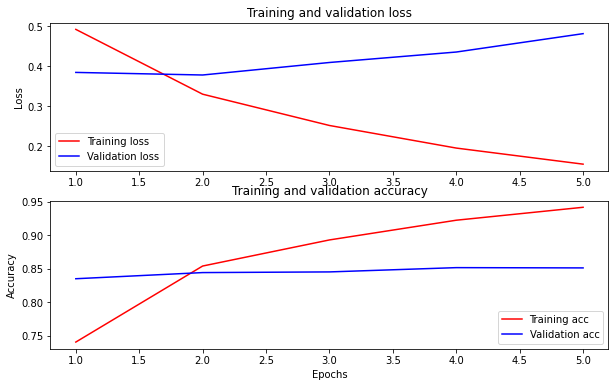

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2021-08-11 17:41:55.028470: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999511
input: The movie was great!           : score: 0.995135
input: The movie was meh.             : score: 0.972974
input: The movie was okish.           : score: 0.102610
input: The movie was terrible...      : score: 0.002207

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999511
input: The movie was great!           : score: 0.995135
input: The movie was meh.             : score: 0.972974
input: The movie was okish.           : score: 0.102610
input: The movie was terrible...      : score: 0.002207



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999511
input: The movie was great!           : score: 0.995135
input: The movie was meh.             : score: 0.972974
input: The movie was okish.           : score: 0.102609
input: The movie was terrible...      : score: 0.002207



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.